In [14]:
conda install logomaker
pip install seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [37]:
import infrared as ir
import infrared.rna as rna
import matplotlib.pyplot as plt
import copy

#### Create a model, and sample

#### Model: Add functions

#### Model: Add Custom features

In [38]:
import random
import math
import RNA
from RNA import energy_of_struct

## Exercises

In [39]:
import infrared as ir

# Define the number of nodes and the number of colors
n = 6
c = 4

# Define the edges of the graph as a list of tuples
edges = [(0, 1), (0,4), (0,2), (0,3), (0,5), (1, 2), (2, 3), (3, 4), (4, 5)]

# Create an empty model
model = ir.Model(n, c)

"""# Add variables to the model
for i in range(n):
    model.add_variables(i, (0, c-1))"""


ir.def_constraint_class( 
    'color_constraint',
    lambda i,j: [i,j],
    lambda x,y: x!=y
)    

# Add constraints to the model for each edge in the graph
model.add_constraints([color_constraint(i, j) for (i, j) in edges])

#Small cut
edges = [(0, 1), (0,4), (0,2), (3,2), (2, 3), (3, 4), (2,4), (4,2), (4,3)]
n = 5
p = 2
model = ir.Model(n, p)

ir.def_function_class( 
    'small_cut',
    lambda i,j: [i,j],
    lambda x,y: 0 if x==y else 1 
)

model.add_functions([small_cut(i, j) for (i, j) in edges], 'smallcut')

sampler = ir.Sampler(model)
model.set_feature_weight(-1, 'smallcut')
sample = [sampler.sample().values() for i in range(10)]

sample

[[0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [1, 1, 0, 0, 1],
 [0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1],
 [1, 0, 0, 1, 1],
 [1, 1, 0, 0, 1],
 [1, 0, 0, 1, 1],
 [0, 0, 1, 1, 0],
 [1, 1, 0, 1, 1]]

## First optimize function

In [40]:
ir.def_function_class(
    'hammingdistance',
    lambda i,y: [i],
    lambda x,y: 0 if x==y else 1
    )


def optimize(model, objective, steps, neighbour_steps, temp, start=None):
    """Works by a similar principle as mc_optimize, except that it doesn't work with connected components,
    but rather evaluates the neighbouring sample in each step and compares it to the current one"""
    
    sequences=[]
    
    sampler = ir.Sampler(model)
    cur = sampler.sample() if start is None else start
    curval = objective(cur)
    best, bestval = cur, curval
    
    for i in range(steps):
        new = neighbour_optimize(model, best, neighbour_steps, n, m)
        newval = objective(new)
        print("Neighbour" + str(i) + ": " + rna.ass_to_seq(new) + ", value: " + str(newval))
        sequences.append((rna.ass_to_seq(new),newval))
        
        if (newval >= curval or random.random() <= math.exp((newval-curval)/temp)):
            cur, curval = new, newval
            if curval > bestval:
                best, bestval = cur, curval
                
                
    return (sequences, best, bestval)

def neighbour_optimize(model,sample, weight, n, m):
    """Returns a neighbour of an input sample,
    but only once it's similar enough to the input sample"""
    m_prime = copy.deepcopy(model)
   
    m_prime.add_functions([hammingdistance(i,val) for (i,val) in enumerate(sample.values())], 'hammingdistance')
    m_prime.set_feature_weight(weight, 'hammingdistance')
    
    sampler = ir.Sampler(m_prime)
    
    neighbour = sampler.sample()

    return neighbour

def optimize2(model,const_td_factory, objective, steps, neighbour_steps, temp, start=None):
    """Works by a similar principle as mc_optimize, except that it doesn't work with connected components,
    but rather evaluates the neighbouring sample in each step and compares it to the current one"""
    
    sequences=[]
    
    sampler = ir.Sampler(model)
    cur = sampler.sample() if start is None else start
    curval = objective(cur)
    best, bestval = cur, curval
    
    for i in range(steps):
        new = neighbour_optimize2(model,const_td_factory, best, neighbour_steps, n, m)
        newval = objective(new)
        print("Neighbour" + str(i) + ": " + rna.ass_to_seq(new) + ", value: " + str(newval))
        sequences.append((rna.ass_to_seq(new),newval))
        
        if (newval >= curval or random.random() <= math.exp((newval-curval)/temp)):
            cur, curval = new, newval
            if curval > bestval:
                best, bestval = cur, curval
                
                
    return (sequences, best, bestval)


def neighbour_optimize2(model,const_td_factory, sample, weight, n, m):
    """Returns a neighbour of an input sample,
    but only once it's similar enough to the input sample"""
    m_prime = copy.deepcopy(model)
    
    m_prime.add_functions([hammingdistance(i,val) for (i,val) in enumerate(sample.values())], 'hammingdistance')
    m_prime.set_feature_weight(weight, 'hammingdistance')
    
    neighbor_generator_sampler = ir.Sampler(m_prime, td_factory=const_td_factory)
   
    neighbour = neighbor_generator_sampler.sample()

    return neighbour

class ConstTDFactory:
    """@brief TD factory returning a constant TD
    Allows to pass and reuse an already computed TD 
    """
    def __init__(self,td):
        self._td = td
    def create(self,_size,_dependencies):
        return self._td


In [41]:
#Using multi_defect as objective for testing

def multi_defect(sequence, targets, xi=1):
    k = len(targets)
    fc = RNA.fold_compound(sequence)
    ee = fc.pf()[1]
    eos = [fc.eval_structure(target) for target in targets]
    diff_ee = sum(1/k * (eos[i] - ee) for i in range(k))
    diff_targets = sum(2/(k*(k-1)) * abs(eos[i]-eos[j])
        for i in range(k) for j in range(k) if i<j)
    return diff_ee + xi * diff_targets

In [42]:
def draw_logo(sequences,name=None):
    import logomaker as lm
    
    matrix = lm.alignment_to_matrix(sequences = sequences)
    logo = lm.Logo(matrix)
    logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    logo.ax.xaxis.set_ticks_position('none')
    if name is not None:
        plt.savefig(name)
    plt.show()
    logo.ax.xaxis.set_tick_params(pad=-1)
    return sequences

def opt_draw_logo(sequences,name=None,num=10):
    try:
        draw_logo(sequences,name)
    except ModuleNotFoundError as e:
        print(e)

def assignments_to_seqs(xs):
    return [rna.ass_to_seq(x) for x in xs]


Neighbour0: CCUUCCGUUCUGGGAGCCCUCCCUAGGGGGGG-GG, value: -9.225587209065754
Neighbour1: UUUUGGACUUUCUAAGUUUUUGGCGAAAGUUA-AA, value: -11.512394706408182
Neighbour2: UUUUGGACUUUCCAAGUUUUUGGCGAAAGCCA-AA, value: -10.867961883544922
Neighbour3: UUUUGGACUUUCCAAGUUUUUGGCGAAAGCCA-AA, value: -10.867961883544922
Neighbour4: UUUUGGACUUUCCAAGUUUUUGGCUAAAGCCA-AA, value: -10.414319276809692
Neighbour5: UUUUGGACUUUUCAAGUUUUUGGCGAAAGCUA-AA, value: -8.518014828364054
Neighbour6: CUUCUCGUUCCGGGAACUCUCUCUCGGGAGGG-GG, value: -8.5121644337972
Neighbour7: UCUUGGACUUUCCAAGUCUUUGGCGAAAGUCA-GG, value: -10.6301358739535
Neighbour8: UCUUGGACUUUCCAAGUUUUUGGCGAAAGCCA-GA, value: -10.349693298339844
Neighbour9: UCUUGGACUUUCCAAGUUUUUGGCUAAAGUCA-GA, value: -10.808815479278564
Neighbour10: UCUUGGACUUUUCAAGUCUUUGGCGAAAGCCA-GG, value: -8.341853618621826
Neighbour11: CUUCCUGUUCCGGGAACUCUCCUUCGGGAGGG-GG, value: -9.136036396026611
Neighbour12: UUUCUCGUUCCGAGAACUCUCUCUUGGGAGGG-GA, value: -8.20669444402059
Neighbour13: CCUUGGA

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


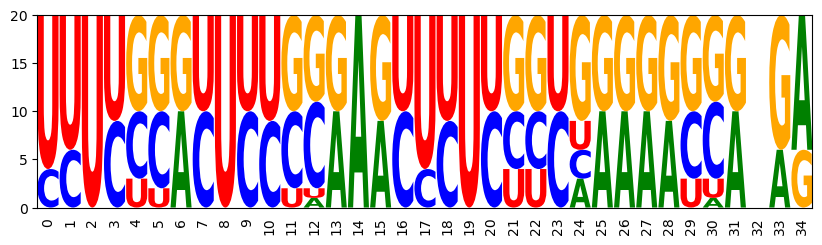

In [43]:
#Testing
n=35
m=4

#[Multiple_targets]
targets = ["((((((((((...))))((((....))))))))))",
           "((((((.((((((((....))))..))))))))))",
           ".((((((...)))))).(((((((....)))))))"]

model = ir.Model(n,m)
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')
model.set_feature_weight(1, 'gc')



for k, target in enumerate(targets):
    bps = rna.parse(target)
    model.add_constraints(rna.BPComp(i, j) for (i, j) in bps)
    model.add_functions([rna.BPEnergy(i, j, (i-1, j+1) not in bps)
    for (i, j) in bps], f'energy{k}')
    
original_sampler = ir.Sampler(model)
original_td = original_sampler.td
const_td_factory = ConstTDFactory(original_td)




steps = 20
neighbour_steps = 50
temp = 40
weight = -4

sample = original_sampler.sample()

objective = lambda x: - multi_defect(rna.ass_to_seq(x),targets,1)


iterations=1

for i in range(iterations):
    sequences, best,bestval = optimize2(model, const_td_factory, objective, steps, neighbour_steps, temp, start=None)
    rna_sequences = [sequences[i][0] for i in range(len(sequences))]
    opt_draw_logo(rna_sequences)

#Observation: for the same multi-target design problem, the optimize function can "get stuck" at a different 
#locally optimal sequence. From running it multiple times CCCCCCGCUCCGGGGGCCCCCUUCAGGGGGGGGGG seems to be 
#globally optimal with multi-defect -3.87

# Neighbour generator

In [44]:
n=35
m=4

#[Multiple_targets]
targets = ["((((((((((...))))((((....))))))))))",
           "((((((.((((((((....))))..))))))))))",
           ".((((((...)))))).(((((((....)))))))"]

model = ir.Model(n,m)
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')
model.set_feature_weight(1, 'gc')



for k, target in enumerate(targets):
    bps = rna.parse(target)
    model.add_constraints(rna.BPComp(i, j) for (i, j) in bps)
    model.add_functions([rna.BPEnergy(i, j, (i-1, j+1) not in bps)
    for (i, j) in bps], f'energy{k}')
    
original_sampler = ir.Sampler(model)
original_td = original_sampler.td
const_td_factory = ConstTDFactory(original_td)


steps = 20
neighbour_steps = 50
temp = 40
weight = -4

sample = original_sampler.sample()

model.add_functions([hammingdistance(i,val) for (i,val) in enumerate(sample.values())], 'hammingdistance')
model.set_feature_weight(weight, 'hammingdistance')


sample_init = sample
print(rna.ass_to_seq(sample_init))

CCCUCGGCCCUCGGGGCCCCCCGCCGGGGCGGGGG


In [45]:
import time
weight=-4

start_time = time.time()
neighbour = neighbour_optimize2(model,const_td_factory, sample, weight, n, m)
end_time = time.time()

print("Computation time: ", end_time - start_time)




start_time = time.time()
neighbour = neighbour_optimize(model,sample, weight, n, m)
end_time = time.time()

print("Computation time: ", end_time - start_time)

Computation time:  0.0541691780090332
Computation time:  0.04811382293701172


Neighbours: Weight = 1
1: GGGGGUCGGGGGCCUCGGGGGGCGACCUCGUUCUC
2: GGGGGCUAGGGGUUCUAGGGGGUGCCCCUGUCCCU
3: GAGGGCUGGGGGUUCUGGGGGGCGCCUCCGCCCUC
4: GGGGGCCGAGGGCUUCGGGGGGUGCUUUCGUCCCU
5: GGGGGUUGGGGGCCUCAGGGGGCGCUCCCGUCCUU
6: GGGGGCCGGGGGUCUCGGGGGGCGGCCUCGCCCCU
7: GGGGCGCGGGGUGCUUGGGGGUGGACCCCUGCCUU
8: AGGGGUCGGGGGUCCCGGGGGACGGCCUCGUCUCU
9: GGGGGUUGGGGGCUCUGGGGGGUGACCUCAUUCCU
10: GGGGGUUGGGGGCUUCGGGGGGCGGCCUCGCUUUC
11: GGGACGUGGGGUGUCCGGGGGCAGACCCCUGUCCC
12: AGGGGCCGGGGGCCCCGGGGGGCGUCCCCGUCUCU
13: GGGGGCCGGGGGUUCCGGGGGGCGCCCCUGUCCCC
14: GGGGGCUGGGGGCUUCGGGGGGCGCCCCUGUUCCU
15: GGGGGCCGGGGGCUCCGGAGGGCGCCCUCGCUCUU
16: GGGGGUCGGGGGCCCUGGGGGGUGCCUCCGCCCUU
17: GGGGCCCGGGGGGCCCGGGGGUCGGUCCCGGCCCC
18: GGGGGGUGGGGUUCCCGGGGGGAGGUUCCUCCCUU
19: GGGGCCCGGGGGGUCUGGGGGUCACCCUUGGUCCU
20: GGGGCCCGGGGGGCUCGGGGGCCAUCCCUGGUCCU
21: GGGGACCGGGGGUCCUGAGGGGCACCUCUGUCCCU
22: GGGGGCUGGGGGCCCCGGGGGGCGUUCCCGCCCCC
23: GGGGGCCGGGGGCCCUGGGGGGUGACCCCGCCUCC
24: AAGGCCCGGGGGGUUUGGGGGCCGCCCUUGGUUUU
25: GAGGCCCGGGGGGCCUGGGGGC

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


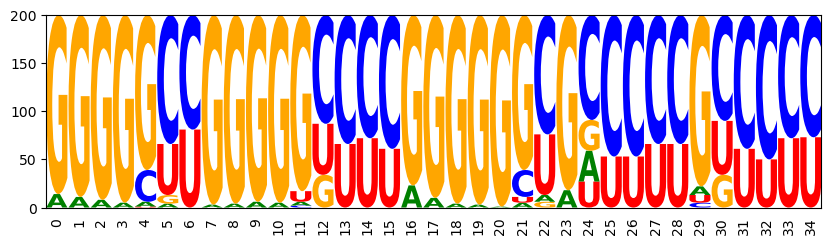

In [29]:
#Positive weights

rna_sequences2=[]
iterations = 200
weight2 =1

curr = sample_init
start_time = time.time()
print("Neighbours: Weight = 1")
for i in range(iterations):
    neighbour = neighbour_optimize2(model,const_td_factory,curr, weight2, n, m)
    rna_sequences2.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    #curr = neighbour
    end_time = time.time()

print("Computation time: ", end_time - start_time)
    
#print(rna_sequences4)
opt_draw_logo(rna_sequences2)

Neighbours: Weight = 5
1: GGGGGCUGGGGGUUUCGGAGGGUGCUCUCGUCCUC
2: GGAGGUCGGGGGUCUUGGGGGAUGCUUCUGUCUCU
3: GGGGGCCGGGGGUCCCGGGGGGCACCUCUGCCCCU
4: GGAGACCGGGGGUUUCGGGGGAUGCCCCCGUUUCU
5: GGGGGCUGGGGGCCUCAGGGGGCGCCCCCGCCCCC
6: GGGGGCUGGGGGUCCCAGGGGGCGCCCCCGUCUCU
7: GGGGGCUGGGGGUUCCGGGGGACGCCCCUGUCCCU
8: GGGGGUUGGGGGCUCCGGGGGGUGCCUCCGCUCCU
9: GGGGGCCGGGGGUCCCGGGGGGCGCCCCCGCCUCC
10: GGGGGCCGGGGGUCUCGGGGGGCGACCCCGCCCUU
11: GGGGGUCGGGGGCCCCGGGGGGCGACUCCGCUUUU
12: GGGGGUCGGGGGUCCCGGGGGGCGCCCCCGCCCCU
13: GGGGGCCGGGGGUCCCGGGGGGCGCCCUCGCCCCC
14: GAGGGCCGGGGGCCCUGGGGGGCGUCCCCGCUUUU
15: GGGGGCUGGGGGUCCUGGGGGGCGCCCCCGCCUUC
16: GGGGGUUGGGGGCCUCGGGGGGCGCCCCCGUCCCC
17: AGGGGCUGGGGGUCCCGGGGGGCGUCCCCGUCUUU
18: GGGGGCCGGAGGCUCCGGGGGGCGCCUUCGUCCUC
19: GGGGGCCGGGGGUCCCGGGGGGCGUUCCCGCCCUC
20: GGGGGCUGGGGGCCCCGGGGGGCGCUCCCGCCCCC
21: GGGGGUCGGAGGUUCUGGGGGACGUCUCCGUCCCU
22: GGGGGCUGGGGGCCCUGGGGGGCGUCCCCGCCCCC
23: GGGGGCUGGGGGCCCCAAGGGGCGCUCCUGUUCUU
24: GGAGGCCGGGGGCCUCGGAGGGCGACCUCGUCUUC
25: GGGGACUGGGGGUUCUGGGGGA

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


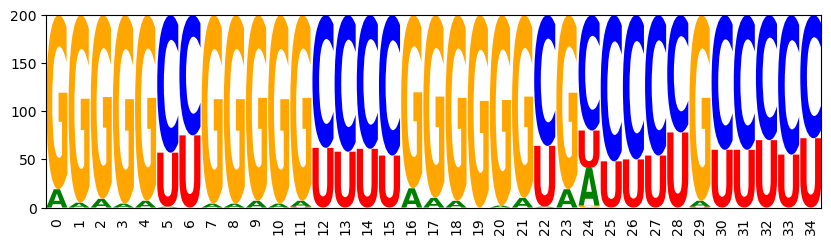

Neighbours: Weight = 10
1: GGGGGCUAGGGGCCCUGGGGGGUGUCCCUGCCUCU
2: GGGGGCUGGGGGCCCCAGGGGGCGCCCCCGCCUUC
3: GGGGGCUGGGGGUCCCAGGGGGCGCCCCCGUCCCC
4: GGGGGCUGGGGGCCUCAGGGGGCGCCUCUGCCCCC
5: GGGGGCCGGGGGUUCUGGGGAGUGUUUCCGCUUCC
6: GGGGGUCGGGGGUCCCGGGGGGUACCCCUGCCCCC
7: GGGGGCCGGGGGCCUCGGGGGGCGCCCUUGCCCCC
8: GGGGGCCGGGGGUUCCGGGGGGCGCCCCCGCUCCC
9: GGGGGCUGGAGGUUCUGGGGGGCGCCUCCGCCCCC
10: GGGGGUCGGGGACCCCGGGGGGUACCCCUGCCCCC
11: GGGGGCCGGGGGUCUCGGGGGACGCCCCCGUUUCU
12: GGGGGUUGGGGGCCCCGGGGGGCGAUUUCGCCCCC
13: GGGGGUUGGGGACCCCGAGGGGUAACCCUGCCCUU
14: GGGGGCCGGGGGCCCUGGGGGGCGCUCCCGCCCCC
15: GGGGGCUGGGGGUUUCGGGGGACACCUCUGUUCCU
16: GGGGGUCGGGGGCCCCGGGGGGUGCCCCUACCCCU
17: GGGAGCUGGGGGCUCCGGGGGGUGCUCCUGCUCUC
18: GGGGGCCGGGGGCUCUGGGGGGCGUUCCCGCUCUC
19: AGGGGCUGGGGGCCUCGGGGGGCGCCCUCGUCCCU
20: GGGGGCCGGGGGCCCCGGGGGGUGCUCCCGUUCCU
21: GGGGGCCGGGGGCUCCGAGGGGCACCCCUGCUUCU
22: AGGGGCCGGGGGCUCCGAGGGGUGUUCCUGUUCUU
23: GGGGGCCGGGGGUUCUGGGGGGUGCUCUCGUUUCC
24: GGGGGCUGGGGGUUCCGGGGGGCACUCCUGCUCCU
25: GGGGGCCGGGGGCCUUGGGGG

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


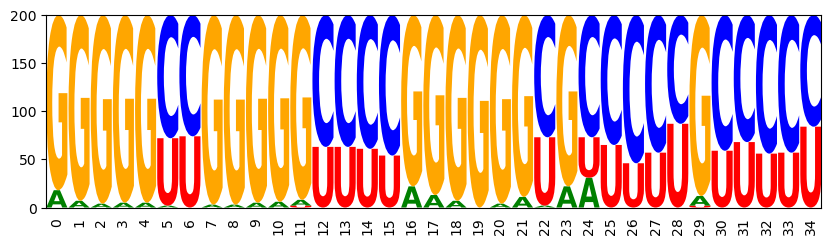

In [30]:
rna_sequences3=[]
iterations = 200
weight3 =5

curr = sample_init
print("Neighbours: Weight = 5")
for i in range(iterations):
    neighbour = neighbour_optimize2(model,const_td_factory,curr, weight3, n, m)
    rna_sequences3.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    #curr = neighbour
    
#print(rna_sequences3)
opt_draw_logo(rna_sequences3)

rna_sequences4=[]
iterations = 200
weight4 =10

curr = sample_init
print("Neighbours: Weight = 10")
for i in range(iterations):
    neighbour = neighbour_optimize2(model,const_td_factory,curr, weight4, n, m)
    rna_sequences4.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    #curr = neighbour
    
#print(rna_sequences4)
opt_draw_logo(rna_sequences4)

Neighbours: Weight = -1
1: CCUCUGGCCCCCGGGGCCCCCUGUGGGGGCAGGGG
2: CCUCCGGCCCCCGGGGCCCCUCGCUGGGGUGGGGG
3: CCCCCGGCCCCCGGGGCUCCCUGUCGGGGCGGGGG
4: CCCCUGGUCCUCGGGGUCCUCUGCCGGGGCGGGGG
5: CCUCCGGCCCCCGGGGCCCUCCGCCGGGGCGGGGG
6: UCUCUGGCCCCCGGGGCCCCCUGUGGGGGCAGGGG
7: CCCCCCGCCUUGGGGGCCCUCCUCGGGGGGGGGGG
8: CCCCUGGUCCCCGGGGCCCCCCGCUGGGGUGGGGG
9: CCCCUGGCCCCCGGGGCCCCCUGCGGGGGCGGGGG
10: CCCCCGGUCCCCGGGGCUCCCUGCCGGGGUGGGGG
11: CCCCCGGUUCCCGGGGCCUCCUGCCGGGGCGGGGG
12: CCCUUGGUCCCUGGGGCCCCUUGUGGGGGCGGGGG
13: CUCUUGGCUUCCGGGGCCCCCUGUGGGGGUGGGGG
14: CCCCUGGUCCCCGGGGCCCCCUGCGGGGGCGGGGG
15: CCCCUGGCCCCCGGGGCUCCUUGCCGGGGUAGGGG
16: CCCCGGGUUCCCCGGGUUCCCGGUCGGGGUCGGGG
17: CCCCCGGCCCCCGGGGCCCCCCGCGGGGGCGGGGG
18: CUUCGGGUCCCCUGGACCCCCGGCGGGGGCCGGGG
19: CCCCGGGUCCCUUGGGCCCCCGGCGGGGGCUGGGG
20: CCUCUGGUCCCCGGGGCUUCUUGCGGGGGCAGGGG
21: CCUCUGGUCCCCAGGGUCCCCUGUGGGGGCGGGGG
22: CCCUUGGCUCCCGGGGCCCCCUGCUGGGGCGGGGG
23: CCUCUGGUCCUCGGGGCCCCCCGUGGGGGCGGGGG
24: CCUCUGGCCCCUGGGGCCCCCUGCGGGGGCGGGGG
25: CCCCUGGCCCCCAGGGCUCCC

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


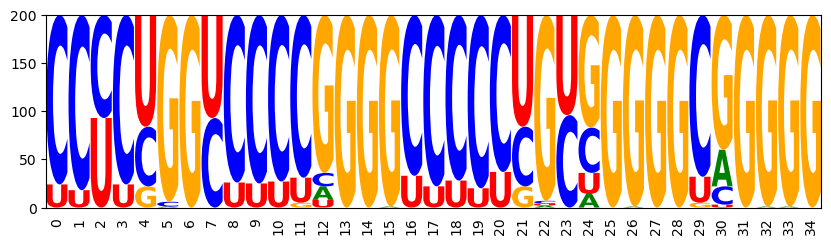

Neighbours: Weight = -5
1: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
2: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCGGGGG
3: CCCCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
4: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
5: CCUCUGGUCCCCGGGGCCCCCUGUCGGGGCAGGGG
6: CCUCUGGUCCCCGGGGCCCCUUGUGGGGGCAGGGG
7: CCUCUGGUCCCUGGGGCCCCCUGUGGGGGCAGGGG
8: UCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
9: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
10: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
11: CCUCUGGCCCCCGGGGCCCCCUGUUGGGGCAGGGG
12: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
13: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
14: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
15: CCUCUGGUCCCCGGGGUCCCCUGUGGGGGCAGGGG
16: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
17: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
18: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
19: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
20: CCUCUGGCCCCCGGGGCCCCCUGUGGGGGCAGGGG
21: CCCCUGGCCCCCGGGGCUCCCUGUCGGGGCAGGGG
22: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCGGGGG
23: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
24: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
25: CCUCUGGUCCCCGGGGCCCCC

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


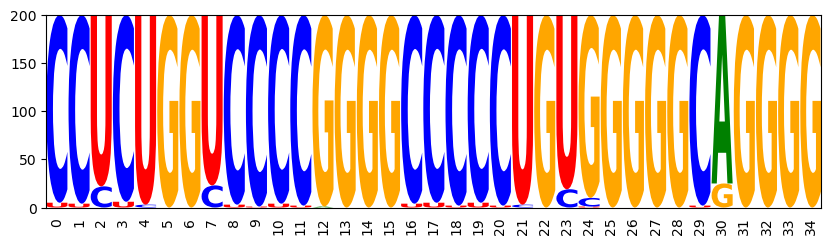

Neighbours: Weight = -10
1: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
2: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
3: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
4: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
5: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
6: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
7: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
8: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
9: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
10: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
11: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
12: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
13: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
14: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
15: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
16: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
17: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
18: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
19: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
20: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
21: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
22: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
23: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
24: CCUCUGGUCCCCGGGGCCCCCUGUGGGGGCAGGGG
25: CCUCUGGUCCCCGGGGCCCC

/home/elena/miniconda3/envs/myenv/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


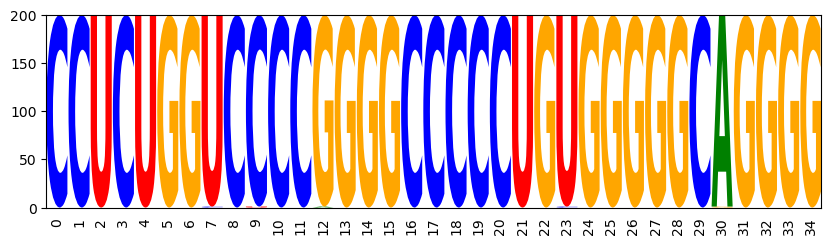

In [31]:

#Negative weights
rna_sequences5=[]
iterations = 200
weight5 =-1

curr = sample_init
print("Neighbours: Weight = -1")
for i in range(iterations):
    neighbour = neighbour_optimize2(model,const_td_factory, curr, weight5, n, m)
    rna_sequences5.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    #curr = neighbour
    
opt_draw_logo(rna_sequences5)


rna_sequences6=[]
iterations = 200
weight6 =-3

curr = sample_init
print("Neighbours: Weight = -5")
for i in range(iterations):
    neighbour = neighbour_optimize2(model,const_td_factory, curr, weight6, n, m)
    rna_sequences6.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    #curr = neighbour
    
opt_draw_logo(rna_sequences6)


rna_sequences7=[]
iterations = 200
weight7 =-6

curr = sample_init
print("Neighbours: Weight = -10")
for i in range(iterations):
    neighbour = neighbour_optimize2(model,const_td_factory, curr, weight7, n, m)
    rna_sequences7.append(rna.ass_to_seq(neighbour))
    print(str(i+1) + ": "+ rna.ass_to_seq(neighbour))
    #curr = neighbour
    
opt_draw_logo(rna_sequences7)

In [18]:
import seaborn as sns

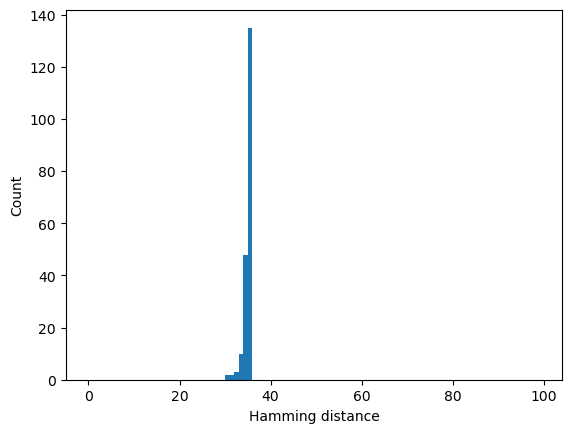

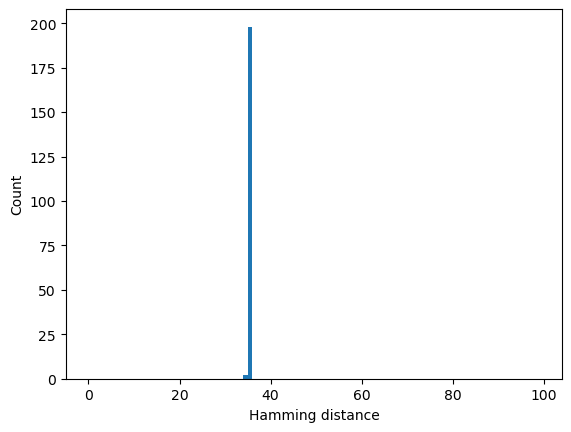

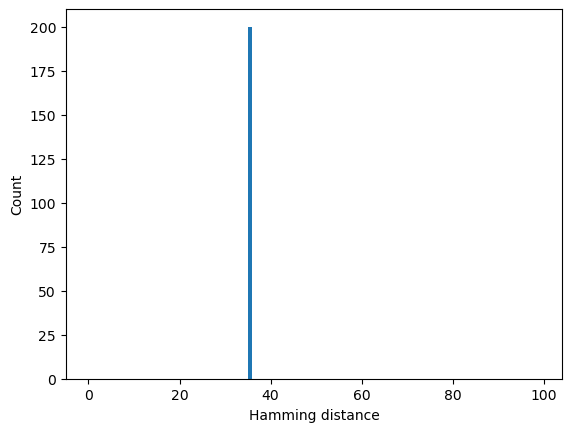

In [34]:
#Plotting Hamming distance between neighbours when positive weights are used
sequences = rna_sequences2

def hamming_distance(seq1, seq2):
    return sum(s1 != s2 for s1, s2 in zip(seq1, seq2))

hamming_distances = [hamming_distance(rna.ass_to_seq(sample_init), seq) for seq in sequences]
# Plot the histogram
plt.hist(hamming_distances, bins=range(100))
plt.xlabel("Hamming distance")
plt.ylabel("Count")
plt.show()

sequences = rna_sequences3

hamming_distances = [hamming_distance(rna.ass_to_seq(sample_init), seq) for seq in sequences]
# Plot the histogram
plt.hist(hamming_distances, bins=range(100))
plt.xlabel("Hamming distance")
plt.ylabel("Count")
plt.show()

sequences = rna_sequences4

hamming_distances = [hamming_distance(rna.ass_to_seq(sample_init), seq) for seq in sequences]
# Plot the histogram
plt.hist(hamming_distances, bins=range(100))
plt.xlabel("Hamming distance")
plt.ylabel("Count")
plt.show()


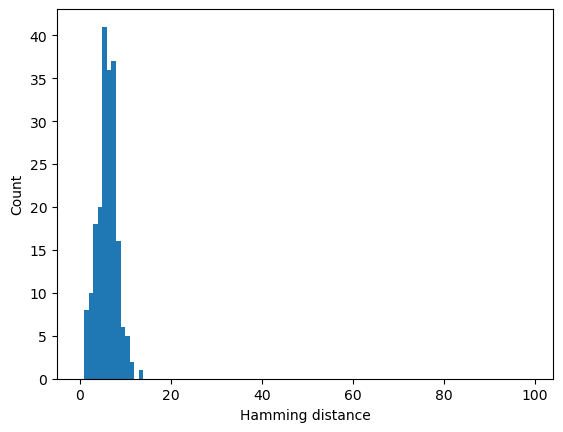

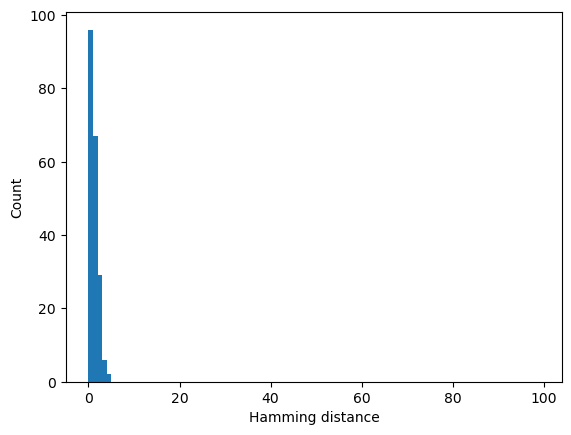

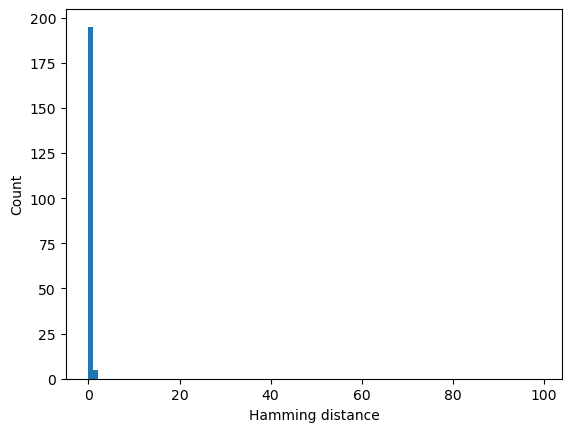

In [33]:
#Plotting Hamming distances between neighbours when negative weights are used
sequences = rna_sequences5

hamming_distances = [hamming_distance(rna.ass_to_seq(sample_init), seq) for seq in sequences]
# Plot the histogram
plt.hist(hamming_distances, bins=range(100))
plt.xlabel("Hamming distance")
plt.ylabel("Count")
plt.show()

sequences = rna_sequences6

hamming_distances = [hamming_distance(rna.ass_to_seq(sample_init), seq) for seq in sequences]
# Plot the histogram
plt.hist(hamming_distances,bins=range(100))
plt.xlabel("Hamming distance")
plt.ylabel("Count")
plt.show()

sequences = rna_sequences7

hamming_distances = [hamming_distance(rna.ass_to_seq(sample_init), seq) for seq in sequences]
# Plot the histogram
plt.hist(hamming_distances, bins=range(100))
plt.xlabel("Hamming distance")
plt.ylabel("Count")
plt.show()


#  Testing def_optimize()

In [35]:
weight = -1
sample_init = sampler.sample()

temps = [0.25,0.5,1.25,1.5,1.75]+[i for i in range(1,50,10)]
iterations = [50, 100, 200, 500, 1000]
best_performance = float("-inf")
best_temp = 0
best_iterations = 0

for i in range(10):
    best_performance = float("-inf")
    best_temp = 0
    best_iterations = 0
    for temp in temps:
        for iteration in iterations:
            result = optimize2(model, const_td_factory, objective, iteration, weight, temp, sample_init)
            final_sequence, final_value = result[1], result[2]
            performance = final_value
            if performance > best_performance:
                best_performance = performance
                best_temp = temp
                best_iterations = iteration

    print("Best temperature: ", best_temp)
    print("Best number of iterations: ", best_iterations)
    print("Best value: ", best_performance)
    
#Without resetting the values
"""1.iteration
Best temperature:  0.5
Best number of iterations:  1000
Best value:  -3.5984723567962646
2. iteration
Best temperature:  0.25
Best number of iterations:  50
Best value:  -2.0854640007019043
3. iteration
Best temperature:  0.25
Best number of iterations:  50
Best value:  -2.0854640007019043
4. iteration
Best temperature:  0.25
Best number of iterations:  50
Best value:  -2.0854640007019043
5. iteration
Best temperature:  0.25
Best number of iterations:  50
Best value:  -2.0854640007019043
6. iteration
Best temperature:  11
Best number of iterations:  500
Best value:  -2.068019390106201
7. iteration
Best temperature:  1.5
Best number of iterations:  1000
Best value:  -1.1849751472473145
8th
Best temperature:  1.5
Best number of iterations:  1000
Best value:  -1.1849751472473145

Best temperature:  1.5
Best number of iterations:  1000
Best value:  -1.1849751472473145"""

#With resetting the values 
"""Best temperature:  31
Best number of iterations:  1000
Best value:  -2.564136028289795

Best temperature:  1
Best number of iterations:  1000
Best value:  -3.0439672470092773

Best temperature:  1.75
Best number of iterations:  1000
Best value:  -3.3947081565856934

Best temperature:  0.25
Best number of iterations:  1000
Best value:  -3.5448808670043945

Best temperature:  1.25
Best number of iterations:  1000
Best value:  -3.272826671600342

Best temperature:  1
Best number of iterations:  1000
Best value:  -3.6640005111694336

Best temperature:  1
Best number of iterations:  1000
Best value:  -3.862241268157959

Best temperature:  1.75
Best number of iterations:  500
Best value:  -1.2923593521118164

Best temperature:  1.5
Best number of iterations:  1000
Best value:  -3.388950824737549

Best temperature:  21
Best number of iterations:  1000
Best value:  -2.7302675247192383"""

Neighbour0: GGAGGGUGGGGCCUUCAGGGGGGGCCCCCCCCUCC, value: -16.097782135009766
Neighbour1: GGAGGGCGGGGCUUUCGGGGGGGGGCCCCCCCUCC, value: -12.997725168863932
Neighbour2: GGGGGGCGGGGCUUCCGGGGGGGGGCCUCCCUCCC, value: -13.765443483988443
Neighbour3: GGAGGGUGGGGCUCUCGGGGGGGGGCCUCCUCUCC, value: -15.257563273111979
Neighbour4: GGGGGGCGGGGCCCUCGGGGGGGGCCCCCCCCUCC, value: -16.35058085123698
Neighbour5: GGGGGGCGGGGCCUCCGGGGGGGGGCUCCCCCCCC, value: -16.556160608927406
Neighbour6: GGGGGGCGGGGCCUUCGGGGGGGGGUCCCCCCCCC, value: -16.19554901123047
Neighbour7: GGGGGGCGGGGUUUCCGGGGGGGAGCCCUCCCUCC, value: -11.574191729227701
Neighbour8: GGGGGGCGGGGCCCCCGGGGGGGGCCCCUCCCCCC, value: -17.43375015258789
Neighbour9: GGGGGGCGGGGCCCCCGGGGGGGGGCCUUCCCCUC, value: -16.664597193400063
Neighbour10: GGGGGGUGGGGUUUUCGGGGGGGGCCUCCCCCUUC, value: -13.945013999938963
Neighbour11: GAGGGGCGGGGUUUUUGGGGGGGGGCUCCCCCUUC, value: -10.431511561075846
Neighbour12: GGGGGGCGGGGCCUUUGGGGGGGGGUCCCCCCCCC, value: -15.839556376139324
Neighbour13:

Neighbour1: CCCCGUGCUCCGCGGGCCUCCGUUGGGGGGCGGGG, value: -10.477166493733723
Neighbour2: UCCCGUGCUCCGCGGGCCCUCGCCAGGGGGCGGGG, value: -7.955108960469563
Neighbour3: UCCCGUGCCUCGUGGGCCCCCGCCGGGGGGCGGGG, value: -6.720844268798827
Neighbour4: CCCCGCGCCUCGCGGGCCCCCGCCCGGGGGCGGGG, value: -5.347239176432291
Neighbour5: CCCCGCGCUCCGCGGGCCUCCGCCCGGGGGCGGGG, value: -10.228694279988606
Neighbour6: CUCCGCGCUCCGCGGGCCCCCGCCCGGGGGCGGGG, value: -8.623350779215494
Neighbour7: CUCCGCGCCUCGCGGGCCCCUGCCCGGGGGUGGGG, value: -9.194455782572428
Neighbour8: CUCCGCGCCCCGCGGGUCCCUGCCUGGGGGCGGGG, value: -8.997278213500977
Neighbour9: UCCUGCGCCCCGCGGGCUCCCGUCCGGGGGCGGGG, value: -9.572893142700195
Neighbour10: CCCCGCGCUUCGCGGGCUCCCGCCCGGGGGCGGGG, value: -8.748394012451172
Neighbour11: CCCCGCGCCUCGCGGGCCCCCGUCGGGGGGCGGGG, value: -5.775021870930989
Neighbour12: UUCCGCGCCCCGCGGGUCCUCGCCCGGGGGCGGGG, value: -13.387666384379068
Neighbour13: CCCCGCGCCCUGUGGGCCCCCGCCCGGGGGCGGGG, value: -5.786279678344726
Neighbour14: CCUCG

Neighbour4: GGGGGGUGGGGUCCCCGGGGGGGGCCUCUCCCCCC, value: -17.326950391133625
Neighbour5: GGGGGGCGGGGCCCCUGGGGGGGGGCCCUCCUCUC, value: -16.01311143239339
Neighbour6: GGGGGGCGGGGUCCCUGGGGGGGGCCUCCCCCCCC, value: -13.833003362019856
Neighbour7: GGGGGGCAGGGCCCCUGGGGGGGGGCCCUCCCCUU, value: -16.828460693359375
Neighbour8: GGGGGGCGGGGCCCCUGGGGGGGGCUCUCCCCCCC, value: -17.244739532470703
Neighbour9: GGGGGGCGGGGCCUCCGGGGGGGACCUCUCCCUCC, value: -12.009962717692055
Neighbour10: GGGGGGUGGGGUCUCCGGGGGGGAGCUCUCUCCCC, value: -12.112481753031412
Neighbour11: GGGGGGCGGGGUCUCCGGGGGGGACCUCUCCCCCC, value: -15.831816355387367
Neighbour12: GGGGGGCGGGGCCCCCGGGGGGGGCUCCUCCUUCC, value: -18.00961939493815
Neighbour13: GGGGGGUGGGGCUUCCGGGGGGGGCUCCUCCCUCC, value: -16.083995501200356
Neighbour14: GGGGGGCGGGGCCCCCGGGGGGGGCCCCUUCCUCC, value: -16.786624908447266
Neighbour15: GGGGGGCGGGGCCCCCGGGGGGGGGCUCCCCCCCC, value: -17.254641215006508
Neighbour16: AGGGGGCGGGGUCCCCGGGGGGGGCCCCCCCCUCU, value: -13.18813387552897
Neighbou

Neighbour113: GGGGGUCGGGGGCUCCGGGGGGCGACCCCGCCCCC, value: -5.228765487670898
Neighbour114: GGGGGCCGGGGGCUCCGGGGGGCGGUCCCGCCCCC, value: -7.292145411173502
Neighbour115: GGGGGCCGGGGGUCCCGGGGGGCGGCCCCGCCCCC, value: -3.2873878479003906
Neighbour116: GGGGGCCGGGGGCCCCGGGGGGUGGCCUCGUCCUC, value: -6.15164566040039
Neighbour117: GGGGGCCGGGGGCCCCGGGGGGCGGCCCCGCCUCC, value: -5.927074432373047
Neighbour118: GGGGCCCGGGGGGCCCGGGGGUCGACCCCGGCCCC, value: -2.79429817199707
Neighbour119: GGGGCCCGGGGGGCCCGGGGGUCAGCCUUGGCCCC, value: -7.584247589111327
Neighbour120: GGGGCCUGGGGGGCCCGGGGGUUGCCCUUGGCCCC, value: -9.207295735677082
Neighbour121: GGGGCUCGGGGGGCCCGGGGGUUAACCCUGGCCCC, value: -3.6179459889729815
Neighbour122: GGGGCCCGGGGGGCCCGGGGGCCGCCCUCGGCCCC, value: -9.880764643351235
Neighbour123: GGGGGCCGGGGGCCCUGGGGGGCGACCCCGUCCCC, value: -6.779116948445638
Neighbour124: GGGGCCCGGGGGGCCCGGGGGUCGCCUUUGGCCCC, value: -11.507654507954914
Neighbour125: GGGGCUUGGGGGGUCCGGGGGCCGGCCCCGGCCUU, value: -9.5603666305542


Neighbour0: CCCCUGGUCCCCGGGGUCCCCCGCGGGGGCGGGGG, value: -15.997105598449707
Neighbour1: CCCCCGGUUUCCGGGGCCCCCUGCGGGGGCGGGGG, value: -10.880108515421549
Neighbour2: UCCCUGGCUUCCGGGGCCCUCUGCCGGGGCGGGGG, value: -11.037113825480143
Neighbour3: CCCCCGGCCCCCGGGGCCCCCCGCGGGGGUGGGGG, value: -10.129326502482096
Neighbour4: CCCCCGGCCCCUGGGGCCCCCUGUGGGGGCGGGGG, value: -7.695329666137694
Neighbour5: CCUCCGGCCCCUGGGGUCCCCCGUGGGGGCGGGGG, value: -11.131587982177734
Neighbour6: CCUCCGGCUCCCGGGGCCUUCCGUGGGGGCGGGGG, value: -15.027211825052895
Neighbour7: CCCCCGGCCCCCGGGGCCCUCCGCGGGGGCGGGGG, value: -12.077484130859373
Neighbour8: CCUCCGGCCCUCGGGGCCCCCCGUGGGGGCGGGGG, value: -8.399450302124023
Neighbour9: CCCCGGGCCCCCCGGGCCCCCGGCGGGGGCCGGGG, value: -8.907756169637043
Neighbour10: CCCCCGGCCCCCGGGGCUUCCCGCCGGGGCGGGGG, value: -13.477559407552082
Neighbour11: CCCCCGGCUCUCGGGGCCCCUCGUCGGGGCGGGGG, value: -5.273934046427408
Neighbour12: UCCCCGGCUCUCGGGGCCCCCCGUCGGGGCGGGGG, value: -6.997243881225585
Neighbour13: C

Neighbour108: CCCCUGGCUCCCGGGGCCCCCUGUUGGGGCGGGGG, value: -3.4029515584309893
Neighbour109: CCUCCGGCUCCCGGAGCCCUCUGCCGGGGCGGGGG, value: -6.734644889831543
Neighbour110: CCCCGGGCUCCCCGGGCCUCCGGCAGGGGCUGGGG, value: -8.62737528483073
Neighbour111: CUCCGGGCUCCUCGGGCCCCCGGUUGGGGCCGGGG, value: -4.209388097127278
Neighbour112: UCCCCGGCUCCCGGGGCCCUCCGCUGGGGCGGGGG, value: -10.770762761433918
Neighbour113: CCCCUGGCUCCCGGGGCCCCCUGUGGGGGCGGGGG, value: -8.393042882283527
Neighbour114: CCCCUGGCCCCUAGGGCCCCCUGCCGGGGCGGGGG, value: -4.514565149943033
Neighbour115: CCCCUGGCCUCCAGGGCCCCCUGUCGGGGCAGGGG, value: -3.473743438720703
Neighbour116: CUCCUGGUCCCUAGGGCCCCCUGCGGGGGCGGGGG, value: -5.7201894124348955
Neighbour117: CCCCUGGUUCCUGGGGCCCUCUGCGGGGGCGGGGG, value: -9.452192624409992
Neighbour118: CCUCUGGUUCCUGGGGCCUCCUGCCGGAGCGGGGG, value: -6.712459882100424
Neighbour119: CCCCCGGUCCUUGGGGUCCCCUGUCGGGGCGGGGG, value: -6.728228251139322
Neighbour120: CCCCUGGCUCCUGGGGCUCCCUGCGGGGGCGGGGG, value: -7.3562831878662

Neighbour220: CCCCUGGCCCUUGGGGCCCCCUGCCGGGGCGGGGG, value: -6.380458196004231
Neighbour221: CCUCUGGCCCCCGGGGCCCCCCGCUGGGGCGGGGG, value: -7.346768061319986
Neighbour222: CCCCCGGCCCCUGGGGCCCCCCGCCGGGGUGGGGG, value: -6.131345748901367
Neighbour223: CCCCUGGUCCCCAGGGCCCCCUGCGGGGGUGGGGG, value: -9.618053754170734
Neighbour224: CCCCUGGCUCCCAGGGCCCCCUGUCGGGGCGGGGG, value: -4.73520024617513
Neighbour225: CCCCUGGCCCCCAGGGCCCCCUGUCGGGGCGGGGG, value: -5.657588322957356
Neighbour226: CUCCCGGCUCCCGGGGCCCCCUGCGGGGGCGGGGG, value: -8.384443918863932
Neighbour227: CCCCUGGCUCCUGGGGCCCCCCGUGGGGGCGGGGG, value: -8.515848159790039
Neighbour228: CCCUUGGCCUCCGGGGCCCCUUGUCGGGGCGGGGG, value: -4.423123041788737
Neighbour229: CCCCCGGCUCCCGGGGCCCCCCGCGGGGGCGGGGG, value: -10.800638834635416
Neighbour230: CCCUGGGCUCCCCGGGCCCCCGGUGGGGGUUGGGG, value: -9.360037485758463
Neighbour231: CCCCUGGUCCCCGGGGCUCCCUGUAGGGACGGGGG, value: -7.26971435546875
Neighbour232: CCCCCGGCCUUUGGGGCCCUCCGCGGGGGCGGGGG, value: -6.409617741902669


Neighbour331: CUUCCGGCUCCUGGGGCCCCCCGUUGGGGCGGGGG, value: -5.869176228841146
Neighbour332: CCCCCGGUUCCUGGGGCCUUUUGUCGGGGCGGGGG, value: -9.564745903015137
Neighbour333: CCCCUGGCUCCUGGGGCCCCCCGUGGGGGCGGGGG, value: -8.515848159790039
Neighbour334: CCCCCGGCCCCCGGGGCCCCCCGCGGGGGCGGGGG, value: -9.912206013997396
Neighbour335: CCUCUGGCCCCUGGGGCCCCCCGCCGGGGCGGGGG, value: -6.669500350952148
Neighbour336: UCUCCGGCUCCCGGGGCUCCCCGCUGGGGCGGGGG, value: -10.567724545796711
Neighbour337: CUCCUGGUCCCUGGGGCCCUCCGUCGGGGCGGGGG, value: -7.6360979080200195
Neighbour338: CCCCUGGCUCCUGGGGCCCUCUGCCGGGGCAGGGG, value: -5.941191355387369
Neighbour339: CUCCCGGCUCCCGGGGCCCCUCGUAGGGGCGGGGG, value: -6.566530227661133
Neighbour340: CCCUCGGUUCCUGGGGCCUUUUGCCGGGGCGGGGG, value: -12.24056816101074
Neighbour341: CCCCCGGCCCCCGGGGCUCCCUGCCGGGGCGGGGG, value: -7.655607223510742
Neighbour342: CCCCCGGCCCUCGGGGCCCCUUGUGAGGGCGGGGG, value: -7.488320032755533
Neighbour343: CCCCCGGUUCUCGGGGCUCUUCGCCGGGGCGGGGG, value: -11.668335278828

Neighbour443: CCCCCGGCUUCUGGGGCCUCCCGCGGGGGCGGGGG, value: -10.083236694335938
Neighbour444: CCCUCGGCCCCUGGGGCCCCCUGCCGGGGCGGGGG, value: -4.232421875
Neighbour445: CCCCCGGCUCCCGGGGCCCCCCGUUGGGGCGGGGG, value: -6.495807647705078
Neighbour446: CCCUCGGCUCCUGGGGCCCCCUGUGGGGGCGGGGG, value: -6.044164021809895
Neighbour447: CCCCUGGCCCCUGGGGCCCCCCGCCGGGGCGGGGG, value: -6.493080139160156
Neighbour448: CCCCCGGCCUCUGGGGUCCCCCGCGGGGGCGGGGG, value: -9.164859135945637
Neighbour449: CCUCCGGCCCCUGGGGCCCCCUGCAGGGGCGGGGG, value: -7.460762023925781
Neighbour450: CCCCCGGCUCCCGGGGCCCUCUGCCGGGGCGGGGG, value: -8.116165161132812
Neighbour451: CCCCCGGCCCCCGGGGCCCCCUGUUGGGGCGGGGG, value: -4.845067977905273
Neighbour452: CCCCCGGCCCCCGGGGCUCCUUGUUGGGGCGGGGG, value: -8.13280169169108
Neighbour453: CCCCCGGCCCCCGGGGUCCCCCGUGGGGGCGGGGG, value: -12.970953623453775
Neighbour454: CCCCCGGCUCCUGGGGCCCCCCGCGGGGGCGGGGG, value: -8.44045321146647
Neighbour455: CCCCCGGUCCCCGGGGCUCCCCGUUGGGGCGGGGG, value: -9.635321299235025
Neigh

Neighbour3: CCCCCGGCCCCCGGGGCUCCCUGCCGGGGCGGGGG, value: -7.655607223510742
Neighbour4: CCUCCGGCCCCCGGGGCUCCUUGCGGGGGUGGGGG, value: -12.647503852844237
Neighbour5: CCCCCGGCUCUCGGGGCUUCCCGCCGGGGCGGGGG, value: -11.981626510620117
Neighbour6: CCCCCGGCCCCCGGGGCCUCCUGCUGGGGCGGGGG, value: -7.358126322428385
Neighbour7: CCUCCGGCCCCCGGGGCCCCCUGCAGGGGCGGGGG, value: -4.39215342203776
Neighbour8: CCUCCGGCCCCCGGGGCCCCCCGCCGGGGCGGGGG, value: -6.654860178629557
Neighbour9: CCUCCGGUCCCCGGGGCCCCCCGCGGGGGCGGGGG, value: -10.7300599416097
Neighbour10: CCCCCGGCCCCCGGGGCCCCCUGCGGGGGCGGGGG, value: -6.859698613484699
Neighbour11: CUUCCUGCUCCGGGGGCCCCCCUCAGGGGGGGGGG, value: -8.361835479736328
Neighbour12: CCUCCGGUUCCCGGGGCCCUUCGCCGGGGCGGGGG, value: -13.316342671712238
Neighbour13: UCCCCGGCCUCCGGGGUCCCCCGCUGGGGCGGGGG, value: -10.839089075724281
Neighbour14: CCUCCGGCCUCCGGGGCCUCCUGUCGGGGCGGGGG, value: -6.871311823527018
Neighbour15: CCUCCGGCCCCCGGGGCCCCUUGCCGGGGCGGGGG, value: -6.104723612467447
Neighbour16: CCCC

Neighbour112: CCCCCGGCCCCCGGGGUCCUCCGCUGGGGCGGGGG, value: -10.610350290934244
Neighbour113: CCCCCGGCCUCCGGGGCCUCCCGCAGGGGCGGGGG, value: -8.759396235148113
Neighbour114: CCCUCGGCCUCCGGGGCCCCCUGCUGGGGUGGGGG, value: -2.800261815388997
Neighbour115: CCCCUGGCCCUCGGGGUCCCCUGCUGGGGCGGGGG, value: -5.373868306477863
Neighbour116: UCCCCGGCCUCCGGGGUCCCCUGCUGGGGUGGGGG, value: -7.030269940694172
Neighbour117: CCCCCGGCCCCCGGGGCCCCCUGCAGGGGCGGGGG, value: -4.353800455729166
Neighbour118: CCCCCGGCCUUCGGGGCCCCCCGCCGGGGCGGGGG, value: -5.227793375651042
Neighbour119: CCCCCGGCCCCCGGGGCCCCCUGCGGGGGCGGGGG, value: -6.859698613484699
Neighbour120: CUCCCGGUCCUUGGGGUCUCCCGUGGGGGUGGGGG, value: -14.780593395233153
Neighbour121: CUCCUGGCCCCCGGGGCCCCCUGCUGGGGUAGGGG, value: -3.1467196146647134
Neighbour122: CUCCCGGUCUCCGGGGCCCCCCGCGGGGGUGGGGG, value: -12.596327463785805
Neighbour123: CCCCUGGCCCCCGGGGCCCCCCGCGGGGGUGGGGG, value: -10.97425333658854
Neighbour124: CCCCCGGCUUCCGGGGCCUCUUGCUGGGGCGGGGG, value: -6.76883665720

Neighbour220: CCUCCGGCCCCUGGGGCCCCCUGCCGGGGUGGGGG, value: -5.351601918538411
Neighbour221: CCCCCGGCCCCCGGGGCCUCCCGCAGGGGUGGGGG, value: -10.774160385131836
Neighbour222: CCCCCGGCCCUCGGGGCUCCCCGCUGGGGCGGGGG, value: -10.061606725056965
Neighbour223: CCCCCGGCCUCCGGGGUCCCCUGCCGGGGUGGGGG, value: -6.277595520019531
Neighbour224: CCCCGGGCCUCCUGGGCCCCCGGCGGGGGCUGGGG, value: -6.324086507161458
Neighbour225: CCCUCGGCCCCCGGGGCCUCCCGCGGGGGCGGGGG, value: -13.943963368733723
Neighbour226: CCCCCGGCCUCCGGGGUCCCCCGCAGGGGCGGGGG, value: -8.618417739868164
Neighbour227: CCUCUGGCCUCCGGGGUCCCUCGCCGGGGUGGGGG, value: -11.662055969238281
Neighbour228: CCCCUGGCCCCCGGGGCCCCUCGCCGGGGUGGGGG, value: -7.9017445246378575
Neighbour229: CCCCUGGUCCCCAGGGCCCCCUGCCGGGGUGGGGG, value: -6.233895301818848
Neighbour230: CCCCCGGCCUCCGGGGCCCCCCGCUGGGGCGGGGG, value: -6.441239674886067
Neighbour231: CUCCUGGCCCCUGGGGCCCCCCGUCGGGGUGGGGG, value: -10.723506609598795
Neighbour232: CCCUCGGCCUCCGGGGCCCCCCGUAGGGGUGGGGG, value: -6.464722315

Neighbour328: CCCCCGGCCUCCGGGGCCUCUUGCGGGGGCGGGGG, value: -10.391683896382649
Neighbour329: CCCCCGGCCUCUGGGGCCCCCCGCCGGGGUGGGGG, value: -4.731386184692383
Neighbour330: UCCCCGGCCCUCGGGGCCCCCCGCCGGGGUGGGGG, value: -6.8095245361328125
Neighbour331: UCUCUGGCCUCCGGGGUCCCUCGCCGGGGUGGGGG, value: -14.243506749471027
Neighbour332: CCCCUGGCUCCCGGGGCCCCUUGCCGGGGCGGGGG, value: -8.086195309956867
Neighbour333: CCCCCGGCCUCCGGGGCCCCCCGCUGGGGUGGGGG, value: -6.485334396362305
Neighbour334: CCCCCGGCCCCCGGGGCUCCUCGCCGGGGUGGGGG, value: -10.731313069661457
Neighbour335: CCCCCGGCCCCCGGGGCCCCCUGCGGGGGUGGGGG, value: -7.294218699137369
Neighbour336: CCCCCGGCCUCCGGGGCCCCCCGCCGGGGCGGGGG, value: -6.439225514729817
Neighbour337: CCCCCGGCCCCCGGGGCCCCCCGCUGGGGCGGGGG, value: -6.847017923990885
Neighbour338: CCCUCGGCCUCUGGGGCCCCCUGUCGGGGCGGGGG, value: -3.155511220296224
Neighbour339: CCCUCGGCCCCCGGGGUCCCCUGUCGGGGCGGGGG, value: -6.515048344930013
Neighbour340: CCCCCGGCCCCCGGGGCUCUCUGCGGGGGCGGGGG, value: -12.3859138488

Neighbour435: CCCCCGGUCCCCGGGGCCCCCUGCCGGGGUGGGGG, value: -7.231326421101887
Neighbour436: CCUCCGGCCUUCGGGGCCCCCCGUGGGGGUGGGGG, value: -8.006407737731934
Neighbour437: UCCCCGGUUCCCGGGGCCCCUCGCAGGGGUGGGGG, value: -13.856393178304035
Neighbour438: CUCCCGGCCUUCGGGGCUCCCUGCCGGGGUGGGGG, value: -6.225639661153157
Neighbour439: CCUCCGGCCCCCGGGGCCCCCCGUGGGGGCGGGGG, value: -11.099534352620442
Neighbour440: CCCCCGGCCUCCGGGGCCCCCUGCAGGGGUGGGGG, value: -3.9789791107177734
Neighbour441: CCUCCGGUCUCUGGGGCCCCCCGCUGGGGCGGGGG, value: -7.368066787719727
Neighbour442: CCCCCGGCCUUCGGGGCCCUCCGCCGGGGCGGGGG, value: -6.286775588989258
Neighbour443: CCCCCGGCCUCCGGGGCCCCUCGCCGGGGUGGGGG, value: -7.532798767089844
Neighbour444: CCCUCGGUCUUCGGGGCCCCCCGCGGGGGCGGGGG, value: -8.487521489461262
Neighbour445: CUCCCGGUCCCUGGGGCCCUUCGUGGGGGCGGGGG, value: -9.090895334879557
Neighbour446: CCCCCGGCCCCCGGGGCCCCCCGUGGGGGUGGGGG, value: -12.140717188517252
Neighbour447: CCCCCGGCCCCUGGGGCCCUCCGCAGGGGCGGGGG, value: -12.1260960896

Neighbour545: CCUCCGGCCCCCGGGGCCCCCUGCAGGGGUGGGGG, value: -4.920322418212891
Neighbour546: CCCCUGGUCCCCGGGGCCCCCUGCGGGGGUGGGGG, value: -9.534478505452473
Neighbour547: CCCCCGGCCCCCGGGGCCCUUUGCCGGGGCGGGGG, value: -8.916984558105469
Neighbour548: UCCCCGGCCCCCGGGGCCCCCCGCUGGGGUGGGGG, value: -8.552902857462565
Neighbour549: CCCCCAGCCUCUGGGGCCCCCUGCGGGGGUGGGGG, value: -5.68808110555013
Neighbour550: CUCCCGGUCUCCGGGGCCUCCUGCGGGGGUGGGGG, value: -10.10130500793457
Neighbour551: CCCUCGGCCUCCGGGGCCCCCCGCGGGGGUGGGGG, value: -9.772836049397785
Neighbour552: CCCCCGGCCUUCGGGGCCCCCCGCUGGGGUGGGGG, value: -6.124255498250325
Neighbour553: CCCUCUGCCUCGGGGGCCCCCCCCCGGGGGGGGGG, value: -12.54809315999349
Neighbour554: CUCUCGGCCUCCGGGGCUCCCCGCAGGGGCGGGGG, value: -8.16225814819336
Neighbour555: CCCCUGGCCUUUAGGGCCCCCUGCUGGGGCGGGGG, value: -3.912183125813802
Neighbour556: CCUCUGGCCCUCGGGGCCCCCCGCCGGGGUGGGGG, value: -6.585859298706055
Neighbour557: CUCUCGGCCUCCGGGGCUCCCCGCCGGGGUGGGGG, value: -9.512886047363281
N

Neighbour655: CCCCCGGCCCCCGGGGCCCCCCGCUGGGGUGGGGG, value: -7.120731353759766
Neighbour656: CCCCUGGCCUCCGGGGCCCCCUGCCGGGGCGGGGG, value: -4.602712631225586
Neighbour657: CCCUCGGUCCCCGGGGCCCCCUGCUGGGGUGGGGG, value: -5.26365598042806
Neighbour658: CCCCCGGUCUCCGGGGCCCCCCGCUGGGGCGGGGG, value: -9.642498016357422
Neighbour659: CCCCCGGCCUCCGGGGUCCCCCGCGGGGGUGGGGG, value: -11.863018035888672
Neighbour660: CUCCUGGCCUCCGGGGCCCCCCGCGGGGGCGGGGG, value: -10.864044825236002
Neighbour661: UUCCCGGCCCCCGGGGCUCCCCGCUGGGGCGGGGG, value: -11.378388722737629
Neighbour662: CCCCCGGCCCUCGGGGCCCUCUGCCGGGGCGGGGG, value: -6.528766632080077
Neighbour663: CCUCCGGCCCCCGGGGCCCCCUGCUGGGGCGGGGG, value: -3.4286600748697915
Neighbour664: UCCCCGGCUUCCGGGGCCCCCUGCAGGGGUGGGGG, value: -9.912752151489258
Neighbour665: UCCCCGGUCUCCGGGGCCCCCUGCCGGGGCGGGGG, value: -9.691677411397297
Neighbour666: CCCCCGGCCCCCGGGGCCUCCCGCAGGGGCGGGGG, value: -10.49783198038737
Neighbour667: CCCUUGGCCUCCGGGGCCCCCUGCUGGGGUGGGGG, value: -3.908181826273

Neighbour762: CCCCCGGUCCUUGGGGCUUCCUGCCGGGGCGGGGG, value: -9.425822257995604
Neighbour763: CCUCCGGUCUUUGGGGCCCCCCGCGGGGGCGGGGG, value: -6.604789733886719
Neighbour764: CUCCCGGCCCCCGGGGCCCCCCGCCGGGGUGGGGG, value: -7.553009668986002
Neighbour765: CUCCGGGUCCCCCGGGCCCCUGGCGGGGGUCGGGG, value: -11.597837766011555
Neighbour766: CUCCUCGCCCCGGGGGCCCCUCUCAGGGGGGGGGG, value: -7.007274627685546
Neighbour767: CCCCCGGCCCCCGGGGCUCCCUGCGGGGGCGGGGG, value: -9.993181864420572
Neighbour768: CCCCCCGCCCCGGGGGCCCCCUUCCGGGGGGGGGG, value: -10.668994903564453
Neighbour769: CCCCCCGUCCCGGGGGCCCCCUCCUGGGGGGGGGG, value: -6.921591440836589
Neighbour770: CCCCUGGUCCCUGGGGCCCCCCGCUGGGGCGGGGG, value: -6.0130189259847
Neighbour771: CUCCCGGCCCCCGGGGCCCCCCGCCGGGGCGGGGG, value: -6.885915120442708
Neighbour772: CCCCUGGUCCCCGGGGCCCCCUGCUGGGGCGGGGG, value: -4.117374420166016
Neighbour773: CUCCCGGCCCUUGGGGCCCCCUGCAGGGGCGGGGG, value: -6.890619913736979
Neighbour774: UCCCCGGCCCCUGGGGUUUCCUGCAGGGGUGGGGG, value: -17.99778238932291

Neighbour873: CCCCGGGCCCUUCGGGCCCCCGGCGGGGGCCGGGG, value: -4.803267161051432
Neighbour874: CCCCCGGUCUCCGGGGUCCCCUGCCGGGGCGGGGG, value: -11.848889986673992
Neighbour875: CCUCCGGUCCCCGGGGCCUCCUGCGGGGGCGGGGG, value: -9.998799006144205
Neighbour876: CCCCCGGUCCCUGGGGCCCCCCGCCGGGGCGGGGG, value: -5.68855094909668
Neighbour877: CCCCCGGCCCCCGGGGCCCCCUGCAGGGGCGGGGG, value: -4.353800455729166
Neighbour878: CCCCCGGUCCCUGGGGCCCCCCGUCGGGGCGGGGG, value: -5.209023157755533
Neighbour879: CCCCGCGCCUCGCGGGCCCCCGCUGGGGGGCGGGG, value: -5.773552576700847
Neighbour880: CCCCCGGCCCUUGGGGCCCUCUGCGGGGGCGGGGG, value: -8.340022404988606
Neighbour881: CCCCCGGCUUUUGGGGCCCUCCGCUGGGGCGGGGG, value: -6.58072566986084
Neighbour882: CCCCUAGUCCCUGGGGCCCCCUGCGGGGGUGGGGG, value: -5.817736943562825
Neighbour883: UCCCCGGUCCUUGGGGCCCCCUGCCGGGGCGGGGG, value: -4.827751159667969
Neighbour884: CCUCCGGCCCCCGGGGCCCCUUGCAGGGGCGGGGG, value: -4.103390375773111
Neighbour885: CCCCCGGCUUCUGGGGUCCCCUGCUGGGGCGGGGG, value: -6.166186014811197


Neighbour985: CUUCCGGCUCCUGGGGCCCCUCGCGGGGGCGGGGG, value: -9.806614240010578
Neighbour986: CCCCCGGUCCCUGGGGCCCCUUGUCGGGGUGGGGG, value: -8.709003766377766
Neighbour987: UCCCCGGUCCCCGGGGCCCCCUGCAGGGGCGGGGG, value: -7.961875279744465
Neighbour988: CCCUCGGCCCCUGGGGCCCCCCGCAGGGGUGGGGG, value: -10.11508560180664
Neighbour989: CCCCCGGCCCUUGGGGCCCCUUGCGGGGGCGGGGG, value: -6.788537343343099
Neighbour990: CCCUCGGUCCUCGGGGCCCCUUGUGGGGGCGGGGG, value: -4.844757715861002
Neighbour991: CCCCCGGCCCUCGGGGCCUUCUGCGGGGGCGGGGG, value: -11.077643712361652
Neighbour992: CCCCCGGCCCCUGGGGCCCUCCGCAGGGGCGGGGG, value: -12.126096089680988
Neighbour993: CCCCCGGUCCCCGGGGCCCCCCGCCGGGGUGGGGG, value: -9.193009694417317
Neighbour994: CCCCCGGCCCUCGGGGCCCCCUGCGGGGGCGGGGG, value: -5.307203928629557
Neighbour995: CCCUCGGUCUCCGGGGCCCCCCGCUGGGGCGGGGG, value: -9.740854263305664
Neighbour996: CCCCCGGCCCCCGGGGCCUCUCGCUGGGGCGGGGG, value: -10.016886393229166
Neighbour997: CCUCCGGCCCCCGGGGCCCCCUGCCGGGGCGGGGG, value: -4.345036188761

Neighbour4: CCCCGGGCCCCCCGGGUCCCUGGCCGGGGCCGGGG, value: -8.466476440429688
Neighbour5: UCUUGGGCCCUCCGGGUCCCCGGCAGGGGCCGGGG, value: -9.570918401082356
Neighbour6: CCCUGAGUCCUUCGGGCCCCUGACCGGGGUCGGGG, value: -3.701282501220703
Neighbour7: CCCCGGGCCCCUCGGGUCCCUGGCGGGGGUCGGGG, value: -8.464895248413086
Neighbour8: UCCUGGGUCCCUCGGGCCCCCGGCCGGGGCCGGGG, value: -7.984817822774251
Neighbour9: CCCUGCGCCUCGCGGGCCCCCGUCGGGGGGCGGGG, value: -5.777672449747721
Neighbour10: CUCCGGGUCCUCCGGGCUCCCGGCGGGGGUCGGGG, value: -9.52932580312093
Neighbour11: CCUUGGGCCCCUCGGGCCCCUGGCCGGGGCCGGGG, value: -8.624020258585611
Neighbour12: CCCCGGGCCCUUCGGGCUCUUGAUCGGGGUCGGGG, value: -11.532663981119791
Neighbour13: CCCUGGGUCCUCCGGGCCCCUGGCCGGGGUCGGGG, value: -8.137104352315266
Neighbour14: CCUUGGGUCCCCCGGGCCCUCGGCCGGGGUCGGGG, value: -11.561232566833496
Neighbour15: CCCUGAGCCCUUCGGGCCCCCGGCCGGGGUCGGGG, value: -5.360516866048177
Neighbour16: CCUCGGGCCCUUUGGGUCCCUGGCGGGGGCCGGGG, value: -5.282725016276042
Neighbour17: CCCU

Neighbour0: GGGGCGUGGGGCGCCCGGGGGCGGGCUUCCGCCUU, value: -14.449466705322266
Neighbour1: GGGGCGUGGGGCGCCCGGGGGCGGACCCUCGCCUC, value: -9.214066823323567
Neighbour2: GGGGCGUGGGGUGCCUGGGGGCGGCCCCUCGCCUU, value: -17.40272808074951
Neighbour3: GGGGCGCGGGGCGCCCGGGGGCGGGCCCCCGCCUC, value: -9.429123560587565
Neighbour4: GGGGCGUGGGGCGCCCGGGGGCGGGCCCUUGCCUC, value: -10.434659322102863
Neighbour5: GGGGUGCGGGGCGCCCGGGGGUGGACCCCCGCCUC, value: -4.740553538004557
Neighbour6: GGGGCGCGGGGCGCCCGGGGGCGGUCCCUCGCCUU, value: -9.836590449015299
Neighbour7: GGGGCGCGGGGCGCCCGGGGGUGGCUCUCCGUCUC, value: -8.610877990722656
Neighbour8: GGGGUGCGGGGCGUCCGGGGGUGGGCCCCCGCCCC, value: -8.859867731730143
Neighbour9: GGGGUGCGGGGCGCCCGGAGGUGGCCCUCCACCUU, value: -8.97451400756836
Neighbour10: GGGGUCCGGGGGGUCCGGGGGUCGGCCCCGGUUUC, value: -11.267223358154297
Neighbour11: GGGGCGUGGGGCGCCCAGGGGUGGGCCCCCGCCUC, value: -9.03374163309733
Neighbour12: GGGGCGCGGGGCGCCCGGGGGCGGGCCCCCGCCCC, value: -9.345829645792643
Neighbour13: GGGGCGCG

KeyboardInterrupt: 

In [45]:
#I realized that it would take a long time to run the previous cell with different weights, so I decided to 
#try different weights on the optimal temperature and optimal number of iterations
weights=[-1,-2,-3,-4,-5]

iteration = 1000
temp = 1
best_weight=0
best_performance = float("-inf")

for i in range(10):
    best_weight=0
    best_performance = float("-inf")
    for weight in weights:
        result = optimize2(model, const_td_factory, objective, iteration, weight, temp, sample_init)
        final_sequence, final_value = result[1], result[2]
        performance = final_value
        if performance > best_performance:
            best_performance = performance
            best_weight = weight

    print("Best weight: ", best_weight)
    print("Best value: ", best_performance)
    
"""
Best weight:  -4
Best value:  2.619595527648926

Best weight:  -4
Best value:  -0.6307969093322754

Best weight:  -5
Best value:  1.9542059898376465

Best weight:  -3
Best value:  2.913780689239502

Best weight:  -4
Best value:  2.154449701309204

Best weight:  -4
Best value:  2.4099011421203613

Best weight:  -4
Best value:  3.7010860443115234

Best weight:  -4
Best value:  2.662139892578125

Best weight:  -5
Best value:  4.705263137817383

Best weight:  -5
Best value:  4.705263137817383"""

Neighbour0: CCCCGGUUCCGCUGGGCGCCGCCCGGCCUCCGGCU, value: -27.477277994155884
Neighbour1: CCCCUGGUCCCGCAGACGUCCCGCGCGGCCCGGCA, value: -13.095713436603546
Neighbour2: GCGCAGGUCCCCGGGCCGUGUGCCGAGGCCCAGCA, value: -28.539487600326538
Neighbour3: ACGCUGGGCGGGACGACCCUCCUCGACGUCCGACA, value: -17.637478351593018
Neighbour4: ACGACGUGCUGGAAGCCGCCCGCCGCGCCCCGGCC, value: -20.61370825767517
Neighbour5: CUCUCACAGACGCGGAUGUCCCACGCGGCACAGCU, value: -20.88666820526123
Neighbour6: GCCCGUUGGCUCACGACGCCCCGCUCGGCGCGCCG, value: -24.09883087873459
Neighbour7: CCCCCGGCGCCGGUCACAUCCGACCCGCGGAGGCA, value: -21.645395755767822
Neighbour8: CCGCUGCGUCGCCAGUAGACCAGCCCGACCCUGCC, value: -33.75849270820618
Neighbour9: CGCGGGGGGGCGUCGGGCCGGGCGACCCCCGGAGA, value: -43.20373992994428
Neighbour10: GCGCCCGGGGGCCCGGCGUCCGCAGCUGCGCCCCC, value: -28.69148349761963
Neighbour11: UGCCUAGUCACGUAGUCGCAGCGAGCGUCCCGCUG, value: -36.876376152038574
Neighbour12: CGCCGCGCACCGGUGACGACCCACCGCGGGGCCCA, value: -37.658879458904266
Neighbour13: CG

Neighbour113: CCCGCGCCGCGCAGGCAUACGUACUGCCCCCGGCG, value: -37.530064940452576
Neighbour114: UGGCCAGACACGCUCCGGACCGGCGGGAGCCGGGG, value: -26.506162643432617
Neighbour115: GGUGCCUCACCGCCCCAUCCCGUCCGCCACUCGCU, value: -18.202809810638428
Neighbour116: CCCGAGCGAAGGCAGAAGUCAGCCGGGGCCUGGUG, value: -22.864224910736084
Neighbour117: CGCCGGAGGCCGCACCCCGCGGUCGGCUGCCCCCG, value: -18.522299647331238
Neighbour118: AGCUCGGGGCCGCGGCGAGCCGGGGGGCACGCGUC, value: -9.034250259399414
Neighbour119: CACUCGGGGCCGCACCCAGGGGCGUGCCAGCCGAC, value: -19.053125739097595
Neighbour120: CCCGCGCGGCGUGCGCGGCCCUGCGCGCCGCUGCC, value: -34.821107268333435
Neighbour121: UCUUGGGGUCGAACUAACGGCGGGUGGAACCCCCC, value: -34.502867221832275
Neighbour122: GGCUCGGGGCCCCGCGGGGUCGCGGGACUGCCGUG, value: -23.27058321237564
Neighbour123: CGGCGGGGCGGGCGGCGGGUCGAUCGUCACUGUUC, value: -18.248462080955505
Neighbour124: GGCUGCGAAAAGCGGUGCGCUCGCUACCACCCGGC, value: -20.955175161361694
Neighbour125: GCCGGAGGCGCUCGUCCCCCCGCGGAGCUGGCGCC, value: -21.4068

Neighbour225: GGCUCCACGCCGGCACGAUGGGCGGUACGCGGUUC, value: -40.41539931297302
Neighbour226: CGCGCGCGGGCGCGCACAAGUCCGAGGCACGGCGG, value: -38.45689755678177
Neighbour227: CCGGGCCCGGCUAGGGCGGCGGGGUGGAGGGUCUC, value: -29.327925205230713
Neighbour228: AGUUCCCGCUGGUCGCGGGCGAGGCGUCGCUCGAU, value: -31.99547290802002
Neighbour229: CCGGGGCGCCACAGUCAACCUGGUCUGCCCCCCCC, value: -17.631264239549637
Neighbour230: CCAGCCGGGCCGCCGUGGGCGGUCCGGCGCGUCAG, value: -43.618783712387085
Neighbour231: CUCUGUGGCGCGCGGCGCCGAGGAUUCCCUCCGCA, value: -19.43664014339447
Neighbour232: UGCACCGGGGGUCCGCACGCCGCCCCUGCGGCCCG, value: -31.210028171539307
Neighbour233: GCCCGGGCGCGCCGGCGAGAUAGGUGCCCCUCGUC, value: -25.570276737213135
Neighbour234: CGGUUGUUUGCUGCGCGGCCCGAGUACCCCCCGUC, value: -29.675212383270264
Neighbour235: CUCAGCAGGCGGCGCCGACCGUGGCUGUCCGCGGC, value: -26.900926113128662
Neighbour236: AUCGGGGGGCAGCCGCCACCGUGGAUGCGGGCGUC, value: -23.649489402770996
Neighbour237: AGGUAGGGUCCGGAGCAAGCCGCCCCGCGCCCGGC, value: -25.939702

Neighbour334: CCUCGGGGCCCGCGGAGUUGGGGGGCGCUGGUGCG, value: -33.1312255859375
Neighbour335: CAGUCCCCUCCCUGGCCGGCAGGACCGUAGGCAAC, value: -24.653303146362305
Neighbour336: CGGUCGGGGUUGCGCCGGAUGCGGACUCACGGGGU, value: -27.043818473815918
Neighbour337: UCCCCCGGACCCCGGCUUGCCCGCCGGCACGGGCG, value: -10.583377361297607
Neighbour338: ACCUCGGGGCCGCGGCAUCGAGUGGAUGGCGCAUC, value: -27.88442897796631
Neighbour339: AGCCUCGCGCCGCGGCAACGCGCUGGGAGUUCGGC, value: -41.785827815532684
Neighbour340: GAAACGGGCCUUCUAAGCGGCCGAGGCAGCCCAGC, value: -31.930088996887207
Neighbour341: GGGUCUAGCGCCGGGCGGGCCCGAUAGCGCCCCCG, value: -21.373105347156525
Neighbour342: CGUCCGGCCCUGGCGCCGCACCGGUGGCUCUCGAC, value: -28.31914520263672
Neighbour343: AUGUCCGGGACGUGCGGGGUGCCGUGCCCAGCGAA, value: -23.30781251192093
Neighbour344: AGGUCGGCCCCGCGCGUAGCAGACCAGGGCGCGCU, value: -18.578299522399902
Neighbour345: GGUUGGGGGCCGCGCCACCCCGCGGGACAGGAGUC, value: -22.18167793750763
Neighbour346: AGCUGGAGGUCGCCUGCUAACGUCCGGGCCGCGGG, value: -35.65508270

Neighbour446: UUCACAAGGGUGCGGAGACGCUUCCUGAGGGCGGC, value: -36.355255126953125
Neighbour447: UGCCAGUACGAGGGGCGCGGCGGCCAGAUCCGCUC, value: -29.789034843444824
Neighbour448: CUUGGGGGGCAGCGGUGGCGGGCCCGGUGUGGACG, value: -37.75583457946777
Neighbour449: GCCCUGGGCCAGGGGCGUCGCGGGGGGGGCGGGUC, value: -9.86173677444458
Neighbour450: UUCUCAGACCAUCCGCGACCCCGGCGGCUUUCGGU, value: -17.021890878677368
Neighbour451: GUCCCGGGCCCGCAGCCCCCUGACGGCGCGGAGGC, value: -17.977389574050903
Neighbour452: GCAUGGACGCAACUGUUACGCGGGGCCGCGACGCG, value: -34.13210868835449
Neighbour453: GUGCCUGACCAGCCACCACGCGGCCGUCUGGCGUG, value: -26.798919200897217
Neighbour454: GUCGCCGGCCUCGGGGGACGCUGGGAGGGCCAGCU, value: -35.53520214557648
Neighbour455: CUCCCGACCCCUGGAGGCAUUAGGGGGGGCCCGUC, value: -26.845824360847473
Neighbour456: GCCUCUAACCCGGGGCGUCGUGGAGGGCAUCGGCC, value: -24.75356388092041
Neighbour457: CUCGCGGCCGUGCAGCCAGGCGCGGGCCUGGAAUC, value: -28.94896173477173
Neighbour458: GCCCCGACGCUGCCCGGAGGCGGUUCGGGCUGGUG, value: -34.920263528

Neighbour553: GGCGCCGGCCUGUGGGAGUCCCCGCGCCCCGGGCG, value: -22.869470298290253
Neighbour554: GACCGUGCCCAGGCAGGACGCAGGGGGGCCGCGGC, value: -26.205947399139404
Neighbour555: GGGGACGUUCCACUGGACCUCCGGGGCCACGCAUC, value: -29.439741134643555
Neighbour556: GAGGCGUUCCCCCCUCCUGGCGGGCGGGUGUGGGC, value: -46.635406494140625
Neighbour557: GCGCCAGCCCCGAGGGCUCGCGCCGGAGGCUUGUC, value: -19.445873260498047
Neighbour558: CUCCAAGGCCCCCAGUGCCGGGGGAGGGUGUGGGU, value: -25.407225370407104
Neighbour559: GUGCCUAGCGACCGCCAAGGCCGGUGGGCUGGGCG, value: -42.42146718502045
Neighbour560: GGGUGAGGGCGGCGCCGGCAUGCGGGGGCCGGCGC, value: -17.89421958476305
Neighbour561: AGGCGGGCGGAAGGGGGAGGCCCUGGCGUCGGGAC, value: -23.583344399929047
Neighbour562: GCCCCGGGCCAUCGGCGGAGCCCGGCGCCCGCGGC, value: -16.5833797454834
Neighbour563: GUCCCGCCCCUGCGCCCCCGCAGGCGCUCUGGGUC, value: -19.16657328605652
Neighbour564: GUCUCGGCGCACCGGCUAGACUGGGGAGGCCGAGC, value: -36.18582606315613
Neighbour565: GUCCCGUCCCUGCGGAGAUUCGGCUCGGGCGGGUC, value: -26.97825871

Neighbour661: GGCUCUGGCAGACAGCCAGGGGCGGGCAGCGGUGC, value: -36.20077347755432
Neighbour662: GUCCGGGCGCGGCGGCGCCGCGGGGGGGGCCGUGC, value: -20.262315213680267
Neighbour663: CAGCAGGCCCCAAGUCGACCCGGGGCGGCCGGGGG, value: -22.015861570835114
Neighbour664: GCCCCAAGUGAGGGGGGGCGCGUGGGGGGCGGGUG, value: -22.65947127342224
Neighbour665: GUCCGCCCCCUGCAACCACAACCCGAGGCUAGGAC, value: -24.65124101564288
Neighbour666: GGUCCAACGCAGGGCGGCCCCCCGGGACCCGGGCA, value: -16.430099457502365
Neighbour667: GCCCCGGGCCGGGGGCGUCGGGUGGGCCUUCGGGC, value: -32.851903438568115
Neighbour668: UUCCGGGCCCGCCCAGGACGCCCCGCGACCGGCAA, value: -26.956733465194702
Neighbour669: GUCCCGGGCGGGGCGCGACAACAAGGGGGGGAGUG, value: -19.14692223072052
Neighbour670: GGCCCGACCCACCGUCGGGCCAGCGGGGCAGGGGU, value: -21.866584420204163
Neighbour671: UUCUCGGCCCCGCAGCCAGGCGGGGGCGUCGGGGC, value: -19.30263513326645
Neighbour672: GCCCCGCUCAAGAUGCGCCCCGCGGGGGUGGGCUC, value: -22.7895530462265
Neighbour673: GGCCAAGCUCACCGGCUGUGGCGCCGUGGCGGUCC, value: -33.907701015

Neighbour774: CUCCGGGACCAUCGCGGUGCACGGGGGGUCGGGUU, value: -27.526183892041445
Neighbour775: AUCCGGGUCCUCGGCCGGCUCGCCUGUGCGGCGCU, value: -24.014480590820312
Neighbour776: CGGGGACCCGCCCUCCGCGGCGCCCGGGUAGGACC, value: -38.88318681716919
Neighbour777: UUCUGGGGCUCUGGGCGUACCCGUGAGGGCGGCCC, value: -26.357480764389038
Neighbour778: GGCCCGGCCCGGGGUCCGCGUGCCGCGCCCAGGCC, value: -17.740151464939117
Neighbour779: AUCGGUCGCCAGCUGCGGCGCGCGCUGCCCGGGCC, value: -26.9559109210968
Neighbour780: CCACCGGGCCGGCGGGCCCGCGCGGGGGUUGAGCC, value: -24.955898821353912
Neighbour781: GGACCGCGCCAGGGGCCGCGCGCGGGGGCCGGGUC, value: -6.8182597160339355
Neighbour782: GUCCCGCGCCGUCGGCCACCACGGGGGUCAACUGC, value: -19.36234712600708
Neighbour783: GCCGGAUUCUCGGGCUGACCGUGGCUGCUGGGGCC, value: -30.878660202026367
Neighbour784: GUGGGGGGCAAUUCCUGGCACAGGGCGGACUGGAC, value: -27.11501455307007
Neighbour785: UUUCCGGGCGGCCGGCGAACGGAGGAGGCUUGGUC, value: -24.116019129753113
Neighbour786: GCCACGCGCUAGCGGCGACCUGGCGUGACGCGGCC, value: -19.9390375

Neighbour890: CGCCGAAUGCAUCGCGGGGGCGUCGCGGUGGGGUC, value: -31.18544453382492
Neighbour891: CUGCCACGCCCCCCGGCAUGUCGGGGGGCCGUCUC, value: -44.53468406200409
Neighbour892: UGUCGGCGCCUGCUGCGGCGGGAGGGGGGGCGGUC, value: -19.655933439731598
Neighbour893: CCAGCUUCCCCGGGGAGGCGCAGGGAGGGAGGGGU, value: -25.198792815208435
Neighbour894: GGCCCCGCCCCACCGCGCUCGGCUCCCCGAUGGUC, value: -16.64770257472992
Neighbour895: GUCCCGCGCCACGCGCGGACCCGCGGAGGACGGUC, value: -18.248282745480537
Neighbour896: GUCCCGCUCCUCAUACAAGCCGAUGGGGUCUGACU, value: -23.647781133651733
Neighbour897: UGCCGCGCCCCGCGGCAACGCGGGCACCCCGCGGC, value: -38.384758949279785
Neighbour898: GCCCCCGCCCACCGGGCCAGCCGACUGGGUGGGGC, value: -18.956701278686523
Neighbour899: GGAUCGGGGCCGGAGGGACGCGGGGGGGAACCGCC, value: -24.42220687866211
Neighbour900: UUAGCGGGCCGCCCCCGAUGGGCCCACCACCGCGC, value: -31.60875129699707
Neighbour901: CUUCCCGGCGGAGGCGGGGAAGGCGGCCCCGGGUC, value: -32.78643584251404
Neighbour902: GUCACCGCACAGGAGCCCCUCGGUCGCGUCUGGUC, value: -32.38320732

Neighbour997: GCCCCGGGCAAGGGGUGGCCCGCCAGCCGCUGGCC, value: -22.131898283958435
Neighbour998: GCGUGGGCGUAGCGGCAGCGCAGUCCAGACGGGGG, value: -32.06800198554993
Neighbour999: AAGCACGGCCCGGGGGGACGCGUGGGGGCCCGGUG, value: -20.675032258033752
Neighbour0: GUCCGCGAAGUCGGGGCCCCGACCGGACACCGACC, value: -32.36985206604004
Neighbour1: GCCCACGACGCCGGGGUCCCGACCGGACGCCGUUC, value: -28.414347171783447
Neighbour2: UCCCAGGACGCCGGGGUACCCACCGGACGCCUUUC, value: -35.8006157875061
Neighbour3: GCCCUCUAAGCCGGGUGCUCGACCGGUCGCGGUAC, value: -27.08376693725586
Neighbour4: GCCCCCUAGGCCGGGUCCGCGCGCGGUGCCGCUCC, value: -38.08160758018494
Neighbour5: GCCCCCCCAGCCGGGGGCUCCUCCGGUCGCGGCCC, value: -22.009041607379913
Neighbour6: GCCCCCUCAGCUGGGGGCUCCCGGCCGCGCCGCCC, value: -31.63244265317917
Neighbour7: ACCCCUCGAGCCGGGGGCACCUCUGGUCGCGCCCC, value: -33.49035453796387
Neighbour8: GCCGCCCCAGACGGGGGCGCCGCCGGUCGCGGACC, value: -23.288252234458923
Neighbour9: GCCCCCCCAGCCGGGGGCUCGCCCUGUCGCGGAAC, value: -30.9634428024292
Neighbour10: GCC

Neighbour117: CGCGCGGGGUUGAACGGCUCCGCCUGGCGCGCGCG, value: -12.149341821670532
Neighbour118: CCCGCGCCACCGAAGUUCGCCCACCGGCGCGCGCG, value: -15.436474084854126
Neighbour119: CCUGCGGCACCGCACGGCGCCCUCCGGUCCGCGAG, value: -14.897112041711807
Neighbour120: CCCGAGGCUCAUAAAGCCGCCGGGCGGCGGUCGAG, value: -18.660302698612213
Neighbour121: CCCGCCGCCCAGAUCGCCCCCCCGCGGCGCGUCAG, value: -15.999455451965332
Neighbour122: UGCUCCGCACGGAUCGUGGCGGCCCGGCGCGCGAC, value: -17.962708055973053
Neighbour123: CCCGCGGCAAGAGAGGGCGACGCCCGCCGCGGGUG, value: -31.32451617717743
Neighbour124: CCCGCGGCACGGGACGUCGGCGCACGCAGCGCGAG, value: -8.392074346542358
Neighbour125: CCCCCCGCACAGAACGGCGUCGCGCGGCGCGUGUG, value: -10.327564243227243
Neighbour126: CCCACGGGACAGAGGGCCGCCGCCCGGCUCGUUUG, value: -11.722332656383514
Neighbour127: CCCGCUGUACAGCUAGGCCCCGACUGGCCGCCGCU, value: -25.550304889678955
Neighbour128: CCCGGGGCGCAGACCGGCCCCGCCCGGGGCGCGAG, value: -17.495769739151
Neighbour129: CCGCCGGCGCCGUUCGGGGCCGCCCGUCCCGCGAG, value: -16.4845001

Neighbour223: CCCGGGCCCCCGCGAAGCCCCCCGUGGCGGGCAGG, value: -21.186888124793768
Neighbour224: CCCACGCCGCCUCGGAGCGGCUCGCGGCGUGCGGC, value: -20.80661404132843
Neighbour225: GCCCCGGCCCCGCGGGUCGCCUCCGGGCGAGAGCG, value: -9.41864800453186
Neighbour226: CCCGCGCACCCUUGGAGCGCCUCGUGGGUCGCGGA, value: -13.699881076812744
Neighbour227: CCAGACCCCCCCCGGCGCGCCGCGCGGCCCGCGCG, value: -12.427583128213882
Neighbour228: CCCGCGCCCGCUCGGAGCGCCUCGUGGCGAGUGGG, value: -12.315832614898682
Neighbour229: CCCGCGCCCCCGCGGCGCGCCCCGUGGCGCGCGGG, value: -9.167553901672363
Neighbour230: CCCCCGGCCCCACGGAGUGCCGCGCGGCGCGCGGG, value: -12.222301483154297
Neighbour231: CCCGCGCCCCCGCCCUGCGCCCCCGGGCGGUCGGA, value: -14.835542649030685
Neighbour232: CCCGCGACCGCACGACUCGCCUCGGGUCGAGCGGG, value: -18.312138557434082
Neighbour233: CCCGGGCCCACUCGCGGCGCCCCCUGGCGACCGGG, value: -10.852335214614868
Neighbour234: CCCGAGCCCCCUCGGAGCCCCUCGAGGCCAGCGGU, value: -10.637054324150085
Neighbour235: GCUGGGCAGCCCCUGCGCGCCUCGUGGGCAGCCUG, value: -29.616649

Neighbour344: CACCGCCCCCAUCGCAGUGCCACGUAGCGCGCCGG, value: -20.862882137298584
Neighbour345: CCCCCCACCCCCCGGACUGACGCGGCGCGGGCCGG, value: -17.185397505760193
Neighbour346: CCCGACCCACGUCGUAGUGCCACGUGGUGAGCUGG, value: -8.740654170513153
Neighbour347: GCCGCGCCCCCUCGCCGUGCCACGUCGCGACCCGA, value: -11.354639410972595
Neighbour348: GCCGCGCCCCCUCGUCGUGCCACGUGGCCAGCCGG, value: -11.535448484122753
Neighbour349: CCGGGCCCCCGGAGGAGUGCCACGUGGCGGGCCGG, value: -6.459504127502441
Neighbour350: CCCGCGCCGCCUCGGAUGGCCACGGGUCGAGGCGC, value: -28.753188848495483
Neighbour351: CCCUCCCCCCUGCGGAGUGCCACGUGGCCACCCCG, value: -19.281264781951904
Neighbour352: CCCGCCCCCCCGCGCAGGGCCCCGGUGCGAGCCGG, value: -12.934379816055298
Neighbour353: CCCGCCCCCCCUCGCAGAGCCGCGUGACGAGCCGG, value: -6.94308340549469
Neighbour354: CACGCCCCCCCGCAGCCUGCCACGUGCGGAGCAGG, value: -23.57882785797119
Neighbour355: CCGGCCCCUCGCCAGAGUCCCUCGUGGCCAGCCGU, value: -14.429030455648899
Neighbour356: CGGGCCCCCACGCGGAGUGCCGAGUGGCGAGCCGU, value: -13.0213251

Neighbour460: ACCUCCCCCCCGCGCCGCGUCACGAGGCUGGCCAC, value: -17.525142192840576
Neighbour461: CGCGCCCCCCCUCGGAGUGCCACCCGGCGAGCCGG, value: -6.373690843582153
Neighbour462: UCCGCCCCGCCGCGGCCUGCGGCGGGCAGAGCCGC, value: -40.78246212005615
Neighbour463: UCCGCCGCCCCCGGGACUGCCCCGGGGCGCGCCCC, value: -21.87916386127472
Neighbour464: CGCGCCCGCCCUCCGGCCGCUGCCGGGGUAGCCGC, value: -33.38650560379028
Neighbour465: CCCGCGCCCCCUCGGCGGGCCUGGUGGCGCUCCGG, value: -4.782985687255859
Neighbour466: CCCACCUGCCCUCGCAGGGCCGCGUGGCGAGCCGG, value: -16.360794603824615
Neighbour467: CGCGCCCGACCCCGGAGCGCGACGUGGCGCGCCCG, value: -17.653050631284714
Neighbour468: CCGGCGGCCCUACGGUGAGCAACGUGACGACCCGG, value: -14.151106238365173
Neighbour469: CCAGCCCCCCUGGCGAGUCCGACCUGGCGAGCCGG, value: -14.786154210567474
Neighbour470: CCCCCCCCGCCUCGGAGUUCCACGUGGCGUGCCGG, value: -19.629112243652344
Neighbour471: CCCGCGCGCACUGCGAGGUCCACGUGGCGGCCCGG, value: -23.527696043252945
Neighbour472: UCCGCCCGCCCUCGGAGUGCCGCGUCGCUAGCCGA, value: -1.70743513

Neighbour566: CCGUCCCGCCGUCGGCGGGCUCCGUGCCGAGUGGA, value: -33.449976444244385
Neighbour567: CACGGCCGCCCGCGGUGCGCCACGCCUCGCGCCGG, value: -25.94823908805847
Neighbour568: GCCGCACCCCAUCGGAGUGGCACGUUGCGGGCCGG, value: -12.556668221950531
Neighbour569: ACGCCUCCCCCGCGGAGUAUCGCGCGCCAUGCCGG, value: -8.52825241908431
Neighbour570: CGCGCUCCCGCGCGGAGUGCCACGGGGCCUGCCGG, value: -18.53411242365837
Neighbour571: CCCGGCGUCCCCCGGGGGCCCGCGCGGCCGUCCGA, value: -13.02991271018982
Neighbour572: AUCGCCCCCGCUCGGAGUCCCGCGUGACGAGCCGG, value: -22.176024794578552
Neighbour573: ACCGGCCCCGCUCGGACGGCCACGCUGCGGGCCCG, value: -24.663087368011475
Neighbour574: GCCCCCGCCCCACGGCGGGCCACAUGUCGGGCGGG, value: -14.57572889328003
Neighbour575: CCGGCCCCCCGUCCUAGUGCCUCGUGGCGAAACGG, value: -16.68527126312256
Neighbour576: CCCGCCCCCCCUGGGAGUGCCGCCUCGCGCUGGUG, value: -13.368488311767578
Neighbour577: GCUGCGCCCCCUGCGCGCGCCACGUGUAUGGCUGG, value: -21.36665916442871
Neighbour578: CACGGCUACCCGCGGAGCUCCGUACGCGCAGCCGG, value: -29.3984817266

Neighbour685: CCCGUCCCGGCUCGGAGAGCUACAUGGCCAGCCGG, value: -15.147879183292389
Neighbour686: CUUACCGCCCCUCGGGGUGUGACGGCGCGAGCCGG, value: -26.529601216316223
Neighbour687: CCCGAGCCGUCUCGGGGUCCCACGCGGCGGGCCGG, value: -21.11734849214554
Neighbour688: CCCGCCCCACCUCGGCGUGCCGCGGGGCGAGCCAG, value: -16.498327374458313
Neighbour689: CCCGGCCCCCCGCACGGAGCGAUGCGGCGCCCCGC, value: -12.508616000413895
Neighbour690: CCCGCCCCGCCUCGGUGUGCGUCUCGGCUAGCCGG, value: -9.467660188674927
Neighbour691: CCCGCCCCCCCUCGUACUGCCACGUGGGGAGGCGG, value: -34.01829695701599
Neighbour692: CCCGCGCCCACUCGGAGGUCCACGGCGCGAGCCGG, value: -12.642080336809158
Neighbour693: CGCGCCCCCCGUCGGGGUGCCAGGUGGCGAGCCGC, value: -16.527755856513977
Neighbour694: CCGGCCCCCCGUCAGCGGCUCACGUGGGGGGCCGG, value: -15.672757625579834
Neighbour695: CCCGGCCCCCCUCCGAGUGCCGCAGGGAGUGGCGG, value: -22.614588677883148
Neighbour696: CCCGCCCCCGCUCGGAUGGCCGCGCGGCGAGCCGG, value: -14.569936752319336
Neighbour697: UCGCCCCCCCCCCGGAGUGCCAGGUGGCGGGCCGG, value: -7.679891

Neighbour791: CGCGUCUCCCUUCGGAGGGCCGCGAGGCAAGCCGG, value: -13.050317943096161
Neighbour792: CCCGGGCCGACAUGGAGGGCGGCGCAGGGGGACGC, value: -32.98171949386597
Neighbour793: CCCGCCCCCCGUCGGCCUGGCACGGGGCGGGCGGG, value: -16.50264596939087
Neighbour794: AACCUCCCCUCUCGGCGGGCCACGUGGCCAGCGGG, value: -29.83015936613083
Neighbour795: CCCUCCCAUCAUCGGAGUGAGUCGUGGCGCGCCGG, value: -19.744231700897217
Neighbour796: CCAGCCCCCCCGGGGGGAGCCCCCUGGCCGGCAUC, value: -9.6878981590271
Neighbour797: CCUGCCACCCGUCGCAGGGCCGCGGGGCGCGCCGG, value: -13.926654577255249
Neighbour798: CGCGGCCCACCUCGGACCGCCCGUUGGCGGGCCGG, value: -27.005036234855652
Neighbour799: CCAACCCCCCGUCGACGCGCCUCCUGGCGGGCCGC, value: -9.827630519866943
Neighbour800: CACCCUCCCCCUCGGGCUGCCAUGGGGCGAGCCGC, value: -14.289535518735647
Neighbour801: ACCGCCCGCCCUUGGAGUGCCGCCAGGCCAGCCGG, value: -1.9788222312927246
Neighbour802: CCCGCCCUCCCGCGGUGUGACCCGUGGCGCGCGGG, value: -10.70276165008545
Neighbour803: CCCGACCCCCCCGAGAGGGCCGUGUGGCGAGACCG, value: -18.2019774913

Neighbour897: CCAGCCGCCCCUCGAAUUGCCACGUGGCCUGCCCG, value: -9.431988596916199
Neighbour898: CCCGCCCCCCCUGAGAGUGGCACGGGGCGCGGCGC, value: -22.133100390434265
Neighbour899: CACGCUCCCCCACUGAGCGCCACGUGUCGAGCCGG, value: -11.091029822826385
Neighbour900: CGCGCCCCCGAUUGCCGCCCCCCGUGGCGGGACGG, value: -18.929792165756226
Neighbour901: CCUGCCCCCCCCCGGACGGCCCCGAGGCGAGUCGG, value: -7.518199920654297
Neighbour902: CCCGGCCCCCCUGGGAGUGCCCCGGGGUGAGUCCG, value: -28.406035900115967
Neighbour903: CCCUCCCCCCCACCGGGCGCGACGUGCCGUAGCGG, value: -13.133767127990723
Neighbour904: GCCCCCCGCCCUAGGAGUACCGAGAGGCGCGCCGC, value: -8.165651082992554
Neighbour905: CGCGCCCCCCCUCUGCGUCGCCCCCGGCGAGCCGG, value: -16.704957246780396
Neighbour906: CCCGCGGCCCCACGUAGUACCAGGCGGCGAAGCGG, value: -27.504325032234192
Neighbour907: CUGGCCCCCCUCCGGUGUGCCGCGUCGCGGGACCG, value: -8.279396533966064
Neighbour908: UCCGUUCCCCCACGGAGGGCCGGGUGGCGGGCCGG, value: -10.187741756439209
Neighbour909: CCCGACGCCCCCCCGAGUGCGCCAUGGCGCCCCGG, value: -18.111928

Neighbour15: GUGCGCGGUCGGGGCGCGGCGCCCGGGCGACCCGC, value: -19.200146108865738
Neighbour16: GGGCGCGGACGGGGCGCGACGCCCGGUCCACCCCU, value: -31.214706301689148
Neighbour17: GGGCGCGGACGCCGCGCGAAGACCGCGCCACCCCU, value: -17.265084087848663
Neighbour18: GAGGGCGGACGGGUGGCGACGACGGGGCCACCCCG, value: -23.135259866714478
Neighbour19: UUGCGCGGGCGGGGCGCGAGGACCGGGCCGCCCCU, value: -23.44774091243744
Neighbour20: GUGCGCGCACGGGGAGCGACGCCCGAGCCACCCCU, value: -17.919492721557617
Neighbour21: GUGCGCGGACGGGGGGCGACGACCGGGCCCUCCCC, value: -23.11447811126709
Neighbour22: GUGCGCGGCCGGGGCGCGACGACGGGGCCCCCCCU, value: -20.07716155052185
Neighbour23: GUGCGCGGACGGGGAGCGCCGACCGGGCGUCCCCU, value: -28.323142528533936
Neighbour24: GUGCGCGGACGGGGCGCGACGACCGGGCCGCCCCU, value: -15.584304444491863
Neighbour25: GUGCGCGGACGGGGCGCGCCUACCGGGCCGCCCCC, value: -16.28826904296875
Neighbour26: GUGCGCGGACGCGGCGCGACGACCGGGCCGCCCCU, value: -20.696328729391098
Neighbour27: GCGCGCGGACGGGGCGCGAGGACCGGGCCGCCCCU, value: -25.567119121551514
Nei

Neighbour133: CCGCGCGCGCGGGUCUCGCGGCCCUCCCCGCUCCG, value: -9.161521196365356
Neighbour134: CCCCGCGCCCGGGUCGCGCGGCGCUUCUCGCUCCG, value: -17.927245438098907
Neighbour135: CCGCGCGCGCGGGAGGCGCGGGCCCCCCCGCUCCG, value: -19.43510091304779
Neighbour136: CCGCGCGCGCGGCGCGCGCUGCGCGCCGCGCUCCG, value: -43.81137466430664
Neighbour137: CCGCGCGGGCGGGUCCCGCGCCCCCCCCCGCUCCG, value: -11.102169036865234
Neighbour138: CGGCGCCCGCGGGUCGCGCGGCCCUCCCCGCCCCG, value: -8.508751392364502
Neighbour139: CCGCGCGCGUGGGUCGCGCGGGCCUCCCCGCACCG, value: -12.607510089874268
Neighbour140: CCGCGCGCGCGGGUCGCGCUUCCCGCCCAGCCCCG, value: -19.38143479824066
Neighbour141: CCCCGCGCGCGGGUCGCGCGGCCCACGCCGCGCCG, value: -21.107805132865906
Neighbour142: CCGCAGGCGGGGGUCGCGCGGCCCUCCGCGCUCCG, value: -19.932536736130714
Neighbour143: CCGCGCGCGCGGGUCGCGCGGGCCUCCCCGCUCCG, value: -12.891296863555908
Neighbour144: CCGCGCGCGCGGGUCGCGCGCCCCUCCCCGUUCCA, value: -14.12630957365036
Neighbour145: UCGCGCGCGCGCGACCCGAGCCCCUCGCCGCUGCG, value: -28.04943907

Neighbour252: CCGCCGACGCGUUCCGCGCGGCCGUCGCAAGCCGG, value: -22.003292322158813
Neighbour253: CCGCCCCCGGGUCCCGCGCGGCCGUCCCCGGCCGG, value: -4.478488922119141
Neighbour254: CCGCCCCCGGCUCCCGCGCCGCCGUUCCCAGCCGG, value: -10.200751066207886
Neighbour255: CCGCCCCCGGGUCCCGCGCGGCCCUCCCCGGCCGG, value: -2.8944854736328125
Neighbour256: CCGCCCCCUGGUCCCGCGCGGCCGCCCCCACCCGG, value: -8.63338165357709
Neighbour257: CCGCCCCCGGGUCCCGCGCGGCCGGCCCCAGCCGG, value: -6.828305244445801
Neighbour258: CCGCCCCCCGGUCCCGCGCGGCCGACCGCAGCCGG, value: -4.231133937835693
Neighbour259: CCGCCCCCUGGUCCCGCGCGGCCGUCCCCAGCCGG, value: -4.394298791885376
Neighbour260: CCGUCCCCGGGUCACGCGCGGCCGUCCCCAGCCGG, value: -5.3170623779296875
Neighbour261: CCGCCCCGGGGUCCCGCGCGGCCGUCCCCACCCGG, value: -16.89168691635132
Neighbour262: CGGCCCCCGGGGCCCGCGCGACCGUCCCCAGCCGG, value: -11.221653938293457
Neighbour263: GGGCCCCCGAGUCCCGCGCGGCCGCCCACCGCCGG, value: -22.227109044790268
Neighbour264: CCGCCCCCGGGUCCCGCGCGGCCGUCCCCAGUCGG, value: -2.1884961128

Neighbour359: ACGCACCCGGGUCCGGCGCGGUCGGCCCCAACCGG, value: -14.492254972457886
Neighbour360: CCGCCCCCGGGUCCCGUGCGGUCGUCCCCUGCCGC, value: -2.320897102355957
Neighbour361: CGGCCCCCGCGACCCGUGAGGUGGUCCCCAGCCGG, value: -9.75036084651947
Neighbour362: CCGCCCCCGGGUCCCGUGCGGUCGGCCCCAGCCGG, value: -5.275454521179199
Neighbour363: CAGCCACCGGGUGCCGUGCGGUCGUCCCAAGCCGG, value: -9.5066419839859
Neighbour364: CCGCCCCCGGUUCCCGUGCGGUCGUACCCAGCCGG, value: -4.341702699661255
Neighbour365: GUGCCGCCUGGUCCCGUCAGGUGGUCCUCACCCGG, value: -21.065576791763306
Neighbour366: CCGCCCCCGGGUCCCGUGCGGUCGUCCACAGCCGG, value: -6.8426618576049805
Neighbour367: CCGCCCCCGGGUCCCGUGGGGCCGUCCCCCGCCGG, value: -5.8300557136535645
Neighbour368: GCGCCGGCGGGUCCCGCGCGGUCGUCCACACCCGG, value: -20.96811878681183
Neighbour369: CCGCCCCCGGGCCCCGUGCGGUCGUCCCUUGCCGG, value: -6.574505805969238
Neighbour370: CCGCCCCCGGGUCCCGUGCGGUCGGCCCCGGCCGG, value: -4.791252136230469
Neighbour371: CCGCCCCCGGGUCCCGUGCGGCCGUCCCCAGCCGG, value: -1.83830213546752

Neighbour479: CCGCCCCCGGGUCCCAUGCGGUCGUCCCCAGCCGG, value: -3.981506586074829
Neighbour480: CCGACCCCGGCACCCGUGCGGUCGUCCCCAGCCGG, value: -5.703260898590088
Neighbour481: GCGCCCCCGGGGCCCGUGCGGCCGUCCGCAGCCGG, value: -11.068010330200195
Neighbour482: CCGCCCCCGGGUCCCGAGCGGUCGUGGCCAGCCGG, value: -10.476220190525055
Neighbour483: CCGCCCCCGGGUCCCCUGAGGUCGUCCCCGGCCGG, value: -5.610599040985107
Neighbour484: ACGCCCCCGGGUCCCGUGCCGUCCUCCCCAGCCGG, value: -3.916298985481262
Neighbour485: CCGGCCCGGGGGCCCGUGCGGUCGGCCCCAGCCGG, value: -19.597729206085205
Neighbour486: CCGCGCCCGGGUCCCGUCCGGGCGUUCCCAGCCGG, value: -25.045169949531555
Neighbour487: CCGCCCCCGGGCCCCGUGCGGUUGUCACCAGCCGG, value: -6.98176646232605
Neighbour488: CCGCCCACGGGCCCCGUGCGGUCGUCCUCAGCCGG, value: -7.175032615661621
Neighbour489: CCGCCGCCCGGGCCCGUGCGGUCGGCCCCAGCCGC, value: -12.089008450508118
Neighbour490: CCGCCCCCCGGUCCCGUGCGGUCGUCCCCAGCCGC, value: -7.325619339942932
Neighbour491: CCGCCCCCGGGUCCAGUGCGGGCGUCCCCAGCCGC, value: -7.89957642555

Neighbour589: CCGCGCCCGGGUCCCGCGCGGUCGUCCCCACCCGG, value: -2.8721771240234375
Neighbour590: GCGCCCCCGGGUCCCGUGCGGUCGGCCCCAGGCGG, value: -5.137820720672607
Neighbour591: CCGCCGCCGGGUCCCGUGCGGUCGUCCCCAUCCGG, value: -9.26760482788086
Neighbour592: CCGCCCCCAGGUCCCGUGCGAUGGGCCCCGGCCGG, value: -8.489473104476929
Neighbour593: CCGCCCCCGGGUCCCGAGCGGUUGUCCCCAGCCGG, value: -1.5403146743774414
Neighbour594: ACGCCCCCGGGUCCCGUGCUGACGUCCCCCGCCGG, value: -9.284261465072632
Neighbour595: CCGCCCCCGGGUCCCGUGCGUUCGGCCUCAGCCGG, value: -11.860246002674103
Neighbour596: CCCCGCCCGGGUCCCGUGCGGUCGUCCUCAGCAGG, value: -15.134141970425844
Neighbour597: CCGCCCCUGGGUCCCGUGCGGCCGUGCCCCGCGGG, value: -20.602471470832825
Neighbour598: CCGCCCCCGCGUACCGUGCGGUCGUCCCCAGCCGG, value: -2.7596590518951416
Neighbour599: CCGCCCCCGGGUCCCGCGCGGUCGUCCCAAGCCGG, value: -5.346399545669556
Neighbour600: GCGCCCCCGGCUCCCGUGCGUUCGACCCCAGCCGG, value: -12.229748513549566
Neighbour601: CCGCCCCCGGGUUCCGUGCGGUCGCCCCCGGCCAG, value: -3.754542350

Neighbour708: CCGCCCUCGGGGCCCGAGCGCUCGUCCCCGGCCAG, value: -5.084015369415283
Neighbour709: CCGCGCCCGGGCCGCGUGCGGUCCUGCCCAGCCGG, value: -18.376438081264496
Neighbour710: CCGCCCCCGGCUCCCUUGCGGUCGUCCCCAGGCGG, value: -3.456129550933838
Neighbour711: CCGCCGCCGGGUCCCGUGCGGUGGUCCCCAGUCGG, value: -8.089191436767578
Neighbour712: CCGCCCCCGGGUCGCGUGCGGUCGUUCCCUGCCGG, value: -8.427420973777771
Neighbour713: CCCCCCCCGGGCCCCGCGCGGUCGUCUCCGACGGG, value: -7.513755798339844
Neighbour714: CCGCCCCGGGGUCCCGUGCGGUUGGCCCCAGCCGG, value: -13.821110963821411
Neighbour715: CCGCCCCCGGGGCCCGUGCGGUCGUCACCGGCCGG, value: -10.306350708007812
Neighbour716: CGGACCCCGGGUCCCGUGCGGUCGUCGCCAGCCGG, value: -11.300029218196869
Neighbour717: CCGGCCCAGGGUCCCGUGCGGUCGGCCACGGCAGG, value: -4.683845043182373
Neighbour718: CCGCGCCCGGGGGCCGUGCGGUCGUCCCCAGCCCG, value: -14.30321216583252
Neighbour719: CCUCCGCCGGGCGCCGUGCGGUCGUCCCCUGCCCG, value: -11.462047010660172
Neighbour720: CCGUCCCCGGGUCCCGUGCGGUCGGCCCCAGCCGG, value: -3.7460908889

Neighbour822: CCGCCCCCGAGCCCCGUGCGGUCGUCCCCGGCCGG, value: 0.000335693359375
Neighbour823: CCGCCCCCGAGCUCCGUGCGGUCGUCCCCGCCCCG, value: -4.610344409942627
Neighbour824: UAGCCCCCGGGGACCAUGCGGGCGGCCCCGGCCGG, value: -16.218276023864746
Neighbour825: CCGCCCCCGGGCACCGUGGGGCCGUCCCCGGCCGG, value: -1.1673088073730469
Neighbour826: CCGCCCCCGAGCCCCGCCCGGCCGUCGCCGGCCGC, value: -19.23611581325531
Neighbour827: CCGCCCCCGAGCCCCGUGGGGGCGUCCCCGGCCGG, value: -4.462410926818848
Neighbour828: CCGCCCCCGUGCCCCGUGCGCUCGUCCCCGCCCGG, value: -7.485559016466141
Neighbour829: CCGCCCCCGAGCCCCGUGCGGGCGUCCGGGGCCGG, value: -14.330275058746338
Neighbour830: CCGCCCAAGCUCCGCGUGCGGUCGUCCGCCGCCGG, value: -30.440644025802612
Neighbour831: CCGCCCCCGGGCGCCGUGCAGUCGUCCCCGGCCCG, value: -9.432284355163574
Neighbour832: GCGCCGCCGAGCCCCGAGCGGUCGUCCCCGGCCGG, value: -9.55490517616272
Neighbour833: UCGCCCCCGAUCCCGGUGCGGUCGUCCCCGGCCGG, value: -12.267911612987518
Neighbour834: CCGCCCCCGGGCCCCGUGCGGUCGUCCCCGGCCGG, value: -1.285598754882

Neighbour939: CCGUCCCCGGGCCCCGUGCGGGCGUCCCCGGCCGG, value: -7.299294948577881
Neighbour940: CCUUCCCCGUGCCCCGUGCGCUCGGCUCCGGCCGG, value: -15.358708620071411
Neighbour941: CCGCCCCCGGGCCCAGUGCGGUGGUCCCCGGCCGG, value: -7.8783793449401855
Neighbour942: CCGUCCCCGUGCCCCGUGCGGACGGCCCCGGCUGG, value: -6.214229345321655
Neighbour943: CCGUCCGCAGGCCGCGUGCCGUCGCCCCCGGCCCG, value: -15.170137166976929
Neighbour944: CCGCCCCGGUGGCCCGUACGGGCGUCCCCGGCCGG, value: -23.562248945236206
Neighbour945: CCGCCCCCGUGGCCGGUGCGGUCGUGCCCAACCGG, value: -18.78384757041931
Neighbour946: CCGUCCCCGCGCCCCGUGCGGACGUCCCUGGCCGG, value: -9.00833010673523
Neighbour947: CCGUCCCCGUGCCCCGAGCGGUCGUCCCCGGCCGU, value: -2.7081425189971924
Neighbour948: CCGUCCCGGUGCCCCGUUCGGUCGCCCCCGGGCCG, value: -19.551250457763672
Neighbour949: CCGUCCCCGCGCCCCGUGCGGUCGUCCCCGGCGGG, value: -7.486955642700195
Neighbour950: CCGUGCCCCAGCCCCGCGCCGUCGCCCCCGGCGGG, value: -18.723005056381226
Neighbour951: CCGUCCACGUGCCAAGUGCGGUCGUCCCCGCCCCG, value: -16.45197999

Neighbour52: CUGCGCGGCCCACGGGCGCCCACAGGGCCCCGGCG, value: -11.765697240829468
Neighbour53: CUGCGCGGCCCACGGGCGCCCACAGGGCCCCGGCG, value: -11.765697240829468
Neighbour54: CUGCGCGGCCCACGGGCGCCCACAGGGCCCCGGCG, value: -11.765697240829468
Neighbour55: CUGCGCGGCGCAUGGGCGCCUACACGGCCCCGGGG, value: -12.205131769180298
Neighbour56: CUGCGCGGCCUACGGGCGCCCACAGGGCCCCGGCG, value: -13.05012857913971
Neighbour57: CUGCACGGCCCACGGGCGCCCACAGGGCCCCGGAG, value: -11.63873028755188
Neighbour58: CUGCACGGCCCACGGGCGCCCACAGGGCCCCGGAG, value: -11.63873028755188
Neighbour59: CUGCGCGGCCCACGGGCGCCCACAGGGCCCCGGAG, value: -8.733606338500977
Neighbour60: CCGCGCGGCCCACGGGCGCCCCCGGGGCCCCGGAG, value: -18.919881343841553
Neighbour61: CUGCGCGGCCCACGGGCGCCCACAGGGCCCCGGAG, value: -8.733606338500977
Neighbour62: CUGCGCGGCCCACGGGCGCCCACGGGGCCCCGGAG, value: -11.033710479736328
Neighbour63: CUGCGCGGCCCACGGGCGCCCACAGGGCCGCGGAG, value: -11.031401634216309
Neighbour64: CUGCGCGGCCCACGGGCGCCCUCAGGGCCCCGGAG, value: -8.845514297485352
Neigh

Neighbour170: CUCUGCGGCCCCCGGGCGUCCGGAGGGUCCCUGAA, value: -13.328068017959595
Neighbour171: CUCUCCGGCCCCGGGUCGUCCGAAGGGUCCCUGAG, value: -10.442587494850159
Neighbour172: CUCUGCGGCCCCCGGGCAUCCGAAGGGUCCCUGAG, value: -12.290262699127197
Neighbour173: CUCUGCGGCCCCCGGGCGUCCUAAGGGUCCCUGAG, value: -4.145140647888184
Neighbour174: CUCUGCGGCCCCCGGGCGUCCAAAGGGUCCCUGAG, value: -3.992440700531006
Neighbour175: CUCUGCGCCCCCCGGGCGUCCAAAGGGUCCCUGCG, value: -14.203856527805328
Neighbour176: CUCCGCGGCCCCCGGGCGUCCUAAGGGUCCCGGUG, value: -5.028107643127441
Neighbour177: CUCUGCGGCCCCCGGGCGUCCAACUGGUCCCUGAG, value: -1.0879268646240234
Neighbour178: CCCUGCGGCCCCCGGGCGUCCAACUGGUCCCUGAG, value: -1.8927216529846191
Neighbour179: CUCUCCGGCCCCCGGCCGUCCCACUGGUCACUGCG, value: -9.83322387933731
Neighbour180: CUCUGCGGCGCCCGGGCGUCCAACUGGUCCCUGAG, value: -6.205615282058716
Neighbour181: CUCUGUGGCCCCCGGGCGUCCACCUGGUCCCUGAG, value: -2.752086639404297
Neighbour182: CACUGCGGCCCGCGGGCGUCCAACUGGUCCCUGAA, value: -5.1799263954

Neighbour285: CUCUGCGGCACCCGGGCGUCCAAUUGGUCGCUGAG, value: -5.707457065582275
Neighbour286: CUCUGCGGCCCCCGGGCGUCCAAGUGGUCCCUGAG, value: -1.3374214172363281
Neighbour287: CUCUGCGGCCCCCGGGCGUCCAGUUGGUCCCUGAG, value: -2.5263590812683105
Neighbour288: CUGCGCGGCCCCCGGGCGUCCGAUUGGUCCCUGAG, value: -7.398098468780518
Neighbour289: CUCUGCGGCCCCCGGGCGUCCAGUUGGUCCCUGAG, value: -2.5263590812683105
Neighbour290: CUCUGCGGCCCCCAGGCGUCCACUUGGUCGCUGAG, value: -7.639059543609619
Neighbour291: CUCGCCGGCCCCCGGGCGUCCGAUUGGUCCCUGCG, value: -11.603994190692902
Neighbour292: CUCUGCGGCCCCCGGCCGUCCAAGGGGUCCCCGAG, value: -8.362160682678223
Neighbour293: CUCUGCGCCCCCCGGGCGGCCAAUUGGUCCCUGUG, value: -13.443339705467224
Neighbour294: CUCUGCGGCCCCCGCGCGUCCAAUUGGUCCCUGAG, value: -4.7419211864471436
Neighbour295: CUCUGCGGCCCCCGGGCGUCCAAUUGGGCCCUGAG, value: -5.918877124786377
Neighbour296: CUCUGCGGCCCCCGGGCGUCCAAUUGGUCCCUGAG, value: -0.5740499496459961
Neighbour297: CUCUGCGGCCCCCGGGCGCCCAAUUGGUGCCUGAG, value: -11.5710529

Neighbour400: CUCCGGGGCCCCCCGGCGCCCAAUAGGUCUCUGAG, value: -7.182530164718628
Neighbour401: CUCCGCAGCCCCCGGGCGCCCAAAAGGUCUCUCAG, value: -7.900771886110306
Neighbour402: CUCCCCGGCCCCCGGGCGCCCAAAAGGGCUCUGAG, value: -8.426162481307983
Neighbour403: CUCCGCGGCCCCCGGGCGCCCAAAAGGUCCCCGAG, value: -2.6900253295898438
Neighbour404: CUCCGCGGCCCCCGGGCGCCCAAAAGGCCUCUGAG, value: -2.650688648223877
Neighbour405: CUCCGCGGCCCCCGGGCGCCCAACAGGUCUCUGAG, value: -0.5598196983337402
Neighbour406: CUCCUCGGCCCCCGGGCGCCCAAAAGGGCUCUGAG, value: -5.924413442611694
Neighbour407: CUCCGUGGCCCCCGGGCGCCCAAAAGGUCUCUGAG, value: -0.1410527229309082
Neighbour408: CUCCGUGGCCCCCGGGCGCCCAUAAGGUCUCUGAG, value: -0.1494297981262207
Neighbour409: CUCCGUGGCCCCCGGGCGCCCAAAGGGUCUCUGAG, value: -3.760612964630127
Neighbour410: CUCCGUGGCACCCGGGCGCCCAAAAGGUCUCUGAG, value: -3.430630683898926
Neighbour411: CUCCGUGGCACCCGGGCGCCCAACAGGUCUCUGCG, value: -5.605709075927734
Neighbour412: CUCCGUGGCCCCCGGGCGCCCAAAAGGUCUCUGAG, value: -0.14105272293

Neighbour516: CUCCGUGGCCCCCGGGCGCCCAAAAGGGCUCUGCC, value: -4.484052658081055
Neighbour517: UUCCGUGGCCCCCGAGCGCCCCAAAGGGCUCUGAG, value: -5.368605613708496
Neighbour518: CUCCGUCGCCCCCGGGCGCCCAAAAGGGCUCGGAG, value: -6.92871618270874
Neighbour519: CUCCGUGGCCCCCGGGCGCCCAACAGGGCACGGAG, value: -2.6762819290161133
Neighbour520: CUCCGUGGCCCCCGGGCGCCCAAAAGGGCUCUGAC, value: -1.5660967826843262
Neighbour521: CUCCGUGGCCCCCGGGCGCCCAAAAGGGCUCAGGG, value: -2.4933934211730957
Neighbour522: CUCCGCGGCCCCCGGGCGCCCAAAAGGGUUCUGAG, value: -0.2300114631652832
Neighbour523: CUCCGUGGCCCCCGGGCGCCCGCAAGGGCUCUGAG, value: -2.3724365234375
Neighbour524: CUCCGUGGCCCCCGGGCGCCCAAAACGACACUGGG, value: -4.08579158782959
Neighbour525: CUGCGCGGCCCCCGGGCCCCCAAAAGGGCGCUGAG, value: -7.204024791717529
Neighbour526: CUCCGUGGCCCCCGGGCGCCCGUCAGGGCUCGGAG, value: -5.183616638183594
Neighbour527: CGUCGUGGCCCCCCGCCGCCCAAAAGGGCUCUGCG, value: -9.009655952453613
Neighbour528: CUCCGUGGCCCCCCGGCGCCCAAAAGGGCUCUGUG, value: -6.452133178710937

Neighbour635: CUCUGUGGCCCCCGGGCGCCCAAACUGGCUCUGAC, value: -1.1220247745513916
Neighbour636: CUCUGUGGCCCCCGGGCGCCCAAACUGGCUCUGAU, value: -1.1229164600372314
Neighbour637: CUCUGUGGCCCCCGGGCGCCCAUUCUGGCUCUGAG, value: 0.5452346801757812
Neighbour638: CUCUGUGUCCCCCGGGCGCCCAAGCUGGCUCUGAG, value: -5.009839296340942
Neighbour639: GUCUGUGGCCCGCGAGCGCCCAAACUGGCUCUGAG, value: -6.114068031311035
Neighbour640: CUCUGUGGCACCCGGGCGCCCAAACUGGCUCUGAG, value: -2.5409085750579834
Neighbour641: CUCUGUGGCCCCCGGGCGCCCAAACUGGCUCCGAG, value: -0.7619466781616211
Neighbour642: CUCUGUGGCCCCCGGGCGCCCAAACUGGCUCUGAG, value: 0.5609750747680664
Neighbour643: CUCUGUGGCGCCCGAGCACCCAAACUGGGUCUGAG, value: -10.341773867607117
Neighbour644: CUCUGUGGCCCCCGGGCGCCCAAACUGGCUCUGAG, value: 0.5609750747680664
Neighbour645: CUCUGUGGUCCUGGGGCGCCCAAACUGGCUCUGAG, value: -5.933594226837158
Neighbour646: CUCUGUGGCCCCCGGGCGCCCAAACGGGCUCUGAG, value: 0.38815927505493164
Neighbour647: CUCUGUGGCCCCCGGGCGCCCAAACUGGCCCUGAG, value: -2.266988277

Neighbour752: CUCUGGGUCCCAAGGUCGCCCAAACCGGCUCUGAG, value: -5.7748777866363525
Neighbour753: CGCUGUGGCCCAAGGUCGCCCAAACAGGCUCUGAG, value: -0.591900110244751
Neighbour754: CUCUGGCGCCCAAGGUCGCCCAAACCUGCUCUGAG, value: -7.0494608879089355
Neighbour755: CUCUGUGGCCGAAGGUCGCCCAAACCGGCUCUGAG, value: 0.3311882019042969
Neighbour756: CUCUGUGGCCCAAGGGCGCCCAAACCGGCUCUGAG, value: -0.46446704864501953
Neighbour757: CUCUGAGGCCCAAGGUCGCCCAAACCGGCCCUGAG, value: -1.0363306999206543
Neighbour758: CCCUGUGGCCGAAGGGCGCCCAGACCGGCUCUGAG, value: -3.496779441833496
Neighbour759: CGCUGUGGCCCAAGGUCGCCCAAACCGGCUCUGAG, value: -0.5969698429107666
Neighbour760: CUCUGUGGCCCAAGGUCGCCCCAACCGGCUCUGCG, value: -0.17296576499938965
Neighbour761: CUCUGUGGCCCCAGGUCGCCCAAGCCGGCUCUGAG, value: 0.5480499267578125
Neighbour762: CUCUGUGGCCCAAGGUCGCCCAAACGGGCUCUGCG, value: -1.1474194526672363
Neighbour763: CUCUAUGGUCCAAGGUCGCCCAAACCGGCUCUGAG, value: -7.8191899061203
Neighbour764: CUCUGUGGCCCAAGGUCGCCCAAACCGGCGCUGAG, value: 1.389122486

Neighbour872: CUCCGCGGCCCAAGGUCGCCCAUUCCGGCGCUGAG, value: 2.587087631225586
Neighbour873: ACCCGCGGCCCAAGGUCGCCCAUUCCGGCGCUGAG, value: -1.4139385223388672
Neighbour874: CUCCGCGGCCCUAGGUCGCCCAUUCCGGCGCUGAG, value: 1.7795376777648926
Neighbour875: CUCCGCGGCCCAUGGUCGCCCAUUCCGGCGCUGAG, value: -0.04353189468383789
Neighbour876: CUCCGCGGCCCAUGGUCGCCGAUUCCGGCGCUGAG, value: -1.5137252807617188
Neighbour877: CUCGGCGGCCCACGGUCGCCCAUUCCGGCGCUGCG, value: -0.9727964401245117
Neighbour878: CUCCGCGGCCCAAGGUCGCCCAUUCCGGCGCUGAG, value: 2.587087631225586
Neighbour879: CUCCGCGGCCCAAGGUCGCCCAUUCCGGCGCUGAG, value: 2.587087631225586
Neighbour880: CUCCGCGGCCCAAGGUCGCCCAUUCCGGCGCUGAG, value: 2.587087631225586
Neighbour881: CUCCGCGGCCCAAGGUGGCCCAUUCCGGCGCAGAG, value: -1.587308406829834
Neighbour882: CUCCGCGGCCCAUGGUCGCCCAGCCCGGCGCUCAG, value: -2.355882167816162
Neighbour883: CUCCGCGGCCCAAGGUCGCCCAUUCCGGCGCUGAG, value: 2.587087631225586
Neighbour884: CUCCACGGCCCAAGGUCGCCCAUUCCGGCGCUGAG, value: 0.0017213821411132

Neighbour986: CUCCACGGCCCACGGUCGCCCAUUCCGGCGCAGAG, value: 0.1330108642578125
Neighbour987: CGCCGCGGCCCGCGCUCGCCCAUGCCGGCGCGGAG, value: -8.725221633911133
Neighbour988: CUCCGCGGCCCCCGGUCGCCCAUUCCGGCGCAGAG, value: 1.169858455657959
Neighbour989: CUCCGCGGCCCACGGUCGCCCAGCCCGGCGCAGGG, value: -1.8569412231445312
Neighbour990: CUCCGCGGCCCACGGUCGCCCAUUCCGCCGCAGAG, value: -3.4958410263061523
Neighbour991: CUCCGCGGCCCACGGCCGCCCAUUCCGGCGCAGAG, value: 0.3268451690673828
Neighbour992: AUCCGCGGCCCACGGUCGCCCAUCCCGGCGCAGUG, value: -1.625929832458496
Neighbour993: CUCCGCGCCCCACGGUCGCCCAUUCGGGCGCAGAG, value: -3.096839427947998
Neighbour994: CUACGCCGCCCGCGGUCGCCCAUGCCGGCGCAGAG, value: -7.391417503356934
Neighbour995: GUCCGCGGCCCACGGUCGGCGAUUCCGGCGCAGAG, value: -2.6274642944335938
Neighbour996: CUCCGCGGCCCACGGUCGCCCAUUCCGGGGCAGAG, value: -2.675070285797119
Neighbour997: CUCCGCGGGCCACGGUCGCCCAUUCGGGCGCAGAG, value: -2.435412883758545
Neighbour998: CUCCGCGGCCCACGGUCGCCCAGUCCGGCGCAGAG, value: 0.83311796188354

Neighbour104: ACGCGCGGCGUUUCGGCUCCGACAGAGGAGCGCGU, value: -2.3015599250793457
Neighbour105: ACGCGCGGCGUUUCGGCUCCGACAGAGGCGCGCGU, value: -8.522212028503418
Neighbour106: ACGCGCGGCGUUUCGGCUCCGACAGAGGAGCGCGU, value: -2.3015599250793457
Neighbour107: ACGCGCGGCGGUUCGGCUCCGACAGAGGAGCGCGU, value: -4.818787097930908
Neighbour108: ACGCGCGGCGUUUCGGCUCCGACAGAGGAGCGCGU, value: -2.3015599250793457
Neighbour109: ACGCGCGGCGUUUCGGCUCCGACAGAGGAGCGCGU, value: -2.3015599250793457
Neighbour110: ACGCGCGGCGGAUCGGCUCCGACAGAGGAGCGCGU, value: -4.829562664031982
Neighbour111: ACGCGCGGCGUUUCGGCUCCGACAGCGGAGCGCGU, value: -9.124189853668213
Neighbour112: ACGCGCGGCGUUUCGGCUCCGACAGAGGCGCGCGC, value: -8.859003067016602
Neighbour113: ACGCGCGGCGUGUCGGCUCCGACAGAGGAGCGCGU, value: -6.675796985626221
Neighbour114: ACGCGCGGCGUUUCGGCUCCGACAGAGAAGCGGGU, value: -7.147092580795288
Neighbour115: ACGCGCGGCGUUUCGGCUCCGACAGAGGAGCGCGU, value: -2.3015599250793457
Neighbour116: ACCCGCGGCGUUUCGGCUCCGACAAAGGAGCGCGU, value: -3.7613220214

Neighbour211: CAGCGCGGCGUUUCCACUCCGACCCAGGAGCGCGG, value: -4.114735126495361
Neighbour212: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour213: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour214: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGUGG, value: -1.166083574295044
Neighbour215: CAGCGCGGCGUUCCGACUCCGACCCAGGAGCGCGG, value: -5.9060282707214355
Neighbour216: CAGCGCGGCCUUUCGACUCCGACCCAGGAGCGCGG, value: -5.651759147644043
Neighbour217: UAGCGCGGCGUUUCGACUCCGACUCAGGAGCGCGG, value: -2.282043933868408
Neighbour218: CAGCGCGGCGUUUCGACUCCGACCCAGGAGUGCGG, value: -2.1262965202331543
Neighbour219: CAGCGCGGCGUUUCGACUCCGACCCAGCAGCGCGG, value: -8.081603288650513
Neighbour220: CAGCGCGGCGUUGCGACUCCGACCCAGGAGCGCGG, value: -6.620459079742432
Neighbour221: CAGCGCGGCGUUUCGACCCCGACCCAGGAGCGCGG, value: -1.7610883712768555
Neighbour222: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour223: CAGCGCGGCGUUUCGACUCCGACCCAUGAGCGCGG, value: -6.623424768

Neighbour317: CAGCGCGGCGUUUCGACUCGGACCCAGGAGCGCGG, value: -5.290016412734985
Neighbour318: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour319: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGC, value: -4.736894369125366
Neighbour320: CAGCGCGGCGUUUCGACUCCGACUCAGGAGCGCGG, value: -0.11446380615234375
Neighbour321: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour322: CAGCGCGGCGCUUCGACUCCGACCCAGGAGCGCGG, value: -4.141735553741455
Neighbour323: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour324: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour325: CAGCGCGGCGUUUCGACCCCGACCCAGGAGCGCGG, value: -1.7610883712768555
Neighbour326: CAGCGCGGCGUUUCGACUCCGACCCAGGGGCGCGG, value: -1.3214812278747559
Neighbour327: CAGCGCGGGGUUUCGACUCCGACCCAGGAGCGCGG, value: -7.868746042251587
Neighbour328: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.02537059783935547
Neighbour329: CAGCGCGGCGUUUCGACUCCGACCCAGGAGCGCGG, value: 0.0253705

Neighbour430: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour431: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCACGG, value: -0.19891953468322754
Neighbour432: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour433: CAGCGCGGCAUAUCGGCUCCGACCCAGGAGCGCGG, value: -4.032341003417969
Neighbour434: CAGCGCGGCGUAUCGCCUCCGACCCAGGAGCGCGG, value: -6.303257942199707
Neighbour435: CAGCGCGGCCUAUCGACUCCGACGCAGGAGCGCGG, value: -5.659610748291016
Neighbour436: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour437: CAGCGCGGCGUAACGACUCCGACCCAGGAGCGCGG, value: -3.5573134422302246
Neighbour438: CAGCGCGGCGUAUCGACUCCGCCCCAGGAGCGCGG, value: -3.920548439025879
Neighbour439: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour440: CAGCGCGGCGUAUCGACCCCGACCCAGGAGCGCGG, value: -1.4867610931396484
Neighbour441: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour442: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour443: CAGCG

Neighbour545: CAGCGCGGCGAAUCGACUCCGACCCAGGAGCGCGG, value: -2.41371488571167
Neighbour546: CAGCGCGGCGUAGCGACUCCGACCCAGGAGCGCGG, value: -5.711202144622803
Neighbour547: CAGGGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: -3.2131779193878174
Neighbour548: CAGCGCGCCGUAGCGACUCCGACCCAGGAGCGCGG, value: -5.943658351898193
Neighbour549: CAGCGCGGCGUAUCGACUCCGUCCCAGGUGCGCGG, value: -2.619110107421875
Neighbour550: CAGCGUGGCGUCUCGACUCCGACCCAGGAGCGCGG, value: -1.8543214797973633
Neighbour551: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour552: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour553: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour554: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour555: CAGCGCGACGUAUCGACUCCGACCCAGGAGCGCGG, value: -0.5896005630493164
Neighbour556: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour557: CAGCGCGGCGUAUCGACUCCGACCCAGGAGCGCGG, value: 0.184326171875
Neighbour558: CAGCGCG

Neighbour664: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour665: CCGAGCGGCGUCUCGACUCCGUCCCAGGAGCCCGG, value: -3.528493881225586
Neighbour666: CCGAGCGGCGUACCGACUCCGACCCAGGAGCCCGG, value: -3.2741570472717285
Neighbour667: CCGAGCGGCGUAUCGACUCCGACCCGGGAGCCCGG, value: -2.6612324714660645
Neighbour668: CCGAGCGGCAUAUCGACUCCGACCCAGGAGCCCGG, value: -0.23763370513916016
Neighbour669: CCGAGCGGCGUAUCGACUCCGACCCUGGAGCCCGG, value: -0.8853263854980469
Neighbour670: CCGAGCGGCGUACCGACUGCGACCCAGGAGCCCGG, value: -1.4365618228912354
Neighbour671: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour672: CCGAGCGGCGUCUCGACUCCGACCCAGGAGCCCGG, value: 0.6378726959228516
Neighbour673: CCGAGCGGCGUACCGACUCCGACCCAGGAGCCCGG, value: -3.2741570472717285
Neighbour674: CCGAGCGGCGUAUCGGCUCCGACCCAGGAGCCCGG, value: -3.1313953399658203
Neighbour675: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour676: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.72327041

Neighbour785: CCGAGCGCCGUAUCGACUCCGACCCAGGAGCCCGG, value: -0.3492240905761719
Neighbour786: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour787: CCGAGCGGCGUGUCAACUCCGACCCAGGAGCCCGG, value: -4.221725940704346
Neighbour788: CCGAGCCGCGUAACGACUCCGACCCUGGAGCCCGG, value: -1.6743972301483154
Neighbour789: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour790: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour791: CCGAGCGGCGUAUCGACUCCGACCUAGGAGCCCGG, value: 1.6906967163085938
Neighbour792: CCGAGCGGCGUAUCGACUCCGAACCAGGAGCCCGG, value: 1.7221612930297852
Neighbour793: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour794: CCGAGCGGCGCAUCGACUCCGACCCAGGAGCCCGG, value: -1.3061881065368652
Neighbour795: CCGAGCGGCGUAUAGACUCCGGCCCAGGAGCCCGG, value: -5.297945976257324
Neighbour796: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597656
Neighbour797: CCGAGCGGCGUAUCGACUCCGACCCAGGAGCCCGG, value: 1.7232704162597

Neighbour903: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour904: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour905: CCGAGCGGCGUAGCGUCCCCGACCCAGGAGCCCCG, value: -4.132006406784058
Neighbour906: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour907: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour908: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour909: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour910: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour911: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour912: CCGAGCGGCGUAUGGUCCCCGACCCAGGAGCCCGG, value: -3.7967965602874756
Neighbour913: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.9167594909667969
Neighbour914: CCGAGCGGCGUAUCGUCCCCGACCCCGGCGCCCGG, value: -2.632552146911621
Neighbour915: CCGAGCGGCGUAUCGUCCCCGACCCAGGAGCCCGG, value: 1.916759490966796

Neighbour22: GCGCCGCCGGCCCCAAACACUCCCAGGGGCGGUGG, value: -19.451600342988968
Neighbour23: CGGGCCACGCGGGGCCAAUCACUCGCGUCGGGGCU, value: -24.145395755767822
Neighbour24: CGACCGGCGACCGGGGGCUCCAAUGCGCGGGCGGC, value: -27.16180944442749
Neighbour25: CGGGUCCCGGCGCCCUGCCAGCACCCCCGGAUCGG, value: -12.828982532024384
Neighbour26: GUGUGUGCCGGCAGACGCGGCACCCGGAGGGGCUG, value: -33.23745584487915
Neighbour27: GGGGUACCGCGCACUCUGCGUGUCCCGGGUGAUAG, value: -40.52188062667847
Neighbour28: CGGGGCACGCGGGGGGGCCCGGACCCGCGGGGCCG, value: -16.142271280288696
Neighbour29: AGGGUCAUCGCCGUCGGACCCCACCCGGCGGUCAC, value: -25.68647050857544
Neighbour30: CACGCCACGGCCAGGGGCUCCACUCGACGUGGCCA, value: -33.15280032157898
Neighbour31: CCGGUCGCUGCGAAGCGCUCAGCCACGCAGGGCAG, value: -27.735748767852783
Neighbour32: CUGCCGACUCCGUAACGCGGCGACCCGCAGACCGG, value: -22.8529314994812
Neighbour33: GGCCCCGGGCCCGCCCGCACACGCGAGCCUGGCGC, value: -25.490707755088806
Neighbour34: CGGCCCACACCCUGCGACGGGGACUCCCGGCGAUA, value: -20.988072991371155
Neighb

Neighbour137: GGCGCCCCGGCCUGGAGCGGCGCGGCGAGGCCUUG, value: -33.56442713737488
Neighbour138: GAGACCCGGGGAGCGCGCCGGCGCGCGCGGCUCUG, value: -19.97269906103611
Neighbour139: CCAGGGCCACCCUGGGGCCGCCGCCCCGGGGCCCC, value: -36.840028285980225
Neighbour140: GAGAGCCCGCCCUCGUGCGCGGGCAUGCGGGCGUU, value: -32.79539489746094
Neighbour141: GAGGGCACGCGGUUCGACGGACACACGCACGCCUG, value: -20.041154265403748
Neighbour142: GCCGCCUCUGUGGGCGCCCGCUUCGCUGGCGUUUA, value: -29.1392902135849
Neighbour143: GGGCCCCCGAGUGCGGCUGCGUCCCAGCGAUCGUC, value: -25.045530796051025
Neighbour144: GUCUCCCGGCGGUACGACACGGGCCCCCGCGCUCC, value: -19.2372465133667
Neighbour145: UGCCGCCCGCCCCCUGCGUUUCUCCGCUCCUGCUU, value: -23.320139408111572
Neighbour146: GGGCGCCCACACCCCGCCCGGCGCACGCCAGCUCG, value: -35.909276485443115
Neighbour147: ACCGGUCCGGCCGCGCACGCGGGCUCGCGCUCCCU, value: -21.723403573036194
Neighbour148: GGCGGCCCUCCCGCCGCAGCGAGUUCGCGAACGCC, value: -13.711279511451721
Neighbour149: CCACACCCGGGUCCCGCGGGGGCCCCGCGCCCUAC, value: -26.038628220

Neighbour252: AGAGGGCCGCACGGUGGUGCGUAUGCGCAAAAAUG, value: -32.057796239852905
Neighbour253: CGGGGGGUCUCCAACAACGCCAGGGCGCGGGCGCC, value: -28.08374834060669
Neighbour254: UGGGCGGGGAGAACCUCUGGGCACUCCCGGCCGGC, value: -26.72170352935791
Neighbour255: CUGGGUUCCCUAGGCACCGUGGCUAAGGGAGACGC, value: -34.743178844451904
Neighbour256: GGGGUUCCACCGAGCAGUGCGGCAGCACCGGGGCC, value: -30.61940336227417
Neighbour257: CGGGCACGUCCGCCUUACGGCCACGCCCGGGCCGG, value: -31.294124126434326
Neighbour258: GCAGCCCCGGCCGGCAGCGAGCCUUCGGCGGCUCA, value: -22.67433524131775
Neighbour259: AAGGCCGGGCGCCCGCGGGCGGCUCGCCGCGGCAU, value: -30.989799857139587
Neighbour260: GGGGGCCAGUGAGCCCGAUCCGCUCGCGGGGCUUG, value: -35.66926956176758
Neighbour261: GGCGCCCCGGCCGGCCAGGCGGUUGCACGGUCCAG, value: -24.480737924575806
Neighbour262: GCAGCGGCGCCCUCAAGCGUGUCUUGCCGCUCGGG, value: -28.15263342857361
Neighbour263: CCGGCGGCCCCUUCCAGCGGGCCGUCCCGCGCACC, value: -24.872994899749756
Neighbour264: GGCGCGCGCCCGGUCCGCGCGGUGGCCGGCGCGAC, value: -24.29612588

Neighbour366: CGGCACCCGCCAGGUUACGCGUUGCACGACGCCCC, value: -26.95441246032715
Neighbour367: AGCGCGGCCCCGCCCAGAGCGAGCUACCCGGCGUG, value: -20.84905505180359
Neighbour368: UGUCCCUGCGCCUGCCGAGCGGUCCCGCGGGCGGA, value: -35.45226263999939
Neighbour369: GGCGGGGCGCCUGCGGCCUCCCGUUCGCGGGCGCC, value: -24.59240710735321
Neighbour370: UGGCGGCCCACAAGUCUCGCGCCGGCCGGUGUUUG, value: -35.40941286087036
Neighbour371: CCGGCGUCGCCCGCGACGGCGCACUGCCGGGGGGA, value: -45.041358947753906
Neighbour372: UGGCCCACCCGAUGCCCAGCCUCCGCUCUCUCUCC, value: -21.766763925552368
Neighbour373: CGAGGGCCCACGAGCGGCCGGCCAACCCCGCCGCG, value: -20.027073323726654
Neighbour374: GCUGCGAGGCGCGCCAGCCCACCUCACGCACGCCC, value: -30.611801624298096
Neighbour375: GGGGCGCCACCCAGCGCAGCGUGACCCAGCACUGG, value: -20.903319597244263
Neighbour376: CGGGCCCCGCUCACCGGCCAGCUCCCCCCGCCUUC, value: -12.764602661132812
Neighbour377: CGGCCGUUCCGACGCGUCACGUACUCCCGUGCUGC, value: -27.709261417388916
Neighbour378: GCGGCAGCGAUCCCCACCGGGGCCCCCCAGGGCUC, value: -8.68159818

Neighbour480: GGGGCCGGGCCGCCGUCCGGCAGUCCCCACGGUCC, value: -30.352173566818237
Neighbour481: GGGGACCGCCCUCGCAGUGCGGCGGCACGGGCCGC, value: -23.115015268325806
Neighbour482: GGUGGUCAUGCAAUCAGAGCGGCCGUGAGGGUGUA, value: -29.564171314239502
Neighbour483: GCGCCGUCGGCACCGCGCGCGUCAGCCCGGGCGAC, value: -25.345598220825195
Neighbour484: GCGCCGGUCCGGACGUUCGCGGCCAGGCGCGGCCG, value: -19.209799766540527
Neighbour485: GGAGCACCCGCACCCAGCGCGCCUACCCUCGCGGC, value: -13.312992095947266
Neighbour486: GGAGCGUCGCCCAUGACCGCCUCUGCGCAGCUUCG, value: -29.34089434146881
Neighbour487: CUGCCCCGGCCCACGAGCCGGGGGGACGACGUGAC, value: -28.33121681213379
Neighbour488: GAGUAGCCGGCCACCUCGGACUCCGGCGGUGGGCC, value: -33.08430552482605
Neighbour489: GGGCCGCCCCAGCCUCGCCCGGCUCCCGGACACCC, value: -19.60397160053253
Neighbour490: GGGGCGCGGCCACGGAGGGGUAUAGUCCGGAGCGU, value: -28.548537731170654
Neighbour491: GCCGGUCCGGCAGCCCUACGCUGUGCCGUUGUCGC, value: -23.512481212615967
Neighbour492: GUGGAGCAUCCAAUUCGCGGGAUUACGGGAGUCCC, value: -23.472574

Neighbour598: GGGGCGGCGCGGACCCGAGCGCCUGCCCCGCCUAC, value: -32.40351760387421
Neighbour599: UGGGGCCCGGCCCCCGGCCCUCCUGCCCGGACUCG, value: -13.283993780612946
Neighbour600: GGGUCGCCGGGAAGCCUCGCGCGUUCCAGGGCUCG, value: -23.89953064918518
Neighbour601: GCAGCUGCGCCCGUGAGGGCUCCCCCCGGGGCGUC, value: -43.29993476718664
Neighbour602: GGGGCGCUGCUGGCCCCCGAGCUCACCAGCGCUUC, value: -21.97081434726715
Neighbour603: GACUCUCGCGCUCCCAGCGUCGGUGUUCCACCUGC, value: -24.903729915618896
Neighbour604: AAGGUCUUAGCUCCGAGCGCGUAUUUACGGUGCCG, value: -13.523814916610718
Neighbour605: GUGGCCUCGCGAGGCCGAGCCCCCCACCGGGCUUC, value: -21.61798132956028
Neighbour606: CGGUCGCCGAUCCCCCGCGCGCGCCCCCGAGCGCG, value: -12.111583299934864
Neighbour607: GCCGGGCAGUCCGACGGGCCGACUUCCCCGGCUGC, value: -31.437907218933105
Neighbour608: GCUCGCGGCCGAACUCGCGGGGCAACGCCGGACUC, value: -22.24161732196808
Neighbour609: GCCCCCCGCGCCGGCAGCGCAUCGGUCCGGGCCGC, value: -19.711852073669434
Neighbour610: GGCGGGGCCCCCACACGGAGGUGCAGCCGGGCCAG, value: -43.41805505

Neighbour715: GCGCUCCCGGACCACAGCGAGGCUGAUCGGGGCGC, value: -10.427794694900513
Neighbour716: GGCGCCCAGCCUCCCCGGAGGCGCCCGCGCGCGGG, value: -26.738921403884888
Neighbour717: GGGCCCGCCCGGAGUACCGCACCAUCCCGGCGCCG, value: -11.624103367328644
Neighbour718: GGCGACGCGCAACGCUGGGGGCGUUGCCGCCCCUC, value: -25.671626329421997
Neighbour719: CGGAUACCCCCGACCGGCGCGCGUGCCCGUCCCUC, value: -18.721128940582275
Neighbour720: GGGGUGCGAGGCUAGCGGGGCUCAUCAGCGGUGGC, value: -23.46562910079956
Neighbour721: GGCUGGGCGCGAAUGCGCGCGCCUAGCGGCGCCCC, value: -42.80729579925537
Neighbour722: GCGGCGAAGCUGGCUUCCGCGGCUUCCCUCUCUGC, value: -17.487721383571625
Neighbour723: CGCCCGCCCCCCUCCAGAGGGGGCUCCUGAGCCAC, value: -29.76409363746643
Neighbour724: CGGGCGCAGUCUCUUGGCCCCUAUCCGACGCCUUC, value: -27.35980224609375
Neighbour725: CGCCCCUCGCCCGCUCACUCCUCUGGGGGGGCCGC, value: -23.080684661865234
Neighbour726: AGCGUGGCACUGCCCGGCCGGUCCGCCCGGGAUCU, value: -21.563947916030884
Neighbour727: GGCCUAACGACGGCCAUCUCGUCGCGAAGGACCUU, value: -27.677563

Neighbour832: GCAACGGGGGGGCUCCGUACCCCGGCGACGGGCCC, value: -22.630290508270264
Neighbour833: CGGGCCCUGGGACCCACCCCGAGCCCCGGGGCGCG, value: -14.24012804031372
Neighbour834: GGCGCGGGUCUCCGCACGGCCAAGGGCCGGGUACU, value: -29.31139838695526
Neighbour835: GGGGGCUAGCGAUGCCGCGGCCACCCCCAGGCGCC, value: -13.397587537765503
Neighbour836: GGGGCAUCGCCAUCAAGGCCGCAGUUCGACGCUUG, value: -19.1922287940979
Neighbour837: CGGCCGCCGCCGGCCCGCGCAGCGCACCGGCGUUC, value: -23.423851490020752
Neighbour838: GGGUCGGACGCACCCGGCGCGUCGCCCCGGCCUCC, value: -25.10867214202881
Neighbour839: CCGGCCCCGCCUCAGGGGGCGUGUUCCUGGACGUA, value: -23.339250564575195
Neighbour840: GGCACGCCGCACGCCAGGUCGCCUCCGCGGGCAGU, value: -25.413989543914795
Neighbour841: GGGGCGAUCCCGACCACUACGACGUCCCCGGGUUG, value: -26.925175666809082
Neighbour842: CAGGCCCUCCCAGCCCCCGCGCCUUGCCGCCGCCA, value: -31.588183403015137
Neighbour843: GGCGCCCCGACGACCGCCGCACCUCGCCGGGGCUC, value: -21.066826321184635
Neighbour844: CGCGGGGCGCGGCCCAGGCGACCACCCGUGCGUCA, value: -22.7808172

Neighbour951: GGGCGGCCGGGAGCGCGCGAUCCACCACGGGCCUC, value: -22.32753360271454
Neighbour952: UCGCUGCCGGUGCGCCCCUCACCUUUGCCCCACUC, value: -18.53975009918213
Neighbour953: GGAGGCCGGAGGGCGAUGGACCCUGCUCGGCCCUU, value: -34.28052377700806
Neighbour954: UGGGGGGUCCCCGCCCGCGCGCUAUGCCCCGCCGC, value: -34.39544238895178
Neighbour955: GCGGACGCGGGGCGGACCGGGUCCAAGCGGACGGA, value: -23.445158571004868
Neighbour956: GGGGCGCGCCAUACAACCGCGGCAAACCCCCGCUG, value: -31.979015350341797
Neighbour957: CCGGUGGGGCGUACCUGCCAGGGGACCCGGGGCCG, value: -20.82848072052002
Neighbour958: CGGGCGCCGCCAACUGCCGCGCGGCGCCGCACCCC, value: -25.57582426071167
Neighbour959: GGGGGAUCCCCGACCAGCGCGCGUUCACCGCCCAC, value: -15.528905391693115
Neighbour960: GCGUAGCCGCCCGUCUACGCGUCUGCCCGCCAGCC, value: -16.337249040603638
Neighbour961: GGUGCGGCAGCCCCGGACGCGUCGCCCCGAGGUGU, value: -20.502434968948364
Neighbour962: UCGACGCCGUCAACCAGCACGGCGUGGUCCGCGCC, value: -24.96927571296692
Neighbour963: AGGCCCCCAAUAACCCGGGCGAGUUCCCGGGUCAC, value: -18.870390415

Neighbour68: CGGUCCGCCGGCCAAGUGCCAGCUCGCGCGCCACC, value: -19.78647291660309
Neighbour69: CGGAGGGCCGGCGAAGCACGAGGAGACGCGCAGCC, value: -15.221119165420532
Neighbour70: GGGUGGGCCCCCGAAGCUCCAGGGCAAGAGGAGCU, value: -23.971718788146973
Neighbour71: CGGGGGGCCCGCGAAGUACCAGGACCGCGGCAGGC, value: -25.715200901031494
Neighbour72: CGGAGGGCCGGUGAAGUACCACGACCGUCGCUCCU, value: -17.46582794189453
Neighbour73: CGGUGGGCGCGCGAGAUGCUCGGGUCUCACCGGCU, value: -45.57992801070213
Neighbour74: CGGUGGGCCCGCGGGGUACCAGAACAGGGGCAGCU, value: -7.974079728126526
Neighbour75: CGGUGGGCCCGCGAAGGCCCGGGACCGGCGCUGGC, value: -24.08219003677368
Neighbour76: CGCUGGGCCCGCGAGGUCGCUGGCGCGUCGCAGCU, value: -13.943579912185669
Neighbour77: CGGUGGGCCCGCGAAUUGCCCGCGCAGAACCAGCC, value: -22.833730220794678
Neighbour78: CGGUCGGCCCACGCUGCACCAGGACCGGACGCGGG, value: -15.627886295318604
Neighbour79: CGGUAGGCCCGCGAUCCCCUAGGACUCGAGCAGGU, value: -24.72269916534424
Neighbour80: CGGCGAGCCCGCCCGGGCGCAUGACACGAGGAGCU, value: -29.216660976409912
Neigh

Neighbour182: CGCGGGGCCCGCGUGCUGCCCGUUCAGGACCAGCA, value: -12.956669926643372
Neighbour183: CGACGCGCCCGCGAGCGCUCCGGUCUGGCCGUGCC, value: -31.43939447402954
Neighbour184: CGUGGGGCCGGGGCGGUUCCCGGGCAGGCCCCGGG, value: -25.975616574287415
Neighbour185: CGUGGGGACGGCGGGGUGCCGGGUCAGGCCCAGCA, value: -12.108240604400635
Neighbour186: CGUGGCGCGCGCGCGGCACCCAAAGAACCCUAGCA, value: -26.144293308258057
Neighbour187: CGGAGGCCCGGCGCGGCUGCGGGACGGGACCAGCG, value: -14.638272047042847
Neighbour188: CGUGGGGCCCGCGCGACUGCCUGCCGGGACCAGCC, value: -11.283758878707886
Neighbour189: CGGGGGGGCCGCGCGUGCCCCGGACAGGCCGAGCA, value: -21.632986545562744
Neighbour190: CGUGGGGCCCGCGCGGUCGGCGGUAAGGCCCAGCA, value: -24.67898690700531
Neighbour191: CGUGAGGCCCGGGCGGCGCCCCGCUAGGCGCAGAA, value: -24.225796699523926
Neighbour192: CGUUCGUCCCCCGCGGUCCCCGGACCGGCGCUGCU, value: -14.11776852607727
Neighbour193: CCUGUGGCCGGCGCGCUUCCCGGUGCGCAGCCGGA, value: -27.811931610107422
Neighbour194: CGGGGGCCGCGAGCGGUUCCCUCUCAGCACCAGCA, value: -23.59842

Neighbour300: ACGUGGUGACCCGAGGCUUGCCGACCGCAUCGCGG, value: -32.04093351960182
Neighbour301: AUAAGGUCCCCCGUGGGGCGCCGCCAGCGCCCCGG, value: -36.034355729818344
Neighbour302: CCGAACGCCCCCGAUGAACCCCGGUACGACCCCUG, value: -18.682084560394287
Neighbour303: CCAGGGGCCCCCGCGGUUCCCCGACCGGACCCCGG, value: -6.000370979309082
Neighbour304: CCAAGCGCCGACGAGGUGCCAACACAGGACCCGGG, value: -19.063645482063293
Neighbour305: CCACGGGUCCCCGAGGCCCCGGGACAGGACCCGGG, value: -15.46890377998352
Neighbour306: CCAGGGGCCCCGGAGGCUCCCGCCGAGGCCCCCGG, value: -13.008363246917725
Neighbour307: CCAGGGGGCCCCGGGGUCCCCCGGCGGGACCCCUG, value: -24.962932586669922
Neighbour308: CCGGAGGCCCCGGGGGUUCCCAGCCUGGCCCCCGA, value: -8.134417057037354
Neighbour309: CCCGGGCCCCCCGAGGUUCCCCGUCGGGGGCCCGG, value: -23.833703994750977
Neighbour310: CCGGGCGCCCCCCGGGUUCCCCCACUGCACCCCGG, value: -8.804736614227295
Neighbour311: CCUGGGGCGCCCGCGGGUGCCCGUACGGGCGCGGG, value: -29.45249891281128
Neighbour312: CCCGAGGCGGCCGAGGUGCCUGGACAUGACCUCGU, value: -19.47488903

Neighbour417: CCCGCGGCCCAGGGGGCUCUCUGGCGGGAACCGCU, value: -20.93229353427887
Neighbour418: ACAGGGGCCCAGGCGGCGCCGCGGCAUUCCCCGGC, value: -9.486417531967163
Neighbour419: CGAGCGGGCCACGGGGCGCCGCGGCAGCGCCCCCU, value: -17.784433789551258
Neighbour420: CCAGGCGCCCUCGACCCUCUGCGGCUUGACCCUCU, value: -16.682088494300842
Neighbour421: CGAGGGGCAUACGGCGCCCCGCGGGGAGUCCAGGG, value: -21.468950986862183
Neighbour422: CCGGGGGCCCACGAGGCUACACGGCAGGCCCCCGA, value: -17.842901945114136
Neighbour423: CCAGGGGCGCACGCGGCCCCGCGGCAGGCCCCGGU, value: -18.542935848236084
Neighbour424: CCAAGGGCCCGCGACGCUCCGAGGCGGUCCCCGUU, value: -23.979119300842285
Neighbour425: CCUGGGGCCCCCGAAGCUCCGCGCCAAGACCGUCG, value: -14.726226687431335
Neighbour426: CCCGCGGCCCACGGGUUGCCGGGCCGGUACGCGGU, value: -16.990192770957947
Neighbour427: GCAGAGGCCCACGACGCUCCAUGGCCGGAGCCUCU, value: -21.492897510528564
Neighbour428: CCAGCGGUGCCCGAGCAUCCGCGGUAGGCUCGCUU, value: -37.98539924621582
Neighbour429: CCAGGGGCCCGCCUGCCUCCCCGGCGGGACGCGAC, value: -17.44994

Neighbour536: UGGGGGGCCCGCGCGGCUUUCCGCCGGGACUCGGA, value: -17.602814197540283
Neighbour537: CCGGGGGCCUGCGAGGCCCCCCCGGGCCCCCGGGG, value: -30.77118420600891
Neighbour538: CCGGGGGCCCAAGCGACUCCGCGUCACCACCCGGU, value: -20.39959454536438
Neighbour539: GCGCGGGCCCCCGAAGCUCCGCGGCAGGAUGCGAU, value: -25.06841278076172
Neighbour540: UCGGGGGCCGCCGGGGCUCCGCGGUAGCCCCCGGC, value: -25.425758838653564
Neighbour541: CCAGGGGCCCGCGAGGGCCCGCGGACGGACCCGGU, value: -12.506832599639893
Neighbour542: CCACGGGCCGGCGAGGCCCCGCCGCGCGUCCCGGG, value: -18.265368461608887
Neighbour543: CCGCGGGCCCACGAGCCCCCGGGGGAUGGCGGGGG, value: -13.957392454147339
Neighbour544: CCGGGGGCCUACAGGGCUCUGCCGCGGGACCCGGU, value: -21.1499415487051
Neighbour545: GAACCGGCCCACGAGGCUCCGAGGCAGGACCCUGU, value: -12.08730399608612
Neighbour546: GCUCGGGCGCCGGCGGCUCCGGGCCAGGCCCCGGU, value: -17.574308395385742
Neighbour547: CAAGGGCCCCACGGGCGUCCGCGGAAGGGCCUGGU, value: -19.931402891874313
Neighbour548: CCAGGCGCCCCCGAGGGUUCGCGGGGGCUCCCGGU, value: -26.43914574

Neighbour644: ACCGCAGCCCCGGAGGCCCCGCGGCCGACCGCGUU, value: -11.26933205127716
Neighbour645: CCAGGGGCCCACGCACCUCCGCGGCCGGACCCGCC, value: -19.791788458824158
Neighbour646: AGAGGGGCCCGCGCGCCUCCCCGGCAGGACCCGUU, value: -12.212734460830688
Neighbour647: UCCAGGACCCUCACGGCUGCCCGGCAGGACCCGGU, value: -10.166518568992615
Neighbour648: CUCGGGGCCCCCGAUGCUCCGCGGCAGGCCCCAGU, value: -19.46833760291338
Neighbour649: CCAGGAUUCCACGGGGCUAGGCGGCAGGCACCGGU, value: -23.510348320007324
Neighbour650: CCCCAGUCCCCCGAGGCUUCGCGGCAGGGCCCGGG, value: -18.659806787967682
Neighbour651: ACCGGGGCCCCCGGGGCUCCGCGGCGGGCCACGCG, value: -15.295730590820312
Neighbour652: CCGGGGGCCCCCUGGGAACUGCGCGAGGACCCCGA, value: -6.1487135887146
Neighbour653: CCAGGCGCCCACCCGGCUCGGCGUCAGGUCCCGUU, value: -16.01768584176898
Neighbour654: GCCGGCGCCCACGAUGCUCCGCGGACGGACCCGGC, value: -5.169410705566406
Neighbour655: CACGGGGCCCACCGGGUGGCGCGGCCGGACCCGGU, value: -11.346104145050049
Neighbour656: CCGAGGGCACAGGAAGCUCCGAGGCAGGACGCGUU, value: -30.331210613

Neighbour759: CCCGGGGCCCGCGAUGCUCCCGGGCGGGGCCCGGU, value: -13.141777038574219
Neighbour760: UCCGAGAACCGGGGCGCACCGCGGCGGGGCCCGGU, value: -20.681641042232513
Neighbour761: GCUGGGGCCGCGUCCGCUCCGAGGCAGGACCCGGU, value: -12.060814380645752
Neighbour762: CCAGGUGCCCCCGGGUCGAGGCCGCGGGACCGGGU, value: -30.3236488327384
Neighbour763: ACAGGUGCCCAGGCGGCUCCGAGGCAGUGCACCGA, value: -13.730899959802628
Neighbour764: GCAGGGCGCCGCGAGGCUCCGCGGCAGGCCCCGGU, value: -25.23780131340027
Neighbour765: CCCGGCGCACCCCAGCUUCCCGACAAGUACCCGGU, value: -17.18589448928833
Neighbour766: CCAGGGGCCCGCAAGGCGCCGCCGCGGGAGCGGCU, value: -32.23421061038971
Neighbour767: CCAGCUGCGCACGCGGCUGCCCGCCAGGACCCGGU, value: -20.970124542713165
Neighbour768: GCAGGGGCCCGCGAGCCUCCGCCGUAGGGGCCGGU, value: -15.06810975074768
Neighbour769: CCAGGCGCCCUCGAGGCUCCGCGGCCGGGCACGGG, value: -9.052775144577026
Neighbour770: ACAGAGGGCCGCGGGGCAACAGGGCAGGGCCCGGU, value: -14.60658711194992
Neighbour771: GCAGGGGCCCACGGGGAACCGCUGGGGGACCCGGU, value: -7.00262355804

Neighbour877: CCGGCGGCCCACACGGCACAGCGGCAGGACCCGGC, value: -11.223132610321045
Neighbour878: CCGUCGGCCCGAGGUCCACCGCGGCCGGACCCGGC, value: -20.366118490695953
Neighbour879: CCAGGCGGCCAGGCGGCAACGCGGCAGGCCCCGGG, value: -24.779290944337845
Neighbour880: CCGGCGGCCCACGGGGCUCCGCGGCAGGUCGCAGU, value: -3.90445613861084
Neighbour881: CCAGGGGCCCACGCGACGCCGCCGAAGGACCCGGU, value: -9.371903896331787
Neighbour882: UCGGGCGCCCAGCGGGGCCCACGGCAGGGCCCCGG, value: -15.167943954467773
Neighbour883: GCGGGGGCCCACGGGUCACCGCGGCAGGACCCGGU, value: -7.596740245819092
Neighbour884: UCCGGGGCCUUGCGGGCACCGCGGGACGGCCCGGU, value: -12.039745330810547
Neighbour885: CCCCGGGCCCAAGAGGCACCGCGCCAGGACCCAGG, value: -4.642817497253418
Neighbour886: CCCGGGGCCCUCGAGGCCCCGCGGUGGGCUGCAGC, value: -16.320072531700134
Neighbour887: CCAGGGGCGCACGGGGCACCGCCGCCGGGCCCGGG, value: -6.514688014984131
Neighbour888: CGCCGGGCACCUGGGACACCCCCGCAGGAGCCGUG, value: -16.336103707551956
Neighbour889: GCAGACCCCCUCGGGGCCCCGCGGCGGGACCAGGU, value: -17.18518576

Neighbour996: CCGGGGGCCCACAAGGCACGGCGGCAGCACUGAGU, value: -15.801603555679321
Neighbour997: CCAGGGGCCCACGAGGCGCCACGCUCGGAGCCGGG, value: -4.117528915405273
Neighbour998: CCGGGGCCCCGCUGGGCCCCGCGGCAGGCCCCCGC, value: -10.613705158233643
Neighbour999: CUGAGGGCCCACGACGCACCGCGGGAGCACCCGGU, value: -21.625646352767944
Neighbour0: GUCCGCCGAGCCUGGGCGCCGACCGGGCUCAGGCU, value: -42.83691048622131
Neighbour1: GUGCGCGGAGUCUGGGCGCCGAGCGGGCUCCGGCU, value: -33.30122518539429
Neighbour2: GUGACCGGCGUUUGGGCGGCGCGCGGGCACCGGCU, value: -44.64875936508179
Neighbour3: GUGUGCGGAGUCGGGCCGCCGACGCGGCCCCGGCU, value: -38.28694820404053
Neighbour4: CUGCCCGGGGUCUGGGCGCUGAGCGGGCUCCGGCG, value: -42.76492643356323
Neighbour5: GUGCGCGGACUCCGGGCGCCGAGCGGAUUCCGGCU, value: -34.19417452812195
Neighbour6: CUGAGCGGAGUCUGGACUCCCAGCGGGCCCCGGCU, value: -29.867042303085327
Neighbour7: CCGUGCAGAGUCUGGACUCCCGGCGGGCCCCGGCU, value: -32.889039278030396
Neighbour8: CUGGGCGGGGUCUGGCCGCCGUGCGGGCCCCGGCU, value: -30.11708426475525
Neighbour9: 

Neighbour108: CGCGGGGCGGAGUCGGCGGCAGCCUUGCGCGCGCG, value: -6.979605197906494
Neighbour109: CGCGGGGCGGAGUCGGCGGCAGCCUUGCGCGGGCG, value: -8.568159341812134
Neighbour110: AGCGGGGCGGUGUCGGCGGCAGCCUUGCGCGCGAG, value: -9.463429927825928
Neighbour111: CCCGGGGCGCCGUCGGCGGCAGCCUGGCGCGCGCG, value: -21.93182146549225
Neighbour112: CGCGGGGCGCAGUCGGCGGCAGCCUUGAGCGCGCG, value: -17.51700711250305
Neighbour113: UGCGGGGCGGAGUCGGCGGCCGCCUCGCGCGCCCG, value: -14.706221342086792
Neighbour114: CGCGGGGCGGAGUCGGCGGCCGCCUUGCGCGCGCG, value: -10.178475856781006
Neighbour115: CGCUGGGCGGAGUCGGUGGCAGCCUUGCGCGCGCG, value: -10.979082822799683
Neighbour116: CUCGCCGCGCAGUCGGGGGCAGCCUUGCGCGCGGG, value: -22.031763792037964
Neighbour117: CGCCGGGCUGAGUCGGCGGCAGCCUUGCGCGCGCG, value: -10.48537278175354
Neighbour118: AGCGGGCCGGCGACGGCGGCCGCCUAUCGCUCGCG, value: -19.44314731657505
Neighbour119: CGCGGGGCGGCGUCGGCGGCAGCCUGGCGCGCGCG, value: -11.87454080581665
Neighbour120: CGCGGGGCGGAGCCGGCCGCAGCUGGUCGCGCGCG, value: -15.2084221839

Neighbour222: GGCGGGGAGGAGGCGGCGGCAUCCUUGCGCGCGCG, value: -12.726854801177979
Neighbour223: GCCGGGGCGGAGGCGGUCGCAUCCUUGCGGGCGCG, value: -16.73481085896492
Neighbour224: GGCGGGGCGGAGGGGGCGGCACCCUUGCCCGCGCG, value: -14.990099430084229
Neighbour225: GGCGCGGCGGAGGCGGCGGCAACCUCGCGCCCGCC, value: -12.151806354522705
Neighbour226: GGCGGGGCGGAGGCGGUGGCUUCCUUGUGCGCCCG, value: -18.200715243816376
Neighbour227: GGCGGGGCGGCGGCGGCGGCAUCCCUGCGCGGGCG, value: -13.286949872970581
Neighbour228: GGCGGGGCGCAGGCGGCGGCAUCCUUGCGCGCGCG, value: -13.385692119598389
Neighbour229: GGCGGGGCGCAGGCGGCGGGAGCCUUGCGGGCGAG, value: -21.240851879119873
Neighbour230: GGCCGGGCGGAGGCGGCGGCAUCCUUGCGCGCGCG, value: -9.799907207489014
Neighbour231: GGCGGGGCGGAGUCGGCGGCAUCCUUCCGCGCGCG, value: -11.54818058013916
Neighbour232: CGCGGGGCGGGGGCGGCGGCAUCCUUGCGCACGCG, value: -10.436638355255127
Neighbour233: UGCGGUGCGGUGGCGGCGGCAUCCUUGCGCGCCCC, value: -16.312396973371506
Neighbour234: CGCGGGGCGGAGGCGGCGGCCUCCUCGCGCGCGCG, value: -15.59846

Neighbour329: GGGGGGGCGGAGGCGGCGGCAAAACCUCGCGCGCA, value: -11.471710950136185
Neighbour330: GGCCGGGCGGGGGCGGCGGCGGCGUUGCGCGCGCC, value: -15.553084135055542
Neighbour331: GGCGGAGCGGUGGCGGAGGCCACAUUGCGCGCGCC, value: -16.680864572525024
Neighbour332: GGCGGGGCGGAGGCGGCGGCAACAUUGCGCGCGCC, value: -3.364612102508545
Neighbour333: GGAGGUGCGGGGGCGGCGGCAACAUUGCGCGCGCC, value: -11.756597757339478
Neighbour334: GGCGGGGGGGAGGCCGGGGCAACACUGCGCGCGGC, value: -12.564222157001495
Neighbour335: GGCGGGGCGGAGGCGGCGCCAACACUGCGCACUCC, value: -11.395410776138306
Neighbour336: GGGGGGGCGCACGCGGCGGCCACAUUGCGCGGGCC, value: -16.963651835918427
Neighbour337: GGGGGGGCGGAGGGGGCGGCAACAUUGCGCGCGCC, value: -9.02738094329834
Neighbour338: GGCGGGGCGGAGGCGGCGGCACCAUUGCGCGCGCC, value: -8.152163982391357
Neighbour339: GGCGGGGCCGAGGCGGCCGCAACAUUGCGCGCGCC, value: -12.33743667602539
Neighbour340: GGCGGGGCGGGGGCGGCGGCAACAUUCCGCCCGCC, value: -11.357929706573486
Neighbour341: GGCGGGGCGGGGGCGGCGGCAACAUUGCGCGCGCC, value: -6.14093875

Neighbour446: GGCGGGGCGAAGGCCGCGGCAACAUGGCCCACGCC, value: -20.53684115409851
Neighbour447: GGCGGGGCGGAGGCGGCGGCAACAUCGCGCGCGCG, value: -8.296069145202637
Neighbour448: GGCGGGGCGUAGGCGGCGGCGACAGUCCGCGCGCC, value: -17.793992280960083
Neighbour449: GGCGGGGCGGAGGCGGCGGCAACAAUGCCCGCGCC, value: -12.417577743530273
Neighbour450: GGCGGGGCGGAGGCGGCGGCAACACCGCGCGCGCC, value: -9.727451801300049
Neighbour451: CGCGGGGCGGAGGCGCCGGCAACAAUGCGCGGGCC, value: -15.69818076863885
Neighbour452: GGCGCGGCGGAGGCGGCGGCAACAGUGCGCGCGCC, value: -3.7242965698242188
Neighbour453: GAGGGCGCUGCGGCGGCGGCACCACUGCGCGCGCC, value: -21.816947627812624
Neighbour454: GCCGGGGCGGCGGCGGCGGCAACAUUGCGCGGGCC, value: -14.471014320850372
Neighbour455: GGCGGGGCGGAGGCGCCGGCAACGGCGGGCGCGCU, value: -19.93657949566841
Neighbour456: GGCGGGGCGGACGCGCCGGCUCCGUUGCGCGCGCC, value: -16.96627187728882
Neighbour457: GGCGGGGCGGAGGCGGCGGCAACCAUGGGCGCGCC, value: -8.487732410430908
Neighbour458: CGCGGGACCGAGGCGGCGGCAACGUAGCGCGCGCC, value: -11.391903400

Neighbour561: GGCGGGGCCGAGGCGGCGGCAACAUUGCGUCCGCC, value: -11.428724765777588
Neighbour562: GGCGGGGCGGAGGCGGCGGCGGCAAUGCGCGCGCC, value: -7.30457878112793
Neighbour563: GGCGGGGUGGAGGCGGCGGCAACAUCACGCGCGCC, value: -13.746486186981201
Neighbour564: GGCGGGGCGGAGGCGGCGGCAACGUUGCGCGCCCC, value: -12.759827136993408
Neighbour565: GGCGGGGCCGACGCGUCGGCAACGUGGCGCGCGCA, value: -21.132736206054688
Neighbour566: GGUGGGGCGGAGGCGGCAGCGGCACUGCGGGCGCC, value: -10.78331995010376
Neighbour567: GUCGGGGCGGAGGCGGCGGCACUCCUGCGCGCGCC, value: -10.140825986862183
Neighbour568: GGCGGGGCGGAGGCGGCGGCAGGAUAGCGGGCGCC, value: -14.380372881889343
Neighbour569: GGCGGGGCGGAGGCGGCGGCAACAUUGGGCGCGUC, value: -6.973552107810974
Neighbour570: GGCGGGGCGGCGGCGGCGGCAACAUUGCGCCCGCC, value: -6.7598466873168945
Neighbour571: GGCGGGGCGGCGGCGGCGGCAACAUUCCGCGCGGC, value: -12.114939212799072
Neighbour572: GGAGGGGCGGAGCCGGCGGCGACAAUGCGCGCGCC, value: -9.604144096374512
Neighbour573: GGCGGGGCGGAGGCCGCGGCAACAUUGCCCGCCCA, value: -23.7306502

Neighbour667: GGCGGGGGGGAGGCGGCGGCAUCAUUGCGCACGCC, value: -6.067246913909912
Neighbour668: CGAGGGGCGCAGGCGACGUCAACAUAGCGCACGCC, value: -23.861849308013916
Neighbour669: GGCGGGGCGGAGGCGGCCGCCACAUUGCGCCCGCC, value: -5.467221260070801
Neighbour670: GGCGGGGCGGAGGCGCCUGCGACGUUGCGCACGCC, value: -14.91395616531372
Neighbour671: CGCGGGGCCGACGCGGCGGCUGCCUUGCGCACGCC, value: -17.05953538417816
Neighbour672: GGCGGGGCGGAGGCGGCGGCAACCUUGCGCACGCC, value: -4.470188617706299
Neighbour673: GGCGGGGCGGACGCCGCGGCCACAUUGCGCUCGGC, value: -16.400275349617004
Neighbour674: GACGGGGCGGGGGCGGCGGCAACCCUGCGCAGGCC, value: -13.114475727081299
Neighbour675: GUCGGGGCGGCGGAGGCGGCAACAUUGCGCACGCC, value: -8.529931783676147
Neighbour676: GGCGGGGCGGCGGCGGCGGCAAGAUAGCGCACGCC, value: -10.042834281921387
Neighbour677: GGCGGGGCGGGGGCGGCGGCAACAGUGCGCCCGCC, value: -5.929259777069092
Neighbour678: GGCGGGGCGGAGACGGCGGUAUCAUUGCGGCCGCC, value: -3.139695167541504
Neighbour679: GGCGGGGCGGCGGCGGCUGCAACAUUGCGCACACC, value: -6.62715816497

Neighbour784: GGCGUGGCGGAUCCGGAGCCCACAUUACGCACACC, value: -18.024377584457397
Neighbour785: GGCGUGGCGGAGGCGGCGCCAACGUUGCGCCCCCC, value: -17.591445207595825
Neighbour786: GGCGUGGCGGAGGCGGCGGCAUCCUUGCGCACACC, value: -4.1320343017578125
Neighbour787: GGCGUGGCGGCGGCGGCGGCAACUUUGCGCACACC, value: -5.070751905441284
Neighbour788: GCCGUGGCGGAGGCAGCGGCAACAUUGCGCACACC, value: -12.8156618475914
Neighbour789: GGCGUGGCGGCGGCGGCGGCAACAGUGCGCGCACC, value: -6.513477802276611
Neighbour790: GGCGUCGCGGAGGCGGCGGCAACAUGGCGCACACC, value: -9.815427303314209
Neighbour791: AGCCUGGCGGAGGCGGGGGCACCGUUUCGCACACC, value: -23.17464244365692
Neighbour792: GGCGCGGCGGCUGCGGCGCCAACAUUGCGCACACC, value: -13.478067278862
Neighbour793: GGCGUGGCGGAGGCGGAGGCAGCAUGGCGCUCACC, value: -7.745818376541138
Neighbour794: GGCGUGGGCGCCGCGGAGGCAACAGUGCGGACACC, value: -23.99907088279724
Neighbour795: GGCGUUGCGGUGGCGGCGGCUAGAUUGGGCUCCCC, value: -19.72922170162201
Neighbour796: GCCGUGGCGGAGGAGGCGGCAACCUCGCGCACGCC, value: -10.07500553131103

Neighbour903: GGCGUGGCAGAGGCGGCGGCGCCAUUGCGCACUCC, value: -12.24646282196045
Neighbour904: GGCGUGGCGGAGGCGGCAGCAACACUGCGCGCACC, value: -4.257219314575195
Neighbour905: GGCGGGGCGGAGGCGGCGGCAACAUUGGGUACACC, value: -6.7222059071063995
Neighbour906: GGCGUGGCGGAGCCGGCGGCAACGUGGCGCACGCC, value: -7.725905418395996
Neighbour907: GGCGUGGCGGAGGCGGCGGCAACAGUCCGCACGCC, value: -11.370294094085693
Neighbour908: GGCCUGGCGGAAGCGGCGGCAACAUUGCGCACGGC, value: -8.964727640151978
Neighbour909: GGCGUGGCGGAGGCGGCGGCAACCUUGCGCACAUC, value: -7.334670543670654
Neighbour910: GGCGUGGCGGCGGCGGCGGCAAGGUGGCGCACACC, value: -8.133107423782349
Neighbour911: GGCGUGGCGCAGUCGGCGGCAACAUUCCGCACACC, value: -10.505452513694763
Neighbour912: GCCGCGGGGGAGGCGGCGGAAACAAUGCGCACACC, value: -15.843631029129028
Neighbour913: GGCGAGGCGGAGGCGGGGGCAUCAUUGCGCACACC, value: -4.170431613922119
Neighbour914: GGCGUGGCCGUGGCGGCGGCAACAUUGCGCACGCG, value: -15.093007564544678
Neighbour915: GGCGUGGCGCCCCCGGCGGCGACAGUGCGCACACC, value: -10.789285182

Neighbour22: UGACUCUGCGUGGGGGCGGUGCCCGGGCUGCGGCU, value: -15.961583733558655
Neighbour23: UGACUCUGCGUGGGGGCGGCGCCCGGGCUGCGGCU, value: -13.861036837100983
Neighbour24: UGACUCUGCGUGGUGGCGGCGCCCGGGCGGCGGCA, value: -15.492403090000153
Neighbour25: UGACUCUGCGUGGGGGCGGCGCCCGGGCGGCGGCU, value: -18.193365216255188
Neighbour26: GGACUCUGCGUGGGGGCGGCGCCCGGGCUGCGGCU, value: -13.345426939427853
Neighbour27: GGGCUCUGCGUGGGGGCGGCGCCCGGGCUGCGGCU, value: -18.983456037938595
Neighbour28: GGACUCUGCGUGGGGGCGGCGCCCGGGCUGGGGCU, value: -15.470254123210907
Neighbour29: GGACUCUGCGUGGGGGCGGCGCACGGGCCGCUGCU, value: -18.735342025756836
Neighbour30: GGACUCUGCGGGGGGGCUGCUCCCGGGCUGCGGCU, value: -14.79286041855812
Neighbour31: GGACUCGGCGUGGGGCCGGCGCCCGGGCUGCGGCG, value: -20.771303355693817
Neighbour32: GGCCUCUGCGUGGGGGCGGCGCCCAGGGUGCGGCU, value: -24.472139477729797
Neighbour33: GGACUCUGCGUGGGGGCGGCGCCCGGGCUGCGGCU, value: -13.345426939427853
Neighbour34: GGCCUCUGCCUGGGGGCCGCGCCCGGGCUGCGGCG, value: -20.45342779159546
N

Neighbour135: GGCCCCUGCCUCGGGUCGGCGCCACUGCCGCGGCC, value: -2.0042452812194824
Neighbour136: GGCCCCGGCGUUGGGUGGGCGCCACUGCCGCGGCC, value: -15.506051301956177
Neighbour137: GGCCCCUACCUCGGGUCGGCGCCACUGCCGCGGCC, value: -7.670748233795166
Neighbour138: GGCCCCUACCUCGGGUCGGCGCCACUGCCGCGGCC, value: -7.670748233795166
Neighbour139: GGCCCCUGCCUCGGGUCGGCGCCACUGCCCCGGGC, value: -10.10361385345459
Neighbour140: GGCCCCCGCCCCUGGUCGCCGCCAAUGCCGCGGCC, value: -8.959861755371094
Neighbour141: GGCCCCUGCGUCGGGUCGGCGCCACUGCCGCCGCC, value: -13.963394522666931
Neighbour142: GGCCCCUGCCUCGGGUCGGCGCCACCGCUGCGGCC, value: -6.854831218719482
Neighbour143: GGCCCCCGCCUCGGGUCGGCGCCAUUGCCGCGGCC, value: -3.5589046478271484
Neighbour144: GGCCCCUGCCUCGGGUCGGCGCAACUGCCGCGGCC, value: -2.0432028770446777
Neighbour145: GGCCCCUGCCUCGGGUCGGCGCCACUGCCGGGGCC, value: -2.93270206451416
Neighbour146: GGCCCCUGCCUCGGGUCGGCGCCACAGCCGCGCCC, value: -8.33118724822998
Neighbour147: GGCCCCUGCCUCGGGUCGGCGCCACUGCCGCGGCC, value: -2.004245281219

Neighbour251: GGCCCCAGCCACGGGUCGGCGCCUCUGCCGCGGCC, value: -1.3433189392089844
Neighbour252: GGCCCCAGCCACGGGUCGGCGCCUCUGCCGCGGCC, value: -1.3433189392089844
Neighbour253: GCCGCCAGCCACGCGCCGGCGCCUCUGCCGCGGCC, value: -12.555574417114258
Neighbour254: GGCCCCAGCCACGGGUGGGCGCCUCUGCCGCGGCC, value: -2.421201705932617
Neighbour255: GGCCCCACCCACGGGUCGGCGCCUCUGCCGCGGCC, value: -5.529951572418213
Neighbour256: GGCCCCAGCGACGGGGCGGCGCCGCUGCCGCGGCC, value: -13.327975749969482
Neighbour257: GGCCCCAGCCACGCGUCGGCCCCUCUCCCGCGGCC, value: -6.781136989593506
Neighbour258: GGCGCCAGCCUCGGGUCGGCGCCUCUGCCGCGGCC, value: -9.938700675964355
Neighbour259: GGGCCUAGCCACGCGUCGGCUCCCCUGCCCCGGUC, value: -15.170687794685364
Neighbour260: GGCCCCGGCCACGGGUCGGCGCCUCUGCCGCGGCC, value: -7.203838348388672
Neighbour261: GGCCCCAGCCACGAGACGGCGCCUCUGCCUCGGCC, value: -9.466979265213013
Neighbour262: GGCCCCAGCCACGGGUCGGCGCCUCUGCCUCGGCC, value: -5.049684524536133
Neighbour263: GGCCCCAGCCACGGGUCGGCGCCUCUGCCGCGGCC, value: -1.3433189392

Neighbour367: GGCCCCAGCCGCGGGUCGGCGCCUUUGCCGCGGCC, value: -3.521428108215332
Neighbour368: GGCCCCAGCCACGGGACGGCGCCUUUGCCGCGGCC, value: -3.8832297325134277
Neighbour369: CGCCCCAGCCACGGGUCGGCGCCUUCGGCGCGGCC, value: -10.293026208877563
Neighbour370: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCG, value: -3.389962673187256
Neighbour371: GGCCCCAGCCACGGGUCGGCGCCUUGGCCGCGGCC, value: -5.668367862701416
Neighbour372: GGCCCCGGCCACGGGUCGGCGCCCUUCCCGCGGCC, value: -10.408618450164795
Neighbour373: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour374: GGCCCCCGCCACGGGUAUGCGCCUUUGCCGCGGCC, value: -6.862221717834473
Neighbour375: GGCCCUAGCCACGGGUCGGCGUCUUGGCGGCGGCC, value: -20.17995935678482
Neighbour376: GGCCCAAGCCACCGGUCGGCGCCUUUGCCGCGACC, value: -16.370570048689842
Neighbour377: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour378: GGCGCCAGCCACGGGUCGGCGCCUUUGCCGGGGCC, value: -4.197530746459961
Neighbour379: GGACCCAGCCACGGGACGGCGCCUUCGCCGCGGCC, value: -4.04530334472

Neighbour486: AGCCCCAGCCACGGGUCGGCGGCUUUGGCGCGGCC, value: -8.135581731796265
Neighbour487: GGCCCCAGCCACGGCUCGGCGCCUUUGGCGCGGCC, value: -19.206602811813354
Neighbour488: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour489: GGCCCCAGCCAGGGGUCGGCGCCUUUGCCGCGGCC, value: -5.701367378234863
Neighbour490: UGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.3735737800598145
Neighbour491: GGCCCCAGCCACGGGCCGGCGCCUGUGCCGCGGCC, value: -7.935770034790039
Neighbour492: GGCCCCAGCCACGGGUGGGCGCCUUUGCCGCGGCC, value: -2.3690805435180664
Neighbour493: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour494: GCCCCCAGCCACGGGUCGGCGCCUUCGCGGCGGCC, value: -10.94701361656189
Neighbour495: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour496: GGCCCCAGCCCCGGGUCGGAGCCUUUGCCGCGGCC, value: -4.546576499938965
Neighbour497: GGCCCCCGCCGCGGGCCGGCGCCUCUGCCGCGGCC, value: -6.309656143188477
Neighbour498: GGCCCCAGCCACGGGUCGGCGCCGUUGCCGCGGCC, value: -3.457219123840

Neighbour599: GGCCCAAGCCACGGGUCGGCGCCAUUGCCGCGGCC, value: -5.8243632316589355
Neighbour600: GGCCCAAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -5.839651584625244
Neighbour601: GGCCCCAGCCAGGGGUCGGCGCCUUUGCCGCGACC, value: -8.971384048461914
Neighbour602: GGCCCCAGCCGCGGGUCGGCGCCUUUGCCGCGGCC, value: -3.521428108215332
Neighbour603: GGCCCCAGCCCCGGGUCGGCGCCUUUGGCGCGGCC, value: -11.659460544586182
Neighbour604: GGCCCCAGCCACGGGUCGGCGCCUUUGCAGCGGCC, value: -4.562892913818359
Neighbour605: GGCCCCAGCCACGGGUCGGCGCCCUUGCCGCGGCC, value: -2.2190980911254883
Neighbour606: GGCUCCAGCCGCGGGUCGGCGCCUGUGCCGCGCCC, value: -13.016464114189148
Neighbour607: GGCCCCAGCCAGGGGUCGGCGCCUUCGCCGCGGCC, value: -3.8570785522460938
Neighbour608: GGCCCCAGCCUCGGGUCGGCGCAUUGGCCGCGGCC, value: -1.943403720855713
Neighbour609: GGCCCCAGCCACGGGUCCGGGCCUCUGCCGCGGCC, value: -10.806154251098633
Neighbour610: GGCCCCGGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -7.226665496826172
Neighbour611: UGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.373573780

Neighbour708: GGCCCCAGCCCCGGGUCGGUGCCUUGGCCGCGGCC, value: -6.861413955688477
Neighbour709: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour710: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour711: GGCCCCAGCCACGGGUCCGCGCCUGCGCCGCGGGC, value: -9.332723617553711
Neighbour712: GGCCCCGGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -7.226665496826172
Neighbour713: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour714: GGCUCCAGGCACGGGUGGGCGCCUUUGCCGCGGCC, value: -17.25108051300049
Neighbour715: GGCCCCCGCCACGGGUCGGCGCCUUUGCCGGGGCC, value: -4.080661296844482
Neighbour716: GGCCCCAGCCACGGGUCGGCGCCUUUGCCGCGGCC, value: -1.330902099609375
Neighbour717: GGCCCCAGCCACGGGUCCGCGGCUUUGCCGCGGCC, value: -13.713074445724487
Neighbour718: GGCCCCAGCCACGGGGCGGCGCCUUUGCCGCGGCC, value: -8.21819543838501
Neighbour719: GGCCCCAGCCACGGGUCGGCGCCUUUGACGCGGCC, value: -6.0176310539245605
Neighbour720: GGCCCCAGCCACGGGUCGGCGCCUCAGCCGCGGCC, value: -2.18632078170776

Neighbour826: GGCCCCAGCCACGGGUAGGCGCCUCUGCCGCGGCC, value: -1.4207701683044434
Neighbour827: GGCCCCAGCCACGGGUAGGCGCCCUUGCCGCGGCC, value: -2.480461597442627
Neighbour828: GGCCCCAGCUACUGGUGGGCGCCUUCGCCGCGGCC, value: -18.376051366329193
Neighbour829: GGCCCCAGCUACGGGGAGCCGCCUUUGCCGCGGCC, value: -13.148829698562622
Neighbour830: GGCCCCAGCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -0.6307969093322754
Neighbour831: GGCCCCAGCCGCGGGUAGGCGCCUUUGCCGCGGCC, value: -4.656920909881592
Neighbour832: GGCCGCAGCCACGGGUCGGCGCCGUUGCCGCGGCC, value: -6.535200595855713
Neighbour833: GGCCCCAGCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -0.6307969093322754
Neighbour834: GGCCCCAGCCGCGGGUAGGCGCCUUUGCCGCGGCC, value: -4.656920909881592
Neighbour835: GGCCCCAGCCACGGGUAGGCGCCCUUGCCGCGGCC, value: -2.480461597442627
Neighbour836: GGCCCCAGCCACGGGUAGGCGCCUCUGCCGCGGCC, value: -1.4207701683044434
Neighbour837: GGCCCCAGCCACGGGUAGGCGCCUCCGCCGCGGCC, value: -1.9034380912780762
Neighbour838: GGCCCCAGCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -0.63079690

Neighbour940: GGCCCCAGCCACGGGAAGGCGCCUUUGCCGGGGCC, value: -5.5837860107421875
Neighbour941: GGCCCCAGCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -0.6307969093322754
Neighbour942: GGCCCCGGCCACGGGUAGGCCCCUUUGCCGCGGCC, value: -9.016711235046387
Neighbour943: GGCCCCAGCGACGGGUUGGCGCCUUUGCCGCGCCG, value: -13.159454822540283
Neighbour944: GGCCCCAGCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -0.6307969093322754
Neighbour945: GGCCCCAGCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -0.6307969093322754
Neighbour946: GGCCCCAGGCACGGGUAGGCGCCUUUGCCGCGGCC, value: -16.492209911346436
Neighbour947: GGCCCCAGCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -0.6307969093322754
Neighbour948: GGCCCCAGCGACGCGUGGGCGCCUGUGCCGCGGCC, value: -2.9595584869384766
Neighbour949: GGCCCCAGCCACGGUUAGGCGCCCUUGCCGCGGCC, value: -8.932559490203857
Neighbour950: GGCCCCAGCCGCGGGUAGGCGCCUUUGCCGCGGCC, value: -4.656920909881592
Neighbour951: GGCCCCAGCGACGGGUAGGCGCCUUUGCCGCGGCC, value: -6.935637474060059
Neighbour952: GGCCCCACCCACGGGUAGGCGCCUUUGCCGCGGCC, value: -4.6391258

Neighbour56: GUGCGCGGGGUCUCGGCCGCGACUGGGCGCCGGAC, value: -11.926727652549744
Neighbour57: GUGCGCGGGGGCUCGGCCGCGACUGGGCGCCGGAC, value: -13.408120512962341
Neighbour58: GUGCGCGGGGUCUCGGCCGCGACUGGGCGCCGGAC, value: -11.926727652549744
Neighbour59: GUGCGCGGGGUCUCGGCCGCGACUGGGCGCCGGAC, value: -11.926727652549744
Neighbour60: GUGCGCGGGGUCUCGGCCGCGACUGGGCGCCGGAC, value: -11.926727652549744
Neighbour61: GUGCGCGGGGACUCGGCCGCGACUGGGCGCCGGAC, value: -11.463326811790466
Neighbour62: GUGCGCGGGGACUCGGCCUCGACUGGGCGCCCGAC, value: -20.01026999950409
Neighbour63: GCGCGCGGGGACUCGGCCGCGACUGGGCGCCGGAC, value: -14.765946984291077
Neighbour64: GUGCGCGGGGACUCGGCCGCGCCUGGGCGCCGGAC, value: -15.77965696156025
Neighbour65: GUGCGCGGGGACUCGGCCGCGACUGGGCGCCGGAC, value: -11.463326811790466
Neighbour66: GUGCGCGGGGACUCGGCCGCGACUGGGCGCCGGAC, value: -11.463326811790466
Neighbour67: GUGCGCGGGGACUCGGCCGGGACUGGGCGCCGGAC, value: -16.69761735200882
Neighbour68: GUGCGCGGGGACUCGGCCGCGACUGGGCGCCGGAC, value: -11.463326811790466
Ne

Neighbour171: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046509
Neighbour172: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046509
Neighbour173: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046509
Neighbour174: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046509
Neighbour175: GUUCGCGGGGACUCGGCCGCCACCAUGCGACGGAC, value: -6.596308946609497
Neighbour176: GUUCGUGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.719773530960083
Neighbour177: GUUCGCGGGGACUCGGCCGCCACUAUGCGCCGGAC, value: -10.879726767539978
Neighbour178: GUUCGCGGGGACUCGGCUGCCACUAUGCGACGGAC, value: -7.8523001074790955
Neighbour179: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046509
Neighbour180: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046509
Neighbour181: GUUCGCGGGUACUCGGCCGCCACUAUGCGACGGAU, value: -12.303764939308167
Neighbour182: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046509
Neighbour183: GUUCGCGGGGACUCGGCCGCCACUAUGCGACGGAC, value: -6.059461832046

Neighbour279: GUCCGCGGGGAUUCGGCCGCCACUAUGCGACGGAC, value: -4.552329063415527
Neighbour280: GUCCGCGGGGAUUGGGCCGCCACUAUGCGACGGAC, value: -14.444850444793701
Neighbour281: GUCCGCGGGGAUUCGGCCGCCACUGUGCGACGGAC, value: -5.039463043212891
Neighbour282: GUCCGCGGGGAUUCGGCCGCCACCAUGCGACGGAC, value: -4.733677864074707
Neighbour283: GUCCGCGGGGAUUCGGCCGCCACUAUGCGACGGAC, value: -4.552329063415527
Neighbour284: GCCCGCGGCGAUUCGGCCGCCACUAUGCGACGGAC, value: -16.28987008333206
Neighbour285: GUCCGCGGGGAUUCGGCCGCCACUAUGCGACGGAC, value: -4.552329063415527
Neighbour286: GUCCGCGGGGAUUCGGCCGCCAGUAUGCGACGGAC, value: -5.348982810974121
Neighbour287: GUCCGCGGGGAUUCGGCCGCCACUAUGCGACGGAC, value: -4.552329063415527
Neighbour288: GUCCGCGGGGAUCCGGCCGCCACUAUGCGGCGGAC, value: -10.563063144683838
Neighbour289: GUCCGCGGGGAUUCGGCCGCCACUAUGCGACGGAC, value: -4.552329063415527
Neighbour290: GUCCGCGGGGAUUCGGCCGCCACUAUGCGACGGUC, value: -6.068716526031494
Neighbour291: GUCCGCGGGGAUUCGGCCGCCACUCUGCGACGGAC, value: -7.2462949752807

Neighbour400: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGGAC, value: -3.817511796951294
Neighbour401: GUCCGAGGGGAAUCGGCCGCCUCUUUGCGCCGGAC, value: -11.722472190856934
Neighbour402: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGGAC, value: -3.817511796951294
Neighbour403: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGCAC, value: -6.455006718635559
Neighbour404: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGGAC, value: -3.817511796951294
Neighbour405: GUCCGAGGGGGUUCGGCCGCCACUCUGCGACGGAC, value: -8.07530665397644
Neighbour406: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGGAC, value: -3.817511796951294
Neighbour407: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGGAC, value: -3.817511796951294
Neighbour408: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGGAC, value: -3.817511796951294
Neighbour409: GUCCGAGGGGAUUCGGCCGCCACUUUGCGACGGAC, value: -3.817511796951294
Neighbour410: GUCCGAGGGGAUUCGGACGCCACUUUGCGACGGAC, value: -11.489509105682373
Neighbour411: GUCCGAGGGGAGUCGGCCGCCACUUUGCGACGGAC, value: -8.104360818862915
Neighbour412: GUCCGAGUGGAUUCGGCCGCCACUUUGCGACGGAC, value: -5.44544744491577

Neighbour520: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour521: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour522: GUCCGAGGGGAAUCGGCCGCCACGGUGCGACGGAC, value: -4.897775888442993
Neighbour523: GUCCGAGGGGACUCGGCCGCCACUGUGCGACGGAC, value: -5.67386269569397
Neighbour524: GUCCGAGGGGAAUCGGCCGCCAAUGUGCGACGGAC, value: -2.996546983718872
Neighbour525: GUCCGAGGGGAAUCGGCCGCCCCUGUGCGACGGAC, value: -12.391648292541504
Neighbour526: GUCCGAGGGGAAUCGGCCGCCACUGUGCGGCGGAC, value: -8.986334085464478
Neighbour527: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour528: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour529: GUCCGCGGGGAACCGGCCGCCACUGUGCGACGGAC, value: -11.938419580459595
Neighbour530: GUCCGAGGGGAAUCGGCCGCCACUGCGCGACGGAC, value: -6.93630576133728
Neighbour531: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour532: GUCCGAGGGGAAUCGGCCGCCACCGUGCGACGGAC, value: -4.2425529956

Neighbour626: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour627: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour628: GUCCGAGGGGAAUCGGUCGCCACUGUGCGAGGGAC, value: -12.348575949668884
Neighbour629: GGCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -9.25570559501648
Neighbour630: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour631: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour632: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour633: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour634: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour635: GUCCGAGGGGAAUCGGCCGCCACUGCGCGACGGAC, value: -6.93630576133728
Neighbour636: GUCCGCGGGGAAUCGGCCGCCAGUGUGCGACGGAC, value: -4.501588821411133
Neighbour637: GUCCGAGGGGAAUCGGCCGCCACUGUGCGGCGGAC, value: -8.986334085464478
Neighbour638: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.978476762

Neighbour745: GUCCGAGGGGAAUCGGGCGCCACGGUGCGACGGAC, value: -11.560989022254944
Neighbour746: CUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -4.62004542350769
Neighbour747: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour748: GUCCGUGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -5.877652168273926
Neighbour749: AUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGCC, value: -10.594300746917725
Neighbour750: GUCCGAGGGGAUUCGGCCGCCACUGUGCGACGGAC, value: -3.4755165576934814
Neighbour751: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour752: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.9784767627716064
Neighbour753: GUCCGGGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -4.468126535415649
Neighbour754: GUACGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -5.6869765520095825
Neighbour755: GUCCGAGGGGAAUCGGCCGCCACUGUGCGGCGGAC, value: -8.986334085464478
Neighbour756: GUCCGAGGGGAUUCGGCGGCCACUGUGCGACGGGC, value: -6.246629595756531
Neighbour757: GUCCGAGGGGAAUCGGCCGCCACUGUGCGACGGAC, value: -2.978476762

Neighbour859: GUCCGAGGGGAAUCGGCCGCCGCAGUGCGACGGAC, value: -10.367334365844727
Neighbour860: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour861: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour862: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour863: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour864: GUCCGGGGGGAAUGGGCCGCCACAGUGCGACGGAC, value: -11.873410940170288
Neighbour865: GUCCGGGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -4.3769848346710205
Neighbour866: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour867: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour868: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour869: GUCCGGGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -4.3769848346710205
Neighbour870: GUCCGAGGGGAAUCGGCCGCCACAGUGCGGCGGAC, value: -8.986334085464478
Neighbour871: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650

Neighbour971: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour972: GUCAGAGGGGAGUCGGCCGCCACAGUGCGACGGAC, value: -5.239220976829529
Neighbour973: GUCCGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.8650972843170166
Neighbour974: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour975: GUCAGAUGGGAAUCGGCCGCCACAGUGCGACGCAC, value: -13.164139330387115
Neighbour976: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour977: GUCAGAGGGGGAUCGGCCGCCACAGUGCGACGGAC, value: -5.586154818534851
Neighbour978: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour979: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour980: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour981: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour982: GUCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -2.5527915954589844
Neighbour983: GCCAGAGGGGAAUCGGCCGCCACAGUGCGACGGAC, value: -5.79866

Neighbour91: UGCCCGGAGUCCGAGCGGCCCGGACCCAGUGGGCG, value: -31.808871507644653
Neighbour92: UGCUCGCUCCCGGCUCCCCCCUUUGCUAACGCACC, value: -28.49788522720337
Neighbour93: CCGCCGUCCGCCGCGGAUCGCGGCGCGCACGCCCC, value: -31.192454934120178
Neighbour94: GGGCCCACCCCGGGGGCGCGGGCCGCCCGCCACCC, value: -31.31232726573944
Neighbour95: GGCCCCCCUGCGCUGACUCAGGGCGUCCCCGUGGC, value: -32.28227758407593
Neighbour96: CGCUCGGCCCUCGUCUGUGUUAGGACCGGCGAGCC, value: -35.23712158203125
Neighbour97: AGCUCCUCCGGGCCUCGACCGCGUGUCGCGGCGCA, value: -19.419095277786255
Neighbour98: CGCCGGCGGCAUCGCUGCCGGGUAGCCCGCCAGCG, value: -12.967483758926392
Neighbour99: CGCCCGCCCAGGAUGAGCCCCGUACCCUGAUAGUC, value: -17.051286220550537
Neighbour100: CGUUAGCCCCCGGUGUGCCGCGGAGCGCAGGCAGA, value: -30.681551933288574
Neighbour101: GGCCGGCUCCUCCGGUGCCCAGGACCGCAGGGGCC, value: -20.37944483757019
Neighbour102: CGCCCGCCCCCGGCCUGGCCUGGCGUCCAGGGUCC, value: -27.003822803497314
Neighbour103: CUUGCGUAGACCCUCGCGCCGCGGGCCCGCGAGCC, value: -28.658610820770264


Neighbour210: CGCCCGACAGUGCCCGAGCAUGCCGGCGACGGACG, value: -10.828272342681885
Neighbour211: CUGUGGCGCCGGCGGUGGUUCGUAGGCGGUCGGCG, value: -19.96031391620636
Neighbour212: CGCUGGCCCCCGCUGUCGUCGAUUGGCGACGAGCC, value: -26.871575713157654
Neighbour213: GGCUCUCCCCCCUCGUGCCGGGGCACGGUCUAGGA, value: -17.72111666202545
Neighbour214: GCCGCGCCGUCGACGGGCCACCUUGCCGCCAUGGG, value: -26.32249116897583
Neighbour215: CCCGCCCGCCCCACGAGCCCAAACUCCUACGCGCU, value: -16.13611888885498
Neighbour216: CGAGUGCCACAGCGGAGGGCGGGGGCCCGGCCGGG, value: -19.219281435012817
Neighbour217: CGUUGCCGCCCGAUCCCGACGGUGCCCCACGGGCC, value: -31.979466438293457
Neighbour218: AGCGCACCCCAACGCCGGCCGGGGGCGGUCCCGCG, value: -13.188250929117203
Neighbour219: CGCGCCCGCCGGAUGGGGCAAGUAGGCGACGCCAC, value: -22.631596565246582
Neighbour220: CGGACGCAGGCGGUUCGCCCAGGUGCGUGCGAGAG, value: -29.59366250038147
Neighbour221: CACCCGGACGUGCUGCGCCCCUCGGGCGUCAGCGC, value: -30.912880808115005
Neighbour222: CGGGCGACACAGGCGACACCUGUGGGCGACUCUCA, value: -24.8335473

Neighbour327: GGCGCAUCCCGGUUGCCACCUGGGGGGGACGAGCG, value: -11.35141945257783
Neighbour328: CACGCCCCGGCCGCGUCCUCCGGAGCACCCCCGCC, value: -33.04416751861572
Neighbour329: CGGCCCGCCCCCCGGGUACACGCCCCCGCCCGGAA, value: -20.180850505828857
Neighbour330: CGCGUCCCCGCGAUGGGCCCCUAUGCCGGCGCGAG, value: -12.984228253364563
Neighbour331: CCCUCGCUCCCGGUCAGCGCUGUGCUCGCCGCUCC, value: -29.526444911956787
Neighbour332: ACUACCCCUCCUUUCGCCCCUGGCGUCGACGAGCU, value: -26.343225479125977
Neighbour333: UAGGCGGUGCCGCUCCCGGCUGCCGACGCGGAUCC, value: -30.296617031097412
Neighbour334: GGGUGACGCCCGGUCCUCUCUCUCGCACACCACCC, value: -17.925999522209167
Neighbour335: AACGCAGCCCCGCUGGCCCCGGUAGCCGACGGGGC, value: -20.83351743221283
Neighbour336: AGUCCACCCUGGCAAUGGCGGUAAGCGGACGAGCC, value: -16.712007522583008
Neighbour337: CAUCACGCCACGCUUCCCACAGGAGCCGACGGCUC, value: -30.616589069366455
Neighbour338: CCCUCCGCGCCGGUGGGAGCACAACCCAACGUACC, value: -34.52240753173828
Neighbour339: CUCGCUCUCCGGAUCCAACCGGUAUCUCGCCCGGC, value: -28.187273

Neighbour443: CGCUGCCCAAGGGCCUCGCCCGGCCCCGAGACGCC, value: -25.622607231140137
Neighbour444: UGCGCACACUCGCAGUACGCCGCAGGCCGCGUGCU, value: -11.72426450252533
Neighbour445: GGCUGUUCACCGGCCCGCGCGGGUGAGGCCGCGCC, value: -34.91643476486206
Neighbour446: CUCCAGCCGGUGGGGUCCCCCUGAGGCGGCGCUCC, value: -36.907577872276306
Neighbour447: CCCGCGCGCCCGGCGCACGGCCGUGCCGGACGAGC, value: -33.364821434020996
Neighbour448: CCGCGGGCUCCCGAUAGCCCUUCCCCCGCCGCCCA, value: -29.001523971557617
Neighbour449: AGACCCCCCCCUGUGGACCCCUUGAGAGGGGCGCC, value: -7.031725168228149
Neighbour450: CAACGGGGCAGGCGGUGGCCUGGUGCGUGCGGACA, value: -26.485278129577637
Neighbour451: GCCCCAAUGGUCUUCGGCCCCGCCGGAGCCGAGGC, value: -31.690317511558533
Neighbour452: UAAGGCGCGCGGUCGAGCCGGGUGCCCGACCAGAC, value: -31.14377450942993
Neighbour453: GCCUCCCGGCUGCUGUGCGCGGACGGGGCCGAGGC, value: -28.034305810928345
Neighbour454: CGAGCCGGAAGGCUGCCGGCAGUAUCAGGCGACCC, value: -24.245315313339233
Neighbour455: CGCUCUCCCCCCCGUCGCCCCCUAGUAGAGGCCCG, value: -12.553066

Neighbour561: CGGGCGCGCCAAAGCUCAACGCCCGGAUGGGUGCU, value: -31.867635250091553
Neighbour562: GGUGGGCCUGCGCUGUCCGCUCGUGGCCCCGGGCC, value: -32.593390345573425
Neighbour563: CGCGUGCCUGCCGCUGCCCUCGUAGACCCUGGGCC, value: -22.30465316772461
Neighbour564: CGCGCGCCCCCUAUGGUCCAGAUGGGCGCUGAGCC, value: -17.53817981481552
Neighbour565: GGCGCAGCCCCGAUCUGGGCCAUAGGCCGGGCUCC, value: -18.944552421569824
Neighbour566: GGCCCUGGCCCCAGGAGCAUGCGACCCGACUCCCC, value: -22.462350845336914
Neighbour567: GACGCGUGCCAGGUCUGCUUCCUCGACCGGGCAGC, value: -30.234923839569092
Neighbour568: CGCGCACGCGAGCUGUGCCGCUUAGCAGACGGGCC, value: -20.622981429100037
Neighbour569: CAUUAGCCACCUGGGUGCGCAGCAGCCACGCUGCA, value: -36.73933124542236
Neighbour570: CACCCCCAUGCCAUUGGCCUUGCCCCCCUGGAGCC, value: -23.97891855239868
Neighbour571: CGCCCGCCGCGAGGGUGACCCGCCGCCGCCGGCCC, value: -19.58949589729309
Neighbour572: CUCUCACUCUCAAGGGGCCCGGGCGCGCGCCGGGU, value: -36.16137099266052
Neighbour573: CGUUACGGCUGCAGCGGGUGUUUCCCUCCAGCCCC, value: -42.35194826

Neighbour677: UGCGGCCCGGAGCCCUUGCGAGGGCGCUGCUAAAC, value: -37.81030058860779
Neighbour678: GGCGACGGCACCGGUGGCCCGCCGACAUAGGCGAU, value: -33.77689075469971
Neighbour679: GGGCCGACGAGAGCUCGGUCCGAAGCGGUCGCGGU, value: -30.904799461364746
Neighbour680: CGCACGGGGCCUAUGGCCGGUACAGCCGUCGGUCC, value: -29.36488676071167
Neighbour681: CGCCGCCGCCUGCUGCGGGCGGGCGCGGCCGUGAG, value: -23.18170428276062
Neighbour682: AGCACCGCCCGGCGCGGCCCCGGCGUCGACGGCCC, value: -22.54768931865692
Neighbour683: CGCGCCCCCCCGCAUCGCCUUGCGCCCGAUAGGCG, value: -27.347651660442352
Neighbour684: CGCCCGCGCCCUGGGCGCGCGGAGGCCACCGGCGC, value: -23.664397716522217
Neighbour685: CGCGCUGGUAUGAGGCGCCGUAUCCCCCAUGCGCC, value: -24.77942132949829
Neighbour686: GGCUGACGAUCGUUGCACCCUCGCGCGUGCGAAGC, value: -23.153642654418945
Neighbour687: CGGCCGGCCACGAGGGCUCUGGUCCCGGUCGCCCC, value: -23.788081407546997
Neighbour688: CGGGGGCCACCGGGCAGGCCGGGCGCUAGCGAGUC, value: -31.601081371307373
Neighbour689: CCCCGGCACGCGCCGUACCGCCCGGCGGACGGCGC, value: -24.37741327

Neighbour794: UGGCCCCCCCCGACUCGUGGAACACCUGCCGACCC, value: -20.84090805053711
Neighbour795: GGCGCGCCCCCGGCACGCCCUGUAGCCUUGGAACG, value: -30.781259536743164
Neighbour796: GGCCCGCCCGCGGGGGGGCCUGCAUCAGAGCAGCC, value: -21.480359137058258
Neighbour797: CGCGGGGCCCCGUAGGGCCCGGCAGCCGGCCUCCC, value: -12.207147121429443
Neighbour798: GCGUAGUCGCGGGUCGGCGCGGAAGCGCACGCGGC, value: -18.494500815868378
Neighbour799: CUCGGGGGCGCGCUGUGCCCAAGAUCGUCCGUGGC, value: -23.3616726398468
Neighbour800: AGACCGCCUCCCACCCCGCCUGCGGGCGACGACUU, value: -25.832948207855225
Neighbour801: CGGCGGCGCCCGUCUGUCCCAAGGCUGGCCGGGCC, value: -28.201977252960205
Neighbour802: GCCGGGCAUCCCUAGCAGCCUGCUGCCCGCGCGUC, value: -33.196481227874756
Neighbour803: CCAGAGCGGCCGCCGCCCCCCGACGCCGUCGGGUC, value: -33.085201263427734
Neighbour804: CCCAACCCUCCGACGCCAGCCGUAGCCGUAGAUCA, value: -32.794703245162964
Neighbour805: CAACCGGCCCCUACGCGCGCACAAGCCGACGAGCC, value: -31.562320709228516
Neighbour806: CGCGGCCCCCAUUCGCGCGCUGCGGCUGCGGAGCG, value: -23.41524

Neighbour910: GCCGUCGGCCGCCGGAGCUGCUGCUGCGGGGCGCU, value: -17.955265760421753
Neighbour911: GGUCCCCCGGCUCCAUGGCAGAUGUGGCUCCGGCC, value: -26.460887908935547
Neighbour912: GGCGUGCCCGCUCUGCGUCCCUCCACAGCCGGGCG, value: -17.67183518409729
Neighbour913: CGCGCGCGCGAUUUCGCCCUCGUGGCCGCCGGUGA, value: -35.59449625015259
Neighbour914: GCUACGCGCCGUGAGUGUCUGCGAUGAGACGCGCG, value: -18.814976453781128
Neighbour915: ACCGCGGGGGGGCCCGGGCAUCCCCCUGCCGGGCC, value: -22.641601525247097
Neighbour916: CGAUCGUCCAGAAAAUGCCCUCACCGGCGCUGGCC, value: -21.227853775024414
Neighbour917: GUCACGGGGGGACAGCGGCUCCACCCCCCUGGGCC, value: -30.646433115005493
Neighbour918: GGCGCCCCCGCGUUGGGCCCGCCCGCGGAAUGCGC, value: -32.93422198295593
Neighbour919: GGCGCGCCCCGCCGGGCCUUUCGCGCGGCCGGGCG, value: -26.404927730560303
Neighbour920: GGUGUGCGCGCCUAUUGGCGGGGCCGCACAAGUAC, value: -31.156500339508057
Neighbour921: GGUGCACACACGCUGGGCACCGUCUCUGGCGAGAC, value: -27.97131672501564
Neighbour922: GUCGCUCCUGCCGCGCGCGCCGCCUGCGACGGCCG, value: -30.865200

Neighbour27: CGCCUGUCCGCCUCGGGCAACUCGCUCGCCAUGCC, value: -15.065125524997711
Neighbour28: AGCCUGUCCGGCUCGGGGGCAAGGCUCGCCAUGCA, value: -15.109840333461761
Neighbour29: CGCCUGAGCCCCUCGGGCAGCUCGCUCGCCGUGCC, value: -22.123245000839233
Neighbour30: CGCAUGUCCGCCUUGGGCAAGGCGCGGGCGAUGAC, value: -28.204341411590576
Neighbour31: CGCCCGCCCGCCUCGCGCCACACGCUCCCCAUGCC, value: -14.180914640426636
Neighbour32: AUCGCGCCCGCCUCGCGGCACACGCUCCCCUUGCC, value: -17.0304217338562
Neighbour33: UGCCCGCCGGCCUCGCGGCACAGGCUCCCGCCGCC, value: -27.091856241226196
Neighbour34: CGUCGGCCCGCGCCGCGGCACUCCCGCCACAUGCC, value: -17.282171726226807
Neighbour35: CGCCCGCUCGCCUAGCGCCAGACGCUCCCCUCGCC, value: -15.853778839111328
Neighbour36: CGCCCGCCCUCCCCGUGCCACACGCUCCCCGUGGC, value: -23.647456645965576
Neighbour37: CGACCGCCCGCCUCGCGCCACCCGCUACCCAGGCC, value: -22.025804042816162
Neighbour38: CCCCCUCCCGCGUCUCUGCACCCGCGCCCCGGGCG, value: -15.220200657844543
Neighbour39: CUCCCCCCCGCCUCCCGACUUACGCGCCACAGGCC, value: -23.4138286113739
Nei

Neighbour148: CUUGCGCGGAGGUGACCCGGCGUGCGAGGCGGGCC, value: -29.437725067138672
Neighbour149: CGUCCCCCAUGGACACUGUGCCAUCGAUGGGUGCC, value: -27.41755735874176
Neighbour150: CGCGGCCGAACGAGGCCCGCGCGGGGCUGAGUCCC, value: -36.77977752685547
Neighbour151: GGGCCCCGCCGCAGGCUCCGCCAGCGAUCCGUGCC, value: -17.025365114212036
Neighbour152: CGCGCCCGCAAGAGCCUCCACCAGCGCUGCAGGCC, value: -26.18705463409424
Neighbour153: CGUGCGCGACCGGGACUCAGCCAUCCCUGCGGGCC, value: -11.375833749771118
Neighbour154: CGGGCCCGCAGGAGACUCGGCCCGCGCGCGGUGCU, value: -21.854358434677124
Neighbour155: CCGGCCCGAAAGCGUGUCCGCCAGCGACGCGUGCC, value: -27.38189697265625
Neighbour156: CGUGCACCAAAUUGCCUCACCGAGAGAUGCGUGCC, value: -18.89818000793457
Neighbour157: CGUGCCCGUGAGAGAGCCAGCCUGCGGUGCGUGCC, value: -20.225982189178467
Neighbour158: CCUGCCCGAAGGAGACUCAGCCAACGAGACCCGCC, value: -22.83135461807251
Neighbour159: UGAGCCCGACGCGGCGGCGGCCAGCGAUGCGGGCC, value: -30.44757590442896
Neighbour160: UGGCCCCGAAAGCGACGUCGACAGCCAUGCGCCCC, value: -16.214399814

Neighbour256: CGUUCCCCGAAGCGACUCAGCGCCCGAAGCGUGCC, value: -25.035958766937256
Neighbour257: CGUUCCCCGGAGGGAGUGCGCCCGCGAUGCGUGCC, value: -27.667009353637695
Neighbour258: CUGGCCCGCGCCAGGCGUGCCCCCCUGUGCCUGGC, value: -36.79728126525879
Neighbour259: CGUGCCCGAAUGAGCCCCGGCCAGCGGUGCCAGCA, value: -22.903050899505615
Neighbour260: CAUGCCCGGCAGAGAAUCAGCCAGCGAGAAGUGCC, value: -24.56774377822876
Neighbour261: CGUACCCGAGAGCACCACGCCCUGAGAGGUGCGCC, value: -31.802112817764282
Neighbour262: CGAGCCCCAACGAGCGUCCGCGGGCGCCGCGUACG, value: -12.882875144481659
Neighbour263: CGUGGCCGGGAGCUGCCCGGCCGGCCAUGAGCCCA, value: -39.644070625305176
Neighbour264: CGGGCCAGAAAUCGGAUCCGCUCACGAGGCGAGCA, value: -24.092779397964478
Neighbour265: CCUGCCCGCAAGAGGCUGUGUCUGCCAGGCUUGCG, value: -31.18242359161377
Neighbour266: CGUGCCCGACGGGACCCCAGUAGGGUUUGGGGGCG, value: -21.742925584316254
Neighbour267: CGGACUCGCAAGGGGGUCAAGAAGCGGUGCGUGCC, value: -26.495316982269287
Neighbour268: AAUGCCCAAACGAGACCUGACCCGCGGGGCGUGCC, value: -35.18011

Neighbour376: CGUGCAGGAACGGCACUCGGACAGCGAGGCCGGCC, value: -31.283422470092773
Neighbour377: CCUACCCGCCAGACUCGCAGCCAGCGAUGCGAGCU, value: -39.57615423202515
Neighbour378: CGCGCGCGAAACAGACGCAGCGCGCGAUGCGACCC, value: -20.641201496124268
Neighbour379: CGCGGCGGACCUCGUCCGAGCGGGCGAGGCCUUCC, value: -21.962932109832764
Neighbour380: CGGGCCCCCACAUGACCCUGCCAGCGAUGAGUGGA, value: -28.047908782958984
Neighbour381: GGCGGGCCGAGGGGAGUCAGCUAGCGGCGGGUGCG, value: -22.53960621356964
Neighbour382: CGGCCUCGAACGCGCCACAGCCGUCGGUGCGUGCC, value: -22.004558563232422
Neighbour383: CGUGGGCGAAACCGUCUCAGCCGGGGAGCCGUGCC, value: -25.13826096057892
Neighbour384: GGUGCUCGCAAGCGGCUCGGCCCGCCAUGCACGCC, value: -18.843554496765137
Neighbour385: CGUGCCCGCAGGGGACUCCACCCGCGAUGCUUCCC, value: -25.578361988067627
Neighbour386: CGUACGCGCAAGACCCUCCGCCCGCAUUGCCCGCC, value: -19.60249948501587
Neighbour387: CAGGUCCGAGACUGACUCAACCCGCCUUGGGUGCC, value: -22.101243019104004
Neighbour388: CGCGACGCAGACCGGCUUACCCGGCAUGGCGCACC, value: -42.294065

Neighbour485: GCACCGACCCCCCGGACCCCCCGCCCGAGGGGCGC, value: -14.690311074256897
Neighbour486: GACGCGGCCCAGAGGCGCAGCCCCCAGUGCCGCAC, value: -29.619861602783203
Neighbour487: CCCCCGCCCGAGGCGCCACACCCCCGCCGCGGCUG, value: -23.580129384994507
Neighbour488: GCCCCGGCCCACAGCCCCCGCCCCCCGAGCGGCAC, value: -21.80690097808838
Neighbour489: ACCUGGGCCCUCACACGGCGCCUCCCCAGGGGCUC, value: -38.77775573730469
Neighbour490: GCCCCGGCCCGCAGGCCCCCCCUCCCCGGUGGCUC, value: -15.3443323969841
Neighbour491: UGCCCGACCCUCCGCCCCCGCCCCCCCCGCGGUUC, value: -15.65450370311737
Neighbour492: GACCCGGCCCACCGACCCCUGCCCUCCCGCGACUC, value: -11.926389932632446
Neighbour493: CCCCUGGAGGGACGUACCCGACCCCCCAGUGGCGG, value: -22.596641063690186
Neighbour494: AGCCGGGUCAGAAGACCCAAGCCCCCCCGCGUCUC, value: -27.395771026611328
Neighbour495: CCACCGGCUUCCCGACCCCGCGCCCCCCGCGGCUC, value: -13.278065264225006
Neighbour496: UGCCCGCCUCGCAGCCCCCGCACGCCGCGCGGCUC, value: -34.2749457359314
Neighbour497: CAGCCGGCCCACGGUCCGGGCCCCCACAGCGACAC, value: -20.035310208

Neighbour602: GCGCUUGCCCGCGCACCCGGGCCCCCCAGCGCCUC, value: -26.282803237438202
Neighbour603: CACCCGGCGCACAGACCACGCACCCCCCGCGGGUC, value: -11.454456090927124
Neighbour604: AGCGCGGCUGACCGACCCCACCCCCCCAGCGCCUC, value: -20.71920931339264
Neighbour605: AUCCUGGGCCACCCACCCCGCCCCCGCACCGGCUA, value: -24.477956771850586
Neighbour606: UACCCGGCCCAUGGACCCCGCCGCCUGAGCGGGUC, value: -21.367480397224426
Neighbour607: UUCCCGCCGCGCCGUUCGCGCCGCACCCGCGGGUC, value: -25.889305591583252
Neighbour608: GAACUGUCCCACAGACGCCGGUCGUCCAUCGGCUC, value: -19.002123951911926
Neighbour609: UAGCAGGCCCACAGACCCCGACGUAAUAGCAGCGC, value: -10.068095445632935
Neighbour610: GACCCGGCACACAGCGCCACCCCCACAGUCGUCGU, value: -18.30859136581421
Neighbour611: GGGCCGCCCCACAGCCCCCGCCCCCCCGCAUGCGC, value: -16.133175671100616
Neighbour612: UACCCCGCCCACAGGCCCCGCCCCGCCAGUGGCGC, value: -24.22583943605423
Neighbour613: UGCCCCGCCGACAGAGCCCACCGCCCCGGCUGCCG, value: -17.415411710739136
Neighbour614: UACCCUGCCCACAGACGCCGCCCACCCGCCGGCGC, value: -20.37155

Neighbour713: UAGCCGGGCCAGAGAACCCCGGCCCCCAGCUGCCC, value: -26.784976959228516
Neighbour714: AAUCCGGAAGGCAGACCCCGCCCCCCCAGCGGCCC, value: -17.006236791610718
Neighbour715: UACCCCGCCCACGGCCCCCGACGCCCCAGCGGCUC, value: -12.938549280166626
Neighbour716: UACCCGGUCCGUGGGCUCGGCCCGCCCGGCGGCCC, value: -23.753002166748047
Neighbour717: CACCCGUACCACAUUCGCCGCCCACCCAGCGGCCC, value: -26.48903179168701
Neighbour718: GACGCGCUCCUCCGGCCCCGCCCCCCCUGCGAUUC, value: -15.185352206230164
Neighbour719: GACCGGGCCCCGAGAACCCGCCCGCCAAGCGCUCC, value: -27.01446008682251
Neighbour720: GACCCGGCCGACAGGCCGCACCGACCCACCCGCGC, value: -18.868805319070816
Neighbour721: CACCCGGCCCCCGGGCACCGCGCCCCCAGCGGCCC, value: -21.374030232429504
Neighbour722: GGCCCGGCCCACGGACGCCCGCCCGCCACCCGCCC, value: -20.334543704986572
Neighbour723: CUCCCGGACCCCGAACCCCGCCCGCCGAGUCCCUC, value: -32.45563888549805
Neighbour724: CACACGGCCCACACACCCCGCCCCGCCAGCGGCUC, value: -18.684062480926514
Neighbour725: UCCCCGGCCCACGGCCCCCGCCCCCGGAGUGGCUC, value: -24.89431

Neighbour827: UCCCUGGCCCACGGGCCCCGCCCCUCCGUAGGCUG, value: -18.705196380615234
Neighbour828: CACCCCGCCAACCGAUCCCCCAGCCCCACCGGACC, value: -24.166354417800903
Neighbour829: AACCCGGCGCGGCGCCGUCCCCCCGCAAGCGGCAC, value: -27.338174700737
Neighbour830: GACCGGGCCGACAGACCCAGCCCCCCCACCGGCCC, value: -24.105927228927612
Neighbour831: UACCGGGGCCACACACCCAACCCCCACGGCGGGUC, value: -16.161918878555298
Neighbour832: CGCACGGCCCACUGACCACGCCCGCCGAACGUCUC, value: -23.094594955444336
Neighbour833: UCCCCGGCCAAGUGUCCCCGCCCUUCAGACGGCUU, value: -21.614405632019043
Neighbour834: GGCCCGGGGCACAGUCCCCGCCCCCCUAUCGGUUC, value: -18.639036417007446
Neighbour835: UUCCCCGCCCACAGAACCCGCCCCUUCAUCGGCUC, value: -16.09038782119751
Neighbour836: UACCCGGCCCACAGACCCGGCCUCCCCGGCGGCCC, value: -16.254354178905487
Neighbour837: UACCCGGGGCACGCGCCCCGUCCCCCCCGCGGCUC, value: -14.71411668509245
Neighbour838: GACCCGGUCCUCAGUCCCCGCCUCCCCAGCGGCUG, value: -10.552102826535702
Neighbour839: CACGCCGCCCACAGGCGCCGCCCCCGCCGCGGGGC, value: -26.5577183

Neighbour942: UUCGCCGCCCGCAGAGCCCGCCCCCUCAGCCGAUU, value: -23.756305694580078
Neighbour943: CACCCGGCCCACGGCCACCCACCCCCCCCCGGCUC, value: -23.095226764678955
Neighbour944: UACGCGGCGCCCGGCCGACGCACGUCCAGCGGCUC, value: -20.097046971321106
Neighbour945: GCCCCGGCACGGAGACGUCGGCACCCCAGCGGCUG, value: -17.259519338607788
Neighbour946: UAGCGGGGCGACCGCCCCGCCCCCCCCGGCGGAUC, value: -29.74498090147972
Neighbour947: GGCCCGGCCCACUGAGGCCACCCGGCCAGGGGCUC, value: -23.758328914642334
Neighbour948: GACCCGGCCCGGAGACCCCGACGACGUCGCGGGCC, value: -18.139317452907562
Neighbour949: AACCCGGCCCCCAGAGGCCGCGCCCCCGGGGCCCC, value: -26.593634128570557
Neighbour950: GCCUCGGCGCCCUCACCCCGCCCCCCCAGCGGCGA, value: -20.68925189971924
Neighbour951: GACGCGGCCCCCAGGCCCCGCACCCCGCGCGGCUC, value: -18.308417677879333
Neighbour952: UCCCCGGCCCACGGACCCAGCCCCCCCAUCGGCGC, value: -10.994803816080093
Neighbour953: UCCCCGGCCCAGCGGCCCCGCCCUCCCAGCGGCUC, value: -14.63971421122551
Neighbour954: UACGCCGCUCUAAGACCCACGCCCCCCAGCGGCUC, value: -23.42229

Neighbour53: GGGGGGGGCGCUCCCCCCCCGCACCCGCCGCGCCC, value: -20.229244232177734
Neighbour54: GGGGGCGGCGCUCCCCCUACGCACCGGCCGCGCCC, value: -11.533950567245483
Neighbour55: GGGGGCGGCGCUUCCCCCGCGCACCGGCCGCGCCC, value: -10.292231559753418
Neighbour56: GGGGGCGACGCUCCCCCCGCGCAGCGGCCGCGGCC, value: -18.43092804402113
Neighbour57: GGGGCCGGCGCUUUCCCCGCGCACCCCCGGCGCUC, value: -23.947616755962372
Neighbour58: GGGGGCGGGGCUGCCCCCGCGCAGCGGCCGCGCCC, value: -10.141157150268555
Neighbour59: GGGGACGGGGGUGCCCCCGCUCGGCGCCUGGGCGC, value: -16.513576924800873
Neighbour60: GCGGGCGGGGCUGCCCCCGCGCCCCGGCCCCUCGC, value: -11.134189128875732
Neighbour61: GGGGGCGGGGCGGCCCCCGCGCAGGGGCCGCACCC, value: -10.493799686431885
Neighbour62: GGGGGCGGGGCUGCACCCGCGCACCGGCGGCGCCC, value: -5.678630828857422
Neighbour63: GGGGCCGGGGCUGCGCCCGCGCACCGGCGGCGCCG, value: -15.390316009521484
Neighbour64: GGGGGCGGCGCUGCACCCGCGCACCCGCGGCGCCG, value: -20.829721808433533
Neighbour65: GGGCGCGGGCCUGCCCCCGCGCACCGGCGGCGCCC, value: -4.470278739929199
Ne

Neighbour163: GGCCGCGGGCGUGCCCCCGCGCACCUGCGGCGGCC, value: -7.018546104431152
Neighbour164: GGGCGGGGGCCUGCCCCCGCGCACCUGCGGCCGCC, value: -14.774248600006104
Neighbour165: AGGCCAGGGCCUGCCCCGGCGCGCCUGCGGCGCCC, value: -12.695797204971313
Neighbour166: GGGCCCGGGCCUGCCCCCGCGCACCUGCGGCGCUC, value: -3.8571133613586426
Neighbour167: GGGCGCGAGCCUGCCCCCGCGCACCUCCGGCGCCC, value: -7.215084075927734
Neighbour168: AGGCGCGGGCCUGCCCCCGCGCUGGUGCGGCGCCC, value: -5.276195526123047
Neighbour169: GGGCCUGGGCCUGCCCCUGCGCCCAUCCUGCGCCC, value: -9.672106981277466
Neighbour170: GGGAGCGGGCCUGCCCCGGCGGACGAGCGGCGCCC, value: -4.411841869354248
Neighbour171: GGGCGCGGGCCUGCCCCCGCGCACCUGCGCCGCCA, value: -9.770759105682373
Neighbour172: GGGCGCGGGCCUGACCCCGCGCACUCGCGGAGCCC, value: -9.495904922485352
Neighbour173: GGGCGCGGGCCUGCCCCCGCGCACCUGCGGCGCCC, value: -1.5259160995483398
Neighbour174: GAGCGGGGGCCUGUCCCCGCGCACCUGCGGGGCCC, value: -17.718239545822144
Neighbour175: GCGCGCGGGCCUGACCCCGCGCACCUGCGGCGCCA, value: -13.006895780

Neighbour278: GGGCGCGGGCCUGCCCCCGCGCACCUGCAGUGCUC, value: -8.68328046798706
Neighbour279: UGGCGGGGGCCUGCCCCCGCGCACCUGCGGCGCCC, value: -9.561577796936035
Neighbour280: GGGCACGGGCCGGCCCCCGCGCACCAGCGGCGCCG, value: -5.3758063316345215
Neighbour281: GGGAGCGGGCCUGCCCCCGCGCACCGGCUGCGCCC, value: -6.512643814086914
Neighbour282: GGGCGCCGGGCUGCCACCGCGCGCCUGCGGCGACC, value: -10.184874773025513
Neighbour283: GGGCGCCGGUCUGCCCGCGCGCACCUGCGGCGCCC, value: -6.499061584472656
Neighbour284: GGGCGCGGGCCUGCCCCCGCGCACCUGUGCCGCCC, value: -8.787094116210938
Neighbour285: GGGCGCGGGCCUGCCCCGGCGCACCUGCGGCGCCC, value: -3.360934257507324
Neighbour286: GGGCGCGGGCCUGCGCCGGCGCACCCGGGGCGCCC, value: -15.817994356155396
Neighbour287: GGGCGAGGGCCGGCCCCCGCGCACCUGCGGCGUCC, value: -6.768682956695557
Neighbour288: GGGCGCGGGCCGGCCCCCGCGCACCGGCGCCGCCC, value: -8.90085506439209
Neighbour289: GGGCGCGGGCCCGCCCCCGCGCACCUGCGGCGGCC, value: -9.054508209228516
Neighbour290: GGGCGCGGGCCUGCCCCCGCCCCCCGGCGGGGCCC, value: -13.5923013687133

Neighbour385: GGGCACGGACACGCCCCAGCGCACAGUCGGCGCCC, value: -10.742725610733032
Neighbour386: GGGCACGGGCUCGCCCCAGCGCCCAUGCGCCGCCC, value: -7.980720043182373
Neighbour387: GGGCACGGGCUCUCCCCAGCGCACAAGGGGCGCCC, value: -9.616123914718628
Neighbour388: GGGCACGGGCUCGCCCGGGCGCACGUGCGGCGCCC, value: -12.2118501663208
Neighbour389: GGGCACGGGCUCGCCCCAGCUAACAUGGGGGGACC, value: -23.316786289215088
Neighbour390: GGGCACGCGCUCGACCCAGCGCACACGCGGCGCCC, value: -2.5739784240722656
Neighbour391: GGGCACGGGCCUGCCCCAGAGCACAUGCGGCGCCC, value: -5.8325018882751465
Neighbour392: GGGCACGGGCCCGCCCCAGCGCACAUGCUGUGCCC, value: -2.290804386138916
Neighbour393: GGGGACGGCCUCGCCCCACCGCACCUGCGGCGCCC, value: -19.489129722118378
Neighbour394: CGGCCCGUGCUCGCCCCAGCACACGAGGGGCGCCC, value: -12.735915839672089
Neighbour395: GGGCAAGGGCCCGCGCCAGCGCACAUGCGGCGCCC, value: -18.76764225959778
Neighbour396: GGGCACGGGCCCGCCCCAGCGCACAUGCGGCGCCC, value: -2.1886024475097656
Neighbour397: CGGCACGGGCUCGCCCCAGCGCACAGGCGGCGCCC, value: -4.696880817

Neighbour501: GCGCACCGGGUCGCCCCAGCGCACACGCCGCGCCC, value: -5.303564548492432
Neighbour502: GGGCCCGGCCUCGACCCAGCGCACGUGCAGCGCCC, value: -7.800586462020874
Neighbour503: GGGCACGGGCUCGGCCCAGCGCACUUGCAGCGCCC, value: -9.271820068359375
Neighbour504: GGGCAGGGGCUCGCCCCCGCGCACAUGCAGCGCCC, value: -7.229482173919678
Neighbour505: GUGCGCGGGCUCGCCCCCGCGCACAUGCACGGCCC, value: -15.949586391448975
Neighbour506: GGGCACGGGCUCGCCCCAGCGCACAUGCAGCGCCC, value: -0.8831796646118164
Neighbour507: GGGCGCGGGCUCGCCGCAGCGCACACGCAGCGCCC, value: -4.528813362121582
Neighbour508: GGGCACGGGCUCGCCCCAGCGCACUUGCAGCUCCG, value: -5.912655591964722
Neighbour509: GGGCACGGGCUCCCCCCAGCGCACAGGCAGCGCCC, value: -3.3486170768737793
Neighbour510: GCGCACGGGCACGCGCCGGCGCACCUCCCGCCCCC, value: -17.979382246732712
Neighbour511: GGGCACGCCCUCGCCGUAGCGCACGGGCAGGGCCC, value: -14.4528226852417
Neighbour512: GAGCACGGGCCCGCCCCAGCGCAGAUGCAGCGCCC, value: -1.420116901397705
Neighbour513: GGGCACGGGCUCGCCCCGGCGCACAUGAGGCGCCC, value: -8.795354843139

Neighbour618: AGGCGCGGGCUCGCCCCGGCGCGCAAGCGACUCCA, value: -7.579789638519287
Neighbour619: GGGCCCGGGCCAGACACAGCGCACAGGCAGCGCCC, value: -3.2641091346740723
Neighbour620: GGGCCCGGGCGAGGCCCGGCGCACACGCAGCGCCC, value: -12.442070007324219
Neighbour621: GGGCCCGGGUUAGCCCCAGCCCGCACGCAGCGCGC, value: -14.843838334083557
Neighbour622: GCGCCCGGACUAGCCCCAGCGCGCACGCCGCGCCC, value: -5.855366230010986
Neighbour623: GGGCCCGGGGUACCCCCACCGCGGACUGAGCGCCC, value: -20.882885839790106
Neighbour624: GGGCCCGGGCGAGCCCCGGCGCGCACGCAGCGCCG, value: -6.854745388031006
Neighbour625: GGGCCCGGGCUUGCCCCCGCGCGCCCCCAGCGACC, value: -9.786579608917236
Neighbour626: GGGGCCGGGCUAGCCCCCGCGUGCACGCAGGGCCC, value: -5.9794158935546875
Neighbour627: GGGCCCGGGCUGGCACCCGAGCGCACGCAGCCCCC, value: -14.891469419002533
Neighbour628: GGGUCCGGGCCAGCCCCAGCGCGCGCGCAGCGCCC, value: -1.9683470726013184
Neighbour629: GGGCCCGGGCGCGCCCCCGCGCGCACGUAGCGCCC, value: -9.48253345489502
Neighbour630: GGGCCGGGGCUAGCCCCAGCGCGCACGCGGCGGCC, value: -12.54843878

Neighbour725: GGGCCCCGGCGAGCCCCACUGUCGACGCCGCGCCC, value: -18.365055799484253
Neighbour726: GGGCCCGGGCGAGCCCCAGCGUAGAUGCCGCCCCA, value: -7.015000581741333
Neighbour727: GGGCCGGCGGUAGCCCCAGCGCCGGCGGCGCGCCC, value: -25.243285417556763
Neighbour728: GGGCCCGGGCUCCCCCCAACGGCGACGCCGCGCCC, value: -7.611744403839111
Neighbour729: GGGCCCGGGCUAGACGCAUCGUCGACGCCGCGCCC, value: -11.384353876113892
Neighbour730: GGUCCCGGGCCAGCCCCAGCGUCGAGGCCGCGCCC, value: -5.19516134262085
Neighbour731: GGGCCCGGGCUAGACCCCGCGUCGACGCGGAGCCC, value: -17.703680992126465
Neighbour732: GGGCCCGGGCUGGCCCCAGCUUAGAUGCCGCGCCC, value: -9.635829210281372
Neighbour733: GGGCCCGGGCUAUCCCCCGCGUCGACGCCGCGCCC, value: -1.0830717086791992
Neighbour734: GCGCACGGGCACGCCCCAGCGUCGAGGUCGCGCCC, value: -7.214537143707275
Neighbour735: GGACCGGGGCUCGCCCCAGCGUCGACGCCGCGCCC, value: -6.218930006027222
Neighbour736: CGGCCCCGGCUAGCCCCGGCCUCGAGGCCGCGCCC, value: -12.15295934677124
Neighbour737: GGGCCCGGGCUAGCCCCCGCGUCGACGCCGCGCCA, value: -0.31639623641

Neighbour842: GGGCCCGGGCGGGCUCGCGCGUCGACGCGGAGCCC, value: -13.392584800720215
Neighbour843: GGGCCUGGGCUGGCCCCCGGGUCCACGCCGCGCCC, value: -15.463338613510132
Neighbour844: GUGCCCGGGCUCACCCCCGGGUCGACGGCGCGCCC, value: -17.243143558502197
Neighbour845: GGGCCCGGGCUAGCCCCCGCGUCGACGACGCGCCU, value: -7.135958194732666
Neighbour846: GGGCCCGGGCUAGCCGCCGCGUCGUCGCCGCGCCC, value: -5.0857133865356445
Neighbour847: GGGCGGGGGAUAGCCCCCGCGUCGAGGCCGCGCCC, value: -11.308699607849121
Neighbour848: GGGCCCGUGCUAGCCCCCGCGUCGGCGCCGCGCCC, value: -5.381631851196289
Neighbour849: GGGCGCGGGGGACCCGCCGCGUCGCCGGCGCGCCC, value: -12.10823392868042
Neighbour850: GGGGGCGGGCUGGCUCCCUCGUCUCCGCCGCGCCC, value: -18.455480098724365
Neighbour851: GGGCCCUGGCUAGCCCCGGCGUCGCCGCGGCUCCC, value: -9.575304746627808
Neighbour852: GGGCCCGGGCUAGCCCCCGCGUCGGCGCCGCGCCC, value: -3.1438674926757812
Neighbour853: GGCGCCGGCCAAUCCUGCGCGUCGACGCCGCGCCC, value: -24.123265504837036
Neighbour854: GGGCCCGGGCUAGCCCCCGCGUCGACGCCGCGCCC, value: 0.97475051

Neighbour955: GGGCCCCCGCUAGCCGCUGCGUCGACGCCGCGCCC, value: -1.4986066818237305
Neighbour956: AGGCCCGUGCUGGCCCCUGCGUCGACGCCGCGCCC, value: -4.611367702484131
Neighbour957: GGGCCCGGUCUUGCCCCUGCAUCGACGCCGCGCCC, value: -12.553420662879944
Neighbour958: GGGCCGGGGCUGGCCCCUGCGUCGUCGCCGCGCCC, value: -8.245858192443848
Neighbour959: GGGCCCGGGCGAGCCCCUGCGUCGACGCGGCGCCC, value: -7.404359340667725
Neighbour960: GGGCCCGGACUAGCCCCUGCGCCGACGCCGCGCCC, value: -4.431195259094238
Neighbour961: GGGCCCGCGCUAGCCGCCGGGUCUGAGACGCGCCC, value: -18.820096611976624
Neighbour962: GGGCCCGGGCUAGCCCCUGCGUCGACGCGGCGCUU, value: -9.779075145721436
Neighbour963: GGGCCCGGGCUCGCCCCAGCGUCGACGCCGCCCCC, value: -4.3641743659973145
Neighbour964: GGACCGGGGCCAGCCCCUGCCCCCGCGCCGCCCCC, value: -16.69349294900894
Neighbour965: GGCCUGGGGCCAGCGUCGGCGCCGACGCCGCGCUA, value: -32.43238353729248
Neighbour966: GGGCCGGUGCUGGCCCCACCGUCGACGCCGCACCC, value: -19.790781617164612
Neighbour967: CGGCCCGGUCUGGCCCCCGCGUCGGCGCCGCGCCC, value: -10.891871213

Neighbour68: GGGCCUGCGGACGCGGCCACGGCCUGGCUCGGCGC, value: -11.704268217086792
Neighbour69: GGGCCUCCGGACGCGGCCACGGCCUGGCUCGGCGC, value: -14.998898357152939
Neighbour70: GGGCCUGCGGACGCGGCCACGGCCUGGCUCGCCGC, value: -16.257476806640625
Neighbour71: GGGCCUGCGGACGCGGCCACGGCCUGGCUCGGCGC, value: -11.704268217086792
Neighbour72: GGGCCUGCGGAGGCGGCCGGGGCCUGGCUCGGCGC, value: -15.53310763835907
Neighbour73: GGGCCUGCGGACGCGGCCACGGCCCGGCUCGGCGC, value: -12.152644872665405
Neighbour74: GGGCCUGCGGACGCGGCCACGGCCGGGCUCGGCGC, value: -13.595763325691223
Neighbour75: GGGCCUCCGGACGCGGCCACGGGCUGGCUCGGCGC, value: -18.43361708521843
Neighbour76: GGGCCUGCGGACGCGGCCACGGCCUGGCUCGGCGC, value: -11.704268217086792
Neighbour77: GGGCGUGCGGACGCGGCCACGGCCUGGCUUGGCGC, value: -16.571229338645935
Neighbour78: GGACGUGCGGCCGCGGCCCCGGCCUGGCUCGGCGC, value: -23.684390425682068
Neighbour79: GGGCCUGCGGACGCGGCCACGGCCGGGCUCGCCGC, value: -16.461183927953243
Neighbour80: GGGCCUGCGGACGCGGCCACGGCCUGGCUCGGCGC, value: -11.704268217086792
N

Neighbour184: GCGCCUGCGAACGCGGCCCCGGGGCAGCGCGGCGC, value: -14.517076969146729
Neighbour185: GCGCCUGCGGACGCGGCCCCGGCCCAGCGCGGCGC, value: -8.296503067016602
Neighbour186: GCGCCUGCGGACGCGGCCCCGGCCCAGCUCGGCGC, value: -9.779417514801025
Neighbour187: GCGCCUGCGGACGCGGCCCCGGCCCAGCGCGGCGU, value: -8.4201078414917
Neighbour188: GCGCCUCCGGACGCGUCCCCGGCCCAGCGCGCCCC, value: -23.33409559726715
Neighbour189: GCGCCUGCGGACGCGGCCCCGGCCCCGCGCGGCGC, value: -12.328216552734375
Neighbour190: GCGCCUGCGGACGCGGCCCCGGCCCAGCGCGGCGC, value: -8.296503067016602
Neighbour191: GCGCCUGCGGACGGGGCCCCGGUCCAGCGCGGCGC, value: -16.779914140701294
Neighbour192: GCGCCUGCUGACGCGGCCCCGGCCCAGCGCGGCGC, value: -15.74862551689148
Neighbour193: GCGCCUGCGGACGCGGCCCCGGCCCAGCGCGCCGC, value: -9.363106727600098
Neighbour194: GCGCCUGCGGACGCGGCCCCGGCCCAGCGCGGCGC, value: -8.296503067016602
Neighbour195: GCGCCUGCGGACGCGGCCCCGGCCCAGCGCGGCGC, value: -8.296503067016602
Neighbour196: GCGCCUGCGGACGCGGCCCCGGCCCAGCGCGGCGC, value: -8.29650306701660

Neighbour297: GCGCCUGCGGAAACGGCCCCGGCGAAGCGCGGCCC, value: -6.186952352523804
Neighbour298: GCGCGUGCGGAAACGGCCCCGGCGAAGCGCGGCUC, value: -11.536444127559662
Neighbour299: ACGCCUGCGGAAACGGCCCCGGCGAAGCGCGGCUC, value: -8.406095027923584
Neighbour300: GCGCCUGCGGAAACGGCCCCGGCGAAGCGCGGCGC, value: -6.48845100402832
Neighbour301: GCGCCGGCGGAAACGGCCGCGGCGAAGCGCGGCUC, value: -7.7048659324646
Neighbour302: GCGCCUGCGGAAGCGGCCCCGGCGCAGCGCGGCUC, value: -8.305469512939453
Neighbour303: GCGCCUGCGGAAACGGCCCCGGCGAAGCGCGGCUC, value: -6.021959066390991
Neighbour304: GCUCCCGCGGAAACGGCCCCGGCGAAGCGCGGCUC, value: -9.949772655963898
Neighbour305: GCGCCUGCGGAAACGGCCCCGGCGAAGCGUGGCUC, value: -4.755032777786255
Neighbour306: GCGCCUGCGGUAGCGGCCCCGGCGAAGCGCGGCUC, value: -6.984940528869629
Neighbour307: GCGCCUGCGGUAACGGCCCCGGCGAAGCGUGGCUC, value: -4.841480731964111
Neighbour308: GCGCCGGCCGAAACGGCCCCGGCGAAGCGUGGCUC, value: -15.82655155658722
Neighbour309: GCGCCUGCGGAAACGGCCCCGGCGAAGCGAGGCAC, value: -3.395704984664917
N

Neighbour412: GCGUCUGCGGCCACGUCCGCGUCGUAGCGAGGCCC, value: -9.441617965698242
Neighbour413: GGGCCUGCCGACACGGCCGCGUCGUCGCGAGGCCC, value: -14.9859037399292
Neighbour414: GCGCCGGCGGACACGGCCGCGUCGUAGCGAGGCCC, value: -4.120562553405762
Neighbour415: GCGCGUGCAGACACGGCCGCGUCGUAGCGAGGCCC, value: -10.682676315307617
Neighbour416: GCGCCUGCGGACACGGCGGCGUCGUAGCGAGGCCC, value: -4.144443988800049
Neighbour417: GCGCCUCCGGACCCGGCCGCGUCGGAACGAGGCGC, value: -16.194478034973145
Neighbour418: GCGCCGGCGGACACGGCUGCGUCGUAGCGAGGCCC, value: -4.446500778198242
Neighbour419: GCGCCUGCGGACACGGCCGCGUCGUACCGAGGCCC, value: -12.813948631286621
Neighbour420: GCGCCGGCGGCCACGGCCGCGCCGUAGAGAGGCCC, value: -14.088833570480347
Neighbour421: GCGCCUGCGGACCCGGCCGCGUCGUAGCGAGGCCC, value: -5.486658573150635
Neighbour422: GCGCCUGCGGACACGCCCGCCUCGUAGCGAGGCCC, value: -6.6885666847229
Neighbour423: GCGCCUGCGGACACGGCCGCGUCGUAGCGAGGCCC, value: -1.7317004203796387
Neighbour424: GCGCCUGCGGACACGGCCGCGGCGUAGCGAGGCCC, value: -8.6180353164672

Neighbour533: GGGCCUGCGGCAACGGCCGCGUAGUAGCGAAGCCC, value: -2.2227673530578613
Neighbour534: GGGCCGGCGGAAACGGCCGCGUAGUAGCGAAGCCC, value: -4.795872211456299
Neighbour535: GGGCCUGCGGAAACGGCCGCGUAGAAGCGAAGCCC, value: -0.9902524948120117
Neighbour536: CGGCCUGCGGGAACGGCCGCGUAGUAGCGAAGCCC, value: -1.8128914833068848
Neighbour537: GGGCCUGCGGAAACGGCCGCGGCGUAGCGAAGCCC, value: -6.558052062988281
Neighbour538: GGGCCUGCGGAAACGGCCGCAUAGUAGCGAGGCCU, value: -4.931408882141113
Neighbour539: GGGCCUGCGGAAACGGACGCGUAGUAGGGAAGCCC, value: -5.325775146484375
Neighbour540: GGGCCUGCGGUAACGGCCGCGAAGUAGCGAAGCCC, value: -2.1023921966552734
Neighbour541: GGGCCGGCCGAAAGGGCCGCGUAGUAGCGAAGCCC, value: -17.655946612358093
Neighbour542: GGGCCUGCGGAAACGGCCGCGUAGUAGCGAAGCCC, value: -0.22080087661743164
Neighbour543: GGGCCUGCGGAAACGGCCGUGUAGUAGCGAAGCCC, value: -0.9255208969116211
Neighbour544: GGGCCCGCGGACACGGCCGCGUAGCAGCGAAGCCC, value: -5.213447093963623
Neighbour545: GGGCCUGGGGAACCGGCCGCGCAGUAGCGAAGCCC, value: -7.8040382

Neighbour647: GGGCCUGCGGUAACGGCCGCGUGGGAGCGAAGCCC, value: -3.5777320861816406
Neighbour648: GGGCCUGCGGAAACGGCCGCGUAGUCGCGAGGCCC, value: -5.869490623474121
Neighbour649: GGGCCUGCGGAAACGGCCGCGUAGUAGCGAAGCCC, value: -0.22080087661743164
Neighbour650: GGCCCUGCGGAAACGGCCGCGUAGGCGCGACGCCC, value: -5.965716361999512
Neighbour651: GGGCCUGCGGGACCGGCCGCGUGGUAGCGAAGCCC, value: -6.702136516571045
Neighbour652: GGGCCUGCGGAUACGGCCGCGUAGUAGCGAAGCCC, value: -2.251859188079834
Neighbour653: GGGCCUGGGGAAACGGCCGCGUAGUAGCGAAGCCC, value: -4.279005765914917
Neighbour654: GUGCCUGCGGAAACGGCCGGGUAGUAGCGAAGCCC, value: -6.0601184368133545
Neighbour655: GGCCCUGCGGAAACGGCCGCGUAGUAGCGAAGCCC, value: -2.252257823944092
Neighbour656: GGGCGUGCGGAAACGUCCGCGAAGUGGCGAAGCCC, value: -6.775580406188965
Neighbour657: GGGCCGGCGAGAACGGCCGCGUAGUAGCGAAGCCC, value: -7.6253440380096436
Neighbour658: GGGCCUGCGGAAACGGCCGCGUAGUCGCGGAGCCC, value: -11.436964511871338
Neighbour659: GGGCCUGCGGAAACGGCCGCGUAGUAGCGUCGCCC, value: -3.083296298

Neighbour755: GGGCCUGCGGAACCGGCCGCCUACAUGCGAAGCCC, value: -5.056044578552246
Neighbour756: GGGGCCGCGGAAACGGCCGCCUACAUGCGAGGCCC, value: -5.849961280822754
Neighbour757: GGGCCCGCGGAAACGGCCGCCUUCAUGCGAAGGCC, value: -11.76198697090149
Neighbour758: GGGCCUGCGGAAACGGCCGCCUACAUCCGAAGCCC, value: -9.055002689361572
Neighbour759: GGGCCCGCGGGAACGGCCGCCUCCAUUCGAAGCCC, value: -8.226028203964233
Neighbour760: GGGCCUGCGGCAACGGCCGCCUACAUGCGAAGCCC, value: -3.798959732055664
Neighbour761: GGGCCUGCGGAAACGGCCGCCUACCAGCGAAGCCC, value: -2.3193721771240234
Neighbour762: GGGGCUGCGGAAACGGCGGCCUACAUGCGUAUCCC, value: -11.737672328948975
Neighbour763: GGGCCAGCGGAAACGGCCGCCUACAUGCGAAGCCC, value: -1.9017248153686523
Neighbour764: GGGCCUGCGGAUACGGCCGCCUCCAUGCGAAGCCC, value: 0.35787487030029297
Neighbour765: GGGCCUGCGGAAACGGCCGCCUACAUGCGACGCCC, value: 0.8960466384887695
Neighbour766: GGGCCUGCGGAAACGGCCGCCGACGUGCGACGCCC, value: -7.056640625
Neighbour767: GGGCCCGCGGAAACGGCCGCCUACAUGCGACGCCC, value: -2.7596583366394043


Neighbour863: GGGCCUGCGGAAACGGCCGCCUACAUGCGAGGCCC, value: -1.151583194732666
Neighbour864: GGGCCCGCGGGAACGGCCGCCUACAUGCGACGCCC, value: -5.272318601608276
Neighbour865: GGGCCUGCGGAAACGGCCGCCUACAUGCCACGCCC, value: -1.6986165046691895
Neighbour866: GGGCCUGCGCAAACGGCCGCCUACAUGCGACGCCC, value: -6.453392028808594
Neighbour867: GGGCCCGCCGAAACGGCCGCCUACAUGCGACGCCC, value: -11.346167087554932
Neighbour868: GGGCCUGGGGAAACGGCCGUCUACAUGCGACGCCC, value: -6.705623269081116
Neighbour869: GGGCCUUCGGAAACGGCCGCCUCCAUGCGACGCCC, value: -3.5218491554260254
Neighbour870: GGGCCUGCGGAAACGGCCGCCUACUUGCGACGCCC, value: 0.8641009330749512
Neighbour871: GGGCCUGCGGAAACGGCCCCCUGCAUGCGACGCCC, value: -3.569636344909668
Neighbour872: GGGCCUGCGGAAACGGCCGCCUACAUGCGACGCCC, value: 0.8960466384887695
Neighbour873: GGGCCUUCGGAAACGGCCGCCUACACGCGACGCCC, value: -2.234142780303955
Neighbour874: GGGCCUGCGGAAACGGCCGCCUACAUGCGACGCCC, value: 0.8960466384887695
Neighbour875: GGGCCUGCGGAAACGGCCGCCUGCAUGCGGCGCCC, value: -6.827754497528

Neighbour978: GGGCCUGCGGAGACGGCCGUCUACAUGCGACGCCC, value: -4.981449127197266
Neighbour979: GGGCCUGCGGAAACGGCCGCCUACACGCGACGCCC, value: -3.0048646926879883
Neighbour980: GGCCCUGCGGAAACGGCCGCCUGCAUGCGACGCCC, value: -1.5990407466888428
Neighbour981: GGGGCUGCGGCAACGGCCGCCUACAUGCGACGCCC, value: -8.500877380371094
Neighbour982: GGGCCUGCGGCAGCGGCCGCCUACAUGCGAGGCCC, value: -11.82437515258789
Neighbour983: GGCCCUGCGGCAACGGCCGCCUACAUGCGACGCCC, value: -5.894918441772461
Neighbour984: GGGCCUGCGGAAACGGCCGCGCACAUGCGACGCCC, value: -1.3786473274230957
Neighbour985: GGGGCUGCGCAAACGGCCGCCUCCAUGCGACGCCC, value: -13.34377932548523
Neighbour986: GGGCCUGCGGAAACGGCCGCCUACGUGCGACGCCC, value: 0.3811349868774414
Neighbour987: GGGCCCGCGGAACCAGCCGCCUACAUGCGACGCAC, value: -15.19390070438385
Neighbour988: GGGCCUGCGGAAACGGCCGCCUACAUGCGCCGCCC, value: -3.299607276916504
Neighbour989: GGGCCUGCGGAAACGGCCGCCUACAUGCGACGCCC, value: 0.8960466384887695
Neighbour990: GGGCCUGCGGAAACGGCCGCCUACAUGCGACGCCC, value: 0.8960466384887

Neighbour91: CUGCGCGGCCUCGGGGCGUCCAGCGGGCAACGCCG, value: -8.6000394821167
Neighbour92: CUGCGCGGCCUCGGGGCGUCCAGCGGGCAACGCCG, value: -8.6000394821167
Neighbour93: CUGCGCGGCCUCGGGGCGUCCAGCGGGCAACGCCG, value: -8.6000394821167
Neighbour94: CUGCGCGGCCUCGGGGCGUCCAGCGGGCAACGCCG, value: -8.6000394821167
Neighbour95: CUGAGCGGCCUCGGGGCGCCCAGCGGGCAACGCCG, value: -12.090040683746338
Neighbour96: CUGCGCGGCCUCGGGGCGUCCAGCGGGCAACGCCG, value: -8.6000394821167
Neighbour97: CUGCGCGGCCUCGGGGCGUCCAGCGGGCAACGCCG, value: -8.6000394821167
Neighbour98: CUGCGCGGCCUCGGGGCGUCCAGCGGGCAACGCCG, value: -8.6000394821167
Neighbour99: CUGCGCGGCCUCGGGGCGUCCAGCGGGCGACGCCG, value: -8.317701816558838
Neighbour100: CUGCGCGGCCUCGGGGCGUCCAGCGGGCGACGCCG, value: -8.317701816558838
Neighbour101: CUGCGCGGCCGCGGGGCGUCCAGCGGGCGACGCCG, value: -13.975146293640137
Neighbour102: CUGCGCGGCCUCGGGGCGUCCAGCGGGCGGCGCCG, value: -9.722229957580566
Neighbour103: CUGCGCGGCCUCGGGGCGUCCAGCGGGCGACGCCG, value: -8.317701816558838
Neighbour104: CUGCGC

Neighbour206: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCU, value: -5.050309896469116
Neighbour207: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour208: CUGCCCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -7.683833599090576
Neighbour209: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour210: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour211: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour212: CUGCGCGGCCUCGGGUCCGCCAGCCGGUCACGCCG, value: -6.477507591247559
Neighbour213: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour214: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour215: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour216: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour217: CUGCGCGGCCUCGGGUCGGCCAGCCGGUCACGCCG, value: -2.298807144165039
Neighbour218: CUGCGCGGCCCCGGGUCGGCCAGCCGGUCACGCCG, value: -1.644164562225341

Neighbour315: CUGCGCGGCGCCAGGUCGGCCAGCCGGUCACGCCG, value: -5.562188625335693
Neighbour316: CUGCGCGGCCCCAGGUCGGCCAGCCGAUCACGCCG, value: -7.385420799255371
Neighbour317: CUGCGCGGCCCCAGCUCGGCCAGCCGGUCGCGCCG, value: -9.806846618652344
Neighbour318: CUGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -1.3501038551330566
Neighbour319: CUGCGCGGCACCAGGUCGGCCAGCCGGUCACGCCG, value: -4.301790714263916
Neighbour320: CUGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -1.3501038551330566
Neighbour321: CUGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -1.3501038551330566
Neighbour322: CUGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -1.3501038551330566
Neighbour323: CUGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -1.3501038551330566
Neighbour324: CUGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -1.3501038551330566
Neighbour325: CGGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -2.660482406616211
Neighbour326: CUGCGCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -1.3501038551330566
Neighbour327: CUGCCCGGCCCCAGGUCGGCCAGCCGGUCACGCCG, value: -6.89698600

Neighbour426: CUGCGCGGCCCCGGGUCGGCCUGUCGGUCACGCCG, value: -3.4709010124206543
Neighbour427: CUGCGCGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: -1.0448260307312012
Neighbour428: CUGCGCGGCCCCAGGUCGCCCAGUGGGUCACGCCG, value: -5.4095258712768555
Neighbour429: CUGCGCGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: -1.0448260307312012
Neighbour430: CUGCGCGGCCCCAGGUCGGCCCGUCGGUCACGCCG, value: -1.8188080787658691
Neighbour431: CUGCGCGGCGCCAGGUCGGCCAGUCGGUCACGCCG, value: -3.9553675651550293
Neighbour432: CUGCGCGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: -1.0448260307312012
Neighbour433: CUGCGCGGCCCCAGGUCGGCCAGUCGGCCACGCCG, value: -2.2593750953674316
Neighbour434: CUGCGCGGCCCCCGGUCGGCCAGUCGGUCACGCCG, value: -1.0854439735412598
Neighbour435: CUGCGCGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: -1.0448260307312012
Neighbour436: CUGCGCGGCCCCAGGUCGGCCAGGCGGCCACGCCG, value: -5.933427333831787
Neighbour437: CUGCGCGGCCCCAGGUCGCCCAGUCGGUCACGCCG, value: -4.65233850479126
Neighbour438: CUGCGUGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: -2.929707

Neighbour538: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour539: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour540: CUGCGGGGCCCCAGGUCGGCCCGUCGGUCACGCCG, value: -2.763237476348877
Neighbour541: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour542: CUGCGGGGCCCCAGGGCGGCCAGUCGGUCACGCCG, value: -3.299454689025879
Neighbour543: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCAG, value: -0.7840275764465332
Neighbour544: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour545: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour546: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour547: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour548: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour549: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCCG, value: 0.8449006080627441
Neighbour550: CUGCGGGGCCCCAGGUCGGCCAGUCGGUCACGCGG, value: -0.80223512649536

Neighbour659: CUGCGGGGCCCCAGGUCGAGCAGUCGGGCACGCCG, value: -9.916406393051147
Neighbour660: CUGCGGGGCCCCAGGACGACCAGUCGGUCACGCCG, value: -0.3028998374938965
Neighbour661: CUGCGGGGCCCCGGGUCGACCAGUCGGUCACGCCG, value: 0.5920710563659668
Neighbour662: CUGCGGGGCCCCAGGUCGACCAGUCGGUCACGCCG, value: 1.5331320762634277
Neighbour663: CUGCGGGGCCCCAGAUCGACCAGUCCGUCACGCCG, value: -4.131692409515381
Neighbour664: CUGCGGGGCCCCAGGACGACCAGUCGGUCACGCAG, value: -2.2553439140319824
Neighbour665: CUGCGGGGCCCCAGGUCGACCAGUCGGUCACGCCG, value: 1.5331320762634277
Neighbour666: CUGCGGGGCCCCAGGUCGACCAGUCGGUCACGCCG, value: 1.5331320762634277
Neighbour667: CUGCGGCGCCCCAGGUCGACCAGUCGGUCACGCCG, value: -3.664705276489258
Neighbour668: CUGCGGGGCCCCAGGUCGACCAGUCGGUCACGCCG, value: 1.5331320762634277
Neighbour669: CUGCGGGGCCCCAGGGCGACCAGUCGGUCACGCCG, value: -2.642551898956299
Neighbour670: CUGCGGGGCCCCAGGUCGACCAGUCGGUCACGCCG, value: 1.5331320762634277
Neighbour671: CUGCGGGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.56039381027221

Neighbour778: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.902928352355957
Neighbour779: CUGCGGGGCCCCAGGUCGACCAGUCCGACCCGCCG, value: -2.8415956497192383
Neighbour780: CUGCGAGGCCCCAGGUCGAACAGGCAGUCCCGCCG, value: -5.686222553253174
Neighbour781: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.902928352355957
Neighbour782: CUGCGGGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.5603938102722168
Neighbour783: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.902928352355957
Neighbour784: CUGCGAGUCCCCAGGUCGACCAGUCAGUCACGCCG, value: -2.011460542678833
Neighbour785: CUCCGACGCCCCACGUCGACCAGGCAGUCACGCCG, value: -12.816711485385895
Neighbour786: CUGCGAGGCCACAGGUCGACCAGUCAGUCACGCCG, value: 1.4322614669799805
Neighbour787: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.902928352355957
Neighbour788: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.902928352355957
Neighbour789: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.902928352355957
Neighbour790: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCC, value: -1.229529619216919
Nei

Neighbour889: CUGCGAGGCCCCAGGUCGACCAGUCAGUCACGCCG, value: 1.902928352355957
Neighbour890: CUGCGAGGCCCCAGGUCGACCAGUUAGUCACGCCG, value: 1.923414707183838
Neighbour891: CUGCGAGGCCCCCGGUCGACCAGUUAGUCACGCCG, value: 1.7380671501159668
Neighbour892: CUGCGAGGCCCCAGGUCGACCAGUUAGUCACGCCG, value: 1.923414707183838
Neighbour893: CUGCGAGGCCCCAGGUCGACCAGUUAGUCCCGCCG, value: 1.0523405075073242
Neighbour894: CUGCGAGGCCCCAGGUCGACCAGUUAGUCACGCCG, value: 1.923414707183838
Neighbour895: CUGCGAGGCCCCAGGUCGACCAGUUAGUCACGCCG, value: 1.923414707183838
Neighbour896: CGGCGAGGCCCCAGGUCGACCAGUUAGUCACGCCG, value: 0.1743488311767578
Neighbour897: CUGCGAGGCCCCAGGUCGACCAGAUAGUCGCGCCG, value: 0.5111136436462402
Neighbour898: CUGCGAGGCCCCAGGUCGACCAGUUAGUCACGCCG, value: 1.923414707183838
Neighbour899: CUGCGAGGCCCCAGGUCGACCAGUUAGUCACGCCG, value: 1.923414707183838
Neighbour900: CUUCGAGGCCCGAGGUCGACCAGUUAGCCACGCCG, value: -3.549617290496826
Neighbour901: CUGCGAGGCCCCAGGUCGACCAGUUAGGCACGCCG, value: -3.831259250640869
Neighb

Neighbour6: UGCCGCGGUGGGCGGGAGGCUCACCAACAGACGAA, value: -26.505948543548584
Neighbour7: CGCCGCGGCGCGGACGACCCGAGACAGCCCCGGGC, value: -27.41865110397339
Neighbour8: CGACCCGCGCUCCGCAGCCGGGACCGCGCUCGCCC, value: -22.66264510154724
Neighbour9: UGGCCCCGCCGCCGCCGGAGGGCCGCCCGUUGGCC, value: -24.91604834794998
Neighbour10: AGCCCCGGCGGACGGGGUUGGGGCCCCGCUACCAA, value: -39.75688982009888
Neighbour11: CAACGGGGCAGAUAUCGAAUGCUCGGCCAGGGGAA, value: -29.015272617340088
Neighbour12: GGAAUCGGCGCUCAGAUUGGUCACCCCAAAACCAG, value: -19.91351890563965
Neighbour13: CCAGACGGCGGAUGGCGCCGGGCACUCGGCCCUGG, value: -24.464413166046143
Neighbour14: GCGGGCAGCGGUCCGGGUAUGGACCGCGAGCGGAA, value: -40.52235770225525
Neighbour15: CUCAAGGGCGCACGGCGCACCCGGCCCCAGCUGCC, value: -29.238381385803223
Neighbour16: GGGCGCCGCGGGUUGGGCAGGGCGCAGCAGGGGGG, value: -28.941744327545166
Neighbour17: GAGCCCGCCCUACGGCGCGGCCCGAUCAGCCGUUA, value: -21.853567600250244
Neighbour18: CGACGGGGGAGCGGCCCCCCCACGCUGAAGUGGCC, value: -31.32834255695343
Neighbour1

Neighbour118: GGAGGGGCGGCGACACGGCUGACCGGGGCGCGACU, value: -17.76474094390869
Neighbour119: UGCGAACGCCGGCGGCCACGAAGGGGGGGAGCGCG, value: -18.713446140289307
Neighbour120: UGCGCAGUUGCGUCCCCCCGGCCCGCCGGCUGGCG, value: -15.482473772019148
Neighbour121: ACCGGCGCAAGGGCGCCCGCACCGCGGGUCCGGCG, value: -30.34195828437805
Neighbour122: GGCCUGACCCCCGCCCCCCCCUUUGAACCGCAGCG, value: -26.622759103775024
Neighbour123: CUCCAACCUGCGAAUCCCGGCGCGGGCGAUCCAAC, value: -29.631038188934326
Neighbour124: CGCCGGGUCGGGACACGUCACCCUGGGGGUUGGCC, value: -15.618113040924072
Neighbour125: AGCGUUGACCCGAGCCGCAUGGUCCGCGCGGAGGC, value: -37.17190074920654
Neighbour126: CGACAUGCGGACCCGCCCUACGCGUGCCCCCGGUC, value: -27.582797527313232
Neighbour127: AGACGCGGCGGGUCCACACUGCCGGGGGGCCGGCC, value: -19.81632285192609
Neighbour128: CGGUCGGGCCGGACGCGGUAGCCAGGGCCCCCCCU, value: -24.378332138061523
Neighbour129: AGGGCUGGGGGUCGGCGCCUCCUUGGCGGCGCGCA, value: -17.89780768752098
Neighbour130: AGUUGACCCGGGCCCCCCGAGCGACGGCCGCUGCG, value: -20.9255051

Neighbour225: AGGGCAGGACACCGGGCACUCGGGCCCGACCGCGC, value: -27.60729742050171
Neighbour226: GGGGCGCCGCCGCGGCGACCUCUUCUGCGCGAAGC, value: -28.819062411785126
Neighbour227: GCAACUUGGCGUCUGUGACAUUGGCCGGCGCGCCC, value: -36.545785903930664
Neighbour228: GGCGGCCGGCCCCCGCGAAAUGCACUGGGCGCCCG, value: -30.87503671646118
Neighbour229: GGACUAUGGCCCCGGGGCCCGCUACCGGUGGCCGC, value: -32.137489795684814
Neighbour230: AGUGCUACCCCCCCGCCCUGUGGCCACAUUCCGCC, value: -16.883317232131958
Neighbour231: CAUGUCUGGCCCAUUUCGGUUGUGCAAGGCCUCGU, value: -37.31025695800781
Neighbour232: GCAUCGCGCGGCCCUUCGAGACCACUGGGCCGUUC, value: -29.709230184555054
Neighbour233: GUCUCCGGCCACGGAAUAACUGCGCAGCUGCGGCC, value: -17.892577648162842
Neighbour234: CGAGGAUGGCUGGCCAAGCGGGCUCUGGGCCCCGA, value: -22.201287508010864
Neighbour235: GACGCACCGCCCCGGCGGCUCCUGCCGCCCCCCAC, value: -28.53828001022339
Neighbour236: CGUGCACGUCCCCCGAGCAAUUCCGCGUCCUCCCU, value: -18.46133780479431
Neighbour237: GGAUUUUGCUCCCCGCCACAUGUUCUUGCGCCCCU, value: -10.8071396

Neighbour339: GGCGAGCGCCCCCCGGGCCCGAUACGCGGAGGGGC, value: -23.18280780315399
Neighbour340: CGAGCACAGCUCCGGCGGGGUGAGCAGUGCAACCA, value: -32.41112232208252
Neighbour341: CGUGAGGGCAACCGGCUUCCUGUUGCGCGGGGGCC, value: -29.02473211288452
Neighbour342: GGAACGGACCCGGCGGGAUCGGUCGCUGGCCCCGC, value: -32.86693716049194
Neighbour343: GGGGAGGGCUCUCUCCCACCUGGGUGGGAGCUCCC, value: -23.400634072721004
Neighbour344: CGCCCGUGCCCCAAGCGGCGUUUAACAGCCCCGUG, value: -8.81863158941269
Neighbour345: GCCGCGGCCCCCCGGAACGUGCUAACCGGCCCCCC, value: -12.755082845687866
Neighbour346: GUAGCGCGACUCUGGCGUCUUCCAAUGGGGCCCCC, value: -22.706424713134766
Neighbour347: CGCCCGCGCGGGGGGAGAGGGUGGGCGGACGGAGC, value: -23.98968529701233
Neighbour348: CAAGCCCCGCCUCCGCUAGCCGGUCCGGCCCACCA, value: -40.26039266586304
Neighbour349: GGCGCGCGCUCAACGCGGUGCGGCCUCGGCCGACC, value: -30.173248887062073
Neighbour350: GGCGAUUUCGCCCCGCGCCCUGCUCCCAGGCCCCC, value: -21.217881083488464
Neighbour351: CGCUCACGCCCCACCCCAGAGCACGGGAUCUCCUC, value: -35.9016709327

Neighbour453: GACGGGGGCCCCCGGUGCCGCGCCCAGACCCCUCC, value: -25.05599594116211
Neighbour454: GGCAGGGCCUCCCGGGCCCCCGCGCGGAGGGCCCC, value: -23.13901400566101
Neighbour455: GGCGCACGGCACGGGCUCCACGGACUGCGCGAAAC, value: -28.12902146577835
Neighbour456: GGUGCGGCGUACCCGGCGGGUGCGGUGACGCCUCC, value: -28.22283697128296
Neighbour457: GCCGCAGCCCUUCGGCGAAGCGCACCCGGGCCGCC, value: -23.78373610973358
Neighbour458: GGCACCAGGCGCGGCCGUAUUGCAACGCAACCCCC, value: -16.4108247756958
Neighbour459: CGUGAUCGACGCAGGGGGGCCGGUCCGGGCCGGGA, value: -33.6999626159668
Neighbour460: AGCGGAAGCCGGGGGCGGCUUACCUCGACCCCCCC, value: -15.97566157579422
Neighbour461: GACCCGACCCGCGGGGGAGGGGGGAGGGGCCCCCU, value: -38.364774227142334
Neighbour462: CAGGCCCGCGCGCGGCGACUUCGCCUUGACCCCGG, value: -20.368622183799744
Neighbour463: CCACCGAAACCCCUGGUAGUGGGUCCGGGCUCUCC, value: -34.744569063186646
Neighbour464: GGGGCAGGGCCCCGCUGGCGGCUACUGGGCCCGCG, value: -28.361262798309326
Neighbour465: CGUGGCACCAGCCCGCGACCCAUGCCGGGGGCCCC, value: -15.554901957511

Neighbour566: GUCAGGCGUCACCGCCGACCUGUCACGGGCGCGAA, value: -17.370968759059906
Neighbour567: ACGGCGCGCCCCCCGCCAUGAGGGCGCCAGAACCC, value: -26.795042037963867
Neighbour568: GCUGCAUGCCCACGCCGACGGGGGCGCCGGCUGCG, value: -34.93264198303223
Neighbour569: GGGGCACGCACUCGGCGCCGACGUUGGGGCCGGCC, value: -30.393633365631104
Neighbour570: GGACCCGCCGCACCUCUGGGUGUGCCGAGGCCAGG, value: -46.43314218521118
Neighbour571: GGAUCAGGCCGCAUCGCGCGGGGGCCGUCCGCGGC, value: -30.956610679626465
Neighbour572: AGGGAGGGCUCCGGGGGCCCCGCUUGUGGGGCCCC, value: -21.563063085079193
Neighbour573: GGCCGACGCCCCGGCCCUCUCUUCUUAGGCGGCAC, value: -18.95660662651062
Neighbour574: UCCGCGCGGCCACGGGGACCUGCAGGGGGGCCCCG, value: -22.296602725982666
Neighbour575: GGAGUCAGCGCCGGGCCAUGCAGGCUUGGCCGCCC, value: -32.521825313568115
Neighbour576: AGCGGACGCCUUCGGUGACGAACGUGGGGUCCCCC, value: -15.2185777425766
Neighbour577: GACGCCACCGCUUGCCGACAGGCGGGGGCCGCCAG, value: -35.71305799484253
Neighbour578: GUAUGAGGCCGCCGGGGCCCGGCCCGAGCCCGCGC, value: -25.82363426

Neighbour674: CCGCCAGCCCGCACGACGAGCGAAAUGUAAGAGCG, value: -22.87430715560913
Neighbour675: GGUGCCGUCGAGCCGGGUUCAGCAUCCGCCCCCGC, value: -31.29483336210251
Neighbour676: GGCCGGUCCCCUGACGUGCGAACGAGCCCGGCGGC, value: -25.511805534362793
Neighbour677: CGGGACUGGCCGCUUGUACUCCAGAUCGGGCCGCC, value: -22.56447124481201
Neighbour678: UCCGCCUUCCCCCAUGAGCCAGACGCCGACCCACC, value: -21.28590977191925
Neighbour679: UGCGGAGAGGCGCCUCGUCGGGGACUGAUGAGUCC, value: -38.69792985916138
Neighbour680: AGAGCUCGCCCCCCGGUGCCCGCGCUAUUGCCGCC, value: -27.194623231887817
Neighbour681: CGCAUCUCGCCGCAGAAGCCAGUGCUGGGGGCGAC, value: -27.727365493774414
Neighbour682: AGCCCCAUCCGCCUUGCCUCAGGGAUCGACCGCCG, value: -31.04832649230957
Neighbour683: CGCCACGCCCCCUAGGCCCCCGGAUGCGGGCGGUC, value: -3.9816107749938965
Neighbour684: ACCUCUCCUCGCCCGGUACCUCCCUCCUGGUGCAC, value: -35.39360284805298
Neighbour685: AGAGGGACCCCGCAGGCUGCCCGGUGCGAGCCCAC, value: -17.364863395690918
Neighbour686: AGUGGCCCCACUCGGUCGGAACAGAUCUACCCCUC, value: -23.786705970

Neighbour787: CGGGACGCCACCCCGCGCUGGGUGAGCGAGGCGGC, value: -31.160608112812042
Neighbour788: UGCCCCACGCCGCCGCUCGCCCCCAACCAGCCUCC, value: -21.891881704330444
Neighbour789: CGGGCCCCGCGGCGGGUCCGAAUAAGGAGGCCCGC, value: -24.045862078666687
Neighbour790: GGCGGCACCGCGCGCGGUCCGCGCUGAAGCGCCCC, value: -31.34319829940796
Neighbour791: UGAAGGGCCCCCGGGGCGGGCGACGUCGCGUGGCA, value: -29.482812881469727
Neighbour792: CAGGGCGGCGGCCCGGCGUCGGCCAAAUGGGCGGG, value: -24.451279163360596
Neighbour793: AGACGCGCGCACGACGGGCCGGAUCCCUCGCCCCC, value: -26.769951432943344
Neighbour794: CCGCUAACCCGGCUGGGUCCAGCCUGAGCGCCGGC, value: -26.158430099487305
Neighbour795: CGAGCUCAGUCCCAAGGGCGCGCCAUCGCCCCGCU, value: -26.683892488479614
Neighbour796: GCCCGCGGCCCCCACAUUUCCGUGAGUGGGAUUCC, value: -32.32014441490173
Neighbour797: GGACCCACCCACGUGGUUCGUCUCCUCUCUACGGU, value: -31.411890983581543
Neighbour798: GGGCACCCCGGUCCGCAGCCACUCCCGGGCGAGGG, value: -28.418776988983154
Neighbour799: UGCGAGACCCCUCCCAGGACGCUCAUCUGCGCGGC, value: -25.9162

Neighbour902: UCGCGCGCACGGAGGGUGGUAGUGAUGGUGCCGCC, value: -23.171809196472168
Neighbour903: AGGAGGGACCCCGAGUCCCCGUGCAUGGCGCCGCG, value: -13.150178454816341
Neighbour904: CUGAUGCCACGGCCGCCGAUCAGGCGCGAGCCCUC, value: -33.47479057312012
Neighbour905: ACAGCAUGUCCUCGACGGCUUGCCGUCGUGCCCGU, value: -20.27631676197052
Neighbour906: UUCCGCGCCCUCCCGGCGCCCGCAGCCGCCCGUCA, value: -14.67955231666565
Neighbour907: CGCCCCACCGCCCUGGGGCCAGCGACUCUCCUGCA, value: -25.994436502456665
Neighbour908: AGACGCACCCGCGAGUUGCCGCGCCCAGAGGUGUG, value: -26.41640019416809
Neighbour909: GGCGGAACACCGCUGCCGCCCGUAACCGAGGCGCA, value: -31.194456100463867
Neighbour910: GUUCCCAGCCGCCCGGUGCCGGCUGCCUGUGGACC, value: -19.57854437828064
Neighbour911: UGCAGCCCCUCGCGGGGCUCCGGUAUCGCGUCGCG, value: -18.722307980060577
Neighbour912: CUCGACACAGCCCCCGCGCGGCCCCUCGCCCGACU, value: -23.111873626708984
Neighbour913: UGGGCCACCCCACGGGCCGCAGCCACGGCGGACCG, value: -12.104442834854126
Neighbour914: CCCGCCCUCUCGGGGCUGCCGGCUAGGCGCGCGCC, value: -20.7883450

Neighbour17: ACGCGGGGCACAUCCCUGCAGCCCUCUCCGGGCCG, value: -22.92234444618225
Neighbour18: AGGGUCCGCGCAUCCCCGGGGCGCUGUUCGUUCGC, value: -21.55151519179344
Neighbour19: CAGGAUCGCGCAGCCCCUGGGCCGCGCCGACGCGU, value: -23.185409903526306
Neighbour20: AAGGUCGGAGCAUCCCCCCCGCCCUCUGAUCGCGG, value: -31.360246419906616
Neighbour21: CCGUGCGUCCCAUCCCCGUUGCCGGGACCGCGCCG, value: -15.699674993753433
Neighbour22: CCGUGCUGCCCGCGCCCACCGCCGGGACCGGGCCG, value: -27.286230325698853
Neighbour23: CGGUGCGUCCUAUCCCCGUUGCCGGGACUGCGCCG, value: -19.224893987178802
Neighbour24: CCGCGCGUCCGGAGCCCAUGGCCGGGGCCGGGGCG, value: -34.178346037864685
Neighbour25: CCACGCGGCCCAUGCCCGCUGCCGGGGACCCCCCC, value: -24.127410411834717
Neighbour26: CCCUGCGCACCAGCCCCGGUGCCGGGACGGCGCCG, value: -28.034506797790527
Neighbour27: CGGGGGGUCCCACCCCCGUCGCCGGGGCCGCGCAG, value: -21.72804892063141
Neighbour28: CGGUGGGUCCCAUCGCGGUCGCCUCGACCCCACCC, value: -19.336647510528564
Neighbour29: CCGUGCGUCCCAGCCCCGCUGCAGGCAUCGCGGCG, value: -17.80657958984375
Nei

Neighbour127: GCUCCCGCUUCGGCCGAGAGCUCCGGCCCUGCCGC, value: -19.33069333434105
Neighbour128: GCCCCAGCGACGGGGACGAGCCCCGGCCCUGGCGG, value: -21.968798846006393
Neighbour129: GCUCUGGCGUCGCCCAGCAGGUCCGGCCCAGGCGA, value: -29.937021493911743
Neighbour130: GCCCCAGCGUAGCGAGAGAGCUCGGGGCCUGACCC, value: -28.17204561829567
Neighbour131: GCCACAGCGCCGCCCCGGAGCGCCGACCCGGCCGG, value: -18.137064397335052
Neighbour132: GGGCCAGGAACGCCCCAGAGCCGCGGCCCAGGCGG, value: -17.7380450963974
Neighbour133: ACUCGACCCUCGCCCAACCGUUCCGGCGCAGGCGC, value: -25.514263927936554
Neighbour134: GCAACAGCGUCGGCGAAGCCCUCCGGCCCCGACGC, value: -30.206983283162117
Neighbour135: GCCCCAGCGUCGCGGGACAGCUCCGGCCCCGACGC, value: -21.22520411014557
Neighbour136: GCCCCGGCGUGGCCCAGGGGCUGCGGCCCACGCGC, value: -29.557172775268555
Neighbour137: GCCCACUCGCCGCCCUACCGCCCUGGGCCAGGGGC, value: -23.889692306518555
Neighbour138: GCUCCAGUGUCCCCAAAGGGCUCCUGCCCAGGCGC, value: -16.923821330070496
Neighbour139: GGCCCUGCGGGGCUCAAGAGCUCCGGCGCUGGCCC, value: -19.0910085

Neighbour246: GCCCCAGCGUCGCACAAGGGCUCCGCCCCAUCCCC, value: -21.754230976104736
Neighbour247: ACCCUAGCGUCGCCGGGUAGCGCCGGCGGCGGUGC, value: -26.43747305870056
Neighbour248: GUGCGAGCGGCGCCCACGAGCACCGGCCCUCGGGC, value: -5.377801418304443
Neighbour249: GCCGCCCCGCCGCCCAGGGGCUAAUGCAUCGGCGC, value: -26.499358367174864
Neighbour250: GCCGCGUCGAUGCCCAACCUCCCCGCCCCCGCCGC, value: -12.385614931583405
Neighbour251: GAGCCGGCCGCGCCGCAGAGCUCGCGCGGAGGCGA, value: -23.303257703781128
Neighbour252: GCCCGAGCGUCCUCCGUGAGCCCCGGCCCAGGCGC, value: -14.070311903953552
Neighbour253: GCCCAAGUUUCGUCCCCGCGCUCGGGCGCAGGCCC, value: -21.87792682647705
Neighbour254: CACCCAUCGCCGCCAAUGAUCACGGGCCCUGGCGC, value: -27.79634189605713
Neighbour255: CUCCCGGCGUCCCCCAACUGCUUCGUUUCAUUCGC, value: -28.585389137268066
Neighbour256: GCCCCACCGUCUCCCAUGAUUGCCGGUCCGGGCGG, value: -21.99431772530079
Neighbour257: CCCCGGGCGACGCCCAAGCGCUCCGGCCCGGGCGC, value: -21.566815555095673
Neighbour258: GGCCCAGCGUCCCCCGAGCGCGCCUCGCCAUGCUC, value: -22.8662723

Neighbour361: GCCCCGGCCACGCCCAAGAGGUCCGUCCCGGGCGC, value: -21.675890147686005
Neighbour362: GCCCCCGCGUGGCUCAUCGGCGCCUCCCGAGGGGC, value: -15.087241888046265
Neighbour363: UCCCCAGCGCCGUCGACGAGCCUCGGCCCGAUGGC, value: -26.73323631286621
Neighbour364: GGGCCGGCAACGCCCAAGCGCUCCAGCCCCGGCGC, value: -15.567310187965631
Neighbour365: GCCCCGGCAACGCCCAAGGGCGCCGGCACAGGCCC, value: -23.598567485809326
Neighbour366: GCCCCAGCGCCGCCCCAGGGACCCGGUCCAGGCGG, value: -17.147882103919983
Neighbour367: AGCCCCGCGCGGUCCUACCGCCCCGGGCCGGGCGC, value: -34.12992858886719
Neighbour368: UCCCGAGCGCCGCCCAAGAGGCCCGGCACAGGCGG, value: -19.222441792488098
Neighbour369: GACGCCCAUCCGCCCAGCAGCGCCGGUCCAGGCCC, value: -25.0716552734375
Neighbour370: GCCCGAGCGUCCCCGAAGCGCUCAGGCCCGGGCGC, value: -22.291245460510254
Neighbour371: GGCCCGGCGUCCCCCAAGGGCUCCGUCCCCCCCCC, value: -20.046798050403595
Neighbour372: GCCCCGGGGACGCCCCGGAGCGCCCGCCAGGGCGC, value: -22.07386875152588
Neighbour373: GCCCGAGCGUUGCCGAAGAGCUCCGGCCGAGGCCC, value: -28.6363215

Neighbour476: GCGUGAGCGGCGCCCCAGGCCUCCGGGCCAGGGGC, value: -35.66390776634216
Neighbour477: GGCCCAGCGUCGCCUACGCGCUCCGGCCCAGGCGC, value: -19.01406079530716
Neighbour478: GCCCCAGCUUCGCCCUGGGGCACCGGCCCCUGCGG, value: -25.766276597976685
Neighbour479: GCCCCAGGGCCACCCUAGAGGUCCGGCCCCGGCUC, value: -23.435529232025146
Neighbour480: UCCCCAUCGUCGCCCCAGAGUUCAGGCCCACGGGC, value: -5.841980755329132
Neighbour481: GCCCUCGAGUCGCCCAAGAGCUAGGGCCCGGGCGC, value: -9.925798892974854
Neighbour482: GGCCCAUCGCCGGGCAAGGGCUCGGGGCUCGGCGC, value: -20.398249208927155
Neighbour483: GCCGGAGCGUCCCCCGCCCCCGUGGGGCCGCACGC, value: -17.804722756147385
Neighbour484: GGCGCCGCGUCGCCCAUGGGCGCAGGCCCCGGCAC, value: -17.967190518975258
Neighbour485: CCCCGGCCGCGGCCCCCGGGCACCACGAGGCCCGC, value: -38.076438307762146
Neighbour486: CCCCCAGGGUCGCUCAAGAGCUCCGGCCCCGGCGG, value: -11.675076723098755
Neighbour487: UCCGCAACGUCCCCGCGGAGCUCGGACCCAGACGC, value: -21.316450119018555
Neighbour488: GCCCCGGCCUCCCCCGAUAUGUUCGUCUCCCGAUA, value: -16.342626

Neighbour594: GCGCAUGCGUAGCACAAGAGCAACGCCCCUGGCGG, value: -17.956698894500732
Neighbour595: GACCGACCCUCGCCGCCGAGCCCCGGGCCGGGCGG, value: -33.64069223403931
Neighbour596: GCCCCCGCCUCGCCCCCUCGGCCGGACGCAGUCGC, value: -16.88130921125412
Neighbour597: GGCCCUGCGCGGCCCAAGCGCUCCCGGCCUCUCGG, value: -36.52762317657471
Neighbour598: GGCCCAGCGUCGCCUGUGCGCUCCCGCCCAAGCGC, value: -19.976431369781494
Neighbour599: GCCGCGGCGUCGGCUGCAGCCUCCGGCCCAGGCGC, value: -19.834311187267303
Neighbour600: GCCGCGGCGACUCCUAGGAACUCCGGCACGGGCGC, value: -20.78388786315918
Neighbour601: GACCCGGUUUGGCCGAAGAGCUCCGGCCCUGGGUC, value: -33.41586971282959
Neighbour602: CGCCCUGCGUCGCCCCAGAGCGCUGGCCCAGGCUA, value: -15.056934416294098
Neighbour603: GCCCCAGCGCCGACCAAGAGCUCCGUCCGAGGCGC, value: -18.982569575309753
Neighbour604: GACCGAGACUUGCCCCAGCUGGCCGGCCCAGGAGC, value: -30.94622302055359
Neighbour605: GUCCCAGCGGCGCCCAAGACCUGCUGGCCAGGGGG, value: -22.27791178226471
Neighbour606: GCCCAAGAAACGCCCCGUGGCUCCGGCCCAGGCGU, value: -20.454952478

Neighbour709: GCCCCCUCGUGGUCCAAGAGCUCCGGCCCAUCCGC, value: -17.34110713005066
Neighbour710: GCCCCACCGGCGCCCCAGAGCUCGGGCCCAGGCGC, value: -8.686911582946777
Neighbour711: GCCGCGGAGUCGCCCAAUAGCCGCGCGCCAGCGGC, value: -25.91788935661316
Neighbour712: GCCCCGGCGCCGCCCACGAGCCCUCGCCCACCGGA, value: -12.449954725801945
Neighbour713: GCCCCACCGGUGCCCAGGACCUGCGGCCGAGGCGA, value: -10.475850850343704
Neighbour714: GCCGCAGCGGCGCCGCAGAGCUCCGGCCAUGGCGC, value: -22.078312397003174
Neighbour715: GCCCCAGCGGCGCCCAAGCGCUCCGGGUGACGCGG, value: -25.40598326921463
Neighbour716: GCCCCGACGGCGCCCCAGAUGCCCGGCCCUGGCGG, value: -22.286370277404785
Neighbour717: GCCCCGACGUAGCCCGUGAGCCCCCGGCCAGGCGC, value: -4.49097752571106
Neighbour718: GCCCGGACGUCUGCCGGGCAGCGCCGUGCAGACGG, value: -30.705052375793457
Neighbour719: GCCCCGUGGGAGCCCGUGAGCCCCCCGCAGGGCGU, value: -30.848270535469055
Neighbour720: CCGCCGAGGAAGACCGGGCGCCCCCCGCCGGGCGC, value: -24.47938573360443
Neighbour721: ACCGCAACGGUGGCCGUGAGCGCCCGGCCAGGCGC, value: -19.978768300

Neighbour823: CCGCCGACGUGGCCCUUGCGCGGCCUGCCAGGCGC, value: -20.30689698457718
Neighbour824: GCCCCGACGUGGCCCCGGUUCCCCCGUGGAGGCGG, value: -19.039934873580933
Neighbour825: GCCCCGCCAGCGCCCCGGAGCCCCCGCGCAGGCGU, value: -13.971925020217896
Neighbour826: GCCCCGCCGCGGCCCGUAAGCCGAGGGCCACGGGC, value: -21.293511927127838
Neighbour827: CCUCCGCCGCCGCCCGCGGGUCCCGCGUCCGACCC, value: -25.657681465148926
Neighbour828: GCGCGGGCGUCGCCCGGCAGGCCCGGGCCGGGCGC, value: -35.329662799835205
Neighbour829: GCCCCUACGGAGCCCGUGAUCCGCGGGCCGUGCGC, value: -29.333641052246094
Neighbour830: UGUCCGAGGUAACCCGUGGCCCCCCGGACGGGCGC, value: -28.322639644145966
Neighbour831: GCCCCGCCGUGCCCCGUGAGCCCCCGAUGAGUCGC, value: -5.464996382594109
Neighbour832: UCCCCGACGCGUCCCGUGGGCCCUGGGCGCGGGCC, value: -11.514121055603027
Neighbour833: ACCCGGCCGCAGGCUGUGCGCCCCCGGACUUGCGC, value: -19.601357579231262
Neighbour834: GGCACGACGUGGCCCCUCGGCCCCCGGCCGCGCCC, value: -23.794317483901978
Neighbour835: GCCCCUUCGGUGCCCGAGCGCCCCCGGCCGGGCGC, value: -14.4622

Neighbour938: GUCCCGUCGUCGCCCGUGGACCUCCGCCCCGUCGC, value: -15.057005226612091
Neighbour939: GCCCCCAGGUUGCCGCUGGGCCCUCGGCCACGCGG, value: -16.725164532661438
Neighbour940: GCGUCGGCGCAGGCCGGGUCCCCCCGGCCAGGCCG, value: -21.911288857460022
Neighbour941: GCACCGACGGAGCGCGAGAGCCCCCGUCCGGCCGG, value: -16.84962860494852
Neighbour942: GCCCCGACGUAGACCUUCUUCCAGGGGCGGGGCGC, value: -14.162762105464935
Neighbour943: GCCCCGUCGUAGUCCGCGAGCCCCUGGCCAGGCGC, value: -6.434738993644714
Neighbour944: GCCCCGGCGUAGCGUGGGAGUGCCCGGUCAGCCGC, value: -19.35985231399536
Neighbour945: GCCCCGACGUCGCCUGCGAGCCCCGGCCCAGGCGC, value: -11.39263665676117
Neighbour946: GCCCGGGCGUAGGCCGCCAACCCCCGGCCCGGCGC, value: -18.195169150829315
Neighbour947: GGCGCGACCGGACCGGAGCGCCCCAGGGUGGGCGC, value: -35.60567444562912
Neighbour948: CCUCCCUCGUAGCCGGCGAGCCCCCGGUCAGGCGC, value: -20.5716140717268
Neighbour949: GCCGCGACCUCGCCCGUGAGGGCCCGUCUAGCCCG, value: -32.73166599869728
Neighbour950: GCGCCGAGGUCGCCCGAGAGCCCCCGCCCAGGCGC, value: -9.67041325569

Neighbour50: GGUCGGGUCGGGGGGCCGCGCCAGGGCGUCCGCCC, value: -7.840610980987549
Neighbour51: GGCCGGGCCGGGGGGCCGCGCCAGGUUGUCCGCCC, value: -16.863812923431396
Neighbour52: GGGCGGAACGGGGGGCCGCGCCAGGGCGUCCGCCC, value: -12.933844566345215
Neighbour53: GGACGGGGCGGGGGGCCGCGCCAGGGGGUCCCCCC, value: -16.520413160324097
Neighbour54: GGACGGGACGGGGGGCCGCGCCAGAGUGUCCGUCC, value: -6.588688850402832
Neighbour55: GGACGGGCAGGGGGGCCGCGCCAGAGCGUCCGUGC, value: -12.469640493392944
Neighbour56: GGACGGGACGGGGGGCCGCGCCAGAGUCCCCGUCC, value: -16.034092903137207
Neighbour57: GGACGGGGCGGGGGGCCGCACCAGAGUGUCCUUCC, value: -8.727333545684814
Neighbour58: GGACGGGGGGGGGGGGCGCGCCCGAGUGUCCGUCC, value: -15.313355684280396
Neighbour59: AGGCGGGACGGGGGGACGCGCCAGAGGGUCCCUCC, value: -16.92944860458374
Neighbour60: GGACAGGACGGGGGCCCGCGCCAGAGUGUCCGUCC, value: -18.667994260787964
Neighbour61: GGACGGGACGGGGGGCCGGGCCAGAGUGUGCGUCC, value: -13.616789937019348
Neighbour62: GGAAGCGACGGGGCGCCGCGCCAGAGCGUCCGUCC, value: -11.900723457336426
Nei

Neighbour170: GGCCGGGGCGGGGGGCAGCCCCAGAGGGGCCGGCC, value: -6.245718002319336
Neighbour171: GGACGGGGCGGGGGGCCGACUCCGAGGGUCCUGCC, value: -13.584467887878418
Neighbour172: GGACGGGGCGGGGGGCACCCCCAGAGUGCCCGGCC, value: -14.892250061035156
Neighbour173: GGGCGGGGGGAGGGGCGGCCUCCGACGGUCCGGCC, value: -14.578897953033447
Neighbour174: GGACUGGGCGGGGGGCAGCCCCAGAGGGUCCGUCC, value: -7.237145900726318
Neighbour175: GGACGGGGCGGGGGGCAGCCCGACAGGGGCUGGCG, value: -16.797239243984222
Neighbour176: GGACCGCGCGGGGGGCUUCCCCAGAGGGGCCGGCC, value: -8.569361686706543
Neighbour177: GGAUGGGGCGGGGGGCAGCCCCAGAGGGUCCGGCC, value: -7.85829496383667
Neighbour178: GGACGCGAGGGGGGGCAGCCCUAGAGGAUCCGGCC, value: -22.509527802467346
Neighbour179: GGACGGGGCGGGGGGCAGCCCCGGAGGGUCCGGCC, value: -6.906017780303955
Neighbour180: GGACGGGGCGGGGGGCCGCCCCGGGGAGUCCGGCC, value: -10.071121215820312
Neighbour181: GGACGGGGCGGGAGGCAGCCCCAGAGGGUCCGGCC, value: -11.516116619110107
Neighbour182: CGCCGGAGCGGCGAGCAGCCCCAGAGGGUCCGGCC, value: -9.345443248

Neighbour284: GGACGAGGCGGGGGGCCGCCCAAACGGGGCCGGCC, value: -18.710228383541107
Neighbour285: GCACGGGGCGAGGGGCAGGCCCAGAGGGGCCGGCC, value: -16.857351422309875
Neighbour286: GGACGGGGCGGGGGGCCGCCCCAGGGGGGCCGGCC, value: -10.0634446144104
Neighbour287: GGACGGAGCGGGGCGCAGCCCCACCAGGGCCGGCC, value: -8.19452691078186
Neighbour288: GGAUGGGGCGGGGGGCAGCCCCCGAGCGGCCGGCC, value: -19.20281410217285
Neighbour289: GGACGGGGUGGGGGGCGGCCCCAGAGGGGCCGGCC, value: -14.418272733688354
Neighbour290: GGACGGGGCGGGGGGCAGACCCAGCGGGGCCGGCC, value: -8.69407844543457
Neighbour291: GGACGGGGCGCGGGGCAGCCCCAGAGCGGCCGGCC, value: -14.634344577789307
Neighbour292: GCACGGGCCGGGGGGCAGCCGCAGAGGGGCUGGCC, value: -20.94300866127014
Neighbour293: GGCCGGGGCGGGGGGGCGCCCCCGGGGGGCCGGCC, value: -13.4958815574646
Neighbour294: GGCCGGGGCGGGGGCCAACCCCAGAGGGGCCGGGC, value: -12.101960897445679
Neighbour295: GGACGGGGCGCGGGGCAGCCCCAGAGGGGCCGGCC, value: -5.277103424072266
Neighbour296: GGAAGGGGCGUGGGGCAGCCCCCGAGGGGCCGGCC, value: -7.84234428405761

Neighbour398: GGACGGGGCCGCGGGCCGCCCCAGAGGGGACGCCC, value: -6.648190498352051
Neighbour399: GGACGCGGCCGCGGGCAGCCCCAGAGGGGACGGCC, value: -3.8698973655700684
Neighbour400: GGACGCGGCCGCGAGCAGCCCCAGACGGGACGGCC, value: -7.546603202819824
Neighbour401: GGACGCCGCCGCGGGCAGCCCCAGACGGGACGGCU, value: -10.799798965454102
Neighbour402: GGGCGCGGCCGCGGGGAGCCCCAGAGGGCAUGGCC, value: -12.888926267623901
Neighbour403: GGGCGCGGCCGCGGGCAGACCCCGGGCGGAGGGCC, value: -23.04849421977997
Neighbour404: GCGCGCGGCCGCGGGCUGCCCCUGGGGGGCCGGCC, value: -13.93389892578125
Neighbour405: GGCCGCGGCCGGGGGGAGCCCCAGGGGGGACGGCC, value: -13.351220607757568
Neighbour406: GGACGCAGCCGCGGGCAACCCCGGUGGGGAGCGCC, value: -15.56159457564354
Neighbour407: GGACGAGGCCGCUGGGAGCCCCAGAGCCGACGGCC, value: -18.570353865623474
Neighbour408: GGACGCGACCGGGGGCAGCCCCAGAGGGGACUGCC, value: -16.807097792625427
Neighbour409: GGACGCGGCCGCGGGCGGCCCCAGAAGGGACGCCC, value: -9.592189073562622
Neighbour410: GGACGCCGCCACGGGCAGGCCGAGAGGGUACGGCC, value: -6.765017032

Neighbour506: GGACGCCGCCAUGAGCCGGCCCGCCGGGCCCCACC, value: -9.799428224563599
Neighbour507: GGACGACGCCAUGCGCCGCCCCACCGGGCCCUACC, value: -4.0165228843688965
Neighbour508: GGAAGCCGCCCGGCGUCGCCCCGCCAGGCCCGACC, value: -14.493336260318756
Neighbour509: GGGCGCCGCCAUGGGCCGCCCUACCGGGCCCUAGC, value: -10.727147102355957
Neighbour510: GGACACCGACAUGCACCGCCCCACCGGGCCCGACC, value: -6.55314439535141
Neighbour511: GGACGCCGACAGCAGCCGCCCCCCCGGGCCCGUCC, value: -4.0656678676605225
Neighbour512: GGACGCCGCCGUGAGCCGCCCCACCGGGCCCGACC, value: 0.7496075630187988
Neighbour513: GGACGCCGCCAUGAGCCGUCCCACCGGGCCCGACC, value: -2.4773478507995605
Neighbour514: GUAUGGCGCCAUGAGCCGCCCCACGGGGCCCGGCC, value: -7.767472743988037
Neighbour515: GGCGGCCGCAAUGAGCCGCGGCAACCGGCCCGACC, value: -15.234357118606567
Neighbour516: CGAAUCCGCCAAGAGCCGCCCCCCCGGGCCCGACC, value: -8.313337914645672
Neighbour517: GGACGCCGCCAGGCGCCGCCCCACCGGGCCCCACC, value: -10.217786073684692
Neighbour518: GGACGCCGCCGUGAGGCGCACCACCGGGCCCAACC, value: -14.82802426

Neighbour617: GGACGCCACCAAGAGCCGCCCCCCCGGGCCCGACC, value: -2.257664442062378
Neighbour618: GGACCCCGCCCUGAGCCCCCCCUCCGGGCCCGACG, value: -12.495274603366852
Neighbour619: GGACGCCGCCAUGACCCGCCCCCCCGGGCCCGACC, value: -2.7579126358032227
Neighbour620: GGACGCCGCCAUGGGCCGCCCCCCCGGGGCCGACC, value: -3.932283401489258
Neighbour621: GGACCCCGCCAGGAGCCGCCCCCCCCGGCCCUACC, value: -14.5051029920578
Neighbour622: CGACGCCGCCAUGACCCGCCCCACGCGGCCCGACC, value: -11.208003044128418
Neighbour623: GGCCGCCGCCAUGAGCCGCCCCCCCGGGCCCGACC, value: -0.7178163528442383
Neighbour624: GGUCGCCGCCAUGAGCCGCCCCCGCGCGCCCGACC, value: -1.8819975852966309
Neighbour625: GGACGCCGCCAUGUCCCGCCCCCCAGGGCCCGACC, value: -6.578106880187988
Neighbour626: GGACGCCGGCAUGCGCCCCCCCGCCGGGCCCGACC, value: -10.814114212989807
Neighbour627: GGACGGCGCCAUGAGCCGUCCGCCCGGGCCCGACC, value: -7.403766632080078
Neighbour628: GGACGCCGCCACGAGCCGCCCCCCCGGCCAGGACC, value: -4.1265963315963745
Neighbour629: GGACGCCGCCAUGAGCAGCUCCCCCGGGCCCCACC, value: -4.609253883

Neighbour727: GCACGCCGCCUUGAGCCGCCCCCGCGGGGGCGACC, value: -9.043692588806152
Neighbour728: GGACGCGGCCAGGAGCCGCCCCCCCGGUCGCGACC, value: -4.039671897888184
Neighbour729: GCAAGCCGCCGUGAGCCGCCCCCCCGGGCGCGAGC, value: -1.5388765335083008
Neighbour730: GGAGGCCGCCAUGAGCCGCCCCCCCGGGCGCGACC, value: -1.3457870483398438
Neighbour731: GGACGCCGCCAUGGGCGGCCCCCCCGGGCGCGACC, value: 1.1985130310058594
Neighbour732: GGACGCCGCCGUGAGCCGCCCCCCCGGGCCCGACC, value: 1.3422183990478516
Neighbour733: GGACGCCGCCAUGAGCCACCCCCCCGGGCGCGACC, value: -0.34571170806884766
Neighbour734: GGACGCCGGCAUGAGACGCCCCCCCGGGCGCGACC, value: -9.852328062057495
Neighbour735: GGACGCUGCCAUGAGCCGCCCCCCCGGGCGCGACC, value: 2.538681983947754
Neighbour736: GGACGCCGCCGCGAGCCGCCCCCCCGGGCGCGACC, value: 1.4666619300842285
Neighbour737: GGACGCCCACAUGAGCCGACCCCCCGGGCGCGACC, value: -12.020813837647438
Neighbour738: GGACGCCGCCAUGGGCCGCCACCCCUGGGGCGACC, value: -6.912622451782227
Neighbour739: GGACGCCGCCAGGAGCCGCCCCCCAGGGCGCGACC, value: -0.01328372955

Neighbour842: GGACGCCCCUAUGAGCAGCCCCCCCGAGCCAGACC, value: -4.965417265892029
Neighbour843: GGACGCCGCCAUGAGCCGCCGCCCCGGGCGCGACC, value: -2.4829087257385254
Neighbour844: GGACGCCCCCAUGAGCCGCCCCCCCGCGCGCUAGC, value: -11.541581153869629
Neighbour845: GGGCGCUCCCAUGAGCCACGGCCCCGGGCGCGACC, value: -18.874621659517288
Neighbour846: GGACGAGACCAUGAGCCGCCCCCCCGACUGCGACC, value: -5.904126584529877
Neighbour847: GGACCCCGCCUUGAGCCGCCCCCCCGGGCGCGACC, value: 0.15479278564453125
Neighbour848: GGCCGCCGGCCUGAGCCGCCCCCCCGGGCGCGACC, value: -7.8010101318359375
Neighbour849: GGACGGCGCAAGGACCCGCCCCCCCGGGGGCGACC, value: -13.676641643047333
Neighbour850: GGACGCCGCCAUGAGCCCCCCCCCCGGGCGCGACC, value: -0.9008522033691406
Neighbour851: GGACAACGCCCUUAGCCGCCCCCCCGGGCGCGACC, value: -7.2617027759552
Neighbour852: GGACGGCGCCAUGAGCCGCCCCCCCUGGCGCGGCC, value: -7.4127326011657715
Neighbour853: GGACGGGGCGAUGAGCCGCCCCCCCGGGCGCGACC, value: -12.586005926132202
Neighbour854: GGACGCCGCCAAGAGCGGCCCCCCCGGCCGGGACC, value: -7.45292901

Neighbour956: GGACGACGCCGUGAGCCGCCCCCCCGGUCGCGCCC, value: -3.203904151916504
Neighbour957: GGGCGCCGCCGUGUGCAGCCCCCCCGGGAGCGACC, value: -1.1108908653259277
Neighbour958: GAACGCCUCCAUGAGCCGCCACCCCUGGCGCGACC, value: -7.835874557495117
Neighbour959: GGACGCCGCCAUGAGCCGCCCCCCCGAGCACGACC, value: 1.687215805053711
Neighbour960: GGUCUCCGCCUUGAUCUGCCCCCCCGGCCGCGACC, value: -5.478760004043579
Neighbour961: GGACGCCGCCUUGAGCCGCCCCCCCGGGCGCGACG, value: 0.32823657989501953
Neighbour962: GGACGCCGCGAUGAGCCGCCCUCCCGGGCGCGACC, value: -10.995238780975342
Neighbour963: GGACGCCGCCAUCCGCGGUCCCCCCGGGCGCCACC, value: -9.122485399246216
Neighbour964: GGACGCCGCCAUGAGGCGCCCCCCCGGACGCGACC, value: -7.511897325515747
Neighbour965: GGACGCCGCCGUGAGCCGCCCCCCCGCGCGCGGCC, value: -5.436971187591553
Neighbour966: GGACGCCCCCAUGAACCGCCCCCCCCAGCGCCAAC, value: -19.9443941116333
Neighbour967: GGACGCCGCCAUGCGCCGCCCCUCCGGGCGCGCCG, value: -4.027820110321045
Neighbour968: GGCCGCCGCCAAGGGCCGCCCCCCCGGGCGCGACC, value: -0.53234291076660

Neighbour70: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour71: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour72: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour73: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour74: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour75: GGCCCGGGCUCGUGGUCCCCGAGGACCGGCCGGCC, value: -14.972370862960815
Neighbour76: GGGCCGGGCUCGGGGUCCCCGAGGACAGGCCGGCC, value: -21.54534947872162
Neighbour77: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour78: GGCCCGGGCUCGUGAUCCCCGAGGACGGGCCGGCC, value: -17.269094467163086
Neighbour79: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour80: GGCCCGGGCUCGUGGUCCCCGAGGACCAGGCGGCC, value: -26.148648977279663
Neighbour81: GGCCCGGGCUCGUGGUCCCCGAGGACAGGCCGGCC, value: -7.753451347351074
Neighbour82: GGCCCGGGCUCGUGAGCCCGGAGGACAGGCCGGCC, value: -14.129202842712402
Neighbou

Neighbour186: GGCGGGGGCUCGUCGAUCCCGAGGACAGGCCGGCC, value: -11.882724523544312
Neighbour187: GGCGGGCGCUCGUAGACCCCGAGGACGGGCCGGCC, value: -6.1934075355529785
Neighbour188: GGCGCGGGCUCGUAGACCCCGAGGACGGGGCGCCC, value: -23.876111179590225
Neighbour189: GGGGGGGGCCCGUCGACCCCGAGGACAGGCCGGCC, value: -8.790472507476807
Neighbour190: GGCGGGUGCUCGUAGAGCCCGAGGACAGGCCGGCC, value: -7.717648506164551
Neighbour191: GGCGGGGGCUCGUAGACCCCGAGGACAGGCCGGCC, value: -1.9048728942871094
Neighbour192: GGCGGGAGCUCGUAGACCCCGAGGACAGGCCGGCC, value: -6.636500835418701
Neighbour193: GGCGGGCGCUCGUAGACCCCGAGGACAGGCCGGCC, value: -8.796794652938843
Neighbour194: GGCGGGGGCUCGUAGACCCCGAGGACAGGCCGGCC, value: -1.9048728942871094
Neighbour195: GGCGGGGGCUCGGAGACCCCGAGGACCGGCCGGCC, value: -20.559988975524902
Neighbour196: UGCGGGGGCUCGUAGACCCCGAGGACUGGCCGGCC, value: -8.039974212646484
Neighbour197: GGCGGGGGCUCGUAGACCCCGAGGCCAGGCCGGCC, value: -6.707981109619141
Neighbour198: GGCGGGGGCUCGUAGACCCCGAGGACAGGCCGGCC, value: -1.904872894

Neighbour292: GGCGGGGGCUAGUAGACCCCGAGGGCAGGACGGCC, value: -8.906171560287476
Neighbour293: GGCGGGGGCUAGUAGACCCCGAGGACAGGCCGGGC, value: -4.730774641036987
Neighbour294: GGCGGGGGCUAGUAGACCCCGAGGGCAGGCCGGCC, value: -3.1800074577331543
Neighbour295: GGCGGGGGCUAGUAGACCCCGAGGACAGGCCGGCC, value: -1.3037643432617188
Neighbour296: GGCGGGGGCUAGUGGACCCCGAGGACAGGCCGGCC, value: -1.4985456466674805
Neighbour297: GGCGGGGGCUCGCAGACCCCGAGGACAGGCCGGCC, value: -7.877113580703735
Neighbour298: GGCGGGGGCUAGGAGUCCCCCAGGACGGGCCGGCG, value: -16.204978346824646
Neighbour299: GGCGGGGGCCAGUAGACCCCGAGGACAGGCCGGCC, value: -5.53985857963562
Neighbour300: GGCGGGGGCUAGUAGGGCCACAGGACAGGCCGGCC, value: -10.064290642738342
Neighbour301: GGCGGGGGCUCGUAGACCCCGAGGACCGCCCGGCC, value: -8.91132926940918
Neighbour302: GGCGGGGGCUUGUAGACCCCGAGGACAGGCCGGCC, value: -3.479604721069336
Neighbour303: GGCGGGGGCUAGUAGACCCUGAGGACAGGCCGGCC, value: -4.960853099822998
Neighbour304: GGCGGCGGCGAGUCGACCCCGGGGACAGGCCGGCC, value: -16.22651493549

Neighbour403: CGCCGGGGCUAGUAGACCCCGAGAACAGGCCGGCC, value: -0.39548587799072266
Neighbour404: GGCCGGGGCUAGUAGACCCCGAGAACAGGCCGGCC, value: -0.6580581665039062
Neighbour405: CGCCGGGGCUAGUAGACCCCGAGAACCGGCCGGCC, value: -6.3145835399627686
Neighbour406: CGCAGUGGCUAGCAGCCCCGGAGAACAGGUCCGCC, value: -20.271661281585693
Neighbour407: CGCCGGGGCUAGUAGACCCCGAGAACAGGCCGGCC, value: -0.39548587799072266
Neighbour408: CGCCGGGGCUAGUAGACCCCGGGAACAGGCCGGCC, value: -8.485376596450806
Neighbour409: CGUUGGGGCUAGUAGACCCCGAGAACAGGCCGGCC, value: -3.8405683040618896
Neighbour410: CGCCGGGGCUGGUAGACCCCGAGAACAGGCCGGCC, value: -3.0144333839416504
Neighbour411: CGCCGGGGCCAGUAGACCCCGAGAACAGGCCGCUC, value: -12.183925688266754
Neighbour412: CGCCGGGGCUACUAGACCCCGAGAACAGUCCGGCC, value: -5.812960147857666
Neighbour413: CGCCGGGGCUAGCAGAACCCGAGAACAGGCCGGCC, value: -3.501849889755249
Neighbour414: CGCCGGGGCUAGUAGACCCCGAGAACAGGCCGGGC, value: -5.265069246292114
Neighbour415: CGCCGGGGCUAGUAGACCCCGAGAACAGGCCGGCC, value: -0.39548

Neighbour517: CGCCGGGACUAGUAGACCCCGAGUACAGGCCGGCG, value: -0.8501043319702148
Neighbour518: CGCCGGCACUAGUAGACCCCGAGAACAGGCCGGCG, value: -8.494863510131836
Neighbour519: CGCCCGGACUAGUAGACCCCGAGAACAGGCCGGCG, value: 0.5371479988098145
Neighbour520: CGCCGGGACUAGUAGACCCCGAGAACAGGCCGGCG, value: 1.009598731994629
Neighbour521: CGCCGGGACUAGUAGACCCCGAGAACAGGCCGGCG, value: 1.009598731994629
Neighbour522: CGCCGGGACUAGUAGACCCCGAGAACAGGCCGGCG, value: 1.009598731994629
Neighbour523: CGCCGGGACUUGUAGACCCCGAGAACAGGGCGGCG, value: -4.662262201309204
Neighbour524: CGCCGGGACUAGGGGACCCCGAGAACAGGCCGGCG, value: -7.9614222049713135
Neighbour525: CGCCGGGACUACUAGACCCCGCGUACAGGCCGGCG, value: -1.1572580337524414
Neighbour526: CGCCGGGGCUAGUAGACCCCGAGAACAGGCCGGCG, value: 0.2043771743774414
Neighbour527: CGCCGGGACUCGUAGACCCCGAGGACAGGUCGCCG, value: -7.735247254371643
Neighbour528: CGACGGGACUAGUAGACCCCGAGAACAGGCCGGCG, value: 2.6771130561828613
Neighbour529: CGACGGGACUAGUAGACCCCGAGCAAAGGCCGGCG, value: -4.473766088485718

Neighbour633: CGACGGGACUAGCCGACCCCGAGAACAGGGCGGCG, value: -10.224740028381348
Neighbour634: CGACGGGACUAGUAGACCCCGAGAACAGGCCGGCG, value: 2.6771130561828613
Neighbour635: CGACGGGACUAGUAGACCCCGACAACAGGCCGGCG, value: 1.6101417541503906
Neighbour636: CGACGGGCCUAGUAGACCCCGAGAACAGGCCGGCG, value: -3.8380537033081055
Neighbour637: CGACGGGACUAGUAGACCCCGAGAACAGGCCGGGG, value: -4.303106069564819
Neighbour638: CGACGGGACUAGUAGACCCCGAGAAGAGGCCGGCG, value: -3.1328108310699463
Neighbour639: CGACGGGACAAGUAGACCCCGAGAACCGGCCGGCG, value: -1.8967077732086182
Neighbour640: CGCCGGGACUAGUAGACCCCGAGAACAGGCCGGCG, value: 1.009598731994629
Neighbour641: CGACGGGACUAGUAGAGCCCGAGAACAGGCGGGCG, value: -9.245139479637146
Neighbour642: CGACGGGACUCGUAGACCCCGAGAACAGGCCGGAG, value: -2.0184414386749268
Neighbour643: CGACGGGACUAGUAGACCCCGAGAACAGCCCGGCG, value: -2.7424442768096924
Neighbour644: CGACGGGACUAGGAGACCCCGAGAACAGGCCGGCG, value: -3.674753189086914
Neighbour645: GGACGGGACGAGUAGACCCCGACAACAGGCCGGCG, value: -0.0144128799

Neighbour751: CGACGGGACUAUUAGACCCCGAGCACAGGCCGGCG, value: 1.2961325645446777
Neighbour752: CGACGGGACUAUCAGACCCCGGGAACUGGCCGGCG, value: -2.282221794128418
Neighbour753: CGACGGGACAAUUAGUCCCCCAGAACAGGCCGGCG, value: -4.16799521446228
Neighbour754: CGACGGCACUAUCAGCCCCCGAGAACAGGCCGGCG, value: -3.468173027038574
Neighbour755: CGACGGGAGUAUUAGACCUCGAGAACAGGCCGGCG, value: -4.765665650367737
Neighbour756: CGCCGGGACUAUUAGACCCCGAGAACAGGCCGGAG, value: 2.3879570960998535
Neighbour757: CGACGGGACUCUUAGACCCUGAGAACAGGCCGGCG, value: -5.058654069900513
Neighbour758: CGAGGGGACUAUGAGACCCCGAGAAGCGGCCGGCG, value: -11.793541729450226
Neighbour759: CGACGGGACUAUUAGACCCCGAGGACAGGCCGGCG, value: 1.9803781509399414
Neighbour760: CGACGGGGCGAUUAGACCCCGAGAACAGGCCGGCG, value: -5.71419882774353
Neighbour761: CGCCGGGCCUACUAGACCCCGAGAACAGGCCGGCA, value: -6.381817817687988
Neighbour762: CGGCCGGACUAUUAGACCCCGAGAACAGGCCGGGG, value: -8.170148074626923
Neighbour763: CGACGGGACUCCUAGACCCCGAGAACACGCCGGCG, value: -3.1768182516098022

Neighbour863: CGACGGGACUAUUAGACCCCGAGAACAGGCCGGCG, value: 2.7204694747924805
Neighbour864: CGACGGGGCUACUAGACCCCGAGAACAGGCCGGCG, value: -2.3463377952575684
Neighbour865: CGACGGGACGAUUAGACCCCGAGAACAGGCCGGCG, value: -1.342987298965454
Neighbour866: CGACGGGACUAUUAGACCCCGAGAGCAGGCUGGCG, value: -0.4499964714050293
Neighbour867: CGCCCGGACUAUUAGACUCCGAGAUCCGGCCGGCG, value: -4.189618110656738
Neighbour868: CGACGGGACAAUUAGACCCCGAGAACAGGCCGGCG, value: -1.1613714694976807
Neighbour869: CGACGGGACUAUUCCACCCCGAGAACAGGCCGGCG, value: -7.768004059791565
Neighbour870: CGACGGGACCAUUAGACCCCGAGACCAGGGCGACG, value: -7.676625519990921
Neighbour871: CGACGGGACUCUUAGACCCCGAGAACAGGCCGGCG, value: 2.274184226989746
Neighbour872: CGGCGGGACUAUUAGACCCCGAGAACAGGCCGGCG, value: -0.08582639694213867
Neighbour873: CGACGGGACUGUGAGACCCCGGGAGCAGGCCGGCG, value: -3.1982128620147705
Neighbour874: CGACGGGACUAUUAGUCCCCGAGAGCAGGCCGGCG, value: -3.5481128692626953
Neighbour875: CGACGGGACUAUUUGACCCCGAGAACAGGCCGGCG, value: 1.1830883026

Neighbour977: CGACGGGACUAUUAGCCCCCGAGAACAGGCCGGCG, value: 0.5213751792907715
Neighbour978: CGACGGGACAAGUAGGCCCCGAGAACAGGCCGGCG, value: -3.4027960300445557
Neighbour979: CGACGGGACUAUUAGACCCCGAGACCAGGCCGGCG, value: 1.8477492332458496
Neighbour980: CGACGGGGCUAUUAGAGCCCCAGAACAGGCCGGCG, value: -14.345219671726227
Neighbour981: CGACGGGACUAUUAGACCCCGAGGCCAGGCCGGCG, value: -1.5328407287597656
Neighbour982: CGUCGGGACUAUUGGACCCCGAGAACAGGCCGGCG, value: -1.1561942100524902
Neighbour983: CGCCGGGACUAUUAGACCCCGAGCACAGGCCGGCG, value: 1.3588981628417969
Neighbour984: CGACCGGACUAUUAGACCCCGAGAACAGGCCGGCG, value: -1.9540836811065674
Neighbour985: CGACCGGACUAUUAGACCCCGAGAACAGGCCGGCG, value: -1.9540836811065674
Neighbour986: CGACGGGACUAUUAGACCCCGAGGAGAGGCCGGCG, value: -3.84462571144104
Neighbour987: CGACGGGACUAUUAGACCCCGAGAACCGGCCGGCG, value: -2.39009690284729
Neighbour988: CGACGGGACUAUUAGACCCCGAGAACAGGCAGGCG, value: -0.10645079612731934
Neighbour989: CGACGGGACUAUUAGACCCCGAGAACAGGCCGGCG, value: 2.7204694747

Neighbour92: CUGCGGGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -10.093158703297377
Neighbour93: CUGCGGGGAGUAUAGCAGCCGAAGGUUCACCGCCG, value: -16.253463447093964
Neighbour94: CUGCGGGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -10.093158703297377
Neighbour95: CUCCGGGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -14.670808792114258
Neighbour96: CUGCGGGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -10.093158703297377
Neighbour97: CUGCGUGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -12.782878637313843
Neighbour98: CUGCGGGGUGUGUAGCAGCCGUAGGUGCACCGCCG, value: -19.595864593982697
Neighbour99: CUGCGGGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -10.093158703297377
Neighbour100: CUGCGGGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -10.093158703297377
Neighbour101: CUGCGGGGAGUAUAGCAGCCGAAGGUGCACCGCCG, value: -10.093158703297377
Neighbour102: CUGCGGGGAGUAUAGCAGCCGAAGGAGCACCGCCG, value: -8.57942309975624
Neighbour103: CUGCGGGGAGCAUAGCAGCCGAAGGAGCACCGCCG, value: -8.266501408070326
Neighbour104: CUGCGGGGAGCAUAGCAGCCGAAGGAGCACCGCCG, value: -8.26650140807032

Neighbour207: CCGCGGGGCGCAUCGCAGUCGAAGGAGCACCGCCG, value: -11.038957953453064
Neighbour208: CCGCCGGGAGCACGGCCGUCGAAGGAGCACCGCCG, value: -19.992323204874992
Neighbour209: CCGCGGGGAGCAUCGCGGCCGAAGGAGCCCCGCCG, value: -10.638477087020874
Neighbour210: CCGCGGGGAGCAUCGCAGUCGAAGGAGCACCGCCG, value: -7.6491395235061646
Neighbour211: CCGCGGGGAGCAUCGCAGUCGAAGGAGCACCGCCG, value: -7.6491395235061646
Neighbour212: CCGCGGGGAGCAUCGCAGCCGAAGGAGCACCGCCG, value: -7.466598749160767
Neighbour213: CCGCGGGGGGCAUCGCAGCCGAAGGAGCACCGCCG, value: -11.947903871536255
Neighbour214: CCGCGGGGAGCAUCGCAGCCGAAGGAGCGCCGCCG, value: -9.66878616809845
Neighbour215: CCGCGGGGAGCAUCGCAGCCGAAGGAGCACCGCCG, value: -7.466598749160767
Neighbour216: CCCCGGGGGGCAUCGCAGCCGAAGGAACACCGCCG, value: -21.870522141456604
Neighbour217: CCGGGUGGAGCAUCACAGCCGAAGGUGCACCGCCG, value: -22.932896733283997
Neighbour218: CCGCGGGGAGCAUAGCAGCCGAAGGAGCCCCGCCG, value: -11.503416299819946
Neighbour219: CCGCGGGGAGCAUCGCAGCCGAAGGAGCACCGCCG, value: -7.4665987

Neighbour322: CUGCGGGGAGGAUCGCAGCCGAAGCAGCACCGCCG, value: -7.2253382205963135
Neighbour323: CUGCGGGGAGGAUCGCAGCCGAAGGAGCACCGCCG, value: -6.77284836769104
Neighbour324: CUGCGGGGAGGAUCGCAGCCGAAGGCGCACCGCCG, value: -8.870027303695679
Neighbour325: CUGCGGGGGGGAUCGCAGCCGAAGGAGCACCGCCG, value: -10.057372331619263
Neighbour326: CUGCGGGGAGGAUCGCAGCCGAAGGAGCACCGCCG, value: -6.77284836769104
Neighbour327: CUGCGGGGAGGAUGGCAGCCGAAGGAGCACCGCCG, value: -8.490572910755873
Neighbour328: CGGCGGGGAGGAUCGCAGCCGAAGGAGCACCGCCG, value: -7.45843768119812
Neighbour329: CUGCGGGGAGGAUCGCAGCCGAAGGAGCACCGCCG, value: -6.77284836769104
Neighbour330: CUGCGGCGAGGAUCGCAGCCGAAGGAGGACCGCCG, value: -9.42125129699707
Neighbour331: CUGCGGGGAGGAUCGCAGCCGAAGGAGCACCGCCU, value: -9.888067841529846
Neighbour332: CUGCGGGAAGGAUCGCAGCCGAAGGAGCAACGCCG, value: -17.383453249931335
Neighbour333: CUGCGGGGAGGAUCGCAGCCGAAGGAGCACCGCCG, value: -6.77284836769104
Neighbour334: CUGCGGGGAGGAUCGCAGCCGAAGGAACACCGCCG, value: -14.726197481155396
N

Neighbour434: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -2.9089560508728027
Neighbour435: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -2.9089560508728027
Neighbour436: CGGCGGGGGGGAUCGCAGGCCGAGGAGCACCGACG, value: -9.899948298931122
Neighbour437: CGGCGGGGGGGACCGCAGGCCAAGGAGCACCGACG, value: -11.125339448451996
Neighbour438: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -2.9089560508728027
Neighbour439: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -2.9089560508728027
Neighbour440: CGGCGAGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -8.20326055586338
Neighbour441: CGGCGGGGCGGAUCGCAGGCCAAGGAGCACCGACG, value: -13.500632762908936
Neighbour442: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -2.9089560508728027
Neighbour443: CGGCGGGGGGGAUCGCACGCCACGGAGCACCGACG, value: -6.783355474472046
Neighbour444: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGCCG, value: -3.717872142791748
Neighbour445: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -2.9089560508728027
Neighbour446: CGGCGGGGGGGAUCGCAGGCCAAGGAGCACCGACG, value: -2.90895605

Neighbour543: CGGCGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -1.5961542129516602
Neighbour544: CGGCGGCGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -4.7076873779296875
Neighbour545: CGGCGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -1.5961542129516602
Neighbour546: CGGCGGGGGGAAUCUCUUGCCAAGGUGCACCGACG, value: -11.421608924865723
Neighbour547: CGGCGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -1.5961542129516602
Neighbour548: CGGCGGGGGGAAUCGCAGGCCUAGGUGCACCGACG, value: -5.817451000213623
Neighbour549: CGGCGGGGGGAAUCGCAGGCCAAGGUGCACCGACC, value: -4.194398880004883
Neighbour550: CGGCGGGGGUAAGCGCAGGCCAAGGUGCACCGACG, value: -6.643570184707642
Neighbour551: CGGCGGGGGAAAUCGAAGGCCAAGGUGCACCGACG, value: -13.134785652160645
Neighbour552: CGGCGGGGGGCAUCGCAGGCCAAGGUGCACCGACG, value: -6.654603481292725
Neighbour553: CGGCGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -1.5961542129516602
Neighbour554: CGGCGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -1.5961542129516602
Neighbour555: CGGCGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -1.5961542

Neighbour655: CGACGGGGGGAAUCGCAGGCCAGGGUGCACCGACG, value: -0.5037541389465332
Neighbour656: CGACGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -0.03883028030395508
Neighbour657: CGACGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -0.03883028030395508
Neighbour658: CGACGGGGGGAAUCGCAGGCCAGGGUGCACCGACG, value: -0.5037541389465332
Neighbour659: CGACGGGGGGAAUCGCAGGCCAAGGUGCGCCGACG, value: -2.221315622329712
Neighbour660: CGACGGGGGGAAUCGCAGGCCGAGGUGCACCGACG, value: -4.880866050720215
Neighbour661: CGCCGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -1.8490471839904785
Neighbour662: CGACGGGGGGAAUUGCAGGCCAAGGUGCAGCGACG, value: -5.711923897266388
Neighbour663: CGACGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -0.03883028030395508
Neighbour664: CGACGGGGGGAAUCGCAGGCCAAGGUGCACCGACC, value: -1.5539250373840332
Neighbour665: CGACGGGGGGAAUCGCAGGCCAAGGUGGACCGACG, value: -4.882165193557739
Neighbour666: CGACGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -0.03883028030395508
Neighbour667: CGACGGGGGGAAUCGCAGGCCAAGGUGCACCGACG, value: -0.038

Neighbour762: CGGCGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: -1.2257204055786133
Neighbour763: CGGCGGGGGGAUUCGCAGGCCAUCGUGCACCGACG, value: -2.212925910949707
Neighbour764: CGACGGGGGGAUUCGCAGGCCAUAGUGCAACGCCG, value: -4.457559585571289
Neighbour765: CGACGGGGGGAUUCGCCGGCCAUAGUGCACCGACG, value: -0.697502613067627
Neighbour766: CGACGGGGGGAGUCGCAGGCCAUCGUGCACCGACG, value: -1.6194558143615723
Neighbour767: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour768: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGUCG, value: -2.6185710430145264
Neighbour769: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour770: CGACGGGGGGAUUCGCAGGCCAUAGUGCCCCGACG, value: -2.6468963623046875
Neighbour771: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour772: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour773: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour774: CGACGGGGGGAUGCGCAGGCCAUAGUGCACCGACG, value: -8.80278897285

Neighbour873: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour874: CAACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: -3.3523647785186768
Neighbour875: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour876: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour877: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour878: CGGCGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: -1.2257204055786133
Neighbour879: CGACGGGGGGCUUCGCAGGCCAUAGGGCACCGACG, value: -0.41252994537353516
Neighbour880: CGACGGGGGGAUUCGCACGCCAUAGUGCACCGACG, value: -2.667956590652466
Neighbour881: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGCCG, value: -3.950225830078125
Neighbour882: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour883: CGACGGGGGGGUUCGCCGGCCAUAGUGCACCGACG, value: -3.043015480041504
Neighbour884: CGACGGGGGGAUUCGCGGGCCAUAGUGCACCGCCG, value: -4.656437873840332
Neighbour885: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.273988246917

Neighbour992: CGACGGGGGGGUUCGCAGGCCAUAGUGCAGCGACG, value: -6.527886211872101
Neighbour993: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Neighbour994: CGACGGGGGGACUCGCAGGCCAUUGUGCACCGACG, value: -1.6719183921813965
Neighbour995: CGACGGGGGGACUCGCAGGCCAUAGUGCACCGACG, value: -0.796269416809082
Neighbour996: CGACGGGGGGGUUCGCAGGCCGUAGUGCACCGACG, value: -6.755857467651367
Neighbour997: CGACGGGGGGAUUCGCAGGCCAUAGGGCACCGACG, value: -4.087574005126953
Neighbour998: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCCACG, value: -5.667296648025513
Neighbour999: CGACGGGGGGAUUCGCAGGCCAUAGUGCACCGACG, value: 0.2739882469177246
Best weight:  -3
Best value:  2.913780689239502
Neighbour0: GGGCGCCAUUAAUGGACCCCGCACUGGCACCGGCU, value: -20.596490383148193
Neighbour1: GAUAGCCAGUUGCGCACCUCGCGCUUGGCUCCGCC, value: -35.75107288360596
Neighbour2: GGGCGCGUGCGCCCGGACCCGCGCCCUAGUCCGGU, value: -39.62877368927002
Neighbour3: GCCUGCCGUCGAGGGCCUGGGGCCGGGGCCCGUCA, value: -32.57615423202515
Neighbour4: GCGCGCCACUUAUCCUCCCGUA

Neighbour104: GCCCCGCCCGGCGUGCCCGCUGGUGGCAGCGGCCC, value: -30.07441473007202
Neighbour105: UGAGCCACUGGGCUGGCGGGGAUGUCGUGCCGGGC, value: -33.45203685760498
Neighbour106: CCCCACCCCCGCUUGGGCUAUAGGUGAUGGGAGCU, value: -18.77449870109558
Neighbour107: CUGCACCCCGGACUGCCCCCAUCCUUGCCCCGCGC, value: -16.899068355560303
Neighbour108: GCGCCAUCUUGGGUGGCCCCGUGAUCGCGCGGCCG, value: -17.082963347434998
Neighbour109: CCGGCGCGCCGCCGGGGCGCGCGCGAGAGAGGCAG, value: -22.377034783363342
Neighbour110: CGCGCGUUCCCUCCCCACGCACGCGCGCCGGCCCG, value: -17.546273827552795
Neighbour111: GCUGGACUCAGCCCCGCGAUACUCGCGGAGGGCCA, value: -51.81583786010742
Neighbour112: CCGGCUCCCGGCGAGGGGACUCGCUUCCGCUCCCG, value: -26.66889524459839
Neighbour113: CAGCCCUCCAGCGGGCCCACGUUACUUUAGGGCCU, value: -16.76881331205368
Neighbour114: CGGCCCCUCGGCCGUCUUACCCGGUCUAGGGGGCC, value: -43.338619232177734
Neighbour115: CCGCCUCCCGGCCCCCUCGAGCAACCGGUUGACGG, value: -24.019062280654907
Neighbour116: CGUCCAGUCGGUGGCAGAACCCGACCGGAGGGUCC, value: -30.01008558

Neighbour219: GCGCGGCGGGACUGCCGCCCUCCGCCGCCCCUGCC, value: -22.375373482704163
Neighbour220: CCGCACGCCUCCCGCCCCUCGGACCGCGGAGGCCC, value: -33.100016206502914
Neighbour221: CCCCGGCCGGCGACGGCAGAGCGCUCCAAGGCCCG, value: -30.60295009613037
Neighbour222: CAGGCCCCAGGCGCGGCCAUACCCGCGGUCGGCCU, value: -31.544328927993774
Neighbour223: GGGGGGCCGAGUAUGGACACCACCCCGGGGCGACC, value: -14.132607460021973
Neighbour224: CGGGCGCACGGGGCCGGACCACCGUCGUGUGGCUG, value: -22.18018364906311
Neighbour225: GGCCCCCGGCCCCGUUUGGCGCCCUCGCCUAGCCG, value: -18.279917150735855
Neighbour226: AGGCCCGAAAGCGGACGAAGGCGCGCGACGUGCGC, value: -30.606324911117554
Neighbour227: UCGGGCACCAGACGGCGCGACCCCGCCAAGCGCCU, value: -26.80046534538269
Neighbour228: UUCCUACGCCCCCUAGGCCCCUGCUAGAGGCGACC, value: -25.622555255889893
Neighbour229: GUGGCGGGGGCCGCUGGCAUGAGCAGCCGGCGCGG, value: -42.27559983730316
Neighbour230: CCAGGCCCCGCCCGGGCCCGGCGCCGGACCGUCCG, value: -33.17165279388428
Neighbour231: CGGCCCCCGGCGCGUGCGACCGAGGCUUUCCGUCC, value: -22.2135787

Neighbour325: CCACCCGCCCGCCGACCCCCGCCCCGGGGCACGAA, value: -25.26298189163208
Neighbour326: GCGCGUCCGCCGCCGGCGGCCUACCCGGUGGCCCU, value: -34.50024938583374
Neighbour327: CCGCCGGCCCCCCGCCCACCGCGUCGGCGGGGCCG, value: -25.068450570106506
Neighbour328: GCGCCGACCGAGCGCGCCAAGCGCUCGGGCCGGCG, value: -39.414597511291504
Neighbour329: ACCCGCCCACCCGGGGCCACGCCCCGAGGCUCGGG, value: -34.32698619365692
Neighbour330: GCCCCGCCCGGCCUAUUAGAGGGCGCCCCGCGCAG, value: -30.350147485733032
Neighbour331: UCGGCCCCCGAGCGCCCCCCGGGCCCCCUGCGCGG, value: -32.555798292160034
Neighbour332: GCGACGGUCGUUUGGGUUAGGGCCCCGAGGGGUUC, value: -28.906286239624023
Neighbour333: CGCGCGGCCGGGCAGGCCGGGCCUGCGAUCGGGCG, value: -21.899419754743576
Neighbour334: GGGCGAGCGGCCUCGGCCUCCCGAUCCGAGCGCCG, value: -21.248228788375854
Neighbour335: CCGCCAAGCGGCCGCGCCACGCGGUCGGUGGGCCG, value: -33.5998809337616
Neighbour336: CCGUGGGGCCGCCCAGCUAGGGCGGAGGCCGGCCG, value: -43.22859716415405
Neighbour337: UCCCUCCCCACCAUUCCCGGCCGCUCACCGAGCGG, value: -17.81398487

Neighbour439: CGGGCCCCGAGGCGGUACGUGCGCCCAUCGGCCGC, value: -23.56136417388916
Neighbour440: GAGAACCCCGAGCCGUCCCCGCCCUCUCGGCCGCG, value: -25.293545484542847
Neighbour441: AGGCCCGCCACCCGCGUCACCCGAUCCCAGCGCCU, value: -15.921066164970398
Neighbour442: CCGGCCCGCAGGAAGCCGAGGCGGCGGCGCCGGUC, value: -50.25130081176758
Neighbour443: GCUACCCCGGAUGCGGCCUCGCGGGCGGGGGGAGG, value: -11.967713117599487
Neighbour444: GUAUCGCCCGGCCGGCCCCGGACGGAUAGUCGACG, value: -29.795827865600586
Neighbour445: CGGCCGCGCGGCCCGGCCUCGCGCUUAAGCUGCCG, value: -14.614091753959656
Neighbour446: CCGCCUGCCGGCGGGGCUCCGCUUGCGGGGGUCCC, value: -15.214574098587036
Neighbour447: GCGGUGCCCGGCGGGGCCCGGGGGCCGCGCGUCCG, value: -30.222997188568115
Neighbour448: CCACCGACCCGACAGGCACUUCGCGGGACGGCGCC, value: -25.868053913116455
Neighbour449: CGGCCGCGGGGAGGGGCCGCGCACGUGGCCAGGCG, value: -35.33553695678711
Neighbour450: CGGGCCCGAGGAUAGGCCGGGGGCGCUAGGGGCGG, value: -18.61099410057068
Neighbour451: CCCCCCGCUAUCCGGCUUGAGCUCUAGCCGGAGCG, value: -24.279716

Neighbour552: CCCCCGAGCCACGGGACGGCGCGGCCCUGGGUGCG, value: -19.921887636184692
Neighbour553: GCGGCACCCUGGCGCGCCUCGCGCAUCGCGAGCGU, value: -31.582356929779053
Neighbour554: CCAGCGAGUCCACCGGCCAAACGCCCGACCCGUCU, value: -39.441230058670044
Neighbour555: UCUCCUUCCGCCGGGGCCACUCGCGCGGGGAGACC, value: -26.884002685546875
Neighbour556: GGGGACGCGGCCCAGGGGGCGCUCGCGUGGGGCCU, value: -19.449947357177734
Neighbour557: CGGCGCCCCGCGCGGAGCCCGGGGUCGAGCCGCCG, value: -13.474055767059326
Neighbour558: CGGCCCUGUGGGGCGGCCACGCUUGCGGCCGCCGU, value: -37.686394691467285
Neighbour559: GCUGCCCACGCGCGGCGCGAGCGGACGGGGCCCAG, value: -28.906028747558594
Neighbour560: GCAACCCCAGGCCGGGUAUCCGGCGCGCCGUGCCG, value: -35.15234613418579
Neighbour561: CCGCCGCUCGGACGGGACCUGAGCCCCCCCGUCCC, value: -25.789072036743164
Neighbour562: CCGCCCCCGGACUCCGGGACUAGCCCGAGUUCCGG, value: -23.972907349467278
Neighbour563: CGGACAACUGCCUUGCCUGUGCGGCGCAUGGCCCA, value: -33.347258388996124
Neighbour564: CCGGCGAGCCGCCCCGGCAGACGCCCGCAGGGCGG, value: -40.473

Neighbour662: UCCGCGGCUCGGCGCGGCAGAGGUCCCCGGGGCCG, value: -24.880939960479736
Neighbour663: CCGCCCGCUGGGGCGCCGGUCCGCCCCCGGGGCGG, value: -26.273986339569092
Neighbour664: ACCCCCCCCGUCCGCAACAGGGGAACUAACCCCCU, value: -36.882505893707275
Neighbour665: CCACGGCCCCGUCACGGCCCCCGAUGGGGGGACCG, value: -29.863332271575928
Neighbour666: ACGGCCCGUGCAGGGGCCCCGCCCACCCGCCCCCU, value: -29.73591446876526
Neighbour667: UUGCACGCGAGGGUGCGCAGAUGUACCGACGGGCG, value: -33.21907043457031
Neighbour668: CCGCCCGACGGGGGGCCCUUGCGCGACGGAACCCC, value: -24.84670639038086
Neighbour669: GCGCGCGUCGGCCCGUGCGCGCGUCCAACGCCCGC, value: -21.720001220703125
Neighbour670: GCCGCCCCCGGCCCACCCACGCGCACGGGGCGCCA, value: -35.86238408088684
Neighbour671: CCGGCCGCCGACCGUGGCAGGCGCGGGGGGCGCCG, value: -36.31633150577545
Neighbour672: CGGCACGCCGGCAGAAGCCGUGGUAGCGGCCGGCG, value: -26.569332659244537
Neighbour673: CCAUCCGGGCCGGGGUCCACCGGAGCCCUGGCAAG, value: -35.63052874803543
Neighbour674: CGGACCCCCCGCGGGCCGUCCCGCGAUGGGGGGGG, value: -43.88333630

Neighbour779: GCCCCGACCAAACGCCCGCCGCGCCGGGGAGCUCG, value: -27.613658905029297
Neighbour780: CUGCCCCCGCGAGUCGGGGAGCUCUCGAGGGGGCG, value: -27.050218999385834
Neighbour781: CCAGCCGCCGGCCCGGCCUCGCUGGCGCGGCCAGA, value: -16.47183132171631
Neighbour782: GACGCCCCGCGAGGAGCUCCGCAUGCACGCCCGGG, value: -22.309627890586853
Neighbour783: GCACGCGUAGCGAGUGCCCCGCGCUGGGGGCUCCC, value: -31.13799875974655
Neighbour784: GCCCCGCCUGGCCCGGCGGUUGGCCGGCGGGCCAG, value: -32.69447660446167
Neighbour785: CACCUCCCGGGCCGGGCGACCGGCGCGAGGGGUCG, value: -38.2222638130188
Neighbour786: UUGCCCGGAGACCGGCACUCGCGCCCGGGGGGGCG, value: -26.77244997024536
Neighbour787: CCGCCAGCUAUCCGCGGCCCGCGCGCGCUCGACCG, value: -22.997455835342407
Neighbour788: GUCCUACUCGGGCCGGCCGGGCCCUGUCCGCGGGU, value: -23.924357414245605
Neighbour789: CCGCCCCUCUGAUGUGUACCCCGCUCCCGGCCGCC, value: -39.19396352767944
Neighbour790: ACGCCGCCGGUAAGGGCCGUGAGCCCGGGAUCCAG, value: -26.84737730026245
Neighbour791: CUGGCGCGCGCCGAUCGCCCGAAAAGGCGGUGUAG, value: -37.9972620010

Neighbour891: UCGCCGGGCGGCGGGCCCCCCCGCCCCAGCGCCGG, value: -24.406942635774612
Neighbour892: CCGCCCCGCCGCCGGGGUAGGUGAUCGUGCGGACC, value: -23.909578323364258
Neighbour893: CCCCGCGACGGCCCGCCAGCGAGCUUGUGGGGCGU, value: -18.09943461418152
Neighbour894: CGCCGCCCUCCCGGGGCGACGAGGCCGCGCGGGCG, value: -20.027093291282654
Neighbour895: CCGCCCCCCGACCGGGAGCGGACGUGGGGGCGGUG, value: -32.625162839889526
Neighbour896: CCGGCCCCGUCCAGAGCCUCCCGCCACAGGGGCCC, value: -23.47785348817706
Neighbour897: CCGCUAUGGCCGCGGGCCACCUGCUCGGGUGGCGG, value: -22.3658610843122
Neighbour898: GGGGCGCGCGUACGGAUGGCGCCGCUGGGGGGGUU, value: -27.69517946243286
Neighbour899: AACCCCCCCGGCUAGGCCGUGGGCUCAGCCGCAGA, value: -25.151054859161377
Neighbour900: GCUGCUCGGCGCACGACCGCCCGUGACGGGGGCCA, value: -37.949822425842285
Neighbour901: GGCGCAUCCGGUCGAGACUCGAGCCCGACGAUAGG, value: -35.480135440826416
Neighbour902: GGGGUCCCGUCUCUCGGGCGGUCAUGGGCGUGGGC, value: -28.102338194847107
Neighbour903: CCUCCCCCGGCCCGCCGGCCCAGCGCGAACGCACG, value: -18.9396841

Neighbour5: CCCGGCUGGGCGGACGAGGUGCCCGAGGCCCAGCC, value: -29.457464337348938
Neighbour6: ACGGGCCGCGGGGCCCCCGCGCCCGGGCCCGCGGC, value: -28.443343423306942
Neighbour7: GCCUGGAGGGGGGCCGGGGCGCCAAGGCCGCAGCC, value: -12.342338800430298
Neighbour8: GCCUGCCGAUUGGCCUGUGCGGCUAGGCCGCGGCC, value: -18.85512361302972
Neighbour9: GGCUGGAGGGGGCCCGGGGCGGCGCGGCCGGAGGC, value: -14.050802528858185
Neighbour10: GCAUGCAGGCGGGCCUGGGGACCCAGGCCACAUGU, value: -23.966482743620872
Neighbour11: GCCCGGCAGGGGGCCCACGCGCAGUAGCCGCACCC, value: -17.947882175445557
Neighbour12: GCCCGGUGGGGGGCCGGGGGGCGAAAGCCGCAUCU, value: -30.92775782942772
Neighbour13: GGCCGGGGGGGGGCAGGGGCGGCAGGGCCGCAUUC, value: -21.82326626777649
Neighbour14: GACCUCAGGGGUGUCCGGGCGCCAGGGCCGCGGCG, value: -12.594220757484436
Neighbour15: UCCUGGGGGGGGGCCGGGGCGCCACGGCCACAGCC, value: -15.86023324728012
Neighbour16: GCCUAGAGGGGAGACGGGGCGCCAAGGCGCCAGCC, value: -14.602313458919525
Neighbour17: GUCAGGCCUCGGCCCCGCGCGCCACGGCGUGAGAG, value: -25.73943990468979
Neighbour

Neighbour116: GGCCAGGCGGCGCCGGGGGCGCCCAAGCCCCGGCC, value: -11.867178440093994
Neighbour117: CGCGACGCGUGGGGGGGCGCGCCGAGCGGCGUGCC, value: -37.178705990314484
Neighbour118: UGGUACGCGAGGGGGGGCGCGCCACGGCCCAGGCC, value: -26.294609546661377
Neighbour119: GGCUAGGACGGGAGGGCCGCGCCAGGGGCCGAGCC, value: -13.113452553749084
Neighbour120: GCGGGGGCGGGUACGGCCGCGCCAAGGCACCGGCC, value: -19.746328830718994
Neighbour121: CACCUGGCGGGGACGCGAGCGCCAAGCCCCGCGCU, value: -36.866779923439026
Neighbour122: UGCCCGGCUAGCCCGGGCGGGUGAGGGUUCCGGCC, value: -23.951669305562973
Neighbour123: GUGUAGGCGGGGCAGGGCGCGCCACGGCCCCAGCG, value: -25.296428203582764
Neighbour124: GGCGACGCGGCGACGGCCGGCCCAUGGCGCCGACA, value: -22.188287496566772
Neighbour125: GGCUGGGCGGGGUCGAGCGCGGCAAGGCCCCCGCC, value: -19.392011523246765
Neighbour126: GUGUGGGCGGGGGCGGGCGCGCCCACCCCCCGUAC, value: -28.527400866150856
Neighbour127: UGCUGGGCGGGUCCGGGAGCGCGAAGGCCCCCGCC, value: -8.56615662574768
Neighbour128: UGCUCGAAGCCUCGCCGCGCGCGACUGGAUCCGCC, value: -20.2528

Neighbour234: GGGUGGGCGGCCCCUAGAUCGCGUAGCCGGCCACC, value: -42.60656547546387
Neighbour235: GGUUGGGCCGGACCGGGCGCGCUGCGGCCCCCGCC, value: -20.05790650844574
Neighbour236: UCGUGGGAGGCUAGCGCAUCGCGAAGGAACCCCCC, value: -23.686153024435043
Neighbour237: CGCGGGGCGGCCCCCGGGGCGCGAAGGCCCCCGCG, value: -8.091611862182617
Neighbour238: GGCGGGGAGCCCCCUGCGGCGCGGCGCCGCCGGCG, value: -28.6334228515625
Neighbour239: CAGGGGGUGGCGCCCGGGGGCCGCAGGCGCCCGAG, value: -17.88181906938553
Neighbour240: CUCGGGCCGGUCACCGGGAGGGGACGUCCCCCGCG, value: -10.416397333145142
Neighbour241: CGGCGCGCGGCCGCCGGGGCGCGAGGGCUCCCGCG, value: -15.469159841537476
Neighbour242: UUCCGGGCGGCCCCCGGGGCGAGGAGGGCCCCGCC, value: -19.84701317548752
Neighbour243: CGCGGGGCGGGCCCCUCAGUGCGCAGGAACUCGCG, value: -12.771415740251541
Neighbour244: CGCGGGGGGGCCCCCGGGGCGCGAAGCCUCCCCCG, value: -23.907910108566284
Neighbour245: CACGGCUAAGCCGCCGGGACGACACGGCCCCCCGG, value: -19.588976860046387
Neighbour246: CGCAGGGCCGCACGCGAGGCGCGGGGGCCCCCACG, value: -31.660827517

Neighbour346: GGCCGCACGGGGGACGGCGCGCGCAGGCCCCAGGG, value: -22.98934680223465
Neighbour347: CGAGGCUCGGCCCGUCGAGCGAGCAGGCCUGGGGC, value: -35.913381576538086
Neighbour348: CGGGGGACGCUGCCCCGGGGGAGAAGGCCCCCGCG, value: -22.469151496887207
Neighbour349: CGCGGGACGGCUCCCGGUGGGAGUCGGCCCCCGGU, value: -23.307948052883148
Neighbour350: CGCGGGACGGCCCCCUGAUCGAAGGGCCCCCCAGG, value: -29.681851863861084
Neighbour351: GGCGGGACGCCCCCCGGAGCCAUAAGGCCCCCCGU, value: -17.614770531654358
Neighbour352: CGCGGGUCGGUCCCGGGCGCGGGAAGGAGCCCGUG, value: -17.200716733932495
Neighbour353: CGCCGCGCGGCCAAGGGAGCGCGAUGGCCCCCGGG, value: -19.400521397590637
Neighbour354: CGCAGGAGGGCCCUCGGGGCGAGGAGGCCCCCAAG, value: -21.38582944869995
Neighbour355: CGCGGGGCCGGGCCCGGAGCGAGCGGACCCCCGGG, value: -18.223442316055298
Neighbour356: CGAGUGCGGGCCCCCGGGGCAUCAAGGCACCCGUG, value: -21.246716380119324
Neighbour357: CGCGGGACGGCCCAGGGUGCGAGAAGACCACCCGG, value: -24.195068538188934
Neighbour358: CCCGGGCCGGCCCCUGAGGCGCAAAGGCCCCCCGG, value: -8.40963

Neighbour458: CGCCGGACGGGCUCCGGUGCGUACCGGACCCCGGG, value: -25.157405614852905
Neighbour459: GGCGGACCCGUCGCCGGACCGUGCCGGCCCCGAAG, value: -29.266089916229248
Neighbour460: CCCGGGGCGGCCCCCGGCGCGCGACGGCCCACCGG, value: -9.98720908164978
Neighbour461: CGCGGCAAGGGUGCGGGUCGGCGGCGCCCCCCGCG, value: -32.18299651145935
Neighbour462: CGCGGGUGGGCCCCCGGGGGGCGACGGCCCCCGGG, value: -24.602051496505737
Neighbour463: CGCGAGACAAGUCCCGGGGCCGGACGCCCCCCGGA, value: -24.464405596256256
Neighbour464: CUCGGGUAGGCCCGAGGUGCUUGACUGGCCCCGGG, value: -21.27897471189499
Neighbour465: CGCGGGACAGCCCCCGACGCCCGGCCGCCCCCGGG, value: -23.78853690624237
Neighbour466: CGCGGGCCGGCCCCCGGUGUGGGACCCCCCCCGGG, value: -7.276651382446289
Neighbour467: CGCGCGAGGGCCCCCCGAGCGGUGCGCCGAGCGGG, value: -14.889761805534363
Neighbour468: CGGGGGAGAGCCCGCCGUGCGAGCCCGAGACCGGG, value: -30.417262315750122
Neighbour469: CGGGGCCGUGCCCCCGGUGCGAGACGAGCCCCGGG, value: -38.56161618232727
Neighbour470: CCCGGGGCGGCCCCCGACGGGCCCCGGCCCCCGGG, value: -19.568603992

Neighbour569: AGCCGGGCGGGCCCCGGGGCGUGCGACCCCCUUCG, value: -12.77501904964447
Neighbour570: GGCGGGGGGGACCUCGACCGGUGCUAGCCCUGUUG, value: -42.32844424247742
Neighbour571: CGCGGCGCGGACCUGACUCCGAGCUGGCCCCCGAG, value: -18.75278028845787
Neighbour572: CGCACCGCGGUCGCCGAUGCGAGCUAGCCCCCGCG, value: -11.686177849769592
Neighbour573: CGCGGCGCGGGCCGGGGCGCGAACUAGCCCCCGCG, value: -17.958489954471588
Neighbour574: CGGGGCGCCGUCACCGAUGGGGGCGAGGCCCGGUG, value: -39.745341680943966
Neighbour575: CGCGGCGCGGUCCUCGGGGGGAGCGAGCCCACGCG, value: -15.369032621383667
Neighbour576: CGUCGCUCGAAACCCGGUGCUCGCUGGCCCGCACG, value: -24.86122488975525
Neighbour577: CGCGGCGCGGGCCCAGGUGCCCGGUUGCCCCCGCG, value: -17.865626573562622
Neighbour578: CGCGGCACGCCCCCCGCCGCGCAGGGAGCCUCGUG, value: -23.82965064048767
Neighbour579: AGCCUGGCGGUCCUCGGUGCUGGGGACCGACUGGG, value: -33.49157866835594
Neighbour580: CGCGGCGCUGCCCCCCGUCUGCCCUCGCCCCCGUG, value: -16.05465793609619
Neighbour581: CGCGUCUCCGCACGCGGUGCGGGCGGGCCCCCGCG, value: -22.487439721

Neighbour678: CGUGGACCGUCCCCUGGGGCGCGCCAGCAGCCGCG, value: -8.059821367263794
Neighbour679: CACCGACCGUUACCCAGGGCCAGCCGGGGCGGGCC, value: -27.27727484703064
Neighbour680: CGCGGGACGUUCCGCAGUGCGAGCCGACCGCAGGG, value: -19.70680058002472
Neighbour681: UGCGGGCCGGCGGCCCGGGCCAGGCCGCCACCACG, value: -34.82047080993652
Neighbour682: ACCGGACCGUGUCACCGUGCGAGCGAGCCGCUGCG, value: -21.632844731211662
Neighbour683: GGCGGACCGUGCCCCAGGGCGGGCCCGCAACGGCG, value: -12.629165172576904
Neighbour684: CGCGGCACGUACCCCGGUACGGGCCAGCCCCGGCG, value: -17.60780220478773
Neighbour685: AACGGACCGGGCCCCAGUGUGAGCCUGGCGCUGGG, value: -21.440075635910034
Neighbour686: CGCGUACCGUCCUCCCGCGCGGGCCCGGCAGUGGG, value: -21.326823234558105
Neighbour687: CGCCCACGUACCGACAGUGCCUUCCAGCUCGGGAG, value: -19.972918808460236
Neighbour688: CGCGGUCGGGUCCCCCCUGCGAGCCCGGAACCGCG, value: -19.18191647529602
Neighbour689: CGGGUGCCUUUCCCCAGCGCGAGCCUGGCACGGCG, value: -28.274841785430908
Neighbour690: CAGGGCCCGUCCGCCCGUGCGAGGGACGCACUGCU, value: -31.07839870

Neighbour791: CGUCGGCUGCUGACGAGAACGAGCCAGCCAGGGGG, value: -26.99536645412445
Neighbour792: AGCGGAACGUUCCCCGCGGCCAGCGAGGCACUGCG, value: -22.646738290786743
Neighbour793: CUCGAAGCGUCCCCAGGUGCGGGCCAGCCGCUGGG, value: -22.656606256961823
Neighbour794: CGGGGCCCGGGCCCCAUGGCGCGCCAGCCGCCGCG, value: -12.220645189285278
Neighbour795: GGCGCGCCGUUUCCCGGUGCUAGCCAGCCAACGCG, value: -24.250770807266235
Neighbour796: CGCGGACCGUGCCCGAGUGCGAGCCGGCCACUGCG, value: -17.911118507385254
Neighbour797: CUGGGACCGUUCCACAUUGCGGUCCGGCCCGUGCG, value: -26.37895965576172
Neighbour798: CGCGGACCGUGCGCCAGCGCGAGCCAGCCGUUACU, value: -17.7515869140625
Neighbour799: CUCGGACCGUUCCCCAGUCCGAGCCCGCCACCGCU, value: -13.540952622890472
Neighbour800: CGCCGCCCGUUACCCACGGCGGGCCAGGCGCCGCG, value: -14.977206468582153
Neighbour801: CCCGGACCGAUCCCCUGGGCGCGCCAGCCACUCCG, value: -12.490011274814606
Neighbour802: CCCGCGCCCCAACCCAGGGCGUGCCAGCGACGGCG, value: -27.10630476474762
Neighbour803: CGGCUAUAGCUCCGCACAGCCCGCCGGCCUCGACG, value: -6.77788805

Neighbour904: CGCGGUCCGCGCCUCCGUACCGGCCGGACCGCGCG, value: -25.37328338623047
Neighbour905: CACGGCCCGGGCGCCAGGGCAUGCGAGCCCGUGCG, value: -32.31447887420654
Neighbour906: CGCGGACCGGAGCCCUGAGCUAGCCCGCCAAUGAC, value: -33.01766395568848
Neighbour907: CGCGGGCGGGUCCCCGCUGCGUGCCCGCCACGGCG, value: -14.83500599861145
Neighbour908: CGCGGACCGUGCCGCAGUGCGAGCCAGCCUGUGCG, value: -15.94771522283554
Neighbour909: CGCGGACCGGGCCCCAGCGCGGGCCCUCGACCGCG, value: -13.654820919036865
Neighbour910: CGCGGGCCGUGGCCCAGUGCGAGCCCGCCACUGCG, value: -14.542943477630615
Neighbour911: CGGGGCGAGUACUCCAGUGCGCGCGGGCCACGGCG, value: -16.774465173482895
Neighbour912: CGGGGAGCGUUCCCCAGGGCGAGCCAGCCCCUGCU, value: -18.811673015356064
Neighbour913: ACCCGACCGUUGCCCAUGCCCAGCCAGCCACGCCG, value: -16.275787591934204
Neighbour914: CGCGGUCCGGCCCCCUCAGCGAGCCUCCCCCCGCG, value: -12.004596948623657
Neighbour915: CGCGGACCGUUCCCUAGAGCGAGCCAGCCGCGGAG, value: -19.131232857704163
Neighbour916: CGUGGAGCGCGUCCCGGUACGAACCAUCCCCUGCG, value: -17.1770431

Neighbour21: GGCCGGGGGCUUCGGGCGCCCAGCUGGCCCCGGCC, value: -16.156012058258057
Neighbour22: GGCCGGGGGCUUCGCGCGCCCAGCGGGCACCGGCC, value: -8.50029706954956
Neighbour23: GGCCGAGGGCGACGCGCGCCCAGCGAGCGCCGGCC, value: -13.108490467071533
Neighbour24: GGCCGGGGGCUACGAGUGCCCAGCCGGCACCCGCC, value: -21.364264488220215
Neighbour25: GGCCGGGCACUACGGGCGCCGAGCGGGCACCGGAG, value: -14.913219794631004
Neighbour26: GGCUGGGCGCUACGCGCGCCCCGCGGGCACGGGCC, value: -13.28373384475708
Neighbour27: CGCCGGGGGCUACGCGCGCCCAGCGGGCACCGGCC, value: -8.053127765655518
Neighbour28: GGCCGGGGGCUACGCGCGCCCAGCGGGCGCCGGCC, value: -8.89130163192749
Neighbour29: GGCCGGGGGCUACGCGCCCCCAGCGGGCAACGGCC, value: -10.797172546386719
Neighbour30: GGCCGCGGGCUACCCGGGCCCAGCGAGCACCGGCC, value: -18.02380260825157
Neighbour31: GGCCGGGGGCUGCGCGCGCCCAGCGGGCACCCGCC, value: -9.93172311782837
Neighbour32: GUCGGGGGGCUACGCGCGGCCAGCGGGCACCGGCC, value: -8.678768157958984
Neighbour33: GGCCGGGGGCUACGCGCGCCCAGCGGGCACCGGCG, value: -8.436655521392822
Neighbour3

Neighbour140: GGCGGGGGGCGCGGCGGACCCAGGGGGCACCAGCC, value: -9.929295301437378
Neighbour141: GGCCGGGCGCAGGGCCCGCCCAGGGGGCCCCAGCC, value: -12.286690711975098
Neighbour142: GGCCGGGGGCAGGGCGCACCCAGGGGGCCCCAGCC, value: -9.599929809570312
Neighbour143: GGCCGGGGGCGGGACGCACCCAUGGGGCACCAUCC, value: -15.351617395877838
Neighbour144: GGCCGGGGGCAGGCCGCACCCAGGGGGCACCCGCC, value: -12.644661784172058
Neighbour145: GGCCGGGGGCAGGGCUCACCCAGGGGGCACCAGCC, value: -3.778229236602783
Neighbour146: GGCCGGGGGCAGGGCACACCCAGGGGGCACCAGGC, value: -5.60198450088501
Neighbour147: GGCCGGGGGCAGGGCGCAACCCGGGGGCACCAGCC, value: -8.062853813171387
Neighbour148: GGCCGGGGGCGGAGCGCACCGAGGGGGCCCCAGCC, value: -10.110694408416748
Neighbour149: GGCCCGGGGCCGGGCGCACCCAGGGGCCUCCAGCC, value: -16.844245672225952
Neighbour150: GGCCGGGGCCGGGGCGCACCCAGGGCGCCCCGGCC, value: -27.617123126983643
Neighbour151: GGCCGGAGGCAGGGCGCACCCAGGGGGCACCAGCC, value: -8.657819986343384
Neighbour152: CGCCGGGGGCAGGGCGCACCCAGGGGGCACCAGCC, value: -6.4141275882

Neighbour257: CGCGGGGGGCAGAGCGCACCCAGGGGGCACCAUCC, value: -8.424883961677551
Neighbour258: GGCCGGGGGCAGAGCGCUUCCAGCGGGCCCCAGCC, value: -11.023324012756348
Neighbour259: GGCCGGGGGCAGAGCGCAUCCAGGGGGCACCAGCC, value: -0.9088950157165527
Neighbour260: GGCCCGGGGCAGAGCGCAUCCAGGGUGCACCAUCC, value: -15.14132735133171
Neighbour261: AGCGGCGGGCAGAGCCCGUCCCGGGGGCACCAGCC, value: -16.340762317180634
Neighbour262: GUCCCGGGGCAGAGCGCAGCCAGGGCGGACCAGCC, value: -14.28657853603363
Neighbour263: GGCCGGGGCCAGUGCGCUUCCAGGGGGCACCAGCC, value: -6.410274505615234
Neighbour264: GGCAGCGGGCAAAGCGCCUCCAGAGGGCGUCAGCC, value: -9.858696222305298
Neighbour265: GGCUCGGCGCAGAGCGGAUCCACCGGGCACCAGCC, value: -5.70621395111084
Neighbour266: GGCCGGGGGCGGAGGGGACCCAGGGGGCACCAGCC, value: -17.296576976776123
Neighbour267: GGCCGGGGGCAGAGCGCAUGCAGGGGGCACCAGCC, value: -8.517362356185913
Neighbour268: GGCCGGGGGCAGCGCGCAUCUACGGGGUACCGGGC, value: -8.122506380081177
Neighbour269: GGCCGGGGGCAGAGCGCAGCUAGGGGGCACCAGCC, value: -7.914457321166

Neighbour371: GGCUGGGGGCCCAGCGCCCCCGGGGGGCACCAGCC, value: -11.770586013793945
Neighbour372: GGCCGGGGGGCGAGCGCCUCCUCGGGGCACCGGCC, value: -13.498286247253418
Neighbour373: GCCCGGCGAAAGAGCGCAUGCAGGGGGCUCCAGCC, value: -24.446879863739014
Neighbour374: GGCCGGUGGCCGAGCGCAUCCAGGGGGCACCAGGC, value: -16.214023292064667
Neighbour375: GGCCGGGGGCAGAGCGGUUCCAGGGGGCCCCCGCC, value: -16.868268489837646
Neighbour376: GGCCGGGGGCAGAGCGCAUCUAGGGGGCACCAGCC, value: -5.662295818328857
Neighbour377: GGCCGCCGGCAGAGCGCAGCCAUGGGGCACCGGCC, value: -5.7576704025268555
Neighbour378: GGCCGUGGGCAGAGCGCAUCCAGGGGGCACCAGCC, value: -6.986333131790161
Neighbour379: GGCCUCGGGCAGAUGGCAUCCAGGGGGCACCAGCC, value: -19.779561519622803
Neighbour380: GGCCCGGGGCGGAGCCCGUCAAGGGGGUCCCAGCU, value: -21.98814684152603
Neighbour381: GCACGGGGGCAGAGCGCAUCCAGGGGGCACCAGCC, value: -8.19264069199562
Neighbour382: CGCAGGGGGAAGGGCGCAUGCACAGGGCACCAGCC, value: -12.118241403251886
Neighbour383: CGCCGGGGUCCGAGCGCCUCCAGGGGGCACCAGCC, value: -10.7499356

Neighbour485: UGCCGGGGGCACAGCGCAGCCAGGGCGCAGCGGGC, value: -7.379889369010925
Neighbour486: UGCCGGGGGCUCAGGGCAGCCGGGGGGCACCGGUC, value: -10.953218936920166
Neighbour487: UGCGGGGAGCACAGCGCAGCCGGGGGGCACCAGCC, value: -0.34007835388183594
Neighbour488: UGCGGGGAGCACAGCGCGGCCGGGGGGCACCAGCC, value: -1.325615406036377
Neighbour489: CCCGGGGAGCACAGCGCAGCCGCGGGGCACCAGCC, value: -13.472458839416504
Neighbour490: UGCUGGGUGAUCAGCGCAGCCGGGGGGCACCAGCC, value: -5.819817066192627
Neighbour491: UGCGGGGAGCACAGCGCAGCCGGGGGGCACCAGCC, value: -0.34007835388183594
Neighbour492: UGCGGGGCGCACUGCCCAGCCCGGGGGGGCCAGUC, value: -13.100316762924194
Neighbour493: UGCGGGGAGCACAGCGCAGCCGCGGGGCACCAGCC, value: -6.948356866836548
Neighbour494: UGCGGGGGGCACCGCUCAGCCGGGGGGCACCCGCC, value: -2.7244443893432617
Neighbour495: UGCGGGGAGCACAGCGCAGCCGGGGGGCACCAGCC, value: -0.34007835388183594
Neighbour496: UGCGGGGAUCACAGCGCGGCCGGGGGGCACCAGCC, value: -5.695960998535156
Neighbour497: UGCGGGGCGCUCGGCGCUGCCGGGGGGCACCAGCC, value: -8.46747

Neighbour593: UGCUGGGCGCGCAGCACAGACCGGGGGCACCAGCC, value: -6.826656341552734
Neighbour594: UGCAGGCGGCACAGCACUGACGGGGGGCACCAGCC, value: -6.122278690338135
Neighbour595: UGCAGGGGGCCCAGCCCAGACGUGGGCCACCCGCC, value: -17.92790412902832
Neighbour596: GGCAGGGGGCACAGCACAGACGGGGGGCACCAGCC, value: 2.0765228271484375
Neighbour597: GGCAGGGGGCACAGCACAGACGUGGGGCACCUGCC, value: -6.310858249664307
Neighbour598: GGCAGGGGGCACAGCACAGACGUGGUGCUCCAGCC, value: -11.565222978591919
Neighbour599: GGCACGGGGCACAGCGCAGCCUGGGGGCAGGAGCC, value: -1.240342140197754
Neighbour600: AGCAGGGGGCACAGCCCAGACGGCGGGCACCCGCC, value: -6.713074684143066
Neighbour601: GGCAGGGGCCACAGCGCCGACGGGGGGUACCGGCC, value: -14.295013844966888
Neighbour602: GCCCGGGGGCACGGCACAGCCGGGGGGCACCAGCC, value: -7.2167534828186035
Neighbour603: GGCAGGGGGCACAGCACAGACGGGGGGCACCGGCC, value: 1.882939338684082
Neighbour604: GGCUGGUGGCACAGCUCCGGCGGGGGGCACCGGCC, value: -15.330261707305908
Neighbour605: GGCAGGCGGCACAGCACAGACGGCGGGCACCAGCC, value: -6.091320991516

Neighbour710: GCCAAGGGGCCCAGCACAGACGGGGGGCACCAUGC, value: -11.08900249004364
Neighbour711: GGCACGGGGCACAGGACAGACGGGGGGCACCAGCC, value: -7.958556294441223
Neighbour712: CGCAGGGGGCACAGGACGGACGGGGGGCACCAGCC, value: -4.680671453475952
Neighbour713: GGCGGGGAGCCCAGCACAUACGGCGGGCACGAGCC, value: -17.16842019557953
Neighbour714: GGCAGGGGGCACAGCACAGACGGGGGCCACCAGUC, value: -6.127413034439087
Neighbour715: GGCAGGGGGCACAGCGCAGACGGGGGGCUCCGGGC, value: -4.580331802368164
Neighbour716: GGCAGGGGGCUCAGCCCAGACGUGGGGCUCCAGCC, value: -9.39863634109497
Neighbour717: GUCAAGCGGCACGGCAACGAGGGGGGGCAGCCGCC, value: -23.702908277511597
Neighbour718: GGCUGGGGGCAGAGCAUCGACGGGGGGCAGCUGCC, value: -6.087102174758911
Neighbour719: GGCGGGGGGCGCUGCACACACGGGGGGCACCAGCU, value: -12.049636363983154
Neighbour720: GGCAGGGGGCAGAGCCCAGACAGGGGGCGCCUACC, value: -8.030060768127441
Neighbour721: GGCGGGGGGCACAGCCCGGACGGGAGGCACCAGCC, value: -2.69244384765625
Neighbour722: GGCAGGGGGCACAGCAGAGACGGGGGGCUCCAGCC, value: -6.697004795074463

Neighbour827: GGCAGGGAGCACAGCCGAGACGGGGGGCACCUGCC, value: -10.606184005737305
Neighbour828: GCCCGGGGGCACAGCACAGACGAGGGGCACCAGCC, value: -3.9611029624938965
Neighbour829: GGCAGGGGCCACCGCACCGACGGGGGGCACCAGCC, value: -12.76141905784607
Neighbour830: GGCAGGGAGCACAGCCCAGACGGGGGUUCACAGCC, value: -17.109134197235107
Neighbour831: GGCAGGGGGCACAGCACAGACGGGGGGCACCAGCC, value: 2.0765228271484375
Neighbour832: GGCAGGGGGCCCGGCACAGACCGGGGGCAGCAGCA, value: -11.051744222640991
Neighbour833: GGCAGGCGGCACAGCACAGACGGGGGGCACCAGCC, value: -4.2377166748046875
Neighbour834: GGCAGGGGGUACAGCACGGACGCGGGGCACCCGCC, value: -8.145714044570923
Neighbour835: GGCAGGGGGCUCAGCACAGACCGGGGGCACCAGCC, value: -2.6436891555786133
Neighbour836: GGCAGGCGGCACACCAUUGGCGGGGGGCGCCAGCC, value: -15.118128299713135
Neighbour837: GGCAGGGGGCACAGCACAGACGGGGGGCGCCAGCC, value: -0.5835490226745605
Neighbour838: GGCUGGGGGCACAGCAAAGCCGGGGGGCACCAACC, value: -2.6074891090393066
Neighbour839: GGCAGUGGGCACGGCACAGACGGGAGGCGCCAGCC, value: -1.309402

Neighbour941: GGCAGGGGGCACACCAGAGACGGGGGGCACCAGCC, value: -7.674211502075195
Neighbour942: GGCAGGGCACACACCCCAGAGGGGGAGCACCAGCU, value: -19.286725401878357
Neighbour943: GGGCGGGGGCGCAGCACAGACGGGGGGCACAAGCC, value: -7.422528028488159
Neighbour944: GGCAGGGGACUCAGCGCAGACGGGGGGCACCAGCC, value: -5.922355651855469
Neighbour945: GGCAAGGGGCGCAGCCCAGACGGGGGGCACGCGCC, value: -9.63412356376648
Neighbour946: GGCAGGGGGCACAGCCCAGGCGGGGGGCCCCAGCU, value: -8.073034763336182
Neighbour947: UGCAUGGGGCACAGCACAAACGGAGGGCACCCGCC, value: -12.499634444713593
Neighbour948: GGAAGGGGGCACAGAACAGACAGCGGGCACCAGCC, value: -6.693531632423401
Neighbour949: GGCAAGGGGCGCAGCGCAGCCGUGGCGCACCAGCC, value: -9.132895231246948
Neighbour950: GGCACGGGGCACAGCGCAGGCGGGCGGCGCCAGCC, value: -10.81396198272705
Neighbour951: GGCAGGGGGCCCAGCACAGACCGGGGGCACCAGCC, value: -6.482022762298584
Neighbour952: GGCAGGCCGCGCGGCACCGACGGGGGGCACCAGCC, value: -10.712844371795654
Neighbour953: GGCACCGGGCACGGCACCGACGGCGCGCGCCAGCC, value: -14.122478842735

Neighbour53: GGGCGCGGGAACUGCGAAUCGACCUACAACCGCCC, value: -13.845313429832458
Neighbour54: GGGCGCGCGAACUGCGAAUCGACCUAGACCCGCGC, value: -21.486464262008667
Neighbour55: GGGCGCGGGAACUGCGAAUCGACCUAGACCCUCCC, value: -9.816694986075163
Neighbour56: GGGCGCGGGAACUGCGAAUCGACCUAGACCCUCCC, value: -9.816694986075163
Neighbour57: GGGCGCGGGAACUGCGAAUCGACCUCGACCCUCCC, value: -12.414281189441681
Neighbour58: GGGCGGGGGAACUGCGAAUCGACCUAGACCCUCCC, value: -8.102154850959778
Neighbour59: GGGCGGGGGAACUGCGAAUGGACCUAGACCCUCCC, value: -15.40572702884674
Neighbour60: GGGCGGGGGAACUCCGAACCGACCUAGACCCUCCC, value: -12.842039678245783
Neighbour61: CGGCGGGGGACCUGCGAAUCGACCUACACCCUCCG, value: -13.263480246067047
Neighbour62: GGGGGGGGGAACUGCGAAUCGCCCUAGGCCCUCCC, value: -17.970564305782318
Neighbour63: GGGCGGGGGAAGAGCGAAUCGAGCUAGACCCUCCC, value: -17.95663869380951
Neighbour64: GGGCGGGGGAACUGCGAAUCGACCUAGACCCUACC, value: -10.810492038726807
Neighbour65: GGCCGGGGGAACUGCGAAUCGACCUAGACGCUCCC, value: -14.124432563781738
Neig

Neighbour169: GGGCGGCGGAACUGCGACUCGACCUAGACCCUCCC, value: -5.4597128033638
Neighbour170: GGCCGGCGGAACUGCGACUCGGCCUAGACCCUCCC, value: -18.91843616962433
Neighbour171: GGGCGGCGGAACUGCGACUCGACCUAGACCCUCCG, value: -7.864026736468077
Neighbour172: GGGCGGCGGGACCGCGACUCGACCUAGACCCUCCC, value: -12.734089195728302
Neighbour173: GGGCGGCGGCACUGCGACUCGACCUACACCCUCCC, value: -8.337168667465448
Neighbour174: GGGCGGCGGGACUGCGACUCGACCUAGACCCUCCC, value: -7.500069439411163
Neighbour175: GGGCGGCGGAGCUGCGACUCGAUGUAGACCCUCCC, value: -8.661570370197296
Neighbour176: GGGCGGCGGAACUGCGACGCGACCUAGACCCUCCC, value: -11.15788584947586
Neighbour177: GGGCGGCGGAACUGCGACUCGACCUAGACCCUCCC, value: -5.4597128033638
Neighbour178: GGGCGGCGGAGCGGCGACACGACCUAGACCCUCCC, value: -10.268860518932343
Neighbour179: GGGCGGCGGGACUGCGACUCCACCUUGACCCCCCC, value: -11.181733548641205
Neighbour180: GGGCGGCGGAACUGCGACUCAACCUGGACCCUCCC, value: -5.56004410982132
Neighbour181: GGGCGGCGGAACUGCGACUCGACCUAGACCCUCCC, value: -5.4597128033638
Nei

Neighbour284: GGGCGGCGGCACGUCCACUCCAAUGAGACCCUCGC, value: -11.82010993361473
Neighbour285: GGGCGGCGCCACUACCACUCCACUGAGACCCUCCC, value: -6.651027619838715
Neighbour286: GGGCGGCGGCACUUCCACUCGAAUGAGACCCACCC, value: -2.082277297973633
Neighbour287: GGGCGGCGGCACUUCCACUCCGAUGAGACCCUCCC, value: -4.18224024772644
Neighbour288: GGGCGGCGGCACUUCCACUCCAAUGAGACCCUCCC, value: -0.021950721740722656
Neighbour289: GGGCGGCGGCACUUCCGCGCCAAUGAGACCCUCCC, value: -6.753770112991333
Neighbour290: GGGCGGCGGCACUUCCACUCCAAUGAGACCCUCAC, value: -3.528686761856079
Neighbour291: GGGCGGCGGCACUUCCACUCCAAUGAGACCCUCCC, value: -0.021950721740722656
Neighbour292: GGGCGGCGGCACUUCCACUCCAAUGAGACCCUCCC, value: -0.021950721740722656
Neighbour293: GGGCGGGGGCACUUCCACUCCGAUGCGACCCUCCC, value: -9.901965379714966
Neighbour294: GGGCGGCGGCACUUGCACUCCAAUGUGACCGUCCC, value: -21.178523421287537
Neighbour295: GGGCCGCGGCACUUCCACUCCAAUGAGACCCUCCC, value: -2.960678279399872
Neighbour296: GGGCGGCGGCACUUUCACUCCAAUGAGACCCUCCC, value: -8.319797

Neighbour405: GGGCGGCGGCACUUCCACUCCAAUUUCACCCUCCC, value: -3.9908212423324585
Neighbour406: GGGCGGCGGCGCUUCCGCUCCAAUUAGACCCUCCC, value: -2.6174468994140625
Neighbour407: GGGCGGCGGCACGUCCACUCCAAUUAGAACCUCCC, value: -13.868119359016418
Neighbour408: GGGCGGCGGCACCGCCACUCCAAUCCGACCCUCCC, value: -1.6996793746948242
Neighbour409: GGGCGGCGGCACUUCCACUCCACUUAGACCCUCCC, value: 0.5294599533081055
Neighbour410: GGGCGGCGGCACUUCCACUCCAAUUAGCCCCUCCG, value: -11.829180121421814
Neighbour411: GGGCGGCGGCCCUUCCACUCCAAUUAGACCCUCCC, value: -2.1046667098999023
Neighbour412: GGGCGGCGGCAUAUCCACUCCUAUUAGAACCUCCC, value: -3.622583270072937
Neighbour413: GGGCGGCGGCACUGCCACUCCCACUAGACCCUCCC, value: -1.7408027648925781
Neighbour414: CGGCGGCGGCCCUUCCAUUCCCAAUAGACGCUCCC, value: -10.93689751625061
Neighbour415: GGGCGGCGGCACUUCCACUCCAAGUAGACCCUCCC, value: -1.566767692565918
Neighbour416: GGGCGGCCGCACUUCCACUCCAAUUUGACCCUCCC, value: -3.4297892451286316
Neighbour417: GGGCGGCGGCAGUUCCACUCCAAUUAGACCCCCCC, value: -1.8461065

Neighbour513: GGGCGGCGUCACUUCCACUCCAAGUAGACCCUCCC, value: -13.429304540157318
Neighbour514: GGGCGGCGGCACUUCCACUCCAAUUAGACCCUCCC, value: 0.6468920707702637
Neighbour515: GGCCGGCGGCACUUCCACACCAAUUAGACCCUCCC, value: -6.347286522388458
Neighbour516: GGGCGGCUGGACGUCCACUCCAAUUAGACCCUCCC, value: -19.74260014295578
Neighbour517: GGGCGGCGGCACUUCCACUCCUAUUAGACCCUCCC, value: -3.8532567024230957
Neighbour518: GGGCGGCGGCACUCCCGCUCCUAUUAGACCCUCCC, value: -9.653287172317505
Neighbour519: GGGCGGCGGCCCCUCCACCCCACUUAGACCCUCCC, value: -4.605265259742737
Neighbour520: GGGCGGCGGCACUUCCACUCUAAUUAGACCCUCCC, value: 1.6822056770324707
Neighbour521: GGGCGGCGGCAGUUCCACUCUAAUUAGACCAUCCC, value: -2.162662982940674
Neighbour522: GGGCGGCGGCACCUCCACUCUAAUUAGACCCUCCC, value: -4.140655279159546
Neighbour523: GGCCGGCGGCACUUCCAGUCUAAUUAGACCCUCCC, value: -3.8971731662750244
Neighbour524: GGGCGGCGGCACUUCCACUCUAUUUAGACCCUCCC, value: 1.6949400901794434
Neighbour525: GGGCGGCUGCACUUCCACCCUAUUUAGACCCUGCC, value: -12.97934120893

Neighbour621: GGGCCGCGGCACUUCCAAUCUAUUUAGACCCUCCC, value: -0.5772949457168579
Neighbour622: GGGCGGCGGCACUUCCGAUCUAUUUAGACCCUCCC, value: 0.37174415588378906
Neighbour623: GGGCGGCGGCACUUCCAAUCUGUUUAGACCGUACC, value: -12.463212609291077
Neighbour624: GGGCGGCGGCACUCCCAAUCUAGUUAGACCCUCCC, value: -0.14174914360046387
Neighbour625: GGGCGGCGGCACUUCCAAUCGAUUUCGACGCUCCC, value: -4.215129613876343
Neighbour626: GGGCGGCGGCACUUCCAAUCUAUCUAGACCCUCCC, value: 2.065401315689087
Neighbour627: GCGCGGCGGCGCUUCCAAUCUAUCUCGAGCCUCCC, value: -8.185427635908127
Neighbour628: GGGCGGCGGCACGUCCAAUCUAUCUAGACCCUCCC, value: -7.355860233306885
Neighbour629: GGGCGGCGGCACGUCCAAGCUAUCUAGCCCCUCCC, value: -4.894153594970703
Neighbour630: GGGCGGCGGCACUUCCAAUCUAUCUAGACCCUCCC, value: 2.065401315689087
Neighbour631: GGGCGGCGGCACUUCCAAUCUAUCUAGACCCGCGC, value: -0.676720380783081
Neighbour632: GGGCGGCGCCACUUCCAACCUAUCUAGCCCCUCGC, value: -14.701237797737122
Neighbour633: GGGCGGCGGCACAGCCAAUCUAUCUAGACCCUCCC, value: -5.73554253578

Neighbour733: AGGCGGUGGCAGUUCCAAUCUAUCAAGCCCCUCCC, value: -8.306033372879028
Neighbour734: GGGCGGCGGCGAUUCCAAUCUAUCGAGACCCUCCC, value: -2.2652394771575928
Neighbour735: GGGCGGCGGCAAUUCCAAUCUAUCAAGACCCUCCC, value: 2.1432459354400635
Neighbour736: GGCCGGCGGCAACUCCAACCUACCAAGACCCUCCC, value: -5.777221716940403
Neighbour737: GGGCGGCGGCAACUCCAAUCUAGCAAGCGCCUCCC, value: -9.040158033370972
Neighbour738: GGGCGACCGCAAUUCCAGUCUACCAAGACCCUCCC, value: -9.241836309432983
Neighbour739: GGGCGGCGGCAAUUCCAAGCUAUCAAGACCCUCCC, value: -3.5218005180358887
Neighbour740: GGGCGGCGGCCAUUCCAAUCUAUCACUACCCUCCC, value: -3.8401966094970703
Neighbour741: GGGCGGCGGCAAUUCCAAUCUAUCAAGACCCUCCC, value: 2.1432459354400635
Neighbour742: GGGCGGCGGCAAUUCCAAUCUAUCACGACCCUCCC, value: -1.0422816276550293
Neighbour743: GGGCGCCGGCAAUACCAAUCUAGCAAGACCCUCCC, value: -0.23064351081848145
Neighbour744: GGGCGGCGGCAAUUCCAAUCUAUCAAGGCCCUCCG, value: -6.9597249031066895
Neighbour745: GGGCGGCGGCAAUUCCAAUCUAGCACGACCCUCCC, value: -3.18147325

Neighbour847: GGGCGGCGGCAAUUCCAAUCUCUCACGACCCCCCC, value: -3.511107921600342
Neighbour848: GGGCGGCGGCAACUCCAAUCUAUCAAGACCCUCGC, value: -4.3584049344062805
Neighbour849: GGGCGGCGGCAAUUCCUAUCUAUCAAGACCCUCCC, value: 1.9873871803283691
Neighbour850: CGGCGGCGGCAAUUCCAAUUUAUCAAGACCCUCCC, value: -2.1071617603302
Neighbour851: GGGCGGCGGGAAGUCCAAUCUGUCAAGACCCUCCC, value: -13.122229389846325
Neighbour852: GGGCGGCGGCAAUUCCAAUCUGUCAAGACCCUCCC, value: -0.8881433010101318
Neighbour853: GGGCGCCGGCAAUUCCAAUCUAUCAAGGCCCCCCC, value: -7.899523496627808
Neighbour854: GGGCGGCGGCAAUUCCAAUCUAUCCAGACCCUCCC, value: 1.6692488193511963
Neighbour855: GGGCGGCGGCAAUUCCAAUCUAUCCAGAAGCUACC, value: -12.875175386667252
Neighbour856: GGGCGGCCGCAAUUCCAAUGUCUCAAGACCCUCCC, value: -7.76032230257988
Neighbour857: GGGCGGCGGCGAUUGCAUUCUAUCCAGACCCUCCC, value: -9.038982629776001
Neighbour858: GGGCGGCGGCAAUUCCAAUGGAUCAAGACCCUCCC, value: -11.007331848144531
Neighbour859: GGGCGGCGGCAAUUCCAAUCUAUCAAGACCCUCCC, value: 2.14324593544006

Neighbour962: GGGCGGCGGCAAUUCCAAUCAAUCAAGACCCUCCC, value: -0.9755873680114746
Neighbour963: GGACGGCGGCAAUUCCGAUCUAUCAAGGCCCUCCC, value: -5.913152575492859
Neighbour964: GGGCGGCCGCAAUUCCAAUCUAUCAGGACCCUCCC, value: -3.9939463138580322
Neighbour965: GGCCGGCGGCAAUUCCAAUCUCUCAAGACCCUCCC, value: -3.4458859860897064
Neighbour966: GGGCGGCGGCAAUUCCAAUCUAUCAAGACCCUCCC, value: 2.1432459354400635
Neighbour967: GGGCGGCGGCAAUUCCAAUCUUUCAAGACCCUCCC, value: -0.8887128829956055
Neighbour968: GGGCGGCGGCACUUCCCACCUAUCAAGACCCUCCC, value: -2.821866750717163
Neighbour969: GGGCGCCGGCAAUUCCAAUCUAUCAAGACCCUCCC, value: 0.499359130859375
Neighbour970: GGGCGGCGGCAAUUCCAAUCUAUCAAGACCCUCCC, value: 2.1432459354400635
Neighbour971: GGGCGGCGGCAAUUCCAUUCUAUCAAAACCCUCCC, value: -3.3722527027130127
Neighbour972: GGGCGGCGGCAAUUCGAAUCUAUCAAGACCCUCCC, value: -5.17811918258667
Neighbour973: GGGCGGCGGCAAUUCCAAUCUAUCAAGACCCUCCC, value: 2.1432459354400635
Neighbour974: GGGCGGCGGCAAUCCCAAUCUAACAAGACCCUCCC, value: 2.1544497013092

Neighbour77: GGGCGCGGCCUCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.882077217102051
Neighbour78: GGGCGCGGCCUCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.882077217102051
Neighbour79: GGGCGCGGCCUCGGGGCGGCCAUCGGGCCCCGGCA, value: -12.417423248291016
Neighbour80: GGGCGCGGCCUCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.882077217102051
Neighbour81: GGGCGCGGCCUCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.882077217102051
Neighbour82: GGGCGCGGCCUCUGGGCCGCCAUCGGGCCCCGGCA, value: -11.150768756866455
Neighbour83: GGGCGCGGCCUCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.882077217102051
Neighbour84: GGGCGCGGCCUCUGGGCGGCCAUCGGGCCACGGCA, value: -8.702325820922852
Neighbour85: GGGCGCGGCCCCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.417812824249268
Neighbour86: GGGCGCGGCCCCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.417812824249268
Neighbour87: GGGCGCGGCCCCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.417812824249268
Neighbour88: GGGCGCGGCCCCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.417812824249268
Neighbour89: GGGCGCGGCCCCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.417812824249268
Neighbour9

Neighbour193: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour194: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour195: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour196: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour197: UGCCGCGGCCCCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.846094608306885
Neighbour198: UGGGGCGGCCCCUGGGCGGCCAUCAGGGCCCGGCA, value: -16.32004427909851
Neighbour199: UGGCGCGGCCCCUGGGCGGCCAUCGGGCCCCGGCA, value: -7.164304256439209
Neighbour200: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour201: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour202: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCC, value: -5.123439788818359
Neighbour203: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour204: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour205: CGGCGCGGCCCCUGGGCGGCCAUCAGCCCCCGGCA, value: -8.933849096298218

Neighbour310: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour311: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour312: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCG, value: -4.158661842346191
Neighbour313: UGGCGCGGCCCCUCGGCGGCCAUCAGGCCCCGGCA, value: -7.078746318817139
Neighbour314: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour315: UGGCGCGGCCCCUGGGCGGUCAUCAGGCCCCGGCA, value: -4.7489190101623535
Neighbour316: UGGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGGCA, value: -3.597546100616455
Neighbour317: UCGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGCAA, value: -3.5033435821533203
Neighbour318: UCGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGCAA, value: -3.5033435821533203
Neighbour319: UCGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGCAA, value: -3.5033435821533203
Neighbour320: UCGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGCAA, value: -3.5033435821533203
Neighbour321: UCGCGCGGCCCCUGGGCGGCCAUCAGGCCCCGCAA, value: -3.5033435821533203
Neighbour322: UCGGGCGGCCCCUGGGCGGCCAUCAGGCCCCGCAA, value: -5.711814403

Neighbour427: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour428: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour429: UCGCGUGGCGCCUGGGCGGCCAUUCGGCCCCGGUA, value: -11.707903146743774
Neighbour430: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour431: GCGCGUGGCCCCUGGGCGGCCAUCUGGCCCCGCUA, value: -5.670014381408691
Neighbour432: UCGCGUGGCCGCUGGGCGGCCAUUAGGCCCCGCUA, value: -7.896931171417236
Neighbour433: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCAGCUA, value: -4.6340131759643555
Neighbour434: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour435: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour436: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour437: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour438: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.252901077270508
Neighbour439: UCGCGUGGCCCCUGGGCGGCCAUUAGGCCCCGCUA, value: -3.2529010772705

Neighbour546: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour547: UUGCGGGGCCCCCGGGCGGCCAGAAGUCCACGCUG, value: -5.587280511856079
Neighbour548: UUGCGAGGCCCCCGGGCGGCCAGAUGGCCACGCUA, value: -1.9124631881713867
Neighbour549: UUGCGAGGCCCCCGGGCGGCCAGACGUCCACGCUA, value: -2.0341978073120117
Neighbour550: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour551: CUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -2.795189380645752
Neighbour552: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour553: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour554: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour555: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour556: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour557: UUGCGAGGCCCCCGGGCGGCCAGAAGUCCACGCUA, value: -0.4514026641845703
Neighbour558: UUGCGAGGCCCCCGGGCGGCCAGACCUCCACGCUA, value: -3.72715

Neighbour654: UUGCGAGGCCCACGGGCGGCCGGAAGACCACGCUA, value: -2.2289066314697266
Neighbour655: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neighbour656: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neighbour657: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neighbour658: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neighbour659: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neighbour660: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neighbour661: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neighbour662: UGGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUC, value: -2.214022636413574
Neighbour663: GUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -2.524172306060791
Neighbour664: UGGCGAGGCCCCCGGGCGGCUAGAAGCCCACGGUA, value: -11.549985110759735
Neighbour665: CUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -2.493391513824463
Neighbour666: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCUA, value: -0.16558837890625
Neigh

Neighbour775: UUGCGAGGCCCCCGGGCGGCGAGAAGACCACGCCA, value: -6.357382416725159
Neighbour776: UUGCGAGGCCCCCGCGCGGCCAGAAGACCACGCCA, value: -5.087583303451538
Neighbour777: UCGCGAAGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -4.612322568893433
Neighbour778: UUGCGAGGCCCCCGGGCGGCCAGAGGACCACGCCA, value: -3.4252090454101562
Neighbour779: UUGCGAGGCCCCCGGGCGGCCAGACGACCACGCCA, value: -0.5444860458374023
Neighbour780: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour781: UUGCGAGGCCCCCGGGCGGUCAGAAGACCACGCCA, value: -7.675105333328247
Neighbour782: UUGCGAGGGCCCCGCGCGGCCAGAGGACCACGCCA, value: -1.732922077178955
Neighbour783: GUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -2.8166956901550293
Neighbour784: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour785: UUGCGAGGCCCCAGGGCGGCCAGAAGACCACGCCA, value: -0.4290428161621094
Neighbour786: UUGCGCGGCCCCCGGGCGGCCAGAAGACCACGGCA, value: -7.996105790138245
Neighbour787: UUGCGAGGCCCCCGGGCGGCCAGCAGACCACGCCA, value: -3.0715684

Neighbour885: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGUCA, value: -2.6513671875
Neighbour886: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour887: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour888: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour889: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour890: CUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -2.493391513824463
Neighbour891: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour892: UUGCGGGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -3.5174126625061035
Neighbour893: GUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -2.8166956901550293
Neighbour894: UCGCGAGGCCCCCGGGCGGCAAGAAGACCACGCCA, value: -4.321940541267395
Neighbour895: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour896: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.09446525573730469
Neighbour897: UUGCGAGGCCCCCGGGCGGCCAGAAGACCACGCCA, value: -0.0944

Neighbour991: CAGCGAGGCCCCCGGGCGGCCAGAUGACCCCGCCG, value: -0.12020730972290039
Neighbour992: CAGCGAGGCCCCCGGGCGGCCAGAUGACCACGCCG, value: 0.7002248764038086
Neighbour993: CAGCGAGGCCGCCGGGCGGCCCGAUGACCACGCCG, value: -10.166277885437012
Neighbour994: CCGCGAGGCCCCCGGGCGGCCAGAUGACCACGCCG, value: 0.3500785827636719
Neighbour995: CAGCGAGGCCCCCGGGCGGCCAGAUGGCCACGACG, value: -3.0047354698181152
Neighbour996: CAGCGAGGCCCCCGGGCGGCCAGAUGACCACGCCG, value: 0.7002248764038086
Neighbour997: CAGCGAGGCCCCCGGGCGGCCAGAUGACCACGCCG, value: 0.7002248764038086
Neighbour998: CAGCGAGGCCCCCGGGCGGCCAGAUGACCACGCCG, value: 0.7002248764038086
Neighbour999: CAGCGAGGCCCCCGGGCGGCCACAUGACCACGCCG, value: -3.8575918674468994
Best weight:  -4
Best value:  2.154449701309204
Neighbour0: AUGGGGGCGGUCGCGGCCGCGUCCGCCCGGUGGGG, value: -29.187113642692566
Neighbour1: AACCGGGCGUCCGGGGGCGGGGCCGCCGUCUGGAG, value: -32.44169843196869
Neighbour2: AGGGGGGGGGGGCUGCCGGCUGCCGCCCGGGGAGG, value: -37.958970069885254
Neighbour3: AUGGGGGGCCGUUGC

Neighbour108: CGGGACAGGGACGCCCACCGCUACCCCCGGAGGUC, value: -17.902379989624023
Neighbour109: CGUCCGGGCUGGCAGGUCGGCACACGCGGUACGGG, value: -28.99131679534912
Neighbour110: CGCCGCGGUGGAAUCCUGGGCUGGCGACCCCGCCG, value: -15.884565487504005
Neighbour111: CGCCGGCCGCCCGCGGCCCCGGCAGCGAGGGGGUC, value: -21.00301480293274
Neighbour112: CGCCCCGCGGUUCCCGGCUCGGCCCAACCGAUGCG, value: -20.76140809059143
Neighbour113: CGCCGCCGGCCGUCGCGCUUCGGGCCGCGCGGCUG, value: -35.47904682159424
Neighbour114: CGCCGCCCGGGCCUGGUGGCGCCACAACCGAGGAG, value: -12.913619235157967
Neighbour115: CGCGGCCGGCCCGAGCUGGCCCGACCAGUGCGGCG, value: -28.100884795188904
Neighbour116: AGGCGCUGGGCUGGACGUCGCGUCUGGUGGUCGUC, value: -29.70525312423706
Neighbour117: CGCCGCCCGAAUCUGCGCGGACGACGCCGGCCGUG, value: -6.71295166015625
Neighbour118: UGCAUCCGAGAACGCAGCAGGCCACGGCGAGCUCG, value: -27.270146369934082
Neighbour119: CCCCGACCGCCGCCGUACCGCCGCCGCUGACCUUG, value: -16.366863250732422
Neighbour120: CCCCCCCACCCUCAUCUCCGACGUGGCCGGCGAUC, value: -20.662807464

Neighbour218: UGCCUCCCAAAGUUGCUCGGGGAACGUCCGCCUCG, value: -23.434216499328613
Neighbour219: CGCCUGCCUUGCCCGCGCAGCCGGCGACACCCGGG, value: -24.803555965423584
Neighbour220: CGACGCCCGUGGCGGACGGGCUUCUGGUCUGCAGG, value: -35.63145065307617
Neighbour221: CGCAGGCCGGCUCUCCGGUGCCGUCGCCUGCCGUG, value: -19.79719278216362
Neighbour222: GGCACCCCGGUGCUGCGUGGCACCCGCUGACGCUG, value: -31.698984622955322
Neighbour223: AACCGCCCAACCCUCGGCGGGGGGCGUCGCUCUCG, value: -33.20424771308899
Neighbour224: GUCCGUCGGCCGCCAGGGCCGCCAAGCCGGCGGGG, value: -39.575031757354736
Neighbour225: GCAGGGAUGCCGCUCCGCGGGCUACGACGUCAGGG, value: -17.8708176612854
Neighbour226: CGCGGCUGCGGACAUCGCAGACCGCGGCGGGGCCG, value: -38.21063947677612
Neighbour227: GACUGCGGAGCGGCGUGUGGGCGACGCCCCCCGUU, value: -24.562073588371277
Neighbour228: CCGCAGGGGACGACGCGCGAGCGGGGCCGGCGUCC, value: -26.56756567955017
Neighbour229: CGCGCCGCGAGCGUGAGGGGCCGCUGCCAGGCGCG, value: -13.3314847946167
Neighbour230: CGCCCCUCCGGGCUUCGUGGCCGACGCCGCCACGG, value: -32.93090057373

Neighbour333: CGCCGCGUCCGCCCCAGUCGCCGACCCGCGCCCCC, value: -17.02949547767639
Neighbour334: CGCGGCGGGCCCUCCCGCAGCGAGCGCCCCCCCCG, value: -12.35104763507843
Neighbour335: AGCCGCCCUGCCCGGGGCAGCCGCCUCGCGGCCCA, value: -27.00176250934601
Neighbour336: CCCCCAGCGAGCCUGGGCUUUGGGCGGCCGCCGCA, value: -33.37222671508789
Neighbour337: GGCCACCCGAGCCAACGCGGUGCGCGGCGGAGCGG, value: -30.608258605003357
Neighbour338: CCCCGCCGGGGCCUGCGCCGUGCGCGCACGUCACG, value: -23.925020575523376
Neighbour339: GGCCGCCAGCUCCUCUACCGUGCAAGUCCGACUCC, value: -18.81696453690529
Neighbour340: GACCGCUAGUUCCUUCGCACAAGACGAGCCCGUCA, value: -33.58815670013428
Neighbour341: CGACGCCCGUCCACCCGGCUGGGCGGCCCGGCCAG, value: -29.39338493347168
Neighbour342: CGCCCCCAGCGCGCGCGCCGUGCGCUGCGGCUCCG, value: -38.454195737838745
Neighbour343: CGCCGCGCAUGGGCAAGCCGGGGCAGACCGCCCCC, value: -38.862775444984436
Neighbour344: CCCGGCUUCGUGAUCGGGUGCCCGGGGCCGCCGAA, value: -16.253928422927856
Neighbour345: UGCUGCACGCUGUACGCGCGCAGUCGCCCUCCCCC, value: -19.317991793

Neighbour454: CUGCCACCGGUCCCCCGACGGGCCCUCCGGGCCUG, value: -21.63743856549263
Neighbour455: CGCGGCCCAAAUCCCAGCCGUGGACAGCCGUCGGG, value: -25.215227127075195
Neighbour456: CGACUGCGCCACGUCGGCGACAGGCGCGCGGGCCU, value: -30.04698359966278
Neighbour457: GCCCGCCCCCCGCCGCGCGCACGCCGCCCGUCCCG, value: -22.599560737609863
Neighbour458: GGCCGCCCGACCCGCGGGCCCUCACACCUCCCCAG, value: -25.636272430419922
Neighbour459: GCCGGUGCGCCGCCCCGCCACUGAGGCAUGCCUUA, value: -25.360594272613525
Neighbour460: CGGCUCCCGCUCGCCAUCCGCCGCGGUCCCACGGG, value: -25.950872898101807
Neighbour461: UCGCGUCCCCGUAAGCGUCGACGGAGCCGGGCGAG, value: -35.54200744628906
Neighbour462: UCAACUUCGCGCCCCCCACGAUGCAUCCGGGGCCG, value: -27.022857189178467
Neighbour463: CCCCAAGCCCCCCCGGGCCGGGGACGUACGGCGCC, value: -33.98600101470947
Neighbour464: GGACGCCUGUCCCCCCCCCCCUGCCGUCCUCCACG, value: -21.38106060028076
Neighbour465: CUUGGGCCGUUGCCCCGCGGCGCCCGCCCGCCGUA, value: -17.490985110402107
Neighbour466: GGUCGGGGGCCACCCCGCGGCAGCCACCUGCCCAG, value: -32.3832588

Neighbour569: GGACGCUCGCUAGUCCGGGGACGAGAGCCGGGCCG, value: -17.963589131832123
Neighbour570: UGACGGCGGCGCCCUUGCCCGUGGCGCCCGCCUGG, value: -43.318946458399296
Neighbour571: CGCCGCAUGAGGGAGGGCCGGAGACGCAGGCCCCG, value: -25.121134519577026
Neighbour572: GGCCGCGCUGCCCCCCCCCGUGGAGGCCCGCUCGG, value: -26.31067581474781
Neighbour573: AGCGACCCGCUCCCGCGGGCUUAGGGCCGGCCCCC, value: -24.805383622646332
Neighbour574: GUCCCUCGGCCCCCCCGCCGGGGGUCCCCGCGGCG, value: -23.536024570465088
Neighbour575: CGCAGCCGCCGCCUUGUCACCGGGCGCUCCCCCGG, value: -29.885254621505737
Neighbour576: CGCCGCCCCCCCGCCCCCCGCAACACCAUGCGCCC, value: -16.0120267868042
Neighbour577: CCCCGCAAGCUGCCGCCGCCGAGACGCCCAUCCCC, value: -35.258857011795044
Neighbour578: CCCGCCCGGGGCCCCAGCCGCCGCGGCGCGCGCGG, value: -17.831122189760208
Neighbour579: CGCCGAGAACUCAGCCCGUGGACAUGUGCGCCUCG, value: -21.689764499664307
Neighbour580: CAGCGCCCGCGGCAGUCCCAUCGGCGCCCCGCUUC, value: -45.51731777191162
Neighbour581: CGCCGCCCUCCCCCCCGCCCGCUGCGCCCUCCCCC, value: -26.444497

Neighbour677: CGCCCCUCGCGGCCCCGCCUGUCGCCUCCGUCCAC, value: -29.950531005859375
Neighbour678: CCUUGCUCGCGCUCAGCCGGGCCUGGGCCGCCGCG, value: -26.09185755252838
Neighbour679: AGCCGGCCACCCCCGAGCGAGUUGCGCGAGCCAGG, value: -34.61201524734497
Neighbour680: CGCCACGUAUUGGACAGGCGUCGCCGCCCGCCCGA, value: -22.774942874908447
Neighbour681: CCCAGCGGAACUUUCCGCCGUCGCCACCGGGCCGU, value: -29.291490077972412
Neighbour682: UGCCGCCCGCCCACCCUCCGGACAUGCCCGCGCCC, value: -14.324557781219482
Neighbour683: CGCUGCCGGCGCACCCGGCUUGCGCCAGUGCCCCU, value: -30.80978798866272
Neighbour684: UCCCGCCACGCGCCUGCCGCUGGGCGUGGUCUGAC, value: -36.51001912355423
Neighbour685: CGGCGCGAGCACCCACUCCCUAGAGACCUUCCCUG, value: -24.95007598400116
Neighbour686: CGUCGCAGGGGGCGGAGACCUCCGCCGGCGGCGCG, value: -33.198509871959686
Neighbour687: CUCGCCCGCCCCCUAGGGCGUGGGCGCCCGCCCGU, value: -27.80682134628296
Neighbour688: CGUCACCAGGGCGGCCGCCCGAGGCGCGGCCCCCU, value: -37.745264530181885
Neighbour689: UGACGCCCGAGCCCCAUGCGCGGGCCAAGGACGCA, value: -38.33925282

Neighbour795: CGACUGACGCGGCAGUGCAGUCGUGGCCCCCCCCG, value: -31.500102758407593
Neighbour796: CGGCCGCGCCGGCCCAUCCGCUCCCCGCCCCCCCG, value: -38.92943000793457
Neighbour797: CUCGCUGGGCUCGCCCCGCGCCGGCGCCCCCUCAG, value: -14.00728614628315
Neighbour798: CCCCGCCGGUACUCCUGGCGCAGGCCCACGCCCAG, value: -14.581072568893433
Neighbour799: CGCCUCGGGACAGCCCCCCACGCACCCCGGCACCA, value: -25.35432744026184
Neighbour800: GGCCCCCGGGGCCCCCACUGCCGCGGGGUGCGAUG, value: -34.024553298950195
Neighbour801: GUUCGCCGCGGCGGCUGGCGGGCACGCCCGCCCCC, value: -26.39297604560852
Neighbour802: CCCGCUCCGCUCCGCCGCCCCACUCGCUGGCCUCG, value: -17.37636375427246
Neighbour803: CCGCGCCCGGUCCCAAUGGGGCCGCCUCUGAUGCC, value: -29.14177370071411
Neighbour804: CGCCGCCCGCCCUCGCACGCUUGAUGGGCCCCCGG, value: -33.589452266693115
Neighbour805: CCACCCCAGCGGCCGGAGAGUCAGUGCCGACGCCA, value: -29.724523544311523
Neighbour806: CGGCGACCACGCGCAAGCCGGAGCCGAGCGCCCCU, value: -19.18992328643799
Neighbour807: CGAUCCACCGCCUCCGGUAGAGGCUGGCGCACACG, value: -31.933073043

Neighbour910: CGAAACCCGCCCCGCCGCAGGACCGUCCCGCCCGC, value: -20.996846675872803
Neighbour911: CUCCCCCCGCAUCCCUGCGAGCGACGCGAGCCCCA, value: -27.167349815368652
Neighbour912: AGCCGCCUGCCCCCCCGCCGUGGAUCACGAUCCGG, value: -28.297528743743896
Neighbour913: AUCGAACAUAGCCCCUGGCCGGCACAGCGGCUCAG, value: -25.230245113372803
Neighbour914: GAACGCUCGUACGGGGGGGGUAGACGAGCCGCGCC, value: -30.497572898864746
Neighbour915: CGGCGCCCCCAGCCGAGCCGCGCAGGCCCGCUCGG, value: -17.965501308441162
Neighbour916: CCCCGCGCGGGCCCCCGCCCUCGAGGCCAGAGUCC, value: -31.880351305007935
Neighbour917: CCCCGCCCGCUCUAACCCCCGGGGCCCCCUCCUCG, value: -31.885534286499023
Neighbour918: ACCCGCCCCGCCCCGCGGUGCCGCAUACCGCGGGG, value: -26.003092288970947
Neighbour919: CCGCACCCGCAGCCUGGCCUGAGCGGACUGCAACG, value: -24.651498317718506
Neighbour920: GGCCGGCUACUACCCGCCCGGCGUCGCCGGGUCUG, value: -36.41316604614258
Neighbour921: CGCCAGACACUCCCCCGCCAAAUACGCCGCCCCGA, value: -28.3288716673851
Neighbour922: CGCAGGUCGAACCGCGGCCGUACCAGCCCCACGCU, value: -11.23550

Neighbour28: CCCGUCUGGGCGCUCGCCGCGGCAGGGCCCCGGGC, value: -30.68382716178894
Neighbour29: GCCCCAUGGGCGCCCCCGGCUGCCGCGACCCGGGG, value: -21.489581048488617
Neighbour30: GCCCGGGGAGCUCCCCCCGCGGCCGGGUCCCAGGU, value: -11.269408226013184
Neighbour31: GCCGGGACCGCCCCCCGUUCUGCUGGGCCGCGUGC, value: -18.975961446762085
Neighbour32: CCCCGGUGGCCGACCCCAGCUGUGGGUCCCCGGGA, value: -14.085910081863403
Neighbour33: CGCGGCUGGGCGCCCCCAGGCGCCGGGCCCCGGGA, value: -26.125460743904114
Neighbour34: GCUCCGUGCGCGCUGCCCGUCGCCGGGACCCGGGA, value: -16.25427484512329
Neighbour35: GCGCGUUGGGCGGCCCCCGCGCCCGGGCCCCGGGU, value: -15.170497417449951
Neighbour36: CGCCGGUGGACCCCGCCCGGGGCCGGGCUCCGGUA, value: -27.67565143108368
Neighbour37: GCCCGGGGAGCGCCCCGCGCUGCCCAGGGCCGGGA, value: -24.60675823688507
Neighbour38: CCCCGGCGUGCGCCCCCGGCCGCCCGACCCCGGCG, value: -4.509419918060303
Neighbour39: CCCCCGCGCCGGCACACGCCCAGCCACGCCGGGCG, value: -21.214406669139862
Neighbour40: CCCCGGCGUGCGGCCCCGCACGCCCGAACUCGGGG, value: -15.893263101577759
Neig

Neighbour147: CCCCGGCGUGCGCCCCCGGCCGCCCUACCCCGGGC, value: -9.23965311050415
Neighbour148: CGCCGGCGGGCGGCCCCAGCGUCCGGACCCCUACG, value: -15.43833875656128
Neighbour149: CCCCUGCCUGCGCCCCCGGCGCCCCGACCACGGCG, value: -19.178019165992737
Neighbour150: UCCCGGCCCCCGGCCCCAGCCGCCCCCCUCCGGCG, value: -21.64743733406067
Neighbour151: CUUAGCGGUGCGUCGCAAGCCGGCCGACCGCGGCG, value: -18.422529458999634
Neighbour152: GCCCGGCGUGCGCCCACGGCCUCCCGACCCCCGCG, value: -12.262186288833618
Neighbour153: CCCCCGCGUGCGCCCCCGGCCGCCCGAGCCCGGCC, value: -15.2027086019516
Neighbour154: CCCCUCUGGGCGCCCCCGGCGGCGGGGGCCCGGCG, value: -18.815494894981384
Neighbour155: CGCGCGCAGCUGCCCCCGGGCGAAGGAACGCGGGG, value: -25.68201446533203
Neighbour156: CUGCGUCGUCGGCCGCCGUUAGACCGUCGCCAGCG, value: -26.19070339202881
Neighbour157: CCCCGACGUGCGCCCCCGCCCGCCCGUUCCCGACG, value: -12.989757299423218
Neighbour158: GCGGGGCGUUCACCCCCGGCCGCCCGACCCAGGAG, value: -24.149181365966797
Neighbour159: GCGCGGGGGGCGCCCCCGCCCGCCCGCCCCCGGCG, value: -20.5952886343

Neighbour262: CCCCCGCCUGUACCGCCCGCCGGCCGUCCCCGCCG, value: -15.473805665969849
Neighbour263: CCCGCGUGGGCACCCCCGUCCGCCCGUCCCCGGGG, value: -11.896030902862549
Neighbour264: CCCAGGCCUGCUACCCCCGCCCACCCCCCCCGCCU, value: -21.20310091972351
Neighbour265: CCCCCGCGCGCUUCCCGGGGGGCCCGGCCCUGGCG, value: -13.015928506851196
Neighbour266: CACUCGCGUGCGCCCCCAGCCCCCCGCCACCGGCC, value: -12.308773756027222
Neighbour267: CCCCCGCCGGGAUCCCCGGGCGCCCCUCUCCGGCG, value: -18.523505687713623
Neighbour268: CUCCCUCGUGACCCCCCGGCCACCCGUCCCCCGCG, value: -24.45043194293976
Neighbour269: CCCCCGCUUGCGCCCGCCGCGGCCCCUCGCCGGAG, value: -12.428806450217962
Neighbour270: CCCCAUCGUGCAGCCCAGGGCGGCCGCCGCCGGGC, value: -21.164421796798706
Neighbour271: CCCCCGCGGGCGCCCGCGGCCGGCCUCCCCCCCAG, value: -26.774763487279415
Neighbour272: UCCCCUCGUGCAGGCGCGGUCGCCGGGACCCCGGG, value: -31.899304687976837
Neighbour273: CCCCGGCGUGUCCCCCCGGCCGCCCGUCCCCGGCG, value: -9.893280744552612
Neighbour274: CCCCCGCGUGCACCCCCCCCGGCCCGUCCCCGGGG, value: -23.03100

Neighbour379: CCCACGCGCGCGCCCCCGGCCGCGCGGCCGCCGUG, value: -23.33124303817749
Neighbour380: CUACCGCCAGCACCCCCGGUCGCCCGCGCCCGGUC, value: -24.00502347946167
Neighbour381: CAGCCCGGGGAACGCGCGCCCGCUUGCCGCCAGUG, value: -25.47929060459137
Neighbour382: CCGGCGCCUGCACCCCCGGCCGGUCCGCCCAUCUC, value: -25.352838277816772
Neighbour383: GCCGCGCGUACCCUCAAGACCCGUCGUCCCCGGUG, value: -24.439186573028564
Neighbour384: CCCCCGCGUGCAUCCCCGGCCGGUCGUCCCCGGAG, value: -10.308034658432007
Neighbour385: CCCCCGCCUGUACCGCCGGCCGGGCGGCCGGGGCG, value: -25.041170358657837
Neighbour386: CGCCCGCGAGGAGCCCAGGGCGCUCGGGCGCGGUC, value: -27.01787579059601
Neighbour387: CCCCCCCUGGCUUCCCCGGCCGCCGGCCCCCGGUG, value: -16.23709785938263
Neighbour388: CCCCCGGGUGCCCCCCCGGCCGCUCGCCCCCGGUA, value: -8.378385066986084
Neighbour389: CCCCCGCGGUCGCCACCGGCCGCGCGUGCUCGGCG, value: -22.600494623184204
Neighbour390: CCCACGCUUGAAUCGCCGGCCGCGCGUCCCCAGCG, value: -20.140672206878662
Neighbour391: CCGCUGCGUGGCCCCCGGUCCGACCGUCCCCGGCG, value: -15.89472597

Neighbour496: UCCUCGCGGGCACCCCCGGCGGCCCGAACGCGGGG, value: -22.892660975456238
Neighbour497: CCUCAGCUGGCACCCCCGGCGUCUCGCCCCGGGUG, value: -21.551843881607056
Neighbour498: GCCCAGGGUCCACCCCCAGCCGCUCGUCCGCGGCA, value: -19.43157649040222
Neighbour499: UCCCCCCGGGGACGCCCGGCCGGUUCUCCCCGGUG, value: -23.30944585800171
Neighbour500: CCCCCGCGCUACCCCCCGGCCGCACGCGCCGGGUC, value: -18.387295722961426
Neighbour501: CCCCCGCGAGCAGCGCCGCCCGCCGGGCCCCCGCG, value: -18.871433556079865
Neighbour502: CGGCCGCGUGCACCCCCGGCCGCCUCCCGCUGGUG, value: -18.37442684173584
Neighbour503: GCCCCCAGGGCACGCCCGGCCGCUCGCUCCCGGUG, value: -20.4664785861969
Neighbour504: CCCGCCCGUUCGGCGCCGGCCGCCGGCCCCCGGGG, value: -20.21235543489456
Neighbour505: CCCCCGCGGGCACCCCAGCCCGCGCUACUCCCGCG, value: -25.175262570381165
Neighbour506: CCCCGGCGUGGCCCGCCGGCUUGUCGGCCCCGGUG, value: -13.190919876098633
Neighbour507: CCCGCGUGUGGUCCCGCGGCACUGCGACGCCCGCC, value: -26.583066940307617
Neighbour508: CCCCCGCGUGCCCGCCCCGCGGUGCGGCCGCGGUG, value: -25.08665472

Neighbour612: CCCCCGCGCGCCCUCCCGGCCGCUCGUGCCGGGUG, value: -16.807494282722473
Neighbour613: GCCCUGCGUGCGCCCCCCCCCGCCCGUCCCGGCAG, value: -25.85965958237648
Neighbour614: GCUCCGCGUGCCCCCGCCGCCGCCUGUCCCAGGCG, value: -28.961355328559875
Neighbour615: CACCCGGGCUGGCCCCCGGCCCCUCGUCCCACGUC, value: -24.504336893558502
Neighbour616: CCCCCCCGUGCGCCCCACGCCACUCGUGCCACGGG, value: -22.71494472026825
Neighbour617: CCCCCCCACGCGCCGCGAGCCGCUCGUCCCGAGUG, value: -7.737803876399994
Neighbour618: GGCCCGCGCGCCCCCCCGGCGGGUCCUCCGAGGUG, value: -13.596472561359406
Neighbour619: CUCCCGCGUACACCCCCGGCGGCUCGUCCCAGGAG, value: -13.396297454833984
Neighbour620: CGCCCGGGUGAGCCUCGGGCCGAGGGCCCCAGAGA, value: -16.983587682247162
Neighbour621: CCCCCGCGGGCCGCACCAGCCGCCCCUCCCGGGUG, value: -13.780510127544403
Neighbour622: CCCCCUCGUGCACUCCCGGCCGCCCGUGCCCGAUG, value: -20.002766013145447
Neighbour623: CCCCCGCGUGCAACCCCGGCCCCUCGACCCCGGCG, value: -10.989872455596924
Neighbour624: CCCCCGUGCGCACCCGCGCCCGCACGUCCCAGGCG, value: -18.83842

Neighbour728: CGCCCGAGAGCACGCGCGGCCCCUCGUCCCACGUG, value: -17.757291555404663
Neighbour729: CCGCCGGGGGCAGCCACUGCCGCUCGCCACAGCUG, value: -13.323824763298035
Neighbour730: CCCCGGCGGGCGCCCCGGACCGCUCCUCCCCGCUG, value: -13.83621883392334
Neighbour731: CCCCCGCCUGGACCCUCGACCGCUCGGGCCAGGAG, value: -19.742818403989077
Neighbour732: CCGCUGGGAGACCCCCCGACCGCGCGUGCCAUGGG, value: -12.730394005775452
Neighbour733: CCACCGCCUGCGCCCCCCGCCGCUCGUCCCGGUUG, value: -11.815961003303528
Neighbour734: CCCCCGUGUGCUGCCCCGGCCGCUCCGUCCACGUC, value: -25.098029136657715
Neighbour735: CUCCGGCGCGCCCCGUCGGCCGCUCGCCCCAGGUC, value: -11.449838757514954
Neighbour736: CCCCCGGGUGCACCCCCAGCCGCCCGUGCCAGGUU, value: -15.130616426467896
Neighbour737: CGCCCGUGUGCCCCCCCGGCCGCUCGGCCCAGCGG, value: -17.26094478368759
Neighbour738: CCGCCGCGAGCCACCCCGGCGGGUGGUACCAGGGG, value: -24.42659032344818
Neighbour739: CCCCCGGGUUUACCCCGGGCCCCUCGUCGCAGGAG, value: -29.25906314700842
Neighbour740: CGCCCGCGUGCACCGCCGGGCGCGCCUCCCAGCCG, value: -15.447058

Neighbour839: GCGCCGCGAGGCCCCCCGGCCGCUCGCCCGAGCCG, value: -17.398703813552856
Neighbour840: CCCCCGCCUUUACCCCCGUCCGCUCGCCCCAGGCG, value: -14.569853782653809
Neighbour841: CCCGGGCGGGCGCCCCCGGCCGGUACCCCCAGAGG, value: -17.915906563401222
Neighbour842: CCCGCGCGUGCUCCCAGGACCGCUCGUCCCAGGUG, value: -16.26919035986066
Neighbour843: UGCCCGCGCGCAACCCCCGCCGCUCGUCCCAGGGG, value: -12.631817132234573
Neighbour844: CUCCGGCGCGCACACCCGGCAGGUCAUCCAAGCCU, value: -20.179620265960693
Neighbour845: CCCCCGCGACAAUUGCCGGCCGCUCGCCCCUGCCG, value: -13.70897662639618
Neighbour846: CCCCCGCGGGCACCCCCGGCAGCUCGGGCCAGGGG, value: -10.182581424713135
Neighbour847: CCCCCGUCUGCACCCGCGCCAGCCCGUCCCAGGCG, value: -13.223945319652557
Neighbour848: CCGCGUCCAGGACCCCCCGUGGCGCCUCCCAGGUG, value: -24.36594581604004
Neighbour849: CGGCCAGGGGCACCCCCGGCCGCCCGUCCCCGGAG, value: -21.980691134929657
Neighbour850: CCCGCGACUGCGCCCGCGGCCGCUCGUCCCGGGUG, value: -14.303362607955933
Neighbour851: CCUCGGAGUGCACGCCCGCUCGCGUGCCCCAGGUG, value: -28.34998

Neighbour954: CCACCGCGUGCCGCCCCGGCCGCUCGUCCCGGGCG, value: -17.734211087226868
Neighbour955: CCCCCGGGUGCCCCGCGGUCUGCUGGCCCUAGGUG, value: -20.979228377342224
Neighbour956: CCCCCGCAUCCACCCCCAGCCGCCCGUCACCGAGG, value: -9.383977711200714
Neighbour957: CCCCGACGCGCGCACCCGGCUGAUCGGCCCAGGAG, value: -8.3089858032763
Neighbour958: CCACGGCGUUCAAUGCCGGCCGCUCGUUCCAGGUG, value: -15.411776781082153
Neighbour959: CCCACGCGUGCGCCCCCGGCCGGUGGACCGCGCUG, value: -27.78112554550171
Neighbour960: GCCCCCCGUGUACCCCCGGCCGGGCGACCCAAGGG, value: -23.28532773256302
Neighbour961: CGCCCUGGUGCCCCCCCGGCGGCCCGGCCCAGCCG, value: -13.150267004966736
Neighbour962: CCACAGCGUGGACCCCCGGCCUGCCGUCCCAGGUG, value: -23.753815829753876
Neighbour963: CCGCCGCGAAGUCCCCCGGCCGCUCGUCCCGGGUG, value: -11.077498406171799
Neighbour964: CCCCCGCGAGCGCGCCGGCCCGGACGUCGCCGGUG, value: -20.39747953414917
Neighbour965: CCCCGGCGUCCACCCACACCCGCUGCUCCCAGGUG, value: -27.04418296739459
Neighbour966: CGGCCGCCUGCACCCGGCCCCGCACGUCCCAGGCG, value: -13.2198776230

Neighbour69: CGCGGCGCUGGCCGGGAUGCUGAGGGGCGACGGCG, value: -10.943771600723267
Neighbour70: CGCGGAGCUGGCCGGGAGGCCGAGGGGCGACGGCC, value: -11.174522399902344
Neighbour71: CGGGGAGCCGGCCGGAACGCCGGGGGGCGACGGCC, value: -18.249825656414032
Neighbour72: CGCGGCGCUGGCCGGGACGCCGAGGGGCUACGGCC, value: -18.489513024687767
Neighbour73: GCCGGAGCGGGCCCGGAUGCCGAGGGGCGCCGGCC, value: -13.744391918182373
Neighbour74: CGCGCAGCUGGCCGGGAUGCGGAGGGGCGACGCCC, value: -21.869515657424927
Neighbour75: CGGUGAGCGGGCCGGGAUGGCGAGGGGCGACGGGC, value: -23.17798638343811
Neighbour76: CGCGGAGCGGGCCGGGGUUCCGAGGGGCGACGCCA, value: -22.32542371749878
Neighbour77: CGCGGGGCCGGCCGGGACGCCGAUGGGCCACGGCC, value: -22.353415355086327
Neighbour78: CGCGGGCUUGGUCGGGAUGCCGAGGGGCGACUGCC, value: -13.67163199186325
Neighbour79: GCCGGAGCUGGCCGGGAUGCCGAGGGGCGACGGGC, value: -8.637352228164673
Neighbour80: GCCGGCUCUGCCCGGGAGGCCGAGGGGCGACGGGC, value: -8.792879581451416
Neighbour81: GCCGGCGCAGGCCCGGUAGCUGAGGGGCGACUGGC, value: -11.486064910888672
Neig

Neighbour185: UGCAGAGCUUCCCGGGUCUCCGACCGGCGUCAGGG, value: -8.485164046287537
Neighbour186: GGCAUAGCUUCCCAGGCCUCCGAGGGGCGUCAGGG, value: -14.183095499873161
Neighbour187: GCCAGAGCUUCCCAGGUCUCCCAGCGGCGUCAGAG, value: -12.218077540397644
Neighbour188: UUGGGAGGUUCCCACGUCUCCGCGCGGCGUCAGGG, value: -18.711524963378906
Neighbour189: UCGAGGGUUUCCCCGGUCUCCGAGCGGCGCUAGGG, value: -18.326011836528778
Neighbour190: UCCAGAGCUUCCCAGGUCUCCGAGGGGCGUCGGGG, value: -4.908621311187744
Neighbour191: UCCAGAGCCUCCCAGGUCUCCGAGCGGCGCCAGGG, value: -4.97291111946106
Neighbour192: UCCAGAGCUGCCCGCGUGUCCAAGCGGCGUCAGGG, value: -13.677831441164017
Neighbour193: UGCAGAGCUUCCCAGGUCUCCCAGCGGCGUCUGGG, value: -13.699198126792908
Neighbour194: UCCGGAGCCUCGCAGGUCCCCGUGCGGGGUCACGG, value: -13.2450270652771
Neighbour195: UCCAGAGCUCCCGAGGACUCCGAGCGGCGUCAGGG, value: -5.435799837112427
Neighbour196: CCCAGAGCUUCCCAGGUCGCCGAGCGGCGCCAGGG, value: -6.878103733062744
Neighbour197: GCCAGAGCUUCCCAGGUCUCCGAGCGGCGUCCGGG, value: -3.93079400062

Neighbour304: UCCAGAGCUGCCCGGGCCGUCGAGCGGCCACAGGG, value: -16.487610340118408
Neighbour305: UACAGAGCUGCCAGGGUCUCCGAGCGGCGCCAGGG, value: -11.543094452470541
Neighbour306: UCCAGAGCUUCCCAGGUCACCGAGCGGCGUCAGGG, value: -2.6334826946258545
Neighbour307: UCCAGAGCUUCCCACGUCUCCGGGCGGCGUCAGGG, value: -7.111109733581543
Neighbour308: UGCCCAGCCUACCUGGGCUCCGAUCGGCGUCAGGG, value: -17.70475471019745
Neighbour309: GGCAGAUCUUCCAAGGUCUGCGAGCGGCGUCAGGG, value: -20.568543672561646
Neighbour310: UGCAAAGCUUCCCAGGGCUCGGAGCGGCGAGACGA, value: -21.441309452056885
Neighbour311: CCCGGGGCCGCCCAGGUCCCCGAGCGGCGCCAGGG, value: -9.900144100189209
Neighbour312: CCCAGAGCUUCCCAGGUCUCCGAGCGGCGUCAGGG, value: -1.1540193557739258
Neighbour313: CCCAGAGCGUCCCACGUCGCCGAGCGGCUCCAGGG, value: -7.113405227661133
Neighbour314: CCCACAGCUUCCCAAGUCGCCGAGCGGCGGCGGGG, value: -20.04878067970276
Neighbour315: CCCAGAGCUUCCCAGGCCUCCGGGCGGCGUCAGGG, value: -5.0848870277404785
Neighbour316: CCCAGGGCUGCCCAGGUCCCCGCACGGCGACAGGG, value: -3.56854557

Neighbour421: CACAGGGCUCACCAGGUCGCCGAGCCGCGUCACGC, value: -18.650773108005524
Neighbour422: CCCAGAGCGUCCGACGUCUCCGGGCGCCGUCAGGG, value: -11.553701639175415
Neighbour423: UCCAGGGCCUGCCAGGUGUCCGUGCGGCGCCAGGG, value: -9.021103620529175
Neighbour424: CCCAGAGCUUCCCAGGUCCCUGAGCGGCUUCUCGG, value: -11.439308881759644
Neighbour425: CCCGGAGCUUCCCCGGUCUCCGCGCUGCGUCCGGG, value: -9.628741264343262
Neighbour426: CCCAGGGCUUCCCAGGUCUCCGAGCGGCGUCAGGG, value: -2.3733294010162354
Neighbour427: CCCAGAGCUGCCCAGUUCUUCGAGCGGCGUCAGGG, value: -23.414448499679565
Neighbour428: CCCAGUGCUUCCCCGGUCUCCGCGCGGCGGCAUGG, value: -9.912214279174805
Neighbour429: CCCCGAGCUUCCCAGGUGUCCGUGCGGCGUGGGGG, value: -12.594008207321167
Neighbour430: CACAGAGCUUCCCAGGUCUCCGAGCGUCGUCGGGU, value: -14.755035638809204
Neighbour431: CCCGGCGCUUCCCAGGUCUCCGAGCGGCGUCAGGG, value: -7.032761812210083
Neighbour432: CGCAGCGCUUGCCAGGUCACCUGGCUGCGUCAGGG, value: -16.515031054615974
Neighbour433: CCCCGGGCGUCGCCGGUCUCCGGGCGGCGCCAGGG, value: -23.733304

Neighbour542: CCCAGAGCCGCACAGGUCUCCGAGCGGCGUCAGGG, value: -7.576422691345215
Neighbour543: CCGCGAGCUCCCGCGGCGCCCGAGCGGCGUCAGGG, value: -14.601885974407196
Neighbour544: CCCACAGCCUCCCAGGUCGCCGAGGGGCGUCAGGG, value: -10.45946455001831
Neighbour545: CCCAGCGCUUCCCAGGGCUCCGCGCGGCGGCAGGG, value: -1.9720287322998047
Neighbour546: CUCAGAGCUUCCCAGGUCUCCGAGCCGCGUCAGGG, value: -6.697037577629089
Neighbour547: CCAACAGCUUCCCAGGUCUACGAGCGGCUCCAGGG, value: -18.91707992553711
Neighbour548: CCCGAAGCUGCCCAGGUGUCCGGGCCGCGUCCGGG, value: -21.45109301060438
Neighbour549: CCCAGGGCGUCCGAGGUCGCCGAGCGGGGUCAGUG, value: -14.163514718413353
Neighbour550: CCGCGAGCUCCCCGGGACGCCGAGCGGCGCCAGGG, value: -11.034079313278198
Neighbour551: CGCAGAGCGUCCCAGGUCUCCGAGUGGCGUCAGGG, value: -7.5929625034332275
Neighbour552: CCCAGAGCUCCCCAGGUCUCCUAGCGGCGUCAGGC, value: -2.881089210510254
Neighbour553: CCCAGAGGUCCCCAGGCCUACGACCGGCGUCUGGG, value: -17.37066115438938
Neighbour554: CCCCGAGCGUCUCAGGUCUCCGCGCGGCUGCAGGG, value: -8.8112323284

Neighbour654: CCCAGAGCUUCCCAGGUCUCCGAGCGGCGGCCCGG, value: -7.6070716381073
Neighbour655: CCCGGGGCUUCCCAGCUCUCCGAGCGGCAUCAGGG, value: -16.605474054813385
Neighbour656: CCCAGAGCUUCUAAGGUCUCGGAGCGGCGUCAGGU, value: -5.174575328826904
Neighbour657: CCCAGACCUUCCCAGGUCUCCGAGCGGCGUCAGGG, value: -4.100512981414795
Neighbour658: CCGAGAGCUUCCCAGAUGUCCGAGCGGCGACAGGG, value: -20.068803310394287
Neighbour659: CCCGGAGCCUCCCAGGUCCCCGAGGGGCGGCAGGG, value: -9.778846979141235
Neighbour660: CCCAGAGCUUCCAAGGUCUCCGAGCGGCGUCAGGG, value: -7.41788923740387
Neighbour661: CUCAGAGCUUCCCAGGUCUCCGCGCAGCGUCGGGG, value: -6.697011828422546
Neighbour662: CCCACAGCUUCCCAGGUCUCGGGGCCGCGGCAGGG, value: -9.354042708873749
Neighbour663: CCCAGCGCUUCUUAGAUCUCCGAGCGGCGUCGGGA, value: -19.803070187568665
Neighbour664: CGCCGAGCUCCCCAGGCCUCCGGGCGGCGUCAGGG, value: -10.592037677764893
Neighbour665: CCCAGACCAUCGCAGGUCUCCGAGCGGCGCCGGGG, value: -7.899416208267212
Neighbour666: CCGCGAGCAUCCCAGGUCUCCUAGUGGCGUCAGGG, value: -10.6565068364143

Neighbour771: CUCAGAGCUUCCAACGGCUCCGGGCGGCGUCAGGG, value: -11.043501138687134
Neighbour772: GCCAGAGCUUCCCAGGUCUCCGGGCGGCGGCAGGG, value: -8.429286003112793
Neighbour773: CCCAGAGCCUCCCAAGUCCCCGAGCGGCGUCAGCG, value: -5.215641796588898
Neighbour774: CCCGCAGCAUCCCAGGUCUCCGAGGGGCGUCGGGG, value: -11.269614100456238
Neighbour775: ACCGGAGCUUCCCGGGUCUCCCCACGGCCCCAGGG, value: -13.680704146623611
Neighbour776: CCCAGAGCUUCCCGGGUCUCCGAGCGGCGGCAGGG, value: -4.954867124557495
Neighbour777: CCCAGAGCUUACCCGGCCUGCGAGAGGCGUCAGGC, value: -10.104613848030567
Neighbour778: CCCAGAGCUUCCCAGGUCUCCGAGCGGCGUCACCG, value: -7.026485979557037
Neighbour779: CCCAGAGCUCCCCAGGUCUCCUAGCGGCGUCAGGG, value: -3.050046920776367
Neighbour780: CCCAGAGCUUCCCAGGUCUCCGCGCGGCGUCCGGG, value: -1.6408138275146484
Neighbour781: GCCAGAGCUUCCCAGGUCGCCGAGCGGCGUCAGGA, value: -4.0619847774505615
Neighbour782: CCCCGAGCGUCCCGGGGCUCCGAGCGGCGUGGGGG, value: -19.64403748512268
Neighbour783: CCCAGAGCUUCCCAGGUCUCCGAGCUGCGUCGGGG, value: -5.424310445

Neighbour886: CCCGCAACCUCGCCGCCCACGCAGCGGCGUCAGGG, value: -19.873390674591064
Neighbour887: GCCAGAGCCUCCCCGGCCCCCGAGCGCAGUCAGCG, value: -7.369035869836807
Neighbour888: CCCAGACGCCGCACGGCCACCCAGCGGCGUCAGGG, value: -20.815826535224915
Neighbour889: CCCAGUACCUCCCCGGGCCCCGCGCGGCGUCCGGG, value: -8.968631505966187
Neighbour890: CCCAGAACCUCCCCGGCCAACGGGCGAGGUCCGGU, value: -20.9622905254364
Neighbour891: CCCUGAACCUCCGCGGCGGCCGCGCAGCGGCAGCG, value: -18.431801319122314
Neighbour892: CCCAGAACCCCCCCGGCCACCGAGCGGCGGCAGGG, value: -6.457300662994385
Neighbour893: CCCGGUGCCCCCCCGGGUACCGAGCGGCGUUCGGG, value: -16.388348698616028
Neighbour894: CCGAGAACCUCCAGGGCCACCGAGCGGCGGCAGGG, value: -8.456552743911743
Neighbour895: CCCAGGACCGCCCCGGCCACCCAGGGCCGUCAGGC, value: -14.777530074119568
Neighbour896: CCCAGACCCUCCCGGGCCACCGAGCCGCGUCAGGG, value: -7.59100604057312
Neighbour897: CCCAGAUCAUCCCCGGCCACCGAGCGGCCUCAGGG, value: -11.904407531023026
Neighbour898: CCCAGAACCUCCCCUGCCACCGCGCGGCGGCAGGG, value: -13.7455319166

Neighbour992: CCCAGAACCUCCCCGGCCGCCGCGCGGCGUCAGGG, value: -4.496837615966797
Neighbour993: CCCAGAACCCCCCCGGCCACCGAGCCGCCUCAGCG, value: -9.423293232917786
Neighbour994: CCCAGCACCACCCCGGCCAGCGACCGGCGUCAGGG, value: -5.670737624168396
Neighbour995: CCCGGUGCCGCCCCGGGCACCGAGCCGCGUCCGGG, value: -10.975710391998291
Neighbour996: CCCAGAGCCCCCCAGGCCACCGAGCAGCGCGGGGG, value: -11.210561275482178
Neighbour997: CCCCGAACCGCCCCGGCCACCGAGCGGCGCCAGCG, value: -6.182649612426758
Neighbour998: CCCCGAUCCUCCCCGGCCCUCGAGCGGCGUCAGGG, value: -6.328662395477295
Neighbour999: CCCCGAACCUCCCCGGACACCGAGCGGCGGCAGGG, value: -3.7537951469421387
Neighbour0: GUGCGCGGGGCCUGGGCGCCGACCGGGCUCCGGCU, value: -42.493226408958435
Neighbour1: GUGCGCGGAGUCCGUGCGCCGACCGGGCUCCGGCU, value: -43.31770896911621
Neighbour2: GUGCGCGGAGUCUGGGAGCCGACCGGGCUCCGGCU, value: -41.780088901519775
Neighbour3: GUGCGCGGCGUCUGGGCGCGGACCGGGCUCCGGCU, value: -32.52128601074219
Neighbour4: GUGCGCGGCGUCUGGGCGCGGACCGGGCUCGGGCU, value: -35.678096771240234
Nei

Neighbour106: CGCCUCGGAGUACGCGCGGGUGUUGGCACGCGGCC, value: -15.254179835319519
Neighbour107: CGCCUCGGAGUACGUGCGGGGGUUGGCCCGCGGCC, value: -5.4094696044921875
Neighbour108: CGCCUCGGGGUACGUGCGGGGGUUGGACCGCGGCC, value: -12.997837245464325
Neighbour109: CCCCUCGGAGUACGUGCGGGGGUUGGCCCGCGGCC, value: -11.689181566238403
Neighbour110: CGCCUCGGAGUACGUGCGGGGGUUGGGCCGCGGCC, value: -10.941234588623047
Neighbour111: CGCCUCGGAGUACGGGCGGAGGUUGGCCCGCGGCC, value: -17.907288923859596
Neighbour112: CGCCUAGGAGUACGUGCGGGGGUUGGCCAGCGGUC, value: -11.6952064037323
Neighbour113: CGCCUCGGAGUACGUGCCGGGGUUGGCCCGCGGCC, value: -11.602990865707397
Neighbour114: CACCUCGGAGUACGGGCGGGGGUUGGCACGCGGCC, value: -16.957708716392517
Neighbour115: CGCCUCGGAGGCCUUGCGCGGGUUGGCCCGCGGCC, value: -12.40380311012268
Neighbour116: CGCCUCGGAGUACGUGCGGGGGUUGGCCCGCGGCC, value: -5.4094696044921875
Neighbour117: CGCCUCGGCGAACGUGCGGGGGUUGGCCCGCGGCC, value: -12.704910278320312
Neighbour118: CGCCUCGGAGCACGUGCGGGGGUUGGCCCCCGCCC, value: -16.32276

Neighbour226: GGCCCCGGAGAACGGGCGGGCGCUUGCCCGCGGCC, value: -13.776063442230225
Neighbour227: GGCCCCGGCGAACGUGCGGACGCUAGCCCGCGGCC, value: -12.557518482208252
Neighbour228: GGCCCCCGAGAACGUGCGGGCGCUUGCCCGCGACC, value: -11.042608261108398
Neighbour229: GGCCCCGGAGAACGUGCGGGCGCUUGCCCGCGGCC, value: -4.352348804473877
Neighbour230: GGCCCCGGAGAGCGUGCGGGCGCCUGCGCGCGGCC, value: -11.641080856323242
Neighbour231: GGCCCCGCAGACCGUGCGGGCGCUUGCCCGCGGCC, value: -10.672804355621338
Neighbour232: GGCCCAGGAGAACGUGGGGGCGCUUGCCCGCGGCC, value: -10.788616418838501
Neighbour233: GGCCCCGGAGAACGUGCGGGCGCUUGCGCGCGGCC, value: -7.1497087478637695
Neighbour234: GGCCCCCGAGAACGUGCGGGCGCAUGCCGGCGGCC, value: -12.21069049835205
Neighbour235: GGCCCCGGAGAACGUGCGGGCGCUGGCCCGCGGCC, value: -5.300576686859131
Neighbour236: GGGCCCGGAGAACGUGCGGGCGCGUGCCCGCGGCC, value: -8.4241042137146
Neighbour237: GGCCCCAGAGAUCGUGCGGGCGCUUGCCCGCGGCA, value: -9.81092095375061
Neighbour238: GGCCCCGGAGAUCGUGCGGGCGCGUGCCCGCGGCC, value: -4.24214220046

Neighbour344: GGCCCCGGAGAGCGUGCGGGCGGGUGCCCGCGGCC, value: -4.169752597808838
Neighbour345: GGCCCCCGGGAGCGUGCGGGCGGGUGCCCGCGGCC, value: -17.530312061309814
Neighbour346: GGCCCCGGAGAGCGUGCGGGCGGGUGCCCGCGGCC, value: -4.169752597808838
Neighbour347: GGCCCCGGAGAGCGGGCGGGCCGGUGCCCGCGGCC, value: -11.961673259735107
Neighbour348: GGCCCCGGAGAGCGUGCGGGCGGGAGCCCGCGGCC, value: -4.955784797668457
Neighbour349: GGCCCCGGAGAGCGCGCGGGCGGGUGCCCGCGGCC, value: -12.167111873626709
Neighbour350: GGCCCCGGAGAGCGUGCCGGCGGGUGCCCGCGGAC, value: -7.972026109695435
Neighbour351: GGCCCCGGAGAGCGUGCGGGCGGGUGCCCGCGGCC, value: -4.169752597808838
Neighbour352: GGCGCCGGCGAGCGUGCGGGCGGGUGCCCGCGGCC, value: -15.324751615524292
Neighbour353: GGCCCCGGAGAGCGUCCGGGCGGGUGCCCGCGGCC, value: -8.348295211791992
Neighbour354: GGCCCCGGAGAGCCUGCGGGCGGGUGCCCGCGGCC, value: -13.302688598632812
Neighbour355: GGCCCCGGAGAGCGCGCGGGCGGGUGCCCACGGCC, value: -12.13701868057251
Neighbour356: GGCCCCGGAGAGCUUGCGGGCGGAUGCCCGCGGCC, value: -10.326250076

Neighbour450: AGCCCCCGAGGACGUCCGUGCCCGAGCCCGAGGCA, value: -1.9640183448791504
Neighbour451: AGCCCCCGAGAACCUCCGUGCCCGAGCCCGCGGGC, value: -18.648902893066406
Neighbour452: AGCCCCCGUGAACGUCCGUGCCCGAGCCCGUGGCC, value: -3.3760900497436523
Neighbour453: AGCCCCCGAGAACGUCCGUGCCCGAGCCCGAGGCC, value: 0.10439825057983398
Neighbour454: AGCCCCCGAGAACGACCGUGCCCGAGCCCGAGGCC, value: -3.0311522483825684
Neighbour455: AGCCCCCGAGAACGUCCGGGCCCGAGCCCGAGGCC, value: -7.521037817001343
Neighbour456: AGCCCCCGAGAACGUCCGCGCCCGAGCCCGAGGCC, value: -0.22678041458129883
Neighbour457: GGCCCCCGAGAACGUCCGUGCGCGAGCCCGAGGCC, value: -0.10169267654418945
Neighbour458: AGCCCCCGAGAACGUCCGUGCCCGAGCCCGAGACC, value: -3.005712866783142
Neighbour459: AGCCCCCGAGAACGUCCGUGCCCGAGCCCGAGGCC, value: 0.10439825057983398
Neighbour460: AGCCCCCGAGAACGUCCGUGCACGAGCCCGGGGCC, value: -3.375236988067627
Neighbour461: AGCCCCCGAGAACGUCCGUGCCCGAGCCCGAGGCC, value: 0.10439825057983398
Neighbour462: AGUCCCCGAGAACUUCCGGGCCCGGGCCCGAGGCC, value: -19.028

Neighbour568: GGCCCCUGAAAAUGUCCGCGCCCGAGUCCGAGGCC, value: -0.04257321357727051
Neighbour569: GGCGCCUGCGAAUGUCCGCGCCCCAGCCCGGGGCC, value: -8.198581457138062
Neighbour570: GGCCCCUGAGAAUGUCCGCGCCCGUGCCCGAGGCC, value: 1.7641005516052246
Neighbour571: GGCCCCUGCGAAUGACCGCGCCCGAGCCCGAGGCC, value: -3.37378191947937
Neighbour572: GGCCCCUGAGAAUGUCCGCGCCCUAGCCCGAGGCC, value: 2.104827404022217
Neighbour573: GGCCCCUGAGAAGGUCCGCGCCCGAGCCCGAGGCC, value: -2.9063053131103516
Neighbour574: GGCCCCUGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: 2.4065160751342773
Neighbour575: GGCCCCUGAGUAUGUCCGCGCACUAGCCCGAGGCC, value: 0.7497434616088867
Neighbour576: GGCCCCUGAGUAUGUCCGCGCCCUAGCCCGGGGCC, value: -0.11080551147460938
Neighbour577: GGCCCCUGAGUGUGGCCGCGCCCUAGCCCGAGGCC, value: -7.73652195930481
Neighbour578: GGCCCCUGAGUAUGGCCGCGACCUAGCCCGAGGCC, value: -6.293425440788269
Neighbour579: GGCCCCUGACCAGGUCCGCGCCCUAGCCCGAGGCC, value: 2.1023221015930176
Neighbour580: GGCCCCUGAGUAUGUCCGCGCCCUCGCCCGAGGCC, value: 1.32782649993896

Neighbour683: GGCCACCGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: 1.5194745063781738
Neighbour684: GGACACGGAGUAUGUCGGCGCCCUAGCCCGAGGCC, value: -2.217393398284912
Neighbour685: GGCCACUGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: 2.4099011421203613
Neighbour686: GGCCACUGAGUACGUCCGCGCCCUAGCCCGAGGCU, value: 0.7442264556884766
Neighbour687: GGCCACUGAGUAUGUCCGCGCCCUAUCCCGAGGUC, value: -1.2549872398376465
Neighbour688: GGGCACUGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: -5.573554992675781
Neighbour689: AGCCACUGAGUAUGUCCGCGCCCGAGCCCGAGGCC, value: 0.5239343643188477
Neighbour690: GGCCACCCAGUAUGUCCGCGCCCGAGCCCGAGGCC, value: -2.6530754566192627
Neighbour691: GGCCACUGAGUAUGACCGCGCCCUAGCCCGGGGCC, value: -4.570479154586792
Neighbour692: GGCCCCUGAGUAUGCCCGCGCCCGAGCGCGAGGCC, value: -5.468282222747803
Neighbour693: GGCCACUGAGUACGGCCGCGCCCUAGCCCGAGGCC, value: -5.240055799484253
Neighbour694: AGCCACUGAGUUUGUCAGCGCCCUAGCCCGAGGCC, value: 0.3418102264404297
Neighbour695: GGCCACCGAGGCUGUCCGCGCCCUAGCCCGAGGCC, value: -4.5017170906066

Neighbour798: GGCCACAGAGUCUGACCGCGCCCUAGCCCGAGGCC, value: -1.7084102630615234
Neighbour799: GGCCACUGAGUAUGUCCGCGCCCUAGCCCGAUGCC, value: 0.06957626342773438
Neighbour800: GGCCACUGAGUAUGUGCGCGCCGCAGCCCGAGGCC, value: -7.171972274780273
Neighbour801: AGCCGCUGAGUAUGUCCGCGCCGUAGUCCGAGGCC, value: -8.815213561058044
Neighbour802: GGCCACUGAGUAUGUCCGCGCCCUGGCCCGGGGCC, value: -1.5924577713012695
Neighbour803: GGCCACUGAGCAUGUCCGCCCCCUAGCCCGAGGCC, value: -5.023504018783569
Neighbour804: GGCCACUGAGUAUGUCCGCGCCCUAGCCCGAGGCA, value: 0.08145475387573242
Neighbour805: GGCCACGGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: -3.1052136421203613
Neighbour806: GGCCACCCAGUAUGUCCGCGCCCUAGCCCGAUGCC, value: -4.793217599391937
Neighbour807: GGACACUGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: -3.864767074584961
Neighbour808: GGCCACUGAGUAUGUCCGCGCCCGAGCCCGAGGCC, value: 1.8611350059509277
Neighbour809: GGCCACUGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: 2.4099011421203613
Neighbour810: GGCCACUGAAUAUGUCCGCGCCCUAGCCCGAGGCC, value: -5.9824982881

Neighbour911: GGCCACUGAGUAUGUCCGCGCCCCAGCCCGAGGCC, value: 2.3719482421875
Neighbour912: GGCCUCUGAGUAGGUCCGCGCCCUAGCCCGGGCCC, value: -9.065587997436523
Neighbour913: GGCCAGUGAGUAUGUCCGCGCCCUGGCCCGAGGCC, value: -7.225790023803711
Neighbour914: GGCCACUGAGGACGUCCGCGCCCUAGCCCGAGGCC, value: -0.5268840789794922
Neighbour915: GGGCACUGACUAUGUCCUCGCCCUAGCCCGAGGCC, value: -12.740124940872192
Neighbour916: GGCCACUGAGUAUGUCCGCGCCCUAGCCCGAGGCC, value: 2.4099011421203613
Neighbour917: GGCGACUGAGUAUGUCCGCGCCCUGGCCCGAGGCC, value: -6.768041133880615
Neighbour918: GGCCACUGAGUAUGUCCGCCCCCUGGCCCGAGGCC, value: -5.665988206863403
Neighbour919: GGCCACUGAGUACGUCCGGGCCCUAGCCCGAGGCC, value: -4.713181018829346
Neighbour920: GGCCACUGCGUAUGUCCGCGCCCUAGCCCGAGGCC, value: -3.8786752223968506
Neighbour921: GGCCAGUUAGUAUGUCCGCGCCCUAGCCCGCGGCC, value: -7.847372651100159
Neighbour922: GGCCACUGAGUAUGUCCGCGCCCUAGCCCGAGACC, value: -0.05247688293457031
Neighbour923: GGCCACUGCGUAUGUCCGCGCCCUAGCCCGAGGCG, value: -6.1196618080139

Neighbour29: GUGCGCGUAGUCCGGCCGCCGACCCGGCGCCGGCC, value: -29.903874397277832
Neighbour30: GUGCGCGUAGUCUGGCCGCCGACCCGGCGCCGGCC, value: -24.879154205322266
Neighbour31: GUGCGCGUAGUCUGGCCGCCGACCCGGCGCCGGCC, value: -24.879154205322266
Neighbour32: GUGCGCGUAGUCUGGCCGCCGACCCGGCGCCGGCC, value: -24.879154205322266
Neighbour33: GUGCGCGUAGUCUGGCCGCCGACCCGGCGCCGGCC, value: -24.879154205322266
Neighbour34: AUGCGCCUAGUCUGGCCGCCGCCCCGGCGCCGGCC, value: -32.90619373321533
Neighbour35: GUGCGCGUAGUCUGGCCGCCGACCCGGCGCCGGCC, value: -24.879154205322266
Neighbour36: GUGCGCGUAGUCUGGGCGCCGACCCGGUGCCGGCC, value: -23.389758110046387
Neighbour37: GCGCGCGUAGUCUGGGCGCCGACCCGGUGCCGGCC, value: -23.52645778656006
Neighbour38: GCGCGCGUACUCUGGGCGCCGACCCGGUGCCGGCC, value: -20.811361700296402
Neighbour39: GCGCGCGUACUCUGGGCGCCGACCCGGUGCCGGCC, value: -20.811361700296402
Neighbour40: GCGCGCGUACCCUGGGCGCCGACCCGGUGCCGGCC, value: -22.53925895690918
Neighbour41: GCGCGCGUACUCUGGGCGCAGACCCGGUGCCGGCC, value: -26.715638399124146
Ne

Neighbour143: GCGCGCGUCCUCUGACCGCCGAACCCGGGGCGUAC, value: -4.766204595565796
Neighbour144: GCGCGCGUCCUCUGACCGCCGAACCCGGGGCGUAC, value: -4.766204595565796
Neighbour145: GCGCGCGUCCUCUGACCGCCGAACCCGGGGCGUAC, value: -4.766204595565796
Neighbour146: GCGCGCGUCCUCUGACCGCCGAACCCGGGGCGUAC, value: -4.766204595565796
Neighbour147: GCGCGCGUCCUCUGACCGCCGAACCCGGGGCGUAC, value: -4.766204595565796
Neighbour148: GCGCGCGUCCUCUGGCCGCCGAACCCGGGGCGUAC, value: -4.21253776550293
Neighbour149: GCGCGCGUCCUCUGGCCGCCGAACCCGGGGCGUAC, value: -4.21253776550293
Neighbour150: GCGCGCGUCCUCUGGCCGCCGAACCCGGGGCGUAC, value: -4.21253776550293
Neighbour151: GCGCGCGUCCUCUGGCCGCCGAACCCGGGGCGUAC, value: -4.21253776550293
Neighbour152: GCGCGCGUCCUCUGGCCGCCGAACCCGGGCCGUCC, value: -8.349463939666748
Neighbour153: GCGCGCGUCCUCUGGCCGCCGAACCCGGGGGGUAC, value: -7.0696799755096436
Neighbour154: GCGCGCGUCCUCUGGCCGCCGAACCCGGGGCGGAC, value: -7.412531852722168
Neighbour155: GCGCGCGUCCUCUGGCCGCCGAACCCGGGGCGUAC, value: -4.21253776550293
Nei

Neighbour262: GCGCGCGCCCGCUGGCCGCCGAACCCGGGACGCAC, value: -3.6564812660217285
Neighbour263: GCGCGCGCCCUCUGGCCGCCGAACCCGGGGCGCAC, value: -3.529092311859131
Neighbour264: GCGCGCGCCCUCAGGCCGCCGAACCCGGGACGCAC, value: -6.798346996307373
Neighbour265: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour266: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour267: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour268: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour269: GCGCGCGCCCGCUGGCCGCCGAACCCGGGACGCAC, value: -3.6564812660217285
Neighbour270: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour271: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour272: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour273: GCGCGCGCCCUCUGGCCGCCGAACCCGGGACGCAC, value: -1.3612370491027832
Neighbour274: GCGCGCGCCGUGUGGCCGCCGAAACCGGGAGGCAC, value: -12.1942

Neighbour378: GCGCGCGCCCAAUGGCCGCCGAAACCGGGGCGCUC, value: -1.5045876502990723
Neighbour379: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour380: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour381: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour382: GCGCGCGCCCAACGGCCGCCGAAACCGGGACGCUC, value: -5.811269283294678
Neighbour383: GCGCGCGCCCAAGGGCCGCCGAAACCGGGACGCUC, value: -7.4866108894348145
Neighbour384: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour385: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour386: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour387: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour388: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour389: GCGCGCGCCCAAUAGCCGCCGAAACCGGGACGCUC, value: -2.578495502471924
Neighbour390: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.65606

Neighbour496: GCGCGCGCCCAAUGGCCGUCGAAACCGGGACGCUC, value: -6.434072256088257
Neighbour497: GCGCGCGCCCAAUGGCGGCCGAAACCGGGACGCUC, value: -7.7645039558410645
Neighbour498: GCGCGCGCCCAACGGCCGCCGAAACCGGGACGCUC, value: -5.811269283294678
Neighbour499: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour500: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour501: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour502: GCGCGCGCCUAAUGGCCGACGAAACCGGGAAGCUC, value: -11.167895302176476
Neighbour503: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour504: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour505: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour506: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour507: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.6560654640197754
Neighbour508: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCUC, value: -0.65606

Neighbour604: GCGCGAGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -0.2996997833251953
Neighbour605: GCGCGAGCCCAAUGGCCGCCGAGACCGGGACGCGC, value: -0.664576530456543
Neighbour606: GCGCGAGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -0.2996997833251953
Neighbour607: GCGCGAGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -0.2996997833251953
Neighbour608: GCGCGAGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -0.2996997833251953
Neighbour609: GCGCGCGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -1.4549732208251953
Neighbour610: GCGCGAGCCCAAUGGCCGCCGAAACCGGGAGGCGC, value: -2.7434988021850586
Neighbour611: GCGCGAGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -0.2996997833251953
Neighbour612: GCGCGAGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -0.2996997833251953
Neighbour613: GCGCGAGCCCCAUGGCCGCCGAAACCGGGACGCGC, value: -0.4004030227661133
Neighbour614: GCGCGAGCCCAAUGGCCGCCGAAACCGGGACGCGC, value: -0.2996997833251953
Neighbour615: GCGCGAGCCCCAUGGCCGCCGAAACCGGGACCCGC, value: -0.8214597702026367
Neighbour616: GCGCGAGCCCAAUGGCCGCCGAAACCUGGACGCGC, value: -2.7125

Neighbour722: GCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: -0.28650569915771484
Neighbour723: GCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: -0.28650569915771484
Neighbour724: GCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: -0.28650569915771484
Neighbour725: GCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCAC, value: -0.9295902252197266
Neighbour726: GCGCGAGCCCAAUGGCCGCCGACUCCGGGACGCGC, value: -0.42578697204589844
Neighbour727: GCGCGAGCCCAAUGGGCGCCGAAUCCGGGACGCGC, value: -2.6053309440612793
Neighbour728: GCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: -0.28650569915771484
Neighbour729: GCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: -0.28650569915771484
Neighbour730: GCGCGAGCCCAAUGGCCGCCGAAUCCGGCACGCGC, value: -10.806007385253906
Neighbour731: GCGCGAGACCAAUGGCCGCCGAAUCCGGGACGCGC, value: -3.3324975967407227
Neighbour732: GCGCGGGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: -3.9332709312438965
Neighbour733: CCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: -0.2701072692871094
Neighbour734: CCGCGAGCCCAAUGGCCGCCGAAUCCGGGACGCGC, value: 

Neighbour839: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour840: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour841: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACCCGC, value: -3.041018486022949
Neighbour842: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour843: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour844: CCGCCAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -5.1014862060546875
Neighbour845: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour846: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour847: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour848: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour849: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour850: CCGCGAGCCCACUGGCCGCCGAAUCCGGGACGCGC, value: -0.2685251235961914
Neighbour851: CCGCGAGCCCGCUGGCCGCCGAAUCCGGGACGCGC, value: -2.1618

Neighbour958: CCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.017972469329833984
Neighbour959: UCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.1902785301208496
Neighbour960: UCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.1902785301208496
Neighbour961: UCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.1902785301208496
Neighbour962: UCGCGAGCCCGCUGGCCACCGCAUCCGGGACGCGC, value: -6.108550071716309
Neighbour963: UCGCGAGCCCACUGGCCACCGAAGCCGGGACGCGC, value: -2.0266518592834473
Neighbour964: UCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.1902785301208496
Neighbour965: UCGCGUGUCCACUGGCCACCGAAUCCGGGACGCGC, value: -6.1044158935546875
Neighbour966: UCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.1902785301208496
Neighbour967: UCGCGAGCCCACUGCCCACCGAAUCCGGGACGCGC, value: -3.3553173542022705
Neighbour968: UCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.1902785301208496
Neighbour969: UCGCGAGCCCACUGGCCACCGAAUCCGGGACGCGC, value: 0.1902785301208496
Neighbour970: UCGCGAGCCCACUGGCGACCGAAUCCGGGACGCGC, value: -7.5420842170

Neighbour79: GCCGGUCACUCUCCGCUGCCCGGGAGGGCCCGAUA, value: -19.593709707260132
Neighbour80: GUAGGCCUAACGCCCCUUCGGGGGAGGGCUCGGCC, value: -39.50763535499573
Neighbour81: ACACGAACAGCUGGCCUGACGGGAGGUCGGGCCUC, value: -50.39254665374756
Neighbour82: GUCGCCUGACGAUGAGCCCCUGCAGGGGGGCCCUA, value: -29.67516326904297
Neighbour83: GACGACUAAUCGUCGGUAAACGUGCCGGACAGCGC, value: -41.321969985961914
Neighbour84: CGAGGCACAGCCCGCGACCCCGUGGCCGAGGGCCG, value: -26.15321958065033
Neighbour85: GCAGGGAUGGCACGGCGGCCCGGGAAGGGUGGCUA, value: -36.403334617614746
Neighbour86: GGCGGCGGGUCGCGGGCAACCGCUGGCCUGCGGCA, value: -36.543453097343445
Neighbour87: CUGGCUUGGCGCCCAUACCCGGCCCGCGUGACUCG, value: -26.30117416381836
Neighbour88: CGCCGCAUAUCCCUCGGCGUCCGUCGCGACGGGGG, value: -32.18818664550781
Neighbour89: GGAACCCCGGCCCCAGUGCCCGCCAGGCCGGCAGC, value: -14.480747520923615
Neighbour90: GGAGCGGUAACAGCGGUGUCAGGGCGCCCGAGCGA, value: -37.56596279144287
Neighbour91: CCGGCGGGGACGGGGGUAUCCGGUAGGUGGCACUG, value: -25.197207927703857
Neighb

Neighbour196: GGCGGCGGUACGCUCCGGGAACGGCGUGCCCCGCC, value: -21.889255046844482
Neighbour197: UGUCCCGGCGCCCGCCGCCCGCGACCGUCGACGGC, value: -28.138634204864502
Neighbour198: GCAACCGGUCCGCGGAGCCGGCCGCCGGCUGGCGA, value: -29.295754313468933
Neighbour199: GGGGCGGCGGCCGGCCGGGCGUCCCCGACGGGGCC, value: -37.763511180877686
Neighbour200: GUUACCGGGAGCCCCCGCCCACAGCUUGCGGCUAG, value: -19.750091791152954
Neighbour201: GAGCCCGUGGCCAGCCGGAGGAGUCCGUCCGCCCC, value: -19.868528723716736
Neighbour202: GGUGCCGCGCGGGGGCGAGGGCGGCGCGUGGUGCU, value: -26.032670736312866
Neighbour203: GCAGCGUGGCUCCCCCAGCGGGCGCGGUCCGCGCG, value: -29.671236276626587
Neighbour204: GGCGGCGGUCCCCCCAGACGGGAGCGUGCUCGGCG, value: -35.78138589859009
Neighbour205: GCGAACGUCCGGAGCCGACGUCAGCGCGCUGUGCG, value: -25.469862461090088
Neighbour206: CGCCCGGGCCCUAGGGCGCGCCAAUGCUCCGCGCC, value: -9.205442428588867
Neighbour207: AGCUCGCGCGCGACGGCGUGUCCGCGCGCAGCGCG, value: -20.398786067962646
Neighbour208: GGGCGGCUCACGACGGGGCCUCACACCGACAAUAC, value: -18.4907

Neighbour305: CGCCCACUCCCUGGGUCGCGGCAAAGCUCCGCGUC, value: -21.68355965614319
Neighbour306: CGCCCCCCGCCGGGUUCGGGCCAAGCGCUGUCGCA, value: -26.15813684463501
Neighbour307: GGCCCGCCCACGCUUAGGGCCCGAGCCGCCCCGCC, value: -19.364426136016846
Neighbour308: GGCCCUCGCGGGAGGGCCUGCAUGACCUCCGGGCC, value: -23.955866627395153
Neighbour309: CGCCGCCCCCCGGAUGCGCGCCCACGCUCGUACCC, value: -14.056761026382446
Neighbour310: AGCCCGUGGCGCGUGGGGCGCCAAUCCGCGGCCAC, value: -32.72332000732422
Neighbour311: CGCCAGGGUUACAGGGCCCGCGAACGUGCGGCGGG, value: -20.534859657287598
Neighbour312: GGCGGGUACGCCCGGGCGGGCCCGUCGCUCGCGCU, value: -23.243632055819035
Neighbour313: CGCCCGGGCCGUUCGGCCGGCCAGACUACUCGAAC, value: -29.332215309143066
Neighbour314: GCCCCGCUGCGUCGGGCGGCCGCCUGGGCCACGCU, value: -25.90113663673401
Neighbour315: CGACGGCGGCUGGCCGGGACCACAUACGCCGCGUC, value: -29.614095211029053
Neighbour316: GGUGGGGGCCCAGGGGCCCCACAAGGCUAGGAGCC, value: -32.37389540672302
Neighbour317: CACCGGGGCCCGAGCGCGUUCCUAGACCGCUCGGA, value: -30.3964223

Neighbour418: UGCUCGGGCUCGCGGGCCUGCCGGGGGGCCCCGGC, value: -33.003495305776596
Neighbour419: GGCCCGUGCGCCGGCGUCUGCGCGCGCGCGGGGCC, value: -37.271535992622375
Neighbour420: CGCCGGGGGCGUCGGGCCCCAGCAUGCGCAUGGCC, value: -23.128013908863068
Neighbour421: GGCGGAGCUCGGGUGGGGUGGUACGGCACCGAGCC, value: -29.159969568252563
Neighbour422: CCCCAGGGCCCCACGGGGCGGGGGCCCCCGGCCCG, value: -33.31477355957031
Neighbour423: GCCCGCGGGCCGAGGACGGGGUGGUUCCACACCAC, value: -30.279174327850342
Neighbour424: ACCCCGGCCCCUCGGACUCGCGGGCGCCUCGCGCC, value: -15.735537350177765
Neighbour425: CCCCCGGACACUCGAGCGGUGCGGGACCGGGGAGG, value: -24.88495922088623
Neighbour426: CGCCCGCGCGGAAAUCGGAGCCCGUGCUCCACUCC, value: -21.51116371154785
Neighbour427: ACGCGUGCUCCCGGGACGGGCGGCUCCCACCGGCC, value: -24.22810173034668
Neighbour428: CGCGCGGCCGAUCGGGCGUCCCCGCGGGCAGUCAG, value: -21.478742122650146
Neighbour429: CAGGAGCUCAUCCGGACGAUCCGAUCGCGCGGGGU, value: -31.047175884246826
Neighbour430: CGCCCGGGGCCUUGCUUCCGCCGCCGAGCCGCGCU, value: -7.3919076

Neighbour537: GCGCCCGUGCCUCCCUUCCGCCCCCGGGCCGCACG, value: -24.786476612091064
Neighbour538: GGGUGGGGCUAGUUCUCCCGGCGGCGGUCACCACC, value: -32.396567821502686
Neighbour539: CGGCCGGCACUUCGCGCAGGCCUGGGACCCCGCCC, value: -15.524584025144577
Neighbour540: CGGCGCGGGCGUCACUGCCGCCGCCGAGCAGUGGU, value: -36.57099533081055
Neighbour541: UGGCCGGUGCGGUGCGACUGCCGCCGUGCUCCUCU, value: -29.79404640197754
Neighbour542: UCGCCGCGGGUGUUGCUACGCCUCCGGACGUCGAG, value: -37.929001808166504
Neighbour543: GGAGAUACCCUGUGGGAGAGCAACGGCACCGCGCC, value: -19.26677942276001
Neighbour544: CGGACCUCGCGCCCGGCCGCCCGCCGCGCGCCGCU, value: -29.654695987701416
Neighbour545: CGCCUCGGGUCUUGGGGGGCCCGGCGGGACGGCCC, value: -31.950968861579895
Neighbour546: CCCCACGGCCCUGUCCUCCGGAUGCGAGCCGCGCC, value: -30.153470993041992
Neighbour547: CGCCCGCGGCCCCUCUUUCACGACCACGCCUCCCU, value: -16.18926191329956
Neighbour548: CAUCGGUCGCCCGGCCCCCCAGGCCGAUCCGAGCU, value: -35.75249719619751
Neighbour549: UGGGGGGGGACCGCGUUAGGGGCCGGGCAAGCCCA, value: -24.5460762

Neighbour655: CCGCGCGGAAGCCGGGGGCGCAGGAAAGGAGCACG, value: -35.51699256896973
Neighbour656: GUCGCGCGGCCUCGGAGCCCCUGCGCGCCCACCCC, value: -28.330523252487183
Neighbour657: CGAUGCAAUGCGUGCUCGCGCCGCCGGGUGCCAGA, value: -23.678916335105896
Neighbour658: AGCCCGGGGCCGCGCGACCUCGGCCGCGCCGUGCC, value: -15.461674213409424
Neighbour659: GGCGCGCAGCCCGGCGGCCGCGGCAGCGCCGCGCU, value: -12.460156917572021
Neighbour660: CGGCCGGAGCAUUACAUUAGUCGCUGACCCGGGCC, value: -26.830554366111755
Neighbour661: CGCCUGCGGCCUGCCUGACCCCUCCGGGCCACGAC, value: -9.077601671218872
Neighbour662: UCUCCGAGGCCGGGUCGUCGCCGCACCGUGGCUCG, value: -25.935593605041504
Neighbour663: CCGCCGGCCGCUUGCCCCGGCCCGGAAGCCCCCCU, value: -38.21181559562683
Neighbour664: AGGUGGCCCUCAGCCCGGCCCGAUUGCGCAGCGCU, value: -25.50350046157837
Neighbour665: CGCGCUGAGCGUCUGGGGCCCUCGCGAAGGGCGAG, value: -24.986074924468994
Neighbour666: GCCCGGUGGACCUCAUUCGGGCGCAGAGCCCGGCU, value: -38.784573793411255
Neighbour667: CUGCCCGGGGCUGGCUGCCCCCGGCCCCCCGCGCU, value: -49.472181

Neighbour770: CCCUCCCCCUAGGCUGUCCUCGGCCGGGGCGCCGG, value: -21.040954530239105
Neighbour771: CGCCCACGGCGCUGCCUUCACCGGCGCCACCCGCG, value: -18.331329703330994
Neighbour772: GCGCGAAACCCGUGGGUCCCCAGCGUUCCCCCGGC, value: -19.32536792755127
Neighbour773: CACCGGGUCUCGGGCUGUCCCGGCACAGGCCGCCC, value: -33.76530484855175
Neighbour774: AGGCCGCGGCCCUGGGGUCCCCCCCGUUCUUGGGA, value: -33.080183029174805
Neighbour775: CCGGCAGGUCCUGUCCUCCGCCAACGACCCUAGCG, value: -32.38177967071533
Neighbour776: CGCGCGGGCGGCGACUUGCGCCCGGCAGCGCUUGU, value: -45.446500301361084
Neighbour777: CCCCCAGCGGUACGCGUCUGCGGCCGCAUCGCGGG, value: -8.91040325164795
Neighbour778: CGCCCGGAGCCCUGCAUCCCCCGCCGAGCCGGGCU, value: -9.159765243530273
Neighbour779: CCGCUGCGUGCGAGAACCCGGUAUCCAGCUCCGGU, value: -23.597834587097168
Neighbour780: GGGCGGGGGCCGCGGCUCUUCGUGCGGGCGGAGCG, value: -30.690915871411562
Neighbour781: CCCCGGCGGCCCCGGUUGCAGUCGCGAGCGAUCGG, value: -24.711467742919922
Neighbour782: CUCCAGGGGGGCGGCUUACCCGGCCGGGGCGGGAA, value: -18.11004900

Neighbour884: CGCCGGAGCCUGCGCGGUGGCCGCCGAGCGGAGCC, value: -37.04189071059227
Neighbour885: CGGGGGGGCCCGUGAGCGCCCCGCCGCGCCGGGGA, value: -28.384726524353027
Neighbour886: CGCCUCCCCCCGGCAUUACGCCGCCGGUCAGCGUU, value: -37.73096513748169
Neighbour887: CGCCCGUCGCCGUGGGCCCGCCGCCCCGCCCCGCC, value: -21.862732082605362
Neighbour888: CGUUACCGGGCACGAGCCCGUCGCUGAUCCACCCU, value: -43.79091215133667
Neighbour889: CGUGAGGGAGCCGGCCCGCGCCGCGGGGCCCCACU, value: -12.483184814453125
Neighbour890: CGCCCGGCGCAGUCCGUCUGGCGCCGAUGCGGGAA, value: -20.88267481327057
Neighbour891: GGCCCCCGGCCCCCCUCCCGCCGCCUCUCUGCGCU, value: -13.599828910082579
Neighbour892: UCCGCGCCACGGUGGGUGCCCGCGGUCGACGUUCA, value: -18.800071835517883
Neighbour893: GGACCCCCGCCGGGCUCCCACCGGUGGGCGGGGGC, value: -24.109932839870453
Neighbour894: CGUGCGGCGCGUUGCUGUCCCAGGCUGCCCGGCAG, value: -23.58307409286499
Neighbour895: CGGCCCUCGCCGCGGCAACCCCGCCUGGCCGGCAC, value: -17.358912765979767
Neighbour896: CGCCCGGGGGCUCCUCCGGGCUUCGGCGUCGCGAA, value: -30.2876539

Neighbour2: GUCCGCGUGUGCGUCGCCCCGCGUGGUCGCCCGGC, value: -17.55839839577675
Neighbour3: GUCCGCGACUGCGGCCCCCCGCGUGCCCCCACGGC, value: -28.00938844680786
Neighbour4: CUGCGCAUGGGUGUCGCGCAGCGUAAUCGGCCGGC, value: -27.09932518005371
Neighbour5: UUCCGCGUGCGCCGGGGCCCCCGUGGUCGCCGGAC, value: -24.782052040100098
Neighbour6: AUCCGCCUGUGCGGCGCCCCCGGGGGUUCCCCGGC, value: -27.35310983657837
Neighbour7: GCCCGCCAGUGCGUACCCGCGAGCGGGGGCCCGAC, value: -24.536352157592773
Neighbour8: GUGCGCGUGUGUCUAGACCCCCCCGGCCGCCCGGA, value: -24.48815155029297
Neighbour9: GCCAGCGUGGGGUGCUCCCCGCGUGGCAGCCUGGC, value: -26.21828529238701
Neighbour10: CGCCGCUUGUGCGGUGCGCCGCGUCGGCGCUGGGC, value: -40.604336977005005
Neighbour11: GUCCUCCGGUUCCUGUCGCCGCGUGGUCGGCCGGA, value: -41.872981786727905
Neighbour12: AGCCGCGUGCGCGUCGCCCCGCGUGGUAGCCCAGC, value: -26.4788498878479
Neighbour13: GUCCGCGCGUGCGUCCCACCGGGUGGCGCCGCGGC, value: -38.67900276184082
Neighbour14: GGCCACCUGCGCCUCGACACGCGAGGCCGCCUGGG, value: -35.96575307846069
Neighbour15: GGGC

Neighbour121: CUCGACGCCGGUCUGCCCCGGCGACCGAGGCCGGC, value: -22.251780152320862
Neighbour122: GCCGGCACCGGGGCGGCCCCGCGAUCGGCCCCGGC, value: -7.443779468536377
Neighbour123: GUCGGGCCCAGACCCGCCCCGCGACCGGGUCCGGC, value: -14.309125661849976
Neighbour124: GUCGGCCCCGGGGCGGCCCGGCGCUCGACGCCAGC, value: -21.14592143893242
Neighbour125: GGCGGCCCCGGGCGGCCCCCGGGACCGAGUCGUGC, value: -26.02441906929016
Neighbour126: GUCGGCUCGGGGGCGGUGCCGCGUCCGAGUCCGGC, value: -26.87049776315689
Neighbour127: GUCGGCCUCACGGCAGCCCCGCGAUCGCGGCCGGC, value: -18.154589414596558
Neighbour128: GGCGGCCCGGGGUCGGCCUCGCGUUUGGCCCCAUC, value: -23.339086771011353
Neighbour129: GUCGCCACCGCGGCGGACCCGCGGUCAAGUCCGGC, value: -15.934392422437668
Neighbour130: UGCGGCCCCUGGGCGACCGCGCGGCGGGGGUCGGC, value: -31.724621057510376
Neighbour131: GACGGGCCCCGUGCGGCGCCCCGAGCGACCCCGGC, value: -7.463666915893555
Neighbour132: GUACGCCCCGGGAUGGCGCCGCUGUCGAGCCCGCC, value: -17.393598794937134
Neighbour133: GUCGGCCCCCGCGCUGCCCCGCGCAAGAGCCCGAC, value: -19.7684617

Neighbour238: GGCGCCCCCGGGGGGGCCCCCCGAUCCAGUCCGGC, value: -30.000958919525146
Neighbour239: GGCGGGCCCAGGGAGGGGCCGCGUGGGCGUCCGGC, value: -14.735274314880371
Neighbour240: GACGACCUCGGCGCGUCCCCGCGGCCGAGCCCGGC, value: -21.39209634065628
Neighbour241: UGCGUCCCCAGGGCGGCCCGGUGACCGUGGCCAGC, value: -21.768553137779236
Neighbour242: GUCGGCCCCGGGGCAGCCGCGCGAUCGUGUCCGCC, value: -6.15123438835144
Neighbour243: GUCGGUACCGUGGCAGCCGCGCUCGCGAGCGAGGC, value: -16.14162015914917
Neighbour244: GCCGGACCCGGGCAAGCGUCGUCAAGGUGUCCGCC, value: -17.36410504579544
Neighbour245: ACCGACCCCGGAGCAGCGGCGCGAUCGUUCCCGCC, value: -16.067487478256226
Neighbour246: GUCGGCCCCGGGACGGCUGGGAGAGGGUGUCUGCG, value: -19.494966983795166
Neighbour247: CUCGGCCCCGAGGCAGCCGGGCGCUCCUGUCCACC, value: -14.823928713798523
Neighbour248: GCGGGCCCCGGUCCCGCCCCCCGGUCGUUAGCGCC, value: -29.488489151000977
Neighbour249: GUCGUCCCCGGGGAAACCCGCGGGUCGUGUCGGCC, value: -40.18299579620361
Neighbour250: GUAGGCCCCGGGCCAGCAGCCCGGUCGUGCCCGCC, value: -24.62368571

Neighbour344: UUAGCCCCCGGGUCGGCCGCCCGAGCACGCCCGCC, value: -21.90045928955078
Neighbour345: GCCUACCCCGGGGCAGCGCGGCGUUCGUCUCCGCC, value: -20.047053337097168
Neighbour346: CUCGGCCCGGGGGCCGCCGCGCGGUCGUGUCCACC, value: -14.181227505207062
Neighbour347: GUCGGCCACGGGGACGCCGCCAGCCCGUGGGCGCC, value: -25.628618717193604
Neighbour348: GGGGGCCCCAGGGCCGCCCCGGGAUCGUGACCCCC, value: -11.202948331832886
Neighbour349: GCCGGCCGGUGGGCCGCCGCCCGAUCGCGUCGACG, value: -27.488717079162598
Neighbour350: GGGGGCACCGGGGGAUCCGCGCGCUCGGGUCCGGC, value: -29.474921226501465
Neighbour351: GUCGGCGCCGAUGCAGCCGGUCUAGCGUGCUCGCC, value: -16.3777596950531
Neighbour352: GCGGCCCUCUGGUCCAGCGCGCGCUGCUGCCGGCC, value: -32.63894557952881
Neighbour353: GUCAGCCGCGGGGCAGGGGUCCGAUCGUGGCCGCC, value: -24.117154896259308
Neighbour354: GUGGGGCGCGGGGCUGCCGCGCCAUCGUGUCCGCC, value: -25.80663388967514
Neighbour355: GGGGUGUCCCCGGCAGCUUCGCCGUCGCGACGGCC, value: -32.051910161972046
Neighbour356: GUCGGCCCGGGGGUCCCCCCGCGAUCGUGUCGGCC, value: -19.6120655

Neighbour459: AGCACCCCCGGCGCGGUCGAGGUUCCGUGCGAGCA, value: -9.790781736373901
Neighbour460: GACGGCCCCGGGGCGGGCGCGGGGGCGCGGCCGUC, value: -14.445743560791016
Neighbour461: CCCGGCCCCGGUCCCCCCGCGCGAUUAUGUCCGCC, value: -22.113000988960266
Neighbour462: CUCGGCGCCGGCGCAGCCCCGGGGUGGUGUCCGCG, value: -14.114563345909119
Neighbour463: GCCGCGCGCGUGCCAGGCCCGCGUACGUGACGGCC, value: -34.96908211708069
Neighbour464: GUCGGCCCCGGGCCGGGCGCGCGAGCGUGUUCGCG, value: -21.83010697364807
Neighbour465: CUCGGCCGCGGGUUCGGCGCUCGACCGGAAGCGGC, value: -28.64601230621338
Neighbour466: GGCGGCCCAUGGGCGGCCGCGGCAUGGUACCCGCC, value: -20.139289438724518
Neighbour467: GUCGGUCCCUGGGCCGCCGCGCCGUCGGGGCCGCC, value: -23.17598831653595
Neighbour468: GUCGGCCCCGUGGCGCCCGCGCCUUGGGGCCGGCC, value: -37.43658781051636
Neighbour469: GUCGGCCCCCGGGCUGCCGGGCGAUCGUGUCCGCC, value: -24.617419958114624
Neighbour470: UUUGACUCCGUGGCAGGCGCGCGCUGGGCACCGCC, value: -25.2163565158844
Neighbour471: GGCGGCCCCGCGGCAGCCGCGCGGUCCCGGCAGCC, value: -13.3468980789

Neighbour569: GCCGGCCCGCCAGGCGGCGCGCUAUCGCGGCGGGC, value: -5.97702693939209
Neighbour570: CCCGACCCACGGGGCGGCGCGCAAGGGAGCGCGCU, value: -21.919206500053406
Neighbour571: GCCGGCCCCCAGAGGGAGUUGCGUAUGCGUCGGGC, value: -12.581605345010757
Neighbour572: GCGCGCAGACGCGGCUCCGCGCCGCCGCCGCAGGC, value: -17.34977163374424
Neighbour573: GCCGGCCCGCGAGGCGGGCCGCGAUCCCGGCAGGC, value: -14.815022945404053
Neighbour574: GCUGGCCCACGAUGGGGCGCGCGAUCGCGGCCCAU, value: -15.37756222486496
Neighbour575: GCCAGCCAUCGCGUUGGCGAGCGGCGGUCGCGGCC, value: -34.99265718460083
Neighbour576: GCCGACCCCCGGGUGCGCGCGCGUUGGUCGCAUGC, value: -18.999570798128843
Neighbour577: GGCGGCCCACGCCGUGGGGUGCGAGCGCGGCAGGC, value: -10.649115562438965
Neighbour578: GCCGGCCCACGAGGAGGCGCGGGAUCGCCGCGGGC, value: -17.871668756008148
Neighbour579: GCCGCACCUCGUGGCGACGCGGGACCCUGGCGGGC, value: -21.905622243881226
Neighbour580: GCCGGCCCACGCCGCGGCGCGGGACCCUGGCAGUC, value: -16.90994954109192
Neighbour581: GCCGGCCCACGGGCGAGCGCGCCACCCACGCAGGC, value: -25.32001495

Neighbour679: GCGGCCCCACGAGGUGCCACGGGGACUAGGCAGGC, value: -19.38703966140747
Neighbour680: GCCGGCCCACGCGGAGGCGCCCGGUGGUGGCAGGC, value: -6.756730079650879
Neighbour681: GCCGCCGCGCGGGCUGGCGCGCGACGGCGGCAGCC, value: -32.407411098480225
Neighbour682: GCCGUCCCACGAGUCGUCGCGCGAUCGUGGCCGGC, value: -17.844508171081543
Neighbour683: CCCGGCCCACGAGGCGGCGCUCGCUCGUGGCAGGC, value: -11.162420272827148
Neighbour684: GCCGGCCUCCGAGGGGGCGCGGGAUCCCGGCAGGC, value: -17.104376554489136
Neighbour685: GCCGCCCCGCCAGGUGGCCCGCGGUCGUGGCACGC, value: -15.18696653842926
Neighbour686: GCCGGCCCACGGGUAGGCGCCCGACGGUGGCCUGC, value: -8.102706909179688
Neighbour687: GCCGGCCCCCGUGGUGCCGGGCGAUCGUGGGAGCC, value: -22.243213295936584
Neighbour688: UCAGGCCCGCGCGGUGACGCGCGAUGGUGGCGGGC, value: -16.264134526252747
Neighbour689: GGGGGCACACUGGGUCGCGCGCGCGCGUGGCCUGC, value: -13.164371490478516
Neighbour690: GCGAGCCCACGAGGCCGUGCGCCUUCGGGGCAGGC, value: -23.884701132774353
Neighbour691: GCCGGCCCACGCGGUAGCGCGCGACCGCGGCGGGC, value: -7.0015716

Neighbour789: GCCGACCCACGGGGGGACGCGCACAUCUGGCCGGA, value: -14.994614660739899
Neighbour790: GGCAGCCGACGAGGUGGUGCGCCAUCGCGGCAGGC, value: -14.532964587211609
Neighbour791: GCCGGCCGACGAGGAGGCGCGCGAGCGCGGUAAGC, value: -13.727468460798264
Neighbour792: CCCGGCCCCCGAUGUGGCGCCCGUUCGUGGCAGGC, value: -3.0911102294921875
Neighbour793: GCUCACCGACGAGGUGGCGCACGAGCGUCGCAGCC, value: -23.71140432357788
Neighbour794: GCGCGCCCCUUAGGGGGGGCGCGCUCGCGGCAGGC, value: -21.27779245376587
Neighbour795: CUCGGGAUACGCAGAAUCGCCCGGGCUGGGCACGC, value: -24.86491823196411
Neighbour796: GCCGGGCCCCGAAGGGGCGCGCGAUCGUGGCAAGG, value: -19.160395681858063
Neighbour797: GCCCGCCCACGGGGUGGCGCGCGAGUGCGGCAGGC, value: -7.692694187164307
Neighbour798: GCGGGCCCGCGAGGCGGCACGCGAUCCGAUCAGCC, value: -24.57821273803711
Neighbour799: GACGGCGAACGAGGUGGCGCCAGCACGUGUCCUGC, value: -12.508897721767426
Neighbour800: GCCAGCGGACGAGGUGUCCCGUGAUUGUGGCAGGA, value: -12.236117541790009
Neighbour801: GCCGGCCAACGGGGCGUCGAUCGAUGGAUGCAUGC, value: -32.3567249

Neighbour898: CCGUGCGCCCGAGGGGUCGCGCGAUCGUGCCAGGC, value: -9.58090877532959
Neighbour899: GGCAGCCCGCGAGAUAACGGCCGAUCGCCGCAGGC, value: -26.869449138641357
Neighbour900: GCCGGGCCAGGGGGCGCCGCGCGCUCCUGACGUGC, value: -28.708250999450684
Neighbour901: GCCGGCACACUACGUGGCGCGAGAUUGCGGCAGGC, value: -10.13219690322876
Neighbour902: GCCGACCCACCAGGUUGCGCGCGUUUAUGGCCGGG, value: -11.20267340540886
Neighbour903: GGCGUCCUACGGGGUGAUGCGCGCGCGGGACAGGU, value: -26.39595079421997
Neighbour904: CUCGACCCACGAGGGGACGGGGGAUCGUGGCCCGC, value: -17.76613700389862
Neighbour905: GCCUGCCUACCACUUGGCGCGCGCUCGUGUCGGGC, value: -16.072781562805176
Neighbour906: GCCCGGCCACGACGGGGGGCCCGAUCGUCGCCCUA, value: -20.067473888397217
Neighbour907: GCCGAUGGACCAGUAGGCCCGCGCUCCCGGGGGGC, value: -25.717477321624756
Neighbour908: UAUGGCCCUCGCUCCGGCCCACGAUUGUGCAAGGC, value: -21.451560020446777
Neighbour909: GGCGGCCCACCAAGUUGCGGGCGGUCGAUACGGUG, value: -25.605854511260986
Neighbour910: GGCGGCCAACCCCGUUGCGGGCGAUUGUGCCAAGC, value: -21.48560714

Neighbour10: GGUCGCCGCGGCAGGCCCGCCCCGCCGCUUCCGCG, value: -19.545277297496796
Neighbour11: GGUCGCCGCGGCAGGCCCGCCCCGCCGCUUCCGCG, value: -19.545277297496796
Neighbour12: GGUCGCCGCGGCAGCCCCACCCCGCCGCCUCCGCC, value: -21.146407559514046
Neighbour13: GGUCGCCGGGGCAGGCCCGCCCCGCCUCUUGUGCG, value: -34.40359938144684
Neighbour14: GGUCGCCGCGGCAGGGCCGCCCCGCGGCCUCCGCG, value: -22.913922429084778
Neighbour15: GGUCGGCGCGGCUGGCCCGCCCCGCCGUUUCCGCG, value: -19.944836974143982
Neighbour16: GGUCGCCGCGGCAGGCCCGCCCCGCCGCUUCCGCG, value: -19.545277297496796
Neighbour17: GGUCGCCGCGGCAGGCCCGCGUCCCCGCUGCCGCG, value: -19.126910865306854
Neighbour18: CGUCGCCGCGGCCGGCCGGCCCCCCCGCUGCAGCG, value: -15.127785384654999
Neighbour19: CGUCGCCGCGGCCGGCCGGCCCCCCCGCUGCAGAG, value: -17.20626312494278
Neighbour20: CGACGACGCGGCCGGCGGGCCCUCCCGCUGCCGCG, value: -30.97277307510376
Neighbour21: CGUUGCCCCGGCCGGCCGGCCCCCCCGCGGCGGCG, value: -17.371337950229645
Neighbour22: CGUCCCCGGGGCCGGCUGGCCCCCCCGCUCCAGCG, value: -25.326863765716553
Ne

Neighbour123: CGCCGAGGCGGGGCGCCGGCGUCGUCGCCCCAGCG, value: -12.42599868774414
Neighbour124: CGCCGAAGGGGGCCGCCGUCGUCGUGCCCCCAGCG, value: -26.26075792312622
Neighbour125: GGCCGAAGCGGCCCGCCGGCGUCGUCCGCCCAGCG, value: -17.104867815971375
Neighbour126: GGCGGCAGCCGACCGCCGGCGUCGGCCCCCUGACG, value: -24.10943865776062
Neighbour127: CGCUGAAGCGGAUUGCAGGCGUCGUUCCCCCAGCG, value: -7.18251633644104
Neighbour128: GGCCGCAGCGGACCGCCGGCGGCGUCCCCCCAGCG, value: -8.292986154556274
Neighbour129: CGCCGAAGCGGACCGCCGGCGUCGUCCCCGCCGCG, value: -3.7216644287109375
Neighbour130: CGAUGACGCGGACCCCCGGCGUCGUCCCCCGAGCG, value: -15.724651716649532
Neighbour131: CGGCGAAGCGGACAGCCCGCGACGCCCGCCCGGCC, value: -23.210088849067688
Neighbour132: CGCCGAAGCGGACCGCCGGCAUCGUCCCCCCGGGG, value: -6.997395753860474
Neighbour133: CGCCGAAGCGGCCUCCCGCCGUCGUCCGCCCAGCG, value: -7.1790653467178345
Neighbour134: UGCCGAAGGGGACCGCCGCCGUCGUCGCCCUAGCG, value: -13.813437074422836
Neighbour135: CGCCGAUGCGGACCGCCGGCGUCGUCACCCCCGCG, value: -9.3329079151

Neighbour237: CGCCCGAGCGCUCCGCUGGCGUUCUCCCCCCGGCC, value: -3.468578338623047
Neighbour238: CGCCGUGCCGGUGCGCUGGCGUAGGCCCCCCGGCC, value: -12.76555323600769
Neighbour239: CGCCCGGGCGGCCCACUGGCGUCGCCCCCCCGGCC, value: -11.029677152633667
Neighbour240: CGCCCGUGCGGUCCGCUGGCGUAGGCCCCCCGGCC, value: -6.725309371948242
Neighbour241: CGCCCGAGCGCUCCGCGGGCCGAGUCCCCCCGGCC, value: -7.42627739906311
Neighbour242: CGCCCGAGCGGUCCGCUGGCGCAGUCCCGCCGGAC, value: -12.05375623703003
Neighbour243: CGCCCGAGCAGUCCGCUGGAGCAGUCCCCCCGGCC, value: -3.5288009643554688
Neighbour244: CGCCCGGGCGGGCCGCUGGCAUAGCCCCCCCGGCC, value: -11.998364448547363
Neighbour245: CGCGCGAGCGGCCAGCUGGCGUACACGCCCCGGCC, value: -21.277232885360718
Neighbour246: CGCCCGAGCGGGCCGCAGGCGAAAUCCGCCGGGCC, value: -14.765102863311768
Neighbour247: CGCCCGAGCGGCCCGCUGGCGUAGUCCCCCCUGCC, value: -4.179003477096558
Neighbour248: GGCCCGCGCGGUCCGACGGCGUAGUCCCCCCGGCC, value: -7.860054016113281
Neighbour249: CGCCCGAGCGUUGCGCUGGCGUACCCCCCCCGGCC, value: 0.358404159545

Neighbour351: CGCCCGGACGGUCCGCUCGCGUGGUCCCCCCGGCC, value: -15.037227153778076
Neighbour352: CGGCCGACCGGUCCGCUGGGGUAGUCCCCCCGGCC, value: -17.88367259502411
Neighbour353: CGACCGAGCGGCCGGCUGGCGUGGGCCCCCCGGCC, value: -12.957085847854614
Neighbour354: CGCCCGAGGGGUCAGCUGGCGGAGUCCCGCCCGCC, value: -23.90455424785614
Neighbour355: CGCCCAUGCGGUCCGCUGGCCUAGUCCCCCCGGCC, value: -6.983662843704224
Neighbour356: CGCCCGAGCGGUCGGCAGGCGUAGUCCCCCCGGCC, value: -2.8881335258483887
Neighbour357: CCCCCGAGCGGUCCGCUGGCGGAGUGCCCCCGGCC, value: -13.806290864944458
Neighbour358: CGCCCGAGCGGUCCGCGGGCGUAGUCCGGCCGGCC, value: -16.146843194961548
Neighbour359: CGCCCGGGCGGUUCGCCGGCGUAGUCCCCCAGGCC, value: -0.7920417785644531
Neighbour360: CGCCCGCGCGGUCGGCUGGCGGAGGCCCCCCGGCC, value: -10.457944393157959
Neighbour361: CGCCCGCCCGGUCCGCUGGGGCAGUCCCCCCGGCC, value: -8.853926420211792
Neighbour362: CGCCCGGGCGCGCCGCUGGGGUAGUCCCCCCGGCC, value: -13.89207673072815
Neighbour363: UGCCCGAGCGGUCCGCUGGCGUAGUCCCCCCGGCC, value: 1.116824150

Neighbour470: GGCCGGCGCGGGCCGCUGGCGCCUUCCCCCGGUCC, value: -12.70344591140747
Neighbour471: GGCUCGAGCGGUUCGCGGGCGUCGUCCCCCGGUCC, value: -2.4571619033813477
Neighbour472: GGGCCGGGCGGUCCGCUGGCGUCGUCCCCCGGCCC, value: -6.580348014831543
Neighbour473: GGCCCGGGCGCCCCGAUGGCGGAUUCCCCCGGCCC, value: -14.098846912384033
Neighbour474: GGCCGGAGCGGUCCGCUGGCGUGUUCCCCCGGUCC, value: -5.754001140594482
Neighbour475: GGCCGGAGCGAUUCGCUGGCAUCUGCCCCCGGUCC, value: -13.2410249710083
Neighbour476: GGCCCGAGCGGUCCGCUGCCGUCUUGUCCCGGUCC, value: -6.767822504043579
Neighbour477: GGCCCGGGCGGUCCGAUGGUGUCUUCCCCCGGGCC, value: -11.56997299194336
Neighbour478: CGCCCGAGCGAUCCGCUGGCGUCUACCCCCGGCCC, value: -3.1522111892700195
Neighbour479: GGCCCAGGCGGUCCGCCGGCGGCUUCGCCCGGUCC, value: -9.702676773071289
Neighbour480: GCCCCGAGCCGUCCGCUGACGUCGUCCCCCGGUCC, value: -4.171504616737366
Neighbour481: GGCCCGAGCGUUCCGCUGGCGUCUUCCCCCGGCCC, value: -1.7624850273132324
Neighbour482: GGCCCGCGCGGUUCGGUGGCGUCUCCCCCCGGUCC, value: -7.663743972778

Neighbour589: GGCCCGAGCGGUCCGCCCGCGCCCUCCCCCGGCCG, value: -9.58446455001831
Neighbour590: GGCCCGCGCGGUCCGCUGGCGCCUUCCCCCGGUCC, value: -2.4182605743408203
Neighbour591: GGCCGGAGGGGUCCGUGGGCGUCUCCCCCCGGUCC, value: -23.908904433250427
Neighbour592: GGCACGAGCGGUCCGAGGGCGUCUUCCCCCGGUCC, value: -12.547196388244629
Neighbour593: GGCCCGAGCGGUCCGUUGGCGUCUUCCCCCGGUCC, value: 1.4211688041687012
Neighbour594: GGCCCGAGCCCUCCGGUGGCGGCUUCUCCCGGUCC, value: -3.886791229248047
Neighbour595: GGCCCGAGGGGUCCGGUGGCAACUUCCCCCGGCCC, value: -20.823025166988373
Neighbour596: GGCCCGAGCGGUCCGGGCGCGGCGUCCCCCGGUCC, value: -15.956219673156738
Neighbour597: GGCCCGCGCGGUCCGCUGGGGUCUUGCCCCGGUCC, value: -10.883652210235596
Neighbour598: GGCCCGAGCGGGCCCCUGGCGUCUUCCCCCGUCCC, value: -9.082189798355103
Neighbour599: GGCCCGAGCGGUCCUCGGGCGGCUUCCCCCGGUCG, value: -12.12320613861084
Neighbour600: GGCGCGGGCGGUUCGCUGGUGUCGUCCCCCGGUCC, value: -9.510205507278442
Neighbour601: GGCCGCAGCGGUCCGCUAGCGGCUUCCCCCGGUCC, value: -15.493159055

Neighbour706: CGCCCGAGCGGUCCGCUGGCGUCUUCCCCAUGUAC, value: -13.109928667545319
Neighbour707: GGCCCGUGCGGUCCGCUGGCGUCAUCCACCGGUCC, value: -6.397630929946899
Neighbour708: GGCCCGAGCGGACCGCCGACGUCCUCCCCCGGCCC, value: -7.375755786895752
Neighbour709: GGCCCGAGCGGUCCGCUGGCGUCAUCCCCCGGUCC, value: 1.9963016510009766
Neighbour710: GGGCCGAGCGGUCCCCUGGCGACUUCCGCCGGUCC, value: -14.74895191192627
Neighbour711: GGCCCGGGCUGUCCGCAGGCGUCUGCCCCCGGUCC, value: -7.653337240219116
Neighbour712: GGCCGGCGUGGUCCGCUGGCGUCGGCCUCCGCUCC, value: -26.45035481452942
Neighbour713: GGCCCGUGCGGUCCGCUGGGCUCUACCCCCGGUCC, value: -11.356959342956543
Neighbour714: GGCCCGCGCGGUCCGCUGGCGUCCGUCCCCGGUCC, value: -5.131631374359131
Neighbour715: GGCCCGAGCGGUCCGCUGGCGGCCUCCCCCGGCCC, value: -4.391607284545898
Neighbour716: GGGCCGAGCGGUCCGCUGGCGUCUUCCCCCGCUCC, value: -4.668781518936157
Neighbour717: GGCCCGGGCGGUCCGCUGGCGCCUUCCCCCGGUCC, value: -4.7555341720581055
Neighbour718: GGCCUGAGCGGUCCGCUGCCGUCUUCCCCCGGGCU, value: -5.837595462799

Neighbour812: GGCGCGAGCGGUCCGCGCGCGCCUUCUGCCGCUCC, value: -19.4025661945343
Neighbour813: GGCUCUAGCGGUUCGUGGGCGUCUUCCCCGGGUCC, value: -5.741225481033325
Neighbour814: GGCCCGAGCGGUCCGAGGGCGUCUUCCCCCGGUCC, value: -7.599138498306274
Neighbour815: GGCCCGAGCGGUCCGCAGGCGUCUUCCCCCGGUCC, value: 3.230560779571533
Neighbour816: GGCACGCGCGGUCCGCAGGCGUCGUCGCCCGGUCC, value: -13.284221053123474
Neighbour817: GGCCCGAGCGGUCCGCAGGCGUCGUCCCCCGGUCC, value: 2.437865734100342
Neighbour818: GGCCCGAGCGGUCCGGAGCCCUCCCCCCCCGGUCC, value: -16.831889986991882
Neighbour819: GGCCCGAGCGGCCCGAAGACGUCUUCCGGCCGGCC, value: -23.391765978187323
Neighbour820: GGCCCGAGGGGUCCGAAGGCGUCUACCGCCGGUCC, value: -21.169561982154846
Neighbour821: GGCCCGGCCGGUCGGGGGGCGUCUGCCCCCGGUCC, value: -18.498766899108887
Neighbour822: GGCCCGAGCGGUCCGCCGGCGUCUCCCCCCGGUCC, value: -0.29222726821899414
Neighbour823: GGACCGAGCGGUCCGCAGGCGUCUACCCCGGGUCC, value: -1.7993130683898926
Neighbour824: GGCGCCAGCUGUCCGCAGGCGUCUUCCCACGGCCC, value: -20.536030828

Neighbour930: GGCCCGAGGGGUCCGCAGGCGCCUUCCCCCAGGCC, value: -11.904928207397461
Neighbour931: GGCCCGCGCGGUCCGCAGGCGUCCUCCCCCAGGCC, value: 1.3225231170654297
Neighbour932: GGCCCGAGCGCUCCGCAGUCCUCUUCCCCCAGGCC, value: -3.0902626514434814
Neighbour933: GGCCCGAGCGGCCCGCAGGCGUGUCCCCCCGGUCC, value: -1.14646577835083
Neighbour934: GGCCCGAGCGGUCCGCCGGCGUCUGCCCCCAGGCC, value: -1.2527070045471191
Neighbour935: GGCCCGAGCGGGGCGCAGGCUUCGUCCCCCAGGCC, value: -8.510043621063232
Neighbour936: GGCCCGAGCGGCGCGCCGGCGUCUUCCCGCAUGCC, value: -7.249174118041992
Neighbour937: GGCCCGGGCGGUCCGCAGGCGCCUCCCCCCAAGCC, value: -5.68890905380249
Neighbour938: GGCCCGAGCGGCCCGCAGGCGUCUUCCCCCUGGCC, value: 1.465761661529541
Neighbour939: GGCCAGAGCCGUCCGCCGGGGGGUUCGCCCAGGCC, value: -6.03424072265625
Neighbour940: GGCCCGCGGCGUCGGGAGGCGUGUCCCCCCGGGCC, value: -17.650601863861084
Neighbour941: GGCCCGAGCGGUCCGCCGGCGUCGUCUCCCGGGCC, value: -3.256864070892334
Neighbour942: GGCCCGGGCGGUCCGGAGCCGUCUUGCCCCAGGCC, value: -21.53488291800022

Neighbour46: GGACGGGAACUCAGCGCGCCGACCGCGCGCCGACC, value: -17.179585099220276
Neighbour47: GGACGGGGACUCAGGGCGCCGACCGCGGGCCGACC, value: -10.602828621864319
Neighbour48: GGACGGGGCCCCAGGGCGCCGACCGCUCGCCGACC, value: -22.341338515281677
Neighbour49: GGACGGGGACUCCGGGCGCCGACCGCGCGCCGACC, value: -11.877621531486511
Neighbour50: GGAGGGGGACUCAGGGCGCCGACGGCGCGCCGACC, value: -16.369924396276474
Neighbour51: GGACGGGGACUCAGGGCGCCGACCGCGCGCCGACC, value: -9.021819949150085
Neighbour52: GGGCGGGGACUCAGGGCGCCGACCGCGCGCCGACG, value: -13.006745718419552
Neighbour53: GGACGGGGACUCAGGGCUCCGACCGCGCGCCGACC, value: -8.770943522453308
Neighbour54: GGACGGGGACUCAGGGCUCCGACCGCGCGCCGACC, value: -8.770943522453308
Neighbour55: GGACGGGGACUCAGGGCUCCGACCGCGCGCCGACC, value: -8.770943522453308
Neighbour56: GGGCGGUGGCGCAGGGCUCCGACCGCGCGCCGACC, value: -22.17428980767727
Neighbour57: GGACGGCGACUCAGGGCUCCGACCGCGCGCCGACA, value: -15.896774791181087
Neighbour58: GGCCAGGGCCUCAGGGCUCCGACCGCGCGCCGACC, value: -14.999637871980667
Neig

Neighbour162: GGACGGGCACUCAGGGCUCCAAUCGCGCGCCGACC, value: -2.24169921875
Neighbour163: GUACCGGCACGCAGGGCUCCAAUCGCGCGCCGACC, value: -14.873122721910477
Neighbour164: GGACGGGCACGCAGGGCGCCAAUCGCGCGCCGACC, value: -7.080060005187988
Neighbour165: GGACGCCCACUCAGGGCUCCAAUCGCGCGCCGACC, value: -13.093941241502762
Neighbour166: GGACGGGCACUCAGGGCCCCAAUCGCUCGCCGACC, value: -8.87561047077179
Neighbour167: GGACGGGCACUCCGGGCUCCAAGCGCGCGCCGACC, value: -6.367930889129639
Neighbour168: GGACGGGGACUCAGGGCUCCAAUCGCGCGCAGACC, value: -7.369008094072342
Neighbour169: GGACGGGCACUCAGGGCUCCAAUCGCGCCCCGACG, value: -10.264450244605541
Neighbour170: GGACGGGCACUCAGGGCUCCAAUCGCGCGCCCACC, value: -7.084854364395142
Neighbour171: GGACGGGCACUCAGGGCCCCAAUCGCGGGCCCACC, value: -13.75883436203003
Neighbour172: GGACGGGCACUCUGGGCUCCAAUCGAGCCCCGACC, value: -8.353511333465576
Neighbour173: GGACGGGCACUCAGGGCUACAAUCGCGCGCCGACC, value: -2.5466856956481934
Neighbour174: GGACGGGCACUCAGGGCUCCAAUCGCGCGCCGACC, value: -2.24169921875
Neig

Neighbour271: GGACGGGCACACAGGGCUCCAGUCACGCGCCGACC, value: -1.2236528396606445
Neighbour272: GGACGGGCACACAGGGCUCCAGUCACGCGCCGACC, value: -1.2236528396606445
Neighbour273: GGACGGGCACACAGGGCUCCAGUCACGCGCCGACU, value: -2.567288398742676
Neighbour274: GGACGGGCACCCUGGGCUCCAGUCACGCGCCGAAC, value: -7.8818700313568115
Neighbour275: GGACGGGCCCGCAGGGCUCCAGUCACGCGCCGACC, value: -5.459038257598877
Neighbour276: GGACGGGCGCACACGGCUCCGGUCACGCUCCGACC, value: -9.132410764694214
Neighbour277: GGACGGGCACACAGGGCUCCAGUCACGCGCCGACC, value: -1.2236528396606445
Neighbour278: GGACGGGCACACAGGGCUCCAGUCACGCGCCGACC, value: -1.2236528396606445
Neighbour279: GGACGGGCACACAGGGCUCCAGUCACGCGCCGACC, value: -1.2236528396606445
Neighbour280: GGAGGGGCACACAGGGCUCCAGUCACGCGCCGACC, value: -6.109258651733398
Neighbour281: GGACGGGCACACAGGGCUCCACUCACGGGCCGACC, value: -3.0085415840148926
Neighbour282: GGACGGGCGCACAGGGCUCCAGUCACGCGCCGACC, value: -6.677985191345215
Neighbour283: GGACGGGCACACAGGGCUCCAGUCACGCGCCCACC, value: -6.58534336

Neighbour377: GGACGGGCACAUAGGGGUCCAGUCACGCCCCGACC, value: -7.364032864570618
Neighbour378: GGACGGGCACAUAGGGCUCCAGUCACGCGCCGCCC, value: -2.3219919204711914
Neighbour379: GGACGGGCACAUAGGGCCCCAGUCACGCGCCGACC, value: -3.8784871101379395
Neighbour380: GGACGGGCCCAUAGGGCUCCAGCAACGCGCCGACC, value: -5.682222843170166
Neighbour381: GGACGGGCACAUAGGGCUCCAGUCCCGCGCCGACC, value: -4.625011444091797
Neighbour382: GGACGGGCACAUACGGCUCCAGCCACGCGCCGACC, value: -7.234499454498291
Neighbour383: GGACGGGCACAGAGGGCUCCAGUCACGCGCCACCC, value: -4.634587287902832
Neighbour384: GGACGGGCACAUAGGGCUCCAGUCAGGCGGCGAUC, value: -9.079704090952873
Neighbour385: GGACGGGCACAUAGGGCUCCAGUCACGCGCCGACC, value: -1.0165038108825684
Neighbour386: GGACGGGCACAUAGGGCUCCACUCACGCACCGACC, value: -7.745357394218445
Neighbour387: GGAGGUGCACAUUGGGCGCCAGCCACGCGCCUACC, value: -13.6883145570755
Neighbour388: GGACGGGCACAUAGGGCUCCAGUCACGCGCGGACC, value: -3.9557313919067383
Neighbour389: GGACGGGCACAUAGCGCUCCAGUCACGCGCCGACC, value: -7.558480024337

Neighbour495: GGACGGGCACAUAGGGCUCCAGCGCCGCGCCGACC, value: -4.346990585327148
Neighbour496: GGACGGGCACAUAGGGGUCCAGCGACGCGCCGACC, value: -5.501811742782593
Neighbour497: GGAGGGGCGCAUAGGGCUCCAGCGACGCGCCGACC, value: -9.991284608840942
Neighbour498: GGACGGGCACAUAGGGCUCCAGCGACGCGCCGCCC, value: -2.544729232788086
Neighbour499: GGACGGGCACAUAGGGCUCCAGCGACGCGCCGACC, value: -0.4658656120300293
Neighbour500: GGACGGGCCCAUAGGGCUCCAGCGACGCGCUGACC, value: -12.782516717910767
Neighbour501: GGACGGGCACAUGGGGCUCCAGCGCCGCGCCGACC, value: -7.615697860717773
Neighbour502: GGACGGGCACAGAGGGCUCCAGCGACGCGCCGACC, value: -2.453197479248047
Neighbour503: GGACGGGCACAUAGGGCUCCAGCGACGCGCCGGCC, value: -1.7082557678222656
Neighbour504: GGACGGGCACAUAGGGCUCCAGCGACACGCCGACC, value: -5.128382921218872
Neighbour505: GGAGGGGCACAUAGGGCUCCAGCAACGCGCCGACC, value: -5.704668045043945
Neighbour506: GGUCGGGCACAUAGGGCUCCAGCGACGCGCCGACC, value: -3.9062604904174805
Neighbour507: GGAAGGGCACAUAGGGCUCUAGCGACGCGCCGACC, value: -9.81812134385

Neighbour611: GCACGGGCACAUAGGGCUCCUGCGACGCGCCGACC, value: -7.808973670005798
Neighbour612: GGACGGGCUCAUAGGGCUCCAGCGACGCGCCGACC, value: -2.489470958709717
Neighbour613: GGCCGGGCACAUCGGGCUCCAGCGACGCGCCGACC, value: -6.459583282470703
Neighbour614: GGAGGGGCCCAUAGGGCUCCAGCGACGCGCCGACC, value: -13.609533786773682
Neighbour615: GGAGGGGCACAUAGGGCUCCCGCGACGCGCCGACC, value: -9.410763502120972
Neighbour616: GGGCGCGCACAUAGGGCUCCAGCGACGCGCCGACC, value: -10.23430848121643
Neighbour617: GGACGGGCACAUAGGGCUCCAGCGACGCGCCGCCC, value: -2.544729232788086
Neighbour618: GGACGGGCACGUAGGGCACCAGCGACGCGCCGACC, value: -5.751689195632935
Neighbour619: GGACGGGCACAUAGGGCUCCAGCGACGCGCCGCCC, value: -2.544729232788086
Neighbour620: GUGCGGGCACAUAGGGCCCGACCGACGCGCCGACC, value: -13.038120210170746
Neighbour621: GGACGGGCACAUAGGGCUCCAGCGACGCGCCGACC, value: -0.4658656120300293
Neighbour622: GGACGGGCACAUAGGGCCUCAGCGACGCGCCCUAC, value: -8.328829288482666
Neighbour623: GGACGGGCUCAUAGGGCUCCAGCGACGCGCCGACC, value: -2.489470958709

Neighbour729: GGACGGGCACAUCGGGCUGCUGCGACGCGCCGACU, value: -2.721421718597412
Neighbour730: GGACGGGCACAUAGGGCUGCCGCGACGCGCCGACC, value: -0.2023792266845703
Neighbour731: GGAGGGGCACAAAGGGCUGCCGCGACGCGCCGACC, value: -4.597389459609985
Neighbour732: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086
Neighbour733: GGACGGGCACACAGGGCCGCCGCGACGCGCCGACC, value: 1.2444276809692383
Neighbour734: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086
Neighbour735: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086
Neighbour736: GGACGGGCGCAUAGGCCCGCCGCGACGGGCCGACC, value: -14.455486536026001
Neighbour737: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086
Neighbour738: GGACGGGCCCAUAGGGCCGCCGCGACGCGCCGACC, value: -3.519801139831543
Neighbour739: GGACGGGCACAUAGGGCCCCCGCGGCGCGCCGACC, value: -3.380505084991455
Neighbour740: GGACGGGCACGUACGGGCGCCGCGACGCGCCGACC, value: -8.366055965423584
Neighbour741: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086
Ne

Neighbour849: GGACGGGCACAUGGGGCCGCCGCGACGCGCCGACC, value: 0.9371738433837891
Neighbour850: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGGCC, value: -0.9124679565429688
Neighbour851: GGACGGGCACAUCGGGCCGCCGCCACGCGCCGACC, value: -1.47503662109375
Neighbour852: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACG, value: -1.033454418182373
Neighbour853: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086
Neighbour854: GGACGGGCACAUGGGGCCGCCGCGACGCGCCGACC, value: 0.9371738433837891
Neighbour855: GAACGGGCACAUAGAGCCGCCGCGACGCGCCGACC, value: -3.642224073410034
Neighbour856: GGACGGGCGCGUAGGGCCGCCGCGACGCGCCGACC, value: -7.370827674865723
Neighbour857: GGACGGCCACAUAGGGCCGCCGGGACGCGGGGACC, value: -14.365866422653198
Neighbour858: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086
Neighbour859: GGACGGGCACAUAGGGCCGCCGCGAGGCGCCGAGC, value: -5.351977348327637
Neighbour860: GGACGGGCAGAUCGGGCCGCCGCCACGCGCCGACC, value: -3.7241363525390625
Neighbour861: GGACGGGCACAUAGGGCCGCCGCGACGCGCCGACC, value: 1.258596420288086


Neighbour968: GAACGGGCCCAGAGGGCCGCCGCCACGCGCCGACC, value: -1.2627310752868652
Neighbour969: GGACGGGCCCAGAGCGCCGCCGCCACGCGCCGACC, value: 1.7685279846191406
Neighbour970: GGGCGGGCCCAGAGUGCCGCCGCCACGGGCCGCCC, value: -11.172865390777588
Neighbour971: GGACGGGCCCAGAGUGCCGCCGCCACGCGCCGACC, value: 3.1361465454101562
Neighbour972: GGACGCGCCCAGAGUGCCGCCGCCACGCGCCGACG, value: -2.662893056869507
Neighbour973: GGCCGGGCCCAGAGUGCCGCCGCCACGCGCCGACC, value: -0.1402721405029297
Neighbour974: GGACGGGCCCAGAGUGCCGCCGCUACGCGCCCACC, value: -3.6629528999328613
Neighbour975: GGACGGGCCUAGCGUGCCGCCGCCACGCGCCGACC, value: -4.4466753005981445
Neighbour976: GGACGGGCCCAGAGUGCCGCCGCCACGCGCCGACC, value: 3.1361465454101562
Neighbour977: GGACGGGCCCGGUGUGCCGCCGCCACGCGCCGACC, value: -2.358652114868164
Neighbour978: GGCCGGGCCCAGCGUGCCGCCGCCCCGCGCCGACC, value: -6.7559027671813965
Neighbour979: GGGCGGGCCCAGAGUGCCGGCGCCUCGCGCCGACC, value: -12.506843090057373
Neighbour980: GGACGGGCCCAGAGUGCCGCCGCCACGCGCCGGCC, value: 0.158432960

Neighbour85: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour86: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour87: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour88: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour89: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour90: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour91: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour92: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour93: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour94: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour95: CGGCGCGGGGUGUGGGCGUCCACCGGGCCCCGCCU, value: -24.016579389572144
Neighbour96: UGGCGCGGCGUGUGGGCGUCCACCGGGCCCCGCCU, value: -11.450392246246338
Neighbour97: UGGCGCGGCGUGUGGGCGUCCACGGGGCCCCGCCU, value: -11.850502490997314

Neighbour195: GGGCGCGGCGUGUGGGCGUCCACCUGGCCCCUCCU, value: -8.871107578277588
Neighbour196: GGGCGCGGCGGGUGGGCGUCCACCUGGCCCCUCCU, value: -13.346668720245361
Neighbour197: GGGCGCGGCGUGUGGGCGUCCACCUGGCCACUCCU, value: -8.516249179840088
Neighbour198: GGGCGCGGCGUGUGGGCGUCCACCCGGCCACUCCU, value: -9.24598741531372
Neighbour199: GGGCGCGGCGUGUGGGCGUCCACCUGGCCACUCCU, value: -8.516249179840088
Neighbour200: GGGCGCGGCGUGUGGGCGUCCACCUGGCCACUCCU, value: -8.516249179840088
Neighbour201: GGGCGCGGCGUGUGGGCGUCCACCUUGCCACUCCU, value: -12.740892171859741
Neighbour202: GGGCGCGGCGUGUGGGCGUCCACCUGGACACUCCU, value: -7.516050815582275
Neighbour203: GGGCGCGGCGUGUGGGCGUCCACCUGGGCACUCCU, value: -6.280484676361084
Neighbour204: GGGCGCGGCGUGUGGGCGUCCACCUGGGCACUCCU, value: -6.280484676361084
Neighbour205: GGGCGCGGCGUGUGGGCGUCCACCUGGGCACUCCU, value: -6.280484676361084
Neighbour206: GGGCGCGGCGUGUGGGCGUCCACCUGGGCACUCCG, value: -7.221405982971191
Neighbour207: GGGCGCGGCGUGUGGGCGUCCACCUGGGCACUCCC, value: -5.02394151687622

Neighbour313: GGGCGCGGCUGCUGGGCGUCCCCCUGGGCACUCCC, value: -3.386436939239502
Neighbour314: GGGCGCGGCUGCUGCGCCUCCCCGUGGGCACUCCC, value: -21.178698897361755
Neighbour315: GGGCGCGGCUGCUGGGCGGCCCCCUGGGCACUCCC, value: -7.898900985717773
Neighbour316: GGGCGCGGCUGCUGGGCGUCCCCCUGGGCACUCCC, value: -3.386436939239502
Neighbour317: GGGCGCAGCUGCUGGGCGUCCCCCUGGGCACUCCC, value: -8.55675482749939
Neighbour318: GGGCGCGGCUGCUGGGCGUCCCCCUGGGCAAUCCC, value: -8.627391934394836
Neighbour319: GGGCGCGGCUCCUGGGCGUCCCCCUGGGCACUCCC, value: -5.554069519042969
Neighbour320: GGGCGCGGCUGCGGGGCGUCCCCCUGGGCACUCCC, value: -8.645334243774414
Neighbour321: GGGCGCGGCUGCUGGGCGUCCCCCUGGGCACUCCC, value: -3.386436939239502
Neighbour322: GGGCGCGGCUGCUGGGCGUCCCCCUGGGCCCUCCC, value: -6.706393718719482
Neighbour323: GGGCGCGGCUGCUGGGCGUCCCCCUGGGCACUCCC, value: -3.386436939239502
Neighbour324: GGGCGCGGCUGCUGGGCGUCCCCCUGGGCACUCCC, value: -3.386436939239502
Neighbour325: GGGCGCGGCUGCUGGGCGUCCCCCUGGGGACUCCC, value: -11.46411299705505

Neighbour428: GGGCGCGGCUGUUGGGCGUCCCCCUGGGCACUCCC, value: -3.276859760284424
Neighbour429: GGGGGCGGCCGUUGGGCGUCCCCCUGGGCACUCCC, value: -9.049140453338623
Neighbour430: GGGCGCGGCUGAUGGGCGUCCCCCUGGGCACUCCC, value: -3.771125316619873
Neighbour431: GGGCGCGGCUGUUGGGCGUCCCCCUGGGCACUCCC, value: -3.276859760284424
Neighbour432: GGGCGCGGCUGUUGGGCGUCCCCCUGGGCCCUCCC, value: -6.636816501617432
Neighbour433: GGGCGCGGCUGUUGGGCGUCCCCCUGGGCCCUCCC, value: -6.636816501617432
Neighbour434: GGGCGCGGCAGUUGGGCGUCCCCCUGGGCACUCCC, value: -5.096895456314087
Neighbour435: GGGCGCGGCUGUUGGGCGUCCCCCUGGGCACUCCC, value: -3.276859760284424
Neighbour436: GGGCGCGGCUGUUGGGCGUCCCCCUGGGCACUCCC, value: -3.276859760284424
Neighbour437: GGGCGCGGCUGUUGGGCGUCCCCCCGGGUACUCCC, value: -9.909188270568848
Neighbour438: GGGCGCGGCUGUUGGGCGUCUCCCUGGGCACUCGC, value: -8.514034032821655
Neighbour439: GGGCGCGGCUGUUGGGCGUCCCCCUGGGCACUCCC, value: -3.276859760284424
Neighbour440: GGGCCCGACUGUUGGGCGGCCCCCUGGGCACUCCC, value: -16.66172852739691

Neighbour542: GGGCGCGGCUGUUUGGCGUCCCUCUGGGCACUCCC, value: -9.523492813110352
Neighbour543: GGGCGCGGCUGUUGGGCGUCCCUCUGGGCACUCCC, value: -3.024463176727295
Neighbour544: GGGCGCGGCUGUUGGGCGGCCUUCUGGGCACUCCC, value: -2.4101014137268066
Neighbour545: GGGCGCGGCUGUUGGGCGGGCUUCUGGGCACUCCC, value: -7.222562313079834
Neighbour546: GGGCGCGGCUGUUGGGCGGCCUUCUGGGCACACCC, value: -2.6986823081970215
Neighbour547: GGGCGCGGCUGUUGGGCGGCCUUCUGGGCACUCCC, value: -2.4101014137268066
Neighbour548: GGGCGCGGCUGUUGGGCGCCCUUCUGGGCACUCCC, value: -7.667216777801514
Neighbour549: GGGCGCCGCCGUUGGGCGGCCUUCUGGGCACUCCC, value: -12.660768985748291
Neighbour550: GGGCGCGGCUGUUGGGCGGCCUUCUGGGCACUCCC, value: -2.4101014137268066
Neighbour551: GGGCGCGGCUGUUGGGCGGCCUUCUGGGCACUCCC, value: -2.4101014137268066
Neighbour552: GGGCGCGGCUGUUGGGCGGCCUUCUGGGCACUGCC, value: -6.833223342895508
Neighbour553: GGGCGCGGCUGUUGGGCGGCCUUCUGGGCACCCCC, value: -4.345800876617432
Neighbour554: GGGCGCGGCUGUUGGGCGGCCUUCAGGGCACUCCC, value: -4.702563285

Neighbour660: GGGCGCGGCGAUUGGACGGCCUUGUGGGCACUCCC, value: -3.1471664905548096
Neighbour661: GGGCGCAGCUACUGGACGGCCUUCUGGGCACUCCC, value: -5.436065196990967
Neighbour662: GGGCGCGGCUAUUGGCCGGCCUUCUGGGCACUCCC, value: -8.54475212097168
Neighbour663: GGGCGCGGCUAUUGGACGGCCUUCUCGGCACUCCC, value: -3.5420472621917725
Neighbour664: GGGCGCGGCUAUUGGACGGCCUUCUGGCCACCCCC, value: -14.681032061576843
Neighbour665: GGGCGCGGCUAUUGGACGGACUUCUGGGCACUCCC, value: -3.6999266147613525
Neighbour666: GGGCGCGGCUAUUGGACGGCCUUCUGGGCGCUCCC, value: -2.660417079925537
Neighbour667: GCGCGCCGCUAUUGGACGGCCCUCUGGGCACUCCC, value: -13.597391366958618
Neighbour668: GGGCGCGGCUAUUGGACGGCCUUCUGGGCACUCCC, value: -0.960446834564209
Neighbour669: GGGCGCGGCUAUGGGACGGCCUUCUGGGCACUCCC, value: -2.7667160034179688
Neighbour670: GGGCGCGGCUAUUGGACGGCCUUCAGGGCACUCCC, value: -1.4328489303588867
Neighbour671: GGGCGCGGCUAUUGGACGGCCUUCUGGGCACUCCC, value: -0.960446834564209
Neighbour672: GGGCGCGGAUAUGGGACGGCCUUCUGGGCACUCCC, value: -8.835492134

Neighbour776: GGGCGCGGCUAAUGGACGGCCUGCUGGGCACUCCC, value: -2.1709752082824707
Neighbour777: GGGCGCGGCUAAUGGACGGCCUUCGGGGCACUCCC, value: -1.7043695449829102
Neighbour778: GGGCGCGGCUAAUGGACGGCCCUCUGGGCACUCCC, value: -4.594161033630371
Neighbour779: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUACC, value: -3.8607139587402344
Neighbour780: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.7422709465026855
Neighbour781: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.7422709465026855
Neighbour782: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.7422709465026855
Neighbour783: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.7422709465026855
Neighbour784: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.7422709465026855
Neighbour785: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.7422709465026855
Neighbour786: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.7422709465026855
Neighbour787: GGGCGCGGCUAAUGGACGGCCAUCUGGGCACUCCC, value: -4.325687885284424
Neighbour788: GGGCGCGGCUAAUGGACGGCCUUCUGGGCACUCCC, value: -0.74227

Neighbour883: GGGCGCGGCGAAUGGGCGGCCUUAUGGGCACUCCC, value: -3.0546650886535645
Neighbour884: GGGCGCGGCGAAUGGACGGCCUUAUGGGCACUCCC, value: -0.4636998176574707
Neighbour885: GGGCGCGGCGAAUGGACGGCCUUAUGGGCACUCCC, value: -0.4636998176574707
Neighbour886: GGGCGCGGCGAAUGGACGGCCUUAUGGGCAGUCCC, value: -8.314868330955505
Neighbour887: GGGCGCGGCGAAUGGCCGGCCUUAUGGGCACUCCC, value: -8.263848781585693
Neighbour888: GGGCGCGGCGAAUGGACGGCCUUAUGGGCACUCCC, value: -0.4636998176574707
Neighbour889: GGGCGCGGCGAAUGGACGGCCGUAUGGGCACUCCC, value: -2.9646310806274414
Neighbour890: GGGCGCGGCGAGUGGACGGCCUUAUGGGCACUCCC, value: -3.7203238010406494
Neighbour891: GGGCGCGGCGAAUGGACGGCCUUAUGGGCACUCCC, value: -0.4636998176574707
Neighbour892: GGGCGCGGCGAAUGGACGGCCUGAUGGGCGCUCCC, value: -3.7725234031677246
Neighbour893: GGGCGCGGCGAAUGGACGGCCUUAUGGGCACUCCC, value: -0.4636998176574707
Neighbour894: GGGCGCGGCGAAUGGACGGCCUUAUGGGCACUCCC, value: -0.4636998176574707
Neighbour895: GGGCGCGGCGAAGGGACGGCCUUAUGGGAACUCCC, value: -5.56207

Neighbour0: GGGCGCGGAUUCGUCCACGCGGGCCGCGUCGGUUA, value: -35.91638231277466
Neighbour1: GGCGACGAGAUCAGCGCCGGGCCCCUCGAGCGCCG, value: -28.30307912826538
Neighbour2: GGAGCCGGGAGAGGCCCCGGCCCGCACUGGGCCCA, value: -16.481175184249878
Neighbour3: AGCGCUGGCACGGGGCGCCGCACGCACUGUUCAGG, value: -29.796847105026245
Neighbour4: AGGCCCCGCACGGAUCCGGCCCCGGCAGGACCCCU, value: -32.69172811508179
Neighbour5: GCGACCGGGAGGGUGCCGGAAGGACUCCGUUGGCA, value: -32.492544651031494
Neighbour6: GGAACUGGCCCAGGCGCGGGAGCGCGUGGAGGACC, value: -29.114898681640625
Neighbour7: GGGACCGAGGUUCAUCCAUACCCCGCGCGCACGCG, value: -32.6630916595459
Neighbour8: GCGGGCAAACGGCUCGCCGGCCGCCCAUCGGCCGC, value: -38.39133977890015
Neighbour9: GGAGCGGUGCGGCGAACCGGCCCCUGCUGGACCCC, value: -23.700653791427612
Neighbour10: GGAGCCGACAGCGACUCCGCUCCGCGCCGCACCCG, value: -21.05739712715149
Neighbour11: CGGGCCCCCCGGGGUCCCCGCACGCCCCCGCCCCC, value: -23.08743143081665
Neighbour12: GACGAAGGCCGGGGCCCCCCUGCCCUCUGUGGGCG, value: -29.915433883666992
Neighbour13: GGAG

Neighbour117: AUCACUGCUCCACCCCGGGGGAGCCGGGCGGGCCC, value: -43.848103046417236
Neighbour118: CAAAUCGCCGCUUCACAUGGUGCUCCGCCGCGGCC, value: -35.2272834777832
Neighbour119: CGUGACUGCCCUGACUGGGGGAGGCACCCGCCCCC, value: -17.514445424079895
Neighbour120: GGCGGCUCGGUUGCCCUGAGGCUGCCAACAGCCCC, value: -19.879804611206055
Neighbour121: GAGGCGGCCACCCCUCCGGGAAGUGCGGGGGACCC, value: -30.719496250152588
Neighbour122: CGCACCGGCGCCGUCCUGGGGACGCCCGCGUCCGC, value: -22.425663471221924
Neighbour123: AGAUUGGGCGCCAGGGCGGAAGGGUACGGGGCGAG, value: -33.15344858169556
Neighbour124: CGCGCAGGCGCUCCGCCGAGCAUACCUGAUGGGCU, value: -19.959199905395508
Neighbour125: CGGCGCGGAGCUUCGCCUAGAGCCGUGACGGCCAA, value: -28.63918685913086
Neighbour126: CGAGCGGGCGCGCCUCACGCCACGUCCGCAGCCCC, value: -27.931609869003296
Neighbour127: CGAGCUGUCGCCGCGUUGCGCGCUACCUAGGUACC, value: -13.471121072769165
Neighbour128: CCAAAGGGCGCUCGGCUCAGGACUCCCGCGGCCCG, value: -24.6072735786438
Neighbour129: CCCUCCGGCGCCCGCGCCCUAGGCCCUUAGGACGG, value: -23.93529510

Neighbour232: GCGAGCGCGGCUUCCCAGCGGGCAACCGCUGACGA, value: -23.605889678001404
Neighbour233: UGCACGACGGUCCCCGGCUAGUCUGUCACGACGCA, value: -15.394147157669067
Neighbour234: CGGCCCGGGCGGGGCGGGGGGACUCCCAGGGGCCC, value: -11.905101776123047
Neighbour235: GGGACCGCCGGGCCGGUGCGCGCUCCGCUAAUCCA, value: -18.056033611297607
Neighbour236: GGUGGCCUUGCUCCCAUGACCGGUAUCACGAGCGC, value: -22.55466628074646
Neighbour237: CCGCCCCGCGCCCCCCGGCGGCCACCCGCGCCUCC, value: -11.742194414138794
Neighbour238: GGGGGCGCCGGCGCUGUUAGCCCCGGCCGUGCGAC, value: -21.624539613723755
Neighbour239: CCAGCCGACGGAACGGUUCGUCCACAGGGGACCGG, value: -17.136267375200987
Neighbour240: CCCGCCGGCCCGGCUUGUGGCUCCCCGGCCCCCCG, value: -44.921629667282104
Neighbour241: CAUGGGGGCGGUACCCCCAGCACGCCCGCGGUUGA, value: -30.403897762298584
Neighbour242: CGAGCCGCCAGUGCGGGUGGAGGUGCCGCGCUCCC, value: -19.76018524169922
Neighbour243: GGCGGCCACGUGGUCCCUCGCCCAGCCACCGCAGC, value: -35.08301866054535
Neighbour244: GGGCCAGGCCCCCCCCCGGGCACUGCCGGGGCCCC, value: -22.24309

Neighbour349: GGAGCCCGCGCCCCCGCCCAUUCACCCCCGGCCCG, value: -22.838302612304688
Neighbour350: CGUCCGGGCGCGUCUCGGGGGCGGACGGCCGCCCU, value: -22.89197725057602
Neighbour351: CGGGGAGCCGCCCGCGUUGCACCUACAGCGGCGGC, value: -36.482768058776855
Neighbour352: GAGACCGGCCCGGCCCACCCGUGCGCCGGGCCCAC, value: -22.13116490840912
Neighbour353: CUCCCCGCCUGUCGGGUCCGUUGUCGCGCGCCCGC, value: -30.522133827209473
Neighbour354: CGCUUCCGCGAGGUCCUGGGACCCCACGCAGCCUC, value: -31.413393210619688
Neighbour355: CCAGCCGGUGGUCAGGCUUUAGUCCCCGCCGCGGC, value: -32.623982191085815
Neighbour356: UGCGGGGGCAUCGAGCCCGUGACUUCGCUCGCGCU, value: -30.401938915252686
Neighbour357: CACCCCUGGCGGCGCCGCCCCUCCGCGGCGUCGCC, value: -24.435950458049774
Neighbour358: CCAUCCCGAGCCCGGCGGGGCCUCCCCGCGGCCCG, value: -21.13570410013199
Neighbour359: CGCGCAGGCGUGAACUAGCCCGCUCGGUCACUCGU, value: -30.60004997253418
Neighbour360: CAGCCCGGAGUACCACUGCCACGCACCGGGGCCCG, value: -17.56814570724964
Neighbour361: GGAGGUGGUGCCCCCCGGGGCUCUCCCCGGGACCC, value: -31.2442488

Neighbour466: CGCGGUUGGGUCCGCCCGGGAACUACGGCGGGCCC, value: -34.386388301849365
Neighbour467: CGUGCGGGCGGCACCACGUCCAGUGCAGCCGCUCG, value: -21.602680206298828
Neighbour468: CACGCGGGCGCGCGCCUCGCCGCUCGCGCAGAUCC, value: -45.03023672103882
Neighbour469: UGCGUCCGGCCCGGCCGGGUAGCGCGCGCUGCAUG, value: -30.269811153411865
Neighbour470: CGCGGCCGGGGUCCGCUGGUACCUCUCUCGUACCG, value: -16.33877170085907
Neighbour471: UGAUCCGGGCCUCAACCGCGCACACGCAGGGUGCU, value: -23.99312600493431
Neighbour472: GAGGGCGGAGCUCGGGUGGUGCUCCCUGCGUGCGC, value: -23.50577139854431
Neighbour473: CGUCCGGGGGGCCGGCCGUACACAGCAGGGGGCCC, value: -19.156430959701538
Neighbour474: GAAGCCCGCGCGGCGCCUUCAAAUCGCUAGCCCAC, value: -12.792671203613281
Neighbour475: AGCGCCCGCGGACGCCGGGACUGUCGCGAGGCCCC, value: -18.897906363010406
Neighbour476: GGCUCCGGGGCUCCCCGUAUGCCGUCGGAGGCGCC, value: -21.527993381023407
Neighbour477: CCGUCCGGCCCCGUCCUGUGAACUGCAGGGGCCUA, value: -28.806801915168762
Neighbour478: CGGUCCGCGGCCCAACCGCCCCCAUGCGCGGGAAC, value: -23.690125

Neighbour581: CCACCCGGCGCCCCCCGGGGUUGGCCGGUCCAUGC, value: -34.216519355773926
Neighbour582: GCGGUCGGGCCUAGAGCCGGGCGUGCUGCCGCCAC, value: -23.06920552253723
Neighbour583: CACAUGGCGCCGUCGCCGGGCAGCGCCGCCGCUGC, value: -37.389854431152344
Neighbour584: CCUUCGCCCCGGCUCCUGGCCCGGGCAGGUGUUUC, value: -51.27071475982666
Neighbour585: CGCCGCGUCGGGCCCCUGGGACCCCGGAGGCCCGU, value: -43.74448490142822
Neighbour586: GGACCCGGAGGUCCCCUUGGAGCUCACGACGGCAG, value: -16.611042976379395
Neighbour587: CACCCCCGCGCGGCUACGCGGGUUCGCCCGGCUGC, value: -28.410695552825928
Neighbour588: GGAUCGGGGCCUCGCUGGGGGUAAUCCUCGGCGGC, value: -28.492648888379335
Neighbour589: GGACGCGCCGUGGCCCCCUGGCCUCCGCGGCCGCC, value: -24.43648064136505
Neighbour590: CGGGCCGCGGCCGGUCAGGUCCCCCCGGCGGGCCC, value: -31.3173525929451
Neighbour591: CGGGCCGCCGCUUCCCCCUGCCGGCCUCCGGAAGA, value: -28.821730613708496
Neighbour592: CACCGCCGCGGGCCGCCGGCAGCGACCCCAGGCGC, value: -25.148372530937195
Neighbour593: GGCCGCGGUCCCCGCCCCCGGUCGCCCACGCGGCC, value: -13.52317714

Neighbour698: CGCUUCGACUCGCGCGGAGCGAGUCCCCCGCGUCG, value: -32.172346115112305
Neighbour699: CGAGGCGCGUCUACGUGCGGCCCGAGGACGGCCGC, value: -34.9136905670166
Neighbour700: GGGGCGCGGGGAGGCCCGAGCACUCCUACCGCCCG, value: -20.294474244117737
Neighbour701: UCCGGCUUCGGACUCUAGGGAACUGCCACGCGACG, value: -18.44260847568512
Neighbour702: CCAGACCACGCACCCCGGACAACUCGAGCGGCAGC, value: -11.48970651626587
Neighbour703: CCCGCUGGAACAGGCCCGGGUAGGCGCCCCGCCGG, value: -12.00670063495636
Neighbour704: GCAGACGCGUACACACGGCGGAGGCCCCGGGUCUG, value: -36.23016953468323
Neighbour705: CGCCCCGGAGCCCCGGGGCGGACUGUCGCAGACUC, value: -31.075199604034424
Neighbour706: AAAGCGGGCCCCCGCCGGGGUCGCCUCGUGCCGAG, value: -29.659918308258057
Neighbour707: CGAGCGGUCCCGUGGCAGGGAUCGGGGGCGGCCCC, value: -25.588416695594788
Neighbour708: AGCGCGUGGGCCACCCGGCGGCCCCGCUCGGCCGC, value: -18.225465059280396
Neighbour709: CGGGCCGGCGCGCUACCGGCUAGCCCGCCGCGCCC, value: -39.47048091888428
Neighbour710: CGCGCCGCCGCCCCGCACCGUCGCACCGCCGCCCA, value: -8.4447510093

Neighbour814: GGAGUGAAUGCGGCCCCGGGGCCUCCGUCGGCGCG, value: -23.331578075885773
Neighbour815: AGGGCCGCGUUCCCCCCGGGAGCCCGCGCCGCCCC, value: -22.764719277620316
Neighbour816: CAAAGCUGCGCUCCCACCGUACCCCCCUCGCCCGU, value: -26.025595903396606
Neighbour817: CGCUCGGUCGCGUGCCUGGAGGCCCUGGGCGCCGC, value: -44.58503437042236
Neighbour818: GGAGGGGGCGCGGCCUGGGGUCCGCCAGCAGGCAC, value: -41.80583620071411
Neighbour819: GGCUCGGGCGCAACGCUCCUCCGUCCGGCGCCUCC, value: -27.01321244239807
Neighbour820: CAAGCCGAGGCAGACCUGGGACUUGGCGUGCCCGG, value: -29.079033613204956
Neighbour821: GGAGCGAGGGGACCCAGGGCAUCCCCCGCCCGCCG, value: -31.017688512802124
Neighbour822: GGGGCCGUUACACGGCUUGGCCAGCCAACAGCGCC, value: -30.7055703997612
Neighbour823: GGCCCCGCCGAUCGCCCCCGCUUUCCCACGCGCGG, value: -26.415550231933594
Neighbour824: CGAAGCCGCGCUGCCCAGGCGCGGUCCGUGCAAGC, value: -34.79183328151703
Neighbour825: GUGCGGGGGACCUGUCCCCGAUAUCCCGCGGCGGA, value: -40.230079650878906
Neighbour826: CUGGCCGUCAGUCACCUGGGAUCCCACGCGCCGCC, value: -23.83340644

Neighbour929: GGUCCGCGGGUACCCCCGCCGGCCCCGGCCGACCG, value: -21.06592348217964
Neighbour930: CCUCCCCCCCUCUCGUGUUCGGGCACCUCCGGCCC, value: -14.844837188720703
Neighbour931: CGCCCUCCGACACCGCCGAGCGGGCCGGCCACGAG, value: -32.146403312683105
Neighbour932: CAUCGCCGGGUGCGGACGCUGGGCCCCGCCGCGGU, value: -38.49712419509888
Neighbour933: GGCCCCGGCUACCCCGCGCCUGGAACGACGCGCGA, value: -19.331892728805542
Neighbour934: UGUCCCCGCUCUUCCCGGCCCGAGCACCGCGGGGC, value: -28.155534267425537
Neighbour935: GGCCCCCGGUAGCCCGGCACACGCACCGCUGGCUG, value: -25.482482433319092
Neighbour936: GUUCCGCGCUCCCCGCUCCCGCGACGCGCUAGCCG, value: -25.901204705238342
Neighbour937: GCUCCCGGCCGCCGUCAGCAGGGAAGCCCGGCGCG, value: -25.181750059127808
Neighbour938: GGUGCCCGCUAUGGGGCGCCGGGCGCCGCGGGCAG, value: -27.977885723114014
Neighbour939: GGGGCCUCAUUUCCUCCGACGCGCGCGGCGGGCCG, value: -13.51305615901947
Neighbour940: GGUGCGAGCCUGCGCGCCCGGGGAGCCGGGGGGCG, value: -20.280434802174568
Neighbour941: CUCACCCAGUGGGGGUCGCAGGCCGUCGCUGCAGG, value: -32.57351

Neighbour47: CGUCGGCGGGUUACGCCACCGCCUGCCGCCCCCGG, value: -21.584304690361023
Neighbour48: CGGCGGCGUUCUGCACCACGCCUCGUGGCUCACAU, value: -19.54254424571991
Neighbour49: CGUCGGCCAGGUUAACCACCGCACGCGGGGCACGG, value: -20.808663845062256
Neighbour50: CGGCGGCGCAGUGCCUCAACGCCAGCGCCCCAGGG, value: -34.94605875015259
Neighbour51: CGGCCGCGCGUCUCGCCAGGGCCCGGCGCCUACGA, value: -22.322486996650696
Neighbour52: UGGGGGCGCGCGCCGCCCCCGCGCGCGGCCCCGGG, value: -25.13102376461029
Neighbour53: CGGGGGCCGGGUAACCCAACGCGCCCGGGCCCCGG, value: -24.22146487236023
Neighbour54: CGGCGCCGCGGCUCCCCAACACACGCGGCCCACGG, value: -20.0539208650589
Neighbour55: CGGCGGCACGUGUCUCUGCCGCACGCGGACCCCGG, value: -14.792769636958838
Neighbour56: CGCGGGCGCGCCGCGCGGCCACACGCGCCCCACGG, value: -21.329293847084045
Neighbour57: CUGCCGCGCGGAUGGCCACCGCGCGCGGCCCAGGG, value: -22.206032812595367
Neighbour58: CGGCGGGGCCAUUCGCCCCCGCGCGCGGCCCACGG, value: -7.742058753967285
Neighbour59: UGGCGGCCCGUGGCAGCACCCCGCGCGUCACACGG, value: -25.36687159538269
Neighbo

Neighbour164: UCACAUGCCGGUGCGGACCCGGGCCCGAGCCCGGG, value: -24.478411316871643
Neighbour165: CCCCGGGGUGGGGGACCGGCGGGCGCGACCGGGCU, value: -24.72111225128174
Neighbour166: CAGUGAGGCACUGCGCGGCCGGACGCGGCCGUCAG, value: -20.58484047651291
Neighbour167: CGCGGGGGCCGUGUGCCCCCGGACGGGGCCUUCGG, value: -17.90946125984192
Neighbour168: CCGCGGGGGCGGGCGCCGCCGUACGCAGCCCGCCG, value: -10.448352336883545
Neighbour169: CCGCGGGGCGGUCCGCUACCGGGCGCGGCCCUCGG, value: -9.172272205352783
Neighbour170: GCGCGGCGCGGUGCGCGACCAGCCGCGACCCUAGG, value: -20.95593798160553
Neighbour171: GCGGGGGGCGGCGCGCCACAGGGAGGCGCCCUGGG, value: -14.624212265014648
Neighbour172: CAGCUGGGCGGUGGGCCACCGGGCGCGGCCCUCGG, value: -17.223817467689514
Neighbour173: CCGCGGGGCGGCGCGCCACCUCGCGCGGCCCCGGG, value: -19.3641414642334
Neighbour174: CCGCGGGGGGGUGCGGGACUGCGCGUGGCGCACCG, value: -26.200544834136963
Neighbour175: CCGCCGGGCGGUCCGCCUCCGGACGGGGCCCCCGG, value: -11.795258522033691
Neighbour176: CCCCGCGGCUGCGCGCCACCGGACGGGCCCCGCGC, value: -17.907406300

Neighbour277: CGGCGGGGUGAUGCCCCCCCGCCCCGGGCGCUCGG, value: -16.85141122341156
Neighbour278: CCGCGGGGGGGCGCGCCACGGCACGCGUCCGUCCG, value: -27.73281240463257
Neighbour279: CCGGGGGGUGGUCCGCCACCGGACCGGGGCCCCGG, value: -16.581756114959717
Neighbour280: CGGCUGGGCGGUGCGCCAGCCGACGCCGCCCUGGG, value: -33.033169358968735
Neighbour281: ACGGCGCGCGGAGCGCCACCGGCCACGGCGCUCGG, value: -16.548311591148376
Neighbour282: CGGCGGGGUGGUGCCCCGCGGGACCCGGGCUUCAG, value: -14.919457197189331
Neighbour283: CUGCCGGGCGGUGCGCCUCAGGACGCGGCCCCCGG, value: -13.70791244506836
Neighbour284: GCGGGGGGCGGUGUGCCGCCGGACGCCGCCCUACC, value: -16.721968412399292
Neighbour285: CGGCGGGGCCGUGUGACAACAGACGCGGCCCUCCG, value: -25.770761728286743
Neighbour286: ACGGCUGGCGGAGGGACCGCGUACGCGGCCCACGG, value: -23.36449658870697
Neighbour287: CCGCGGUGCGGUGCGCCCCCGGCCGCGGCCGCCGA, value: -13.442404985427856
Neighbour288: CCUCGGGCCGGCGCCCCGUCGGACGGGCACCUGGC, value: -23.994975090026855
Neighbour289: CCGGGCGGGGGUGCGCCGCCGGACGCCGCCCUCGG, value: -8.3180932

Neighbour394: CGGCGGGUUCGUGGGGCACCGGGCGCCGUCCGCCG, value: -16.92802667617798
Neighbour395: CCGCGGGUCGGGGCGCCACCGUGCGGGGUCCCGGG, value: -14.61334240436554
Neighbour396: GCGCGGGGCGAUGCCCCAGCGGACGCGCGCCCCGG, value: -27.81419014930725
Neighbour397: CCGCGGGGCGGUGCGCCACCGGACGCGGCCCUCGG, value: -4.8699493408203125
Neighbour398: GCGCCGCGCGGUCCGCAACCGGGCGGGGCCCUCAG, value: -22.7031372487545
Neighbour399: CCGUGGGGUGGUGCCCCACAGGCCGCGCCCCUCGG, value: -17.75648546218872
Neighbour400: GCGCCGAGGGGUGCGCCAGGGGGGGUGGCCCUCGG, value: -33.135101437568665
Neighbour401: UCGGGGGGCGGCGCGCCCGCGGGCGCGGCCCUCGG, value: -18.106650829315186
Neighbour402: CCCCGGGGCUGGGCCCCGCCGGACACGGCCCUCAC, value: -18.082551956176758
Neighbour403: CCGCCGGGCUGUGCGCCACGGUGUGCGCGCCCCGG, value: -22.05136715248227
Neighbour404: CCGUGCCGCGGGGGGGCCCCGGACGGUGCCCGCGG, value: -22.7768235206604
Neighbour405: GCGCGGGGCGGCGCGCCAUCGCCCGCGGUUCUCGG, value: -8.21546220779419
Neighbour406: CCGGGGGGCGCCUCGAGACGGUCCGCGGCCCGCGG, value: -16.1715552806854

Neighbour510: CGGGGGGACGCCGCGCGACCGGACGCCCCCCUAGC, value: -33.40979814529419
Neighbour511: CCGCGGGGCGGUGCGCCCCCGGAGACGCCCCCCGG, value: -10.014495849609375
Neighbour512: CCGCGGAGCGGGGCCGCCCCGGACGCGUCCCCCAG, value: -21.96912181377411
Neighbour513: CCGAGGGGCGAUGCGCAACCGGACGCGGCGCCCGG, value: -9.967840194702148
Neighbour514: CCGCCUCCUCGAGCGCCACCUGACGCGGCCCGCGG, value: -13.64348828792572
Neighbour515: CCGCGCGGCGAUGCGUGACCGGAAUCGGCCCUCCG, value: -8.805205583572388
Neighbour516: CCGGGGGGCGGUGCGCCACCGGCCGAGGCCCGCGG, value: -11.463516235351562
Neighbour517: CCGCUGCGCGGAGCGCCACCGCCCGCGGCCCCCGG, value: -12.282866954803467
Neighbour518: GCGCGGCGCGGGGCGCCGCCGGACGCGGCCAUCGG, value: -12.537587881088257
Neighbour519: CCGCGGGGCGCUGCGCCACCGGACCCGGCCCUCGU, value: -8.572759628295898
Neighbour520: CCGCGGGCCGGUGGGCCGCCGGCCUCGGCCCUCGG, value: -24.902179718017578
Neighbour521: CUGCGCGGCGGUGCGCCACCGGCCUCGGCCGGCCG, value: -15.730793952941895
Neighbour522: CAGCGGGGCGGUGCGCGGCGGGCCGCUGCCCGCGG, value: -11.84228134

Neighbour625: CCGUGUGGCCGCGCGCCACCCGGCGCGUUCCACGG, value: -19.267420649528503
Neighbour626: CCUCGCCGAGCCGGGCCACAGGACGCGGUCCUACG, value: -31.691919565200806
Neighbour627: CCGGGGAUCGGUGCGCCGCACGCCGGGGCCCUCGC, value: -23.51115083694458
Neighbour628: CCGCGGGGCGGAGCCCGAGCUAACGCGGCGCCCGG, value: -15.233505472540855
Neighbour629: CCGCGGGGGCGCGCGCAACCGAGGGGCGCCCCCGC, value: -34.436768531799316
Neighbour630: CCGCCGCGCGGGGCGUCACGGCACCCGGCCCUCCG, value: -20.63428497314453
Neighbour631: CCGCGAGGCGGGGCCCCACCGGGCGAGGCCCUGCG, value: -26.00137686729431
Neighbour632: CCGCGGUGCAAUGCGCCACCGGGCGCGGGUCCCGG, value: -18.957589149475098
Neighbour633: CCGCGGGGGGGGGCGCGGCAGGACGGGCGCCUCCG, value: -27.603109657764435
Neighbour634: ACGCGCGCCGGCGGACGACCCGACGGAGCGCUCGG, value: -23.20674455165863
Neighbour635: CCGCGGGGGGGCCCGCCACCGGCCCCAGCGCUACG, value: -21.97588039562106
Neighbour636: CCGCGGGGGGGCCUGCCACCGGAAGCCCCCUUCGC, value: -30.55292582511902
Neighbour637: CCGCGGGGCAGUGAGCCGGCGGGCCACGCGCACGG, value: -13.58361887

Neighbour741: CCGCGGGGCCGUGCUGCACCCGACCCGGCCCUCGG, value: -18.638588547706604
Neighbour742: CCCCGGGGCGGCGCGCCGGACCACAGUACCGUGGU, value: -23.93682360649109
Neighbour743: CCCCGGGGCGGUGCGGCGCCGGGCGCAGCCCUCCC, value: -17.589981883764267
Neighbour744: CCGCGGGGCGGUCUGGCACCGGCCGCGCCCCUCGG, value: -18.111788749694824
Neighbour745: GCCCGCGGCUGUGGGCCGACUGCCGCGGCCCUAGG, value: -17.53108012676239
Neighbour746: CCGCGGGGCGGUGCCCCGCCGCACGCGGCCCCCGC, value: -7.600170135498047
Neighbour747: CCGCGGGGCGGAGCGGCACCUGCGGCGCCCCUCCG, value: -18.43260383605957
Neighbour748: AGCCGGGGCUCCGCGCCACCGCACUCGGCCCCGGG, value: -14.905572891235352
Neighbour749: CACCGGGGCGUUGCGGCACCUGGCGCGGCCCUGGG, value: -18.65986728668213
Neighbour750: CCCCCGGGCGGUGCGACACGCGACGCGGCCCUCGG, value: -19.57091349363327
Neighbour751: CCGCCGGCCCGUGCGCCACCGGACUCGGCCCUCAC, value: -14.26989158987999
Neighbour752: CCGCGGGGCGCUACUCCGCCGGCUGCGGGCGUCGG, value: -21.44912189245224
Neighbour753: CCGACGGGCGGCGCGCCCACGGGGGCGGGCCCAGG, value: -16.9363963603

Neighbour859: CCGCGGCCGGGUGCGCCUCCGGACGCGCGCCGCGG, value: -26.95697510242462
Neighbour860: CCGCGCCGCGGUCGACGACCGGAGGCGGACCUCGG, value: -14.189270496368408
Neighbour861: CCGAGCGGCGGGGCCACACUGGUCGUGGCCCUCGU, value: -20.820334643125534
Neighbour862: CCGCGGGCCGGUUCGCCGCCGGACGCGGCUCUCGG, value: -17.412145614624023
Neighbour863: CCACUUGGCGGUGCGCCGCGGUGCGCUGUCCACGG, value: -21.770395636558533
Neighbour864: CCGCCGAGCCUGGGGGUAACCGCGGCUGCCGUCGC, value: -24.876397371292114
Neighbour865: CCGCGGCGCGGCGCUCCUCCGGACGUGGCGCCCGG, value: -18.32168459892273
Neighbour866: CAGCGGGAUGGGGCGCCACCGGAGGCGGCCCUUGG, value: -21.466494023799896
Neighbour867: CCGCGGGCCGGGGUGGCACCGCACGCGCCCCUCGC, value: -12.452393054962158
Neighbour868: CCGCGGGGGGGUGGUGCCCCGGAUGCGGCACUGGG, value: -22.90133887529373
Neighbour869: CCUCCGGGCCGGGUGCCCCGGGGCGCGGGCGCAGG, value: -17.55698323249817
Neighbour870: CCGCGGCGCGGACCGCCAGCUGACUCCGCGAGCGG, value: -28.36675000190735
Neighbour871: CCCGGGCGCGGAGCGCCACCGGGCGCGGCCCCCCG, value: -10.8695955

Neighbour976: CCGCCCGCCCGGCCGCCGCCCACCGCGACCGUCGA, value: -11.095604747533798
Neighbour977: GGGCCGGCCCCCUCGGCCCCCCACCCGAGCGUCGG, value: -17.126636318862438
Neighbour978: CCACGGCCCCUGGCGCCGGAGUGCCCCAGCUUCGG, value: -25.85957932472229
Neighbour979: CCGCCGGCCCGUGCGCCGCCGAACCCGACGGGCGC, value: -7.91038966178894
Neighbour980: AAGCCGGGCCGGGCGCCGCCGACCCGGACCGCCCG, value: -13.869908332824707
Neighbour981: GCGGCGGCCCGGGCGGCACCGGGGCCGGCCGGAGG, value: -18.97519612312317
Neighbour982: CCCCCGGGCCGGGCACCGCCGGACCCGGCAGUCGG, value: -13.069910049438477
Neighbour983: CCGCCGGGCCCUACGGCGGCGGCCCCCACCGUCGG, value: -10.56636118888855
Neighbour984: GCGCCGGCCCGUGCCCCGUCGUACCCGACCCCGGG, value: -18.85831308364868
Neighbour985: CCGUGGUCCCGCGCGCCGCCCCACGCGACCGUGGC, value: -24.022812604904175
Neighbour986: CCUCCGUCCCGCCCCCCGAGGAACGCGCCGGUCGG, value: -25.66975897550583
Neighbour987: GCGCUUGCCCGCGCGCCUAGAAACGUGACCGUCCG, value: -26.576082706451416
Neighbour988: CUGCCGCCCGGUGGGCCGCCGAGCCUGCCCGGCGG, value: -25.903767347

Neighbour94: GGCGGCCCACUCUCGGCGGCGGGCGGGGGGCGGCC, value: -28.115012377500534
Neighbour95: GGUGUCGCCCCCAGGGCGCCGGGCGGUGGGCGCCC, value: -18.38974678516388
Neighbour96: GGCGGCGCACUCUGGGCGCCGCGCGGGGGGCGGCC, value: -7.492577075958252
Neighbour97: GGCGGCGCGCUCUGGCCGCCGGGCGGGGGGAGGCC, value: -17.70362114906311
Neighbour98: CGCGGCGGACUCUGAGCGCCGGGCGGGGGUCGGCC, value: -21.429912865161896
Neighbour99: GGCGGCGCACUCUGGGCGCCGGGGGGGCGGCGGCC, value: -13.597376823425293
Neighbour100: GACGGCGCACUGUGGGCGCCGGGCGGGGGGCGCCA, value: -23.916678689420223
Neighbour101: GGGGGCCCACUCUUGCCGCCGGGCGGGCGGCGGCC, value: -37.357778549194336
Neighbour102: GGGGGCGCACCCUGGGCGCCGGGCGGGGGGCGGCC, value: -13.812360763549805
Neighbour103: GGCGGCGCCCUCUGGGCGCCGCGCGCGGGGCGGCC, value: -10.612775802612305
Neighbour104: GGCGGCACAGUCUGCGCCCCGGGCGCGGGGCGGCC, value: -20.492642164230347
Neighbour105: GGCGGCCCACUUGGGGCGCCGGGCGGGGGGAGGCC, value: -15.668775081634521
Neighbour106: GGGGGCGCAGUCUGGGCCCCGGGCGGGGGGCCGGC, value: -18.91517281532

Neighbour212: GGACGCGCCCGAUGGGCGCCGAGUGGGGGGCUGCC, value: -3.6226391792297363
Neighbour213: GGCCUCGCCCGAUGGGCGGCGAUCGGGGGGCCGCC, value: -18.662933349609375
Neighbour214: GGCCGCGCGCGAUGGGCGCCGGGUGUGGGGCUGCC, value: -9.892331600189209
Neighbour215: GCCCGCGCACGAUGGGCGCCGUGUGGCGGGGGGCC, value: -21.532558858394623
Neighbour216: GGCCGCGCCCGAUGGGCCCCGAGUGGGGGGGUGCC, value: -6.935028076171875
Neighbour217: UGCCGCGCCCGAUGGGCGCCGAGUGAGGGGCAGCC, value: -2.5277695655822754
Neighbour218: GGCCGCGCCCGAUGGGCGCCGGGUGGGGGGCUGCC, value: -6.9623894691467285
Neighbour219: GGCCGCGCCCGAUCUCCGCGGAGUCGGGGGCUGCC, value: -32.15946578979492
Neighbour220: GGCCGCGCCCGAUGGGCUCCGAGCGGGGCGCCGCC, value: -9.110499858856201
Neighbour221: GGCCGCGCCCGAUGGGCGCCGAGAGGGGGCCUGCC, value: -5.713901519775391
Neighbour222: GGCCGCGCCCGAGGGGCGCCGGCUGGGGGGCUGCC, value: -10.61748743057251
Neighbour223: GGCCGGACCCGACGGACGCCGAAUGGGGGGCCGCC, value: -12.413452386856079
Neighbour224: CGCUGGGCCCGAUGGGCGGCGCGUGGGAGGCUGCC, value: -11.71113812

Neighbour330: GGCCGGGACCCAUGGACGCCGACUGCGGUGCAACG, value: -5.927167177200317
Neighbour331: GGCCGCGACCGUUGGACCCCGACUACAGGGCGACC, value: -1.774120807647705
Neighbour332: GGCCGAGCUCCAUGGACGCCCACUGCGGGGCAGCC, value: -12.496229410171509
Neighbour333: GGCCGCGACCCAUGGACGGCGUCGGCGGGGCGCCC, value: -8.773898124694824
Neighbour334: GGCCGCGACCCAUGGACGCCGCUUGCGGCGCAGCC, value: -6.874828338623047
Neighbour335: GGACGCGGCCCAGGGACGUCGGCAGCGGGGCCGCC, value: -14.86009931564331
Neighbour336: GGCCGCGACCCCUGGACUCCAACUGCGGGGCACCC, value: -3.3999345302581787
Neighbour337: GCCCGCGACCCAGGGGCGCCGACUGCGGGGCAGCC, value: -13.194296598434448
Neighbour338: GGCCACGGCACAUGGCCGCCGACUGCGGGGCAGCC, value: -16.004486680030823
Neighbour339: GGCCGCGACCCAUGGACGCCGCCGCCGGGGCCGCC, value: -8.770187139511108
Neighbour340: CGCCGCGACCCCUUCACGCCCACUGCGCCGCAGCC, value: -5.596917539834976
Neighbour341: GGCCGCGACCCAUGGGCGCCGACCGCGGGGCAGCC, value: -3.389465808868408
Neighbour342: CGCCGCGACCCGUGGGCUCCGACUGCGGGGCAGCC, value: -4.56970357894

Neighbour448: CGCCGCUUGCGAUGGACGCCGACUCCCCUGCCGGC, value: -20.699820160865784
Neighbour449: GGCCGCUUCCGAAGGCCGCCGAUCCCCUGGCCGCC, value: -12.934713572263718
Neighbour450: CGCCGCUUCCGCUGGACGCCGAUCCCCGAGCCGCC, value: -2.484318971633911
Neighbour451: CGCCGCUCCCGAUGGCCGCCGAUUCCCGGGCCGGC, value: -16.366842955350876
Neighbour452: CGCCGCUUCCGAUGGACGCCGAUUCCCGUGCCCCC, value: -2.1502556800842285
Neighbour453: CGCCGCCUCGGAUGGAUGCCGAUCCCCGUUGCGCC, value: -18.528002381324768
Neighbour454: CGCCGCUUCCGAUCCACGCCCAUUCCCGUAGCGCC, value: -18.855108976364136
Neighbour455: CGCCGCUUCCGACGGACGCCCAUUCCCGUGCCGCC, value: -6.11913800239563
Neighbour456: CGGCGCUGCCGACGGUCGCCGAUUCCCGUGCCGCC, value: -11.048155605793
Neighbour457: CGCCGCUUGCGAUGGCCGCCGAUUCCCGGCCCGCC, value: -16.943171620368958
Neighbour458: CGCUGCUCUCGAUGGGCGCAGGUUCCCGUGCCGCC, value: -14.920905411243439
Neighbour459: CGCCGCUUCCCCUGGACCUCGAUCCCCGCGCCGCC, value: -3.443163275718689
Neighbour460: CGCCGCUUCCGCUGGACCCCGAUUCCCGUGCCGCC, value: -0.0288782119

Neighbour557: CGCUGCUCCCGAUGGACGUCGACUCCCGUCCCGGC, value: -21.535515427589417
Neighbour558: CGCGGCAUGGAACGGUCUCCGGCGCCCGUGCCGCC, value: -25.678504526615143
Neighbour559: CGCUGCUGGCGGUAGACGGCCACUCCCGUGAGGCU, value: -35.22267264127731
Neighbour560: CGCUGCUUCCGAUGGACGCCGACUCCCGUGCCGCC, value: 1.910553216934204
Neighbour561: CGCUGCUUCCGAUGGCGGCCGACUCCCGUGCCGCC, value: -7.857206583023071
Neighbour562: CGCUGCGUCCGAUGGAGGCCGACACCCGUGCCGCC, value: -0.48155713081359863
Neighbour563: GGCCGCUCCCGAUGGUCGCCGACGCCCGUGCCGCC, value: -3.0916106700897217
Neighbour564: CGCUGCUUCUGAUGGCCGCCGAGGCCCGUGCCGCC, value: -9.058037400245667
Neighbour565: CGCUGCGUCCGGCGGACGCCGACUCCCUCGCCGCC, value: -12.686658442020416
Neighbour566: CGUUGCUUCCGCUGGCCGCCGACUCCCGCGCCGCC, value: -4.445089817047119
Neighbour567: CGCCGCCUGAGCCGGACACCGACGCCCGUGCCGGC, value: -20.00960612297058
Neighbour568: CGCGGCUGCCGCUGGACGCCGGCCGCCGUGCGGCC, value: -12.535184860229492
Neighbour569: CGCUGCUUCCGACCGACGCCGACUCCCGUGCCGCC, value: 0.1217169761

Neighbour667: CGCUCCCCGCGAUGGAGGCCGACUCCCGUCCCGCC, value: -19.212741136550903
Neighbour668: CGCUGCCCCCGAUGGACCCCGCCCCCCGUGCCGCC, value: -3.710208535194397
Neighbour669: CGCUGCUUCCGAUGGACGCCGACUCCCGCGGCGCC, value: -8.361157298088074
Neighbour670: CGCGGCUUCCCAGGGACGCCGCCUCCCGUGCCGCC, value: -5.729213714599609
Neighbour671: CGCUGCCUCCGAUGGACGCCGACUCCCGUGCCGCC, value: 1.208272933959961
Neighbour672: CGGUGCUCCCGAUGGACGCCGACUCCCGUGCCGCC, value: -11.236498609185219
Neighbour673: CGCAGCGUCCGAUGGACGCCGUCUCCCGUGCAGCC, value: -10.450041651725769
Neighbour674: UGCUGCCUCCGGUGUCCGCUGACUCCCGUGCCGUC, value: -13.2281996011734
Neighbour675: CGCUGCUUCCGUUGGCCGUCGACUGCCGUGCCGCC, value: -11.72057631611824
Neighbour676: CUCUGCGUCCGGUGAUCGCCGACCGCCUAGCCGCC, value: -18.6597501039505
Neighbour677: CGCUGCGUCCGAUGGACGCCGACCCCCGUGCCGCC, value: -3.6819374561309814
Neighbour678: CGCUGCGCCCCAUGGACGCCGGCUCCCGUGCCGCC, value: -13.723341047763824
Neighbour679: CGCUGCUACCGCGGGACGCCGUGGCCCGUGCCGCC, value: -11.312896728515

Neighbour773: CGCAGCUUCCGAUGGACGCCGACUCCCGCGGUGCG, value: -3.3184797763824463
Neighbour774: CGCCGAUUCGAAUGGGCGCCGACUGCCGCGCUGCC, value: -8.768803000450134
Neighbour775: CGCCGCUCCCGAUGGACGGCGACCUCCGUGCUGCC, value: -18.130361080169678
Neighbour776: CGCCGCGUCCGACGGACGCCGACUCCCGUGCUGCA, value: -10.142457842826843
Neighbour777: CGUCGACUCCGACGGUCGCCGACUCCCGCGCUGCC, value: -17.367251753807068
Neighbour778: CGCCGCUGCCGAGGGACGCCGACUCCCGUCCUGCC, value: -8.043777227401733
Neighbour779: CGCCGCUUCCGAAGGACGCAGCCUGCCGCGCUCCC, value: -17.185417413711548
Neighbour780: CACCGCUUGCCAGGGACGCCGACGCGCGUGGUCCC, value: -29.29373264312744
Neighbour781: CGCCGCUUCCGCUGGACGCCGACUCCCGUGCUGCC, value: 1.065176248550415
Neighbour782: CGCCGCUUCCGAUGGAAGCGGACUACCGUGCUGCC, value: -13.35359001159668
Neighbour783: CGCCGCUCCGGAUGGACGCCGACUCCCGCGCUGCC, value: -7.08616042137146
Neighbour784: CGCCGCUUCCGAGGGACGCGGGCUCCAGUGCUGCC, value: -15.21093549951911
Neighbour785: CGCCGCUCCCGAUGGUCCCCGGCUCCCGUGUUGUC, value: -8.386014819145

Neighbour890: CGCCGCUUCCGAUGUAAGCCGAAUCCCGUGCUGCU, value: -1.694265365600586
Neighbour891: CGCCGCGUCCGAUGGACGCCGACUCCCGUGCUGCC, value: -3.9593698978424072
Neighbour892: CGCCGUUUCCGAUGGACGCCGAACCACGCGCUGGC, value: -11.305061042308807
Neighbour893: CGCCGCUUCCGAUGGACGCCCAGGCCCGUGCCGCC, value: -7.551917314529419
Neighbour894: CGCCGCCCGCGCCGGACGGCGAAUCCCGUGCUGCC, value: -21.437502682209015
Neighbour895: CGCCGCUCCCGAUGGCCCGCGACUCCCGUGCUGCC, value: -13.716454863548279
Neighbour896: CGCCGCUUCCGAUGGGCGCCUAAUGCCGUGCCGCC, value: -11.03240019083023
Neighbour897: CGCCGUUUCCGAUGGGGGCCGACUCCCGCGCUGCC, value: -5.519972801208496
Neighbour898: CGCCGCUUCCGAUGGACGCCGAAUCCCGUGCCGCC, value: 1.8504879474639893
Neighbour899: CGCCGCUUCCGGGGGACGCCGACUCCCGUGCUGCC, value: -6.244127511978149
Neighbour900: CGCCGCCUCCGCUGGACGCCGAAUCCGGUGCUGCC, value: -0.22036170959472656
Neighbour901: GGCGCCUUCCGAUGGGCCCCGAACCCCGUCCUCCU, value: -18.649924278259277
Neighbour902: CGCCGUUUCCGAUGGACGGCGAAUCCCGUGGUGCC, value: -21.7058385

Neighbour6: GGCCGAGGAGUCCGGGCGCCGACCUGGCUGCGGCU, value: -21.667644500732422
Neighbour7: GGCCGGGGAGUCCGGGCGCCGACCUGGCUGCGGCU, value: -23.084877490997314
Neighbour8: GGCCGCGGAGUCCGGGCGCCGACCUGGCUGCGGCU, value: -22.507055211812258
Neighbour9: GGCCGAGGAGUCCGGGCGCCGACCUGGCUGCGGCU, value: -21.667644500732422
Neighbour10: GGCCGAGGAGUCAGGGCGCCGACCCGGCUGCGGCC, value: -20.862418830394745
Neighbour11: GGCCGAGGAGUCAGGGCGCCGACCCGGCUGCGGCC, value: -20.862418830394745
Neighbour12: GGCCGAGGAGUCAGGGCGCCGCCCCGGCUGCGGCC, value: -23.848247587680817
Neighbour13: GGCCCAGGAGUCAGGGCGCCGACCCGGCUGCGGCC, value: -23.78359365463257
Neighbour14: GGCCGAGGAGGCAGGGCGCCGACCCGGCCGCGGCC, value: -17.987001061439514
Neighbour15: GGCCGAGGAGGCAGGGCGCCGACCCCGCGGCGGCC, value: -19.903324514627457
Neighbour16: GGCCGAGGAGGCAGGGCGCCGACCGGGCCGCGGCC, value: -15.927615761756897
Neighbour17: GGCCGAGGAGGCAGGGCGCCGACCGGGCCGCGCCC, value: -19.996415078639984
Neighbour18: GGCCGAGGAGGCAGGGCGCCGACCGGGCCGCGGCC, value: -15.927615761756897
Neig

Neighbour123: GGUGGGAGAGGCGCGGCGCCGAUGGCGGCUCGGCC, value: -12.295718312263489
Neighbour124: GGCCGAAGAGGCACGGAGCCGACGGGCGCACGGCC, value: -17.358629435300827
Neighbour125: GGCCGAAGAGGCACGGAGCCGACGGCGGCACGGCC, value: -7.001569747924805
Neighbour126: GGCCGAAGCGGCCCGGAGCCGGCGGUGGCACGGCC, value: -10.803115367889404
Neighbour127: GGCCGAAGAGGCACGGAGCCGACGGCGGCACGGCC, value: -7.001569747924805
Neighbour128: AGCCGAAGAGGCACGGAGCCGACGGCGGCACGGCC, value: -9.210522174835205
Neighbour129: GGCCGAAGAGGCACGGAGCCGACGGCCGCACGGCC, value: -15.922911882400513
Neighbour130: GGCGGAAGAGGCACGGAGCCGACGGCGGCACGGCC, value: -8.978330135345459
Neighbour131: GGCCGAAGAGGCACGGGGCCGACGGCGGCACGGCC, value: -7.172106742858887
Neighbour132: GGCCGAAGAGGCAAGGAGCCUACGGCGGCACGGCC, value: -15.409140586853027
Neighbour133: GGCCGAAGAGGCACGGAGCCGGCGGCGGCACGGCC, value: -7.017396926879883
Neighbour134: GGCCGAAGAGGCACGGAGCCGACGCCGGCACGGCC, value: -7.198318958282471
Neighbour135: GGCCGAAGAGGCACGGACCCGACGGCGGCACGGCC, value: -11.122792601

Neighbour230: GGCCGCAGCGGAACGGGGCCGACGCCGGCGCGGCC, value: -4.274340629577637
Neighbour231: GGCCGCAGCGGAACGGGGCCGACGGCGGCGCGGCC, value: -3.4110732078552246
Neighbour232: GGCCGCAGCGGAACGGGGCCGACGGCGGCGCGGCC, value: -3.4110732078552246
Neighbour233: GGCCGCAGCGGAACGGGGCCGACGGCUGCGCGGCC, value: -9.921376705169678
Neighbour234: GGCCGCAGCGCACCGGGGCCGACGGCGGCGCGGCC, value: -8.471214294433594
Neighbour235: GGCCGCGGCGGAACGGGGGCGACGGCGGCGCGGCC, value: -12.376927375793457
Neighbour236: CGCCGCAGCGGAACGGGGCCGACGGCGGCGCGGCC, value: -4.284450054168701
Neighbour237: GGCCGCAGCGGAACGGGGCCGACGGCGGCGCGGCC, value: -3.4110732078552246
Neighbour238: GGCCGGAGCGGAACGGGGCCGACGGCGGCGCGGCC, value: -4.497993469238281
Neighbour239: GGCCGCAGCGGAACGGGGCCGACGGCGGCGCGGCU, value: -3.6589536666870117
Neighbour240: CGCCGCAGGCGUACGGGGCCGACGGCGGCGCGGCC, value: -15.577978610992432
Neighbour241: GGCCGCAGCGGAACGGGGCCGACGGCGGCGCGGCC, value: -3.4110732078552246
Neighbour242: GGCCGCAGCGGAACGGGGCCGAUGGCGGCGCGGCC, value: -3.61335849

Neighbour351: GGGCGCACCGGGACCGGGCCGGAAACGGCGCGCCC, value: -14.561761379241943
Neighbour352: GGGCGCAGCGGGACGGGGCCGGAAGCGGCGCGGCC, value: -1.7762532234191895
Neighbour353: GGGCGCAGCGGGACGGGGCCGGAAACGGCGCGGCC, value: -1.5328350067138672
Neighbour354: GGGCGCAGCGGGACGGGGCCGGAAACGGCGCGGCC, value: -1.5328350067138672
Neighbour355: GGGCGCAGCGGGACGGGGCCGGAAACGGCGCGGCC, value: -1.5328350067138672
Neighbour356: GGGCGCAGCGGGACGGGGCCGGAAACGGCGCGGCC, value: -1.5328350067138672
Neighbour357: GGGCGCAGCGGGACGGGGCCGGGAACGGCGCGGCC, value: -1.6205644607543945
Neighbour358: GGGCGCAGCGGGACGGGGCCGGAAACGGCGCGGCC, value: -1.5328350067138672
Neighbour359: GGGCGCAGCGGGACGGGGCCGGAAACGGCGCGGCC, value: -1.5328350067138672
Neighbour360: GGGCGCAGCGGGACCGGGCCGGAAACGGCGCGGAC, value: -12.574174523353577
Neighbour361: GGGCGCAGCGGGACGGGGCCGGGAACGGCGCGGCC, value: -1.6205644607543945
Neighbour362: GGGCGCCGGGGGACGGGGCCCGAAACGGCGCGGCC, value: -17.156237244606018
Neighbour363: GGGCGCGGCGGGACGGGGCCGGAAGCGGCGGGGCC, value: -4.315

Neighbour470: GGGCGCAGCGGGACGGGGCCGGAAGCGGCGCGACC, value: -0.44960546493530273
Neighbour471: GGGCGCAGCGGGACGGAGCCGAACACGGCGCGACC, value: -1.1110363006591797
Neighbour472: GGGCGCAGCGGGACGGACCCGAAAACGGCGCGACC, value: -7.920804977416992
Neighbour473: GGGCGCGGCGGGCGGUAGCCGGCGACGGCGCGACC, value: -6.379139423370361
Neighbour474: GGGCGCAGCGGGACGGAGCCGGAAACGGGGCGACC, value: -1.2147126197814941
Neighbour475: GGAAGCAGAGGGACGGAGCCGGAAACGGCGCGACC, value: -6.900143265724182
Neighbour476: GGGCGCAGCGGGACGGAGCCGGAAUCGGGGCGACC, value: -3.781493663787842
Neighbour477: GGGCGCAGCGGGAGGGAGCCGGAUACGGCGCCACC, value: -10.017708539962769
Neighbour478: GGGCGCAGCGGGACGGCGCCGGGAACAGCGCGACC, value: -2.8864593505859375
Neighbour479: GGGCCCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: -1.827812671661377
Neighbour480: GGGCGCAGCGGGACGGAGCCGGGAAGGGCGCGACG, value: -4.076379060745239
Neighbour481: GGGCGCAGCGGGACGGAGCCGGAAACGGCGCGACC, value: 0.47021961212158203
Neighbour482: GGGCGCAGCGGGACGGAGCCGGCAACGGCGCGACC, value: -1.60902500

Neighbour588: GGACGCAGCGGGACGGAGCCCGAAACGGCGCGUCC, value: -7.010854721069336
Neighbour589: GGACGCCGCGGGACGGAGCCGGAAACGGCGGGACC, value: -3.7083163261413574
Neighbour590: GGACGCAGCGGGACGGAGCCGGACACGGCGCGACC, value: 0.0799713134765625
Neighbour591: GGACGCAGCGGGACGGAGCCGGAAACGGCGCGACC, value: 1.0187549591064453
Neighbour592: GGACGCCGCGGGACGGAGCCGGACACGGCGCGACC, value: -2.126673698425293
Neighbour593: GGACGCAGCGGGACGGAGCCGGAAACGGCGCGACC, value: 1.0187549591064453
Neighbour594: GGACGCAGCGGGACGGAGCCGGAAACUGCGCGACC, value: -4.143889904022217
Neighbour595: GGACGCAGCGGGACCGAGCCGGAAACGCCGCGACC, value: -9.128833532333374
Neighbour596: GGACGCCGCGGGACGGAGCCGGAAACGGCGCGACC, value: -0.8007364273071289
Neighbour597: GGAUGCAGCGGGACGGAGCCGGACACGGCGCGACC, value: -2.534496784210205
Neighbour598: GGACGCAGCGGGACGGGGCCGGAAACGGCGCGACC, value: 0.33596324920654297
Neighbour599: AGACGCAGCGGGACGGAGCCGGAAGCGGCGCGACC, value: -1.2113494873046875
Neighbour600: GGACGCGGCCGGGCGGAGCCGGACCCGGCGCAACC, value: -14.6094849109

Neighbour702: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGUCC, value: -1.958193302154541
Neighbour703: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGGAC, value: -3.1533923149108887
Neighbour704: GGCCGCCGCGGAACGGAGCCGGAAACGGCGCAACC, value: -4.095239639282227
Neighbour705: GGGGGCAGCGGAACGGAGCCGGAAACGUCGCGGCC, value: -6.472730994224548
Neighbour706: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGCCA, value: -2.665858745574951
Neighbour707: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: 1.602651596069336
Neighbour708: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: 1.602651596069336
Neighbour709: GGACGCACCCGAAGGGAGCGGGAAACAGCGCGACC, value: -14.235976219177246
Neighbour710: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: 1.602651596069336
Neighbour711: GGACGCCCCGGCACGGAGCCGGAAGCGGCGCGACC, value: -9.6671142578125
Neighbour712: GGACGCCGCGGAACGGCGCAGGAAACGGCGCGACC, value: -1.618767261505127
Neighbour713: GGACGCAGCGCAACGGAGCCGGAAACGGCGCCACC, value: -7.761103391647339
Neighbour714: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: 1.602651596069336
Nei

Neighbour821: GGACGCAGCGGGACGGAGCCGGAAACGGCGCGACC, value: 1.0187549591064453
Neighbour822: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: 1.602651596069336
Neighbour823: GGCCGCAGCGGAACGGAGCCGGCAGCGGCGCGACC, value: -3.556337356567383
Neighbour824: GGACGCAGCGGCACGGAGCCGGAAACGGCGCGGCC, value: -2.040469169616699
Neighbour825: GGACGCAGCGGAACGGAGCCGGAGACGGCGCGACC, value: 1.6019153594970703
Neighbour826: GAGCGCAGCGGAACGGAGCCGGAAAAGGCGCGACG, value: -8.160355746746063
Neighbour827: GGUCGCAGCGGAACGGGGCCGGAAACGGCGCGACC, value: -1.8363456726074219
Neighbour828: GGACCCAGCCGAACGGAGCCGGGAACGGCGCGCCC, value: -4.98155403137207
Neighbour829: GGACGCAGCGGAACGGAGCCGGAGGCGGCGCGACC, value: 1.2868967056274414
Neighbour830: GGACGGAGCGGAACGGAGCCGGAAACGGCGCGGCC, value: -1.707174301147461
Neighbour831: GGACGCAGCGGAACGGAGCCGGAAACUGCGCGCCC, value: -4.2828240394592285
Neighbour832: GGACGCAGCGGAUCGGAGCCGGAAACGGCGCGCCC, value: -0.029392242431640625
Neighbour833: GGACGCAGCGGAGCGGAGCCGGACACGGCGCGCCC, value: -2.075458526611

Neighbour937: GGACGCAGCGGAGCGUAGCUGGCAACGACGCGACC, value: -5.901942014694214
Neighbour938: GGACGCAGCGGAACGGAGCCUGAAACGGCGCGACC, value: -0.7417812347412109
Neighbour939: GGACGCAGCGCGACGGAGCCGGAAACGGCGCGACC, value: -3.37015438079834
Neighbour940: GGCCGCCGCGGAACGGAGCCGGAAACGGCGCGGCC, value: -2.937664031982422
Neighbour941: GGACGGAGCGGAACGGAGCCGGAAACGGCACGACC, value: -0.8525729179382324
Neighbour942: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: 1.602651596069336
Neighbour943: GGACGCAGCGGGGCGGAGCCGGAAACGGCGCGACC, value: -0.018645286560058594
Neighbour944: GGACGCAGCGCGACGGAGCCGGAAACGGCGCGACC, value: -3.37015438079834
Neighbour945: GCACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: -3.0176615715026855
Neighbour946: GGACGGAGCGGAACGGAGCCGGAAACGGCGCGACC, value: -1.0186500549316406
Neighbour947: GGACGCAGCGGAACGGAGCCGGAAACGGCGCGACC, value: 1.602651596069336
Neighbour948: GGACGCACCGGAAAGGAGCCGGAAACGGCGCGACC, value: -11.195014238357544
Neighbour949: GGACGCAGCGGAACGGCGCCGGAAACGGCGCGGCC, value: -3.17264747619

Neighbour54: GCGCGUGGAGAGUGGACGCCGGGCGGGUCCCGGGU, value: -14.115904808044434
Neighbour55: GCGCGUGGAGAGUGGACGACGGGCGGGUCCCGGGU, value: -10.210145384073257
Neighbour56: GCGCGUGGCGAGUGGACGACGGGCGGGUCCCGGGU, value: -17.625943779945374
Neighbour57: GCGCGUGGAGAGUGGACGACGGGCGGGUCCCCGGU, value: -14.21749496459961
Neighbour58: GCGCGUGGGGAGUGGACGACGGGCGGGUCCCGGGU, value: -15.832994148135185
Neighbour59: GCGCGUGGAGAGUGGACGACGGGCGGGUCCCGGGU, value: -10.210145384073257
Neighbour60: GCGCGUGGAGAGUGGACGACGGGCGGGUCCCGGGG, value: -10.861607909202576
Neighbour61: GCGCGGGGGGAGUGGACGACGGGCGGGUCCCGGGU, value: -12.424687027931213
Neighbour62: GCGCGUGGUGAGUGGACGACGGGCGGGUCCCGGGU, value: -16.957644164562225
Neighbour63: GCGCGUGGAGAGUGGACGACGGGCGGGUCCCGGGU, value: -10.210145384073257
Neighbour64: GCGCGUGGAGAGUGGACGGCGGGGGGGUCCCGGGU, value: -10.913853071630001
Neighbour65: GCGCGUGGAGAGUGGACGACGGGCGGGUCCCGGGU, value: -10.210145384073257
Neighbour66: GCGCGUGGAGAGUGGACGACGGGCGGGUCCCGGGU, value: -10.210145384073257


Neighbour171: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour172: GCGCGGGGGGGGUGGACGACGGGGGAGUCACGGGC, value: -9.785362839698792
Neighbour173: GCGCGGGGAGGGUGGAGGACGGGGGGGUCACGGGC, value: -10.514028906822205
Neighbour174: GCGCGGGGAUGGUGGACGACGGGGGGGUCACGGGC, value: -5.835097670555115
Neighbour175: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour176: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour177: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour178: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour179: GCGCGGGGAGGGUGGACGACGGGGGGGUGACGGGC, value: -8.876048803329468
Neighbour180: GCGCGGGGAGGGUGGGCGACGGGGGGGUCACGGGC, value: -6.343149423599243
Neighbour181: GCGCGGGGAGGGUGGACGACGGGGUGGUCACGGGC, value: -6.458483904600143
Neighbour182: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour183: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.48539829254150

Neighbour284: GCGCGGGGAGGGCGGACGACGGGGGGGUCACGCGC, value: -8.259242296218872
Neighbour285: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour286: GCGCGGGGAGGCUGGACGACGGGGGGGUCACGGGC, value: -8.651190996170044
Neighbour287: GGGCUGGGAGGGCGGCCGACGGGGGGGUCACGGGC, value: -14.961248755455017
Neighbour288: GCGCGGGGAGGGUGGACGACGGGGGGGUCACGGGC, value: -5.485398292541504
Neighbour289: GCGCGGGGAGGGUGGACGGCGGGGGGGUCACGGGC, value: -5.36371237039566
Neighbour290: GCGCGGGGAGGGUGGACGGCGGGGGGGUCACGGGC, value: -5.36371237039566
Neighbour291: GCGCGGGGAGGGUGGACGGCGGGGGGGUCACGGGC, value: -5.36371237039566
Neighbour292: GCGCGGGGAGGGUGGACGGCGGGGGGGUCACGGGC, value: -5.36371237039566
Neighbour293: GCGCGGGGAGGGUGGACGGCGGGGGGGUCCCAGGC, value: -9.990736991167068
Neighbour294: GCGCGGGGAGGGUGCACGGCGGGGGGGGCACGGGC, value: -16.747392367571592
Neighbour295: GCGCGGGGAUGGUGGACGGCGGGGGGGUCACGGGC, value: -6.768891274929047
Neighbour296: GCGCGGGGAGGGUGGACGGCGGGGGGGUCACGGGC, value: -5.36371237039566
Ne

Neighbour400: GCGCGGGGAGGGUGGUCGGCCGAGGGGUCACGGGC, value: -5.389808177947998
Neighbour401: GCGCGGGGAGGGUGGACGGCCGAGGGGUCCCGGGC, value: -8.45438528060913
Neighbour402: GCGCGGGGAGGGUGGACGGCCGGGGGGUCACGGGC, value: -5.081700563430786
Neighbour403: GCGCGGGGAGGGUGGACGGCCGAGGGGUCACGGGC, value: -4.905883073806763
Neighbour404: GCGCGGGGAGGGUGGACGGCCGAGGGGUCACGGGC, value: -4.905883073806763
Neighbour405: GCGCCGCGAGGGUGGACGGCCGAGGGGUCACGGGC, value: -18.431095123291016
Neighbour406: GCGCGGGGAGGGUGGACGGCCGAGGGGUCUCGGGC, value: -8.005717754364014
Neighbour407: GCGCGGGGAGGGUGGACGGCCGAGGGGUCACGGGC, value: -4.905883073806763
Neighbour408: GCGCGGGGAGGGUGGACGGCCGAGGGGUCACGGGC, value: -4.905883073806763
Neighbour409: GCGCGGGGGGGGUGGACGGCCGAGGGGUCACGGGC, value: -7.829665899276733
Neighbour410: GCGCGGGGAGGGUGGACGGCCGAGGGGUCACGGGC, value: -4.905883073806763
Neighbour411: GGGCGGGGAGGGUGGGCGGCCGAGGGGUCACGGGC, value: -8.969735443592072
Neighbour412: GCGCGGGGAGGGUGGACGGCCGAGGGGUCACGGGC, value: -4.905883073806763

Neighbour522: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.7020390033721924
Neighbour523: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.7020390033721924
Neighbour524: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.7020390033721924
Neighbour525: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.7020390033721924
Neighbour526: GCGCGGGGACGGUGGACGGCAGAGGGGGCUCGGGC, value: -6.92765200138092
Neighbour527: GCGCGGGGACGAUGGCCGGCCGAGGGGUUACGGGC, value: -4.977399110794067
Neighbour528: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.7020390033721924
Neighbour529: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.7020390033721924
Neighbour530: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.7020390033721924
Neighbour531: GCGCGGGGCCGGUGGACGGCCGAGGGGUCACGGGC, value: -8.854694366455078
Neighbour532: GCGCGGGGACGGUGGACGGCUGAGGGGUCACGGGC, value: -3.8267629146575928
Neighbour533: GCGCGGGGACGGUGGACGGCCGAGCGGUCACGGGC, value: -6.458325386047363
Neighbour534: GCGCGGGGACGGUGGACGGCCGAGGGGUCACGGGC, value: -3.70203900

Neighbour643: GCGCGGGGACGGUGGACGGCCGAGGGGACACGGGC, value: -3.1598217487335205
Neighbour644: GCGCGGGGACGGUGGACGGCCGACGGGACUCGGGC, value: -10.043920993804932
Neighbour645: GCGCGGGGACGGUGGACGGCCGAGGGGACACGGGC, value: -3.1598217487335205
Neighbour646: GCGCGGGGACGGUGGGCGGCCGAGGGGACACGGGC, value: -4.294137239456177
Neighbour647: GCGCGGGGACGGUGGACGGCCGAGGGGACACGGGC, value: -3.1598217487335205
Neighbour648: GCGCGGGGACGGUGGACGGCCGAGGGGACACGGGC, value: -3.1598217487335205
Neighbour649: GCGCGGGGACGGUGGACGGCCGCGGGGACACGGGC, value: -8.932681798934937
Neighbour650: GCGCGGGGACGGUGGACGGCCGAGGGGACACGGGC, value: -3.1598217487335205
Neighbour651: GCGCGGGGACGGUGGACGGCCGAGGGGACACGGGC, value: -3.1598217487335205
Neighbour652: GCGCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -2.669649362564087
Neighbour653: GCGCGGGGACGAUGGACGCCGGAGGGGACACGGGC, value: -5.145381331443787
Neighbour654: GCGCGGGGAGCAUGGACGGCCGAGCGGACACGGGC, value: -10.544045090675354
Neighbour655: GCGCGGGGGCGAUGGCCGGGCGAGGGGACACGGGC, value: -6.5597708

Neighbour761: GCGCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -2.669649362564087
Neighbour762: GCGCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -2.669649362564087
Neighbour763: GCGCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -2.669649362564087
Neighbour764: GCGCGGGGACGAUGGACGGCCGCGGGGACACGGGC, value: -3.9858200550079346
Neighbour765: GCGCGGGGGCGUUGGACGGCCGAGGGGAGACGGGC, value: -8.998801231384277
Neighbour766: GCGCGGGGACGAUGGACGGCCGAGGGAACACGGGC, value: -6.012141585350037
Neighbour767: GCGUGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -5.710839152336121
Neighbour768: GCGCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -2.669649362564087
Neighbour769: GCCCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -3.350015163421631
Neighbour770: GCGCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -2.669649362564087
Neighbour771: GCGCGGGGACGUUGGACGGCCGAGGGGACACGGGC, value: -6.740074396133423
Neighbour772: GCGCGGGGACGAUGGACGGCCGGGGGGACACGGGC, value: -3.3501369953155518
Neighbour773: GCGCGGGGACGAUGGACGGCCGAGGGGACACGGGC, value: -2.6696493625640

Neighbour875: GCGCGGGGCCGACGGACGGCCGUGAGGACACGGGC, value: -3.1746349334716797
Neighbour876: GCGCGGGGCCGACGGACGGCCGAGCGGACAGGGGC, value: -9.354335308074951
Neighbour877: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour878: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour879: GCGCGGGCCCGACGGACGGCCGAGAGGACACGGGC, value: -8.118166446685791
Neighbour880: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour881: GCGCGGGGCCGACGGACGGCCGAGUGGACACGGGC, value: -3.7109618186950684
Neighbour882: GCGCGGGGCCGACGGACGGCCGUGAGGACACGGGC, value: -3.1746349334716797
Neighbour883: GCGCGGGGCCGACGGACGGCCGUGAGGACACGGGC, value: -3.1746349334716797
Neighbour884: GCGCGGGGCCCACGGACGGCCGGGGGGACACGGGC, value: -6.578101634979248
Neighbour885: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour886: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour887: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.02464628219

Neighbour994: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour995: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour996: GCGCGGGGCCGACGGACGGCCGAGAGGACACGGGC, value: -1.024646282196045
Neighbour997: GCGCGGGGCGGACGGACGGCCGAGAGGACACGGGC, value: -4.9170403480529785
Neighbour998: GCGCGGGGCCGACGGACGGCCGAGACGACACGGGC, value: -6.9021265506744385
Neighbour999: GCGCGGGGCCGACGGACGGCCGCGAGGACACGGGC, value: -3.7786002159118652
Best weight:  -4
Best value:  2.5610923767089844
Neighbour0: GCGCGCCGAGGCACGCCGGCGCCCGCACUCUGGCA, value: -28.266822338104248
Neighbour1: GGGCCCCGCGGCAGCCCGGCGCCACUACUCCCGCG, value: -36.73181343078613
Neighbour2: CCGCCCAGGGCUGCGCCUUCCGGGCCGGCGUCCCA, value: -25.3782901763916
Neighbour3: CAGCCUAGGCGCCCUUUCACCGGCGCGGCGGCCCG, value: -28.511799097061157
Neighbour4: CCGACCCGGUCCGAUUGGGCGGUGCCUGGGGGCGG, value: -26.856169134378433
Neighbour5: CUGCCCGGUCCCCCCGCGGCGGCUCGGGCGCCUGA, value: -37.369681656360626
Neighbour6: ACUCAGAACUCGCGGCCGCCC

Neighbour112: UUUGAGUCGGGGGCCGGAACCCAUGGCCUGCGGGC, value: -27.526529788970947
Neighbour113: UCCAAGGGGCGGCCCGUGGCCGCCGCCCGCCGCGG, value: -34.343980967998505
Neighbour114: CGCCAGUGGGGGGGCCAGGGCGCCACCAUUGGAUG, value: -27.030526518821716
Neighbour115: GGACCGCCGACGCGCGCAGGCACGGCCGGGAGAGG, value: -26.099546909332275
Neighbour116: CCCCAGCAGGCCUCCCGGGCCCCGACCCGUGUCCG, value: -25.509044647216797
Neighbour117: CCCCUCCUCUCCCGCUGAGGGACUACGCGGGAGGG, value: -22.90714120864868
Neighbour118: CUACCGCUGGCGCCCUGGCACUGCUUCCGUGGUCA, value: -15.727059364318848
Neighbour119: CACCCGCCGCGGGCACAAACCUCCCGGCCCCGCCG, value: -26.910141170024872
Neighbour120: UGGCCUCGUGGUGCCUGGGGCGCCUGGCGCGAGCC, value: -36.940433502197266
Neighbour121: GAUCUAAGUGCGCAGCGUGGAUCGCACCCGCGGCG, value: -19.74142074584961
Neighbour122: UUACGGGCCUGGUACGGGACCUCAGCACGCAGGAG, value: -24.268303588032722
Neighbour123: CGCCCGCCGUGGGCGGACUGCGCGGCCCGCCGCGG, value: -26.92561202123761
Neighbour124: CUCCUGUCGUGGGCCUCUUGCGGAAGCCUGCGGCC, value: -25.37568

Neighbour226: GGGGCUCCGUAGCAGCGACAAUCAGCGCCGCAGCC, value: -32.93271732330322
Neighbour227: CAGGACCCUGGGACCGGAGAGAACCCCGGAAGGUA, value: -24.843519926071167
Neighbour228: GGAGCCGCCGUCGCCUGCCGGUCCGGUAGAAGCCA, value: -35.33535671234131
Neighbour229: GCGCUCGCUCCGCGCCGCGGGGUGGCCGGGAGAUG, value: -23.219857156276703
Neighbour230: CACGCCCCGCGGCGGUUCUGGAGCGCCGAGCGCGC, value: -35.25342273712158
Neighbour231: UCGCGUGCGUUUCCGGCGGAUGUAGCGGCGGUUCC, value: -30.839509963989258
Neighbour232: GAACAGUCGCCCUACGCCGGGACCGGCGGGAAGGC, value: -24.313031911849976
Neighbour233: GGGGCGCAGCGCCCCCGCGUCGCAACGCUUAGAGC, value: -28.989184379577637
Neighbour234: GGAAAGGCCGAGUGCGGCGGCGCUGGCGGCAGGGA, value: -29.877288222312927
Neighbour235: GGGUCCCCGGCGCGCUACCGGGUUGCCGGCUUCUU, value: -17.790505602955818
Neighbour236: GCCCGGCGGCCGACGGGAUGGGCCGCCGGAGCACC, value: -43.24867010116577
Neighbour237: GGGCGCCUCUGGCCCGGGCCGGUGCCGCGGCGCGU, value: -26.115289270877838
Neighbour238: UUGCGCCUGGGUCCCGCGAGAGGCGCGGGCACCGC, value: -39.145599

Neighbour340: GGCGGGGUGAACCACCCCAGCACGCCGGACCUCCC, value: -19.80853295326233
Neighbour341: GGGUGGGCGCCGCCAGGGAGGGCGCCCGUACGAGC, value: -27.719953775405884
Neighbour342: GUGUUCGUCUGGGCAGGUAGGUCCGCUGACCAGGC, value: -34.79392182826996
Neighbour343: CGGCAGAGGGGUCCAGGCAGGUGACACGAUGCCGG, value: -30.583119869232178
Neighbour344: GGCUGCGCGGUGGCCGCUGGGUGAAUAGUCGGGGU, value: -21.13492488861084
Neighbour345: GGGAGGCCCAGUCGAGGCGGUGCACCCGGGGGCGC, value: -19.31532734632492
Neighbour346: GCGCUGGCCCGACCCGCACGUUCCCUGGCCUGCGC, value: -14.687663078308105
Neighbour347: UGCUGGGCUCGCCCCCCCGUGUCCGCCGGCGGGGC, value: -29.952434539794922
Neighbour348: GCGCGGGGCCCUCCACCCGGCGUCCCGUGCCGCGC, value: -18.92339324951172
Neighbour349: GGGCGCCGCCCCCGAGCAGGGGAGGCUACGGGGAG, value: -30.450584173202515
Neighbour350: GGGGACCCUCGCGACGCGCGGCCUCCGCGACCCGG, value: -33.172017335891724
Neighbour351: GGAGGGGCCCCAGUGGCUGGGUCAGCCGGACUCGU, value: -24.93104648590088
Neighbour352: GGGCGCGCGCGGCCGGGUUGGGCGCUUUGGCCCCC, value: -25.68277776

Neighbour456: ACGGCAGCGGGUGUAGCGUGGUACCACGGAGGCGC, value: -12.669605303555727
Neighbour457: CGGCGAGGGCGACAGGCGCGGCCGGCGAGGCGCCC, value: -21.578479290008545
Neighbour458: GCUCGGGCCAGCCCAGGCGGAGGCGGCGCGCAGUC, value: -28.287891149520874
Neighbour459: ACGAUGGCGAGACGGCGGCCGUCAGCUCGCCACGC, value: -41.65626931190491
Neighbour460: CGGGGCUUGCGCCCAGCGGGGUUCGCCCAUCUCUA, value: -22.031411170959473
Neighbour461: CCCUGAGUCACAACCCCAGGGGUGCCCCGGCAUGU, value: -14.771676898002625
Neighbour462: GAGGGCCGCCUUUCUGUCUCGGCCCCCGGGAACUC, value: -23.718305826187134
Neighbour463: GGGCGAGGCUGAGCUCGUUCGCCGGCGCUCCGCUC, value: -19.49422436952591
Neighbour464: GGGGGGGCCAGAGCGGCCCGCGGCCACUUACCCGC, value: -34.39192867279053
Neighbour465: GCGCCGGCCCGCCACGCCCUUUCCCAUGGACCUAA, value: -20.008375644683838
Neighbour466: GGACGGCCCGAUGGAGGCAUCCGCCCGGGCUGCGC, value: -30.601892709732056
Neighbour467: UCUCGGGCAUGUCCGGGAAGGUCUUGCCGCUCGUG, value: -25.38636827468872
Neighbour468: GGCCGGGACAGCCGAGACAGCGUCCGUGGACGAGA, value: -28.986800

Neighbour570: GGGGGGCGCGCGGCGGCACGCUCCCCCGGCCGAGC, value: -26.34147620201111
Neighbour571: AGUGGGGCCCCGCAACCCCGGUCGCACCGACGGAG, value: -25.87455463409424
Neighbour572: GGGUACGGCUGUGCGGCCGCGGGCCUCGCCACCGU, value: -37.80124473571777
Neighbour573: GGGCGCCCCCGCCGGGCGGAGGCCCCAGGGCGCGG, value: -22.768850922584534
Neighbour574: CGGGGGGCUAGCCCGCCGGCGGCUCCACCACGUCG, value: -18.387528657913208
Neighbour575: GACGGGGGUCGUCGAGCCCGCCUAUCUCCGUGCCC, value: -32.41018295288086
Neighbour576: CUGACCGCCGGACCAGCCAGGAUGCCCAGACGUUA, value: -12.525887250900269
Neighbour577: AAGGCCGCCGGCGCUGCCCCGUCGCCAGUAGGAGC, value: -17.611579179763794
Neighbour578: CCCUUGACCCACGGAGGAUGGCAACCGAGGGGUGC, value: -19.64962887763977
Neighbour579: CCCGGGGGCGGGAAAGCGGGGGCGCCCGGGCUCGU, value: -26.7238911986351
Neighbour580: UGGUGGCCCUGCCCCCCCAGUUGCGGACAGCGCUG, value: -36.005388259887695
Neighbour581: CGACCGUGGCGCCCCGUGGGCCCAGCUGCAGCCGC, value: -30.994857788085938
Neighbour582: GGUGCGGGCUGUCUGGCUUCCGCUCCCGUAGGGGC, value: -30.858185946

Neighbour684: GGGCGGCGCGUGUUCCCCAUGACCCCUCCACUGCC, value: -20.54721248149872
Neighbour685: CCCAGCAGCCGACGGCCAUCGAGGCGCGGUCGCCC, value: -28.86207389831543
Neighbour686: UGCUCGGGGGCCCGGAACACCGUUCCGGGGGGGGG, value: -28.133251428604126
Neighbour687: GCCCAGGGACGUGGGCGCCCGUCCGCUAACGGCCC, value: -22.057327032089233
Neighbour688: UGCCAGGGGCGAGGGCCUUUCGAGCCGGCCCACAA, value: -28.539083003997803
Neighbour689: CGGUAGGGGGGGGGACUGGCUGGCCCGAGGGGGCC, value: -34.195796966552734
Neighbour690: UGCCGGGGACGGCAGCAGCGCGGGCCGGGCCGGGG, value: -22.741472840309143
Neighbour691: UAUGGUGGAGGGGGGCCCACUCGGCAGGCGAGGUU, value: -22.881425619125366
Neighbour692: CGCGACGUACGCGCGGCCCGGCCGCCGGGCCGGAG, value: -30.348944306373596
Neighbour693: GGCAGGUGGCUCACCCGAGGCUGGGCGGGGUGGUC, value: -27.163169026374817
Neighbour694: GAAUGGGGACGUAAGCGGGCCUGAACGGGCGGGUG, value: -23.40057647228241
Neighbour695: GCCUAGUGACGAGAGCCCCCCGGGGAGGGGGCGUG, value: -32.71031904220581
Neighbour696: CGGCGGGGUCAGAGGCGGGCCCGGGCCUCGCGAUG, value: -23.159535

Neighbour800: CGCUAGCGGCGGGGGCCCGCCGCACCUGGGGGUUG, value: -35.22592639923096
Neighbour801: CGCAGGUGCCGAUGGGCCACCGGGGGCGGCCGGUG, value: -15.314845442771912
Neighbour802: CCCCGGGUCCCAGUGCCGACCAGGCGUCGCCUGAA, value: -15.813756942749023
Neighbour803: GCCGGGCCACACGCGCCCCCCUGGCUGGCACGACG, value: -31.129109382629395
Neighbour804: CGCCGCGGAUGGGCGUGCGCCAAGAGCGGCCUGCG, value: -24.656842708587646
Neighbour805: CCGGGGGGGCCCCGGGCCUCCUGCUCGGCCGCGGG, value: -26.66813862323761
Neighbour806: UCCCGCCACGGCGGGUCGGACGGAAGGGCCCCGUG, value: -16.952577829360962
Neighbour807: CACGAGGGACCCCGGCUAGGUGCAGAGGGGCGGCC, value: -23.38339900970459
Neighbour808: UCCUGGGGGCGGCCCCCUAUUCACCCGGAGCCGGA, value: -21.180477812886238
Neighbour809: AGUCUGGGAAGACGUCCCUCCCCGCCGGUACGGUG, value: -25.349658966064453
Neighbour810: UAAGAGCCGAGGGGGCCCGCCAGCGCUGGACGGUG, value: -44.645139932632446
Neighbour811: GGCGAGGGCCCCGGGUGAGGCCGGUCCAGCCGUUC, value: -26.141794204711914
Neighbour812: CGGCGUCGUAUAGGGCCAAUGGUGCCCCAACGCGG, value: -19.44547

Neighbour910: GAGCGAGGGCUAGGCGCUACACCUGCGCCCGGGCA, value: -28.395800471305847
Neighbour911: GGGGCAGGGUUUGGGGGCCGCGCGCCGCGCGCAUC, value: -33.375476121902466
Neighbour912: CGCGGCCGGCCACGACCGGCCCAUGCGAGCUCGGU, value: -24.24140691757202
Neighbour913: GGUCGGCGGGUAGGCGCGCAUCGGGCACGUCGGAG, value: -31.486633777618408
Neighbour914: CGGGAUCGGAUUGGCUCCGCCCCUGAGGGCGUCCG, value: -17.92413640022278
Neighbour915: GGCCACGCGCUCUGGCCGCCCGUGGCACACCGCCA, value: -30.963294506072998
Neighbour916: GCCCCACGGCAAGACCUCGCACAAGCGCGACCGCG, value: -18.767526388168335
Neighbour917: CGCUGAAACCUAGAUAUGCGUGCGGCGGGGACGCA, value: -26.291383504867554
Neighbour918: CCCCUAGACGACGGCCCCUCUCGGUCGCGGGCCAA, value: -33.47870635986328
Neighbour919: CGGCGCGGGCUCGGCCCCCCCCCGGCCGGGCCGCA, value: -30.286579132080078
Neighbour920: AGCAUAGGGCUCGGCAGCGCCGGAGCCCCCCCGCG, value: -28.77560491487384
Neighbour921: CGGCGAGCCCCGGCGCCGCUCCCGCCAGCAACGGA, value: -27.060390949249268
Neighbour922: CUCGGACGGCGAAGCUCUGAACCUACGAGCCCGCG, value: -13.758739

Neighbour21: CCGCCGGGUGGGUCGCGGGCGCAGGUCCUGGGCCC, value: -16.657157510519028
Neighbour22: CCGCGCGGAGGCCCUCGGGCGCGGCUACCGGGCCG, value: -13.900689840316772
Neighbour23: CCGCCUUGAGGCCCGCUCGCGCAGUUACAGGCCCC, value: -17.257529735565186
Neighbour24: CCGCCCGGUACCCCGGGCUGGGAGCUUCGGGGCCC, value: -28.10278558731079
Neighbour25: CUACGCGGUAGCACACGCGCCCAGUUCCGGGGUGC, value: -31.15084719657898
Neighbour26: GCGCCCAGUGGCUCGCGGCCGCAGUAGGUGCGGCG, value: -31.04582917690277
Neighbour27: CGGCCCCGCGCCUCGCAGGCGCAGGCCCUGUUCCG, value: -18.47484964132309
Neighbour28: GCGCACGGCGGCGCGCGGGCACAGUUCCUUGGCCC, value: -16.795266535133123
Neighbour29: CCGCUCGGCGGCUCCAGGGCGCGGCCAGAGUGCGA, value: -31.10605788230896
Neighbour30: CCCCCGGGUGUCUCUCGGGCGCAGUUCCGGUGCCC, value: -25.425407886505127
Neighbour31: GCGCACGGGGGCCCGCGCGCGCCGGUCCUGGGCCC, value: -20.928438186645508
Neighbour32: CCGCUCGGUGGCCCGCGGCCGCAAUAUCCGGGCCC, value: -19.859158277511597
Neighbour33: CAGCCCGGCGUCUCGCGGGCGCACUGCCCGCGCCC, value: -14.676212072372437
Neig

Neighbour138: CGCGGCGCCAGGUUGCGCGCCCCCUCGGCGACGCG, value: -20.847688376903534
Neighbour139: CGGCACGGCACCGCGCGCGCCCGCAGGUCGCGGGC, value: -19.839788123965263
Neighbour140: CGGCGAGGCCGGCGGCGCGCCCGCCCGCCGAGGGG, value: -23.4604469537735
Neighbour141: CGGUAAGGGGGCCCGCGCGCCGGGAGGGCGCGCCG, value: -19.36655806750059
Neighbour142: GGCGACGGCUGGGCGCACGGGCGCUCGUGGAGGGC, value: -16.20623129606247
Neighbour143: CGGCACGCCCGCCGGCGCGCCCGCCCGUCGAGGCG, value: -21.92764025181532
Neighbour144: CGCCCCAGCCGCCCGCGCGCCCGGUCGCCUACGCC, value: -10.442238003015518
Neighbour145: GGGCACGCCAGGCCGCGAGCCCCCAAGUGGCGGCG, value: -18.967030823230743
Neighbour146: AGGCGCCGCCGCCCUAGCGCCCCCUCCUCGAGGCG, value: -28.785233974456787
Neighbour147: GGCCCCGGCCGCCCGCGCGCCGGCACGUCGAGACG, value: -16.852438807487488
Neighbour148: CGCCAUGCCAGCCAGCGCGCCCGCACGCCGGGGCG, value: -14.785579070448875
Neighbour149: CGGCAGGGCACCCCGGGAGCGAGCCCGCCGACGGG, value: -26.34436321258545
Neighbour150: CGGCUCGGCGGCCCGCGCGCCUGCACGCUGAGGCG, value: -19.53589391

Neighbour252: CCCCCCCCACGGGGGCGCGCCCCCCACCCAUGCUG, value: -25.402503490447998
Neighbour253: CCGUACCGCAGGGGUCGCGCCCGGGCGCCGUGCAG, value: -14.72995775938034
Neighbour254: CCGCAAAGCAGGCGGCGCGCCCGAACGCCGUGCAG, value: -8.367952466011047
Neighbour255: CCGAACGGCCGGCCUCGCGUCCGACGGCCGUGCAG, value: -19.147479563951492
Neighbour256: CCGCACCGGCGGCGGCGCGCCGGACCGCCCCGCGG, value: -19.36493945121765
Neighbour257: CGGCUUGGCGGCCGGCGCAGACGACCCCCGCGCAG, value: -18.590833604335785
Neighbour258: CCGCACGCCAGGCAGCGCGCGGGGUCGGGGUGCGG, value: -15.437933444976807
Neighbour259: CCGCUCCGCAGGCGGGUCGCGCGCCCGCCGUGCGA, value: -18.77637553215027
Neighbour260: CCCCUCCGGAGGCGGCGCUCCCGGUCGCCGUGCAG, value: -25.4841365814209
Neighbour261: CGACGGCGCAGGCGGCGCGCCCGAGCACCGUGCAG, value: -21.429797172546387
Neighbour262: CCGCACAGCAGGCCGCGCGCCCGAUCGGCGUUUCG, value: -16.71099054813385
Neighbour263: GCGCCCCCCCGCCCCCGCGCCCGUCCCGCGUGCUG, value: -29.883354544639587
Neighbour264: CGGCACGGGCGCCGGCGGGCCCGUCCACAGUGCCG, value: -19.830216646

Neighbour366: GCCCCCCCAGCCCGAUCGGCUCGACGCCCUGACGC, value: -19.346781611442566
Neighbour367: GCCCCCAGGCCCCGGCGGGCCGGAGGCCGAGCUGU, value: -21.784809112548828
Neighbour368: ACCACCCGCCGACGGCGGGCCGGAGUGACAGGUGC, value: -9.727132081985474
Neighbour369: GCCCAGCGCGCGCGGCGAGCCUGUCGGCCCGCAGC, value: -15.009895220398903
Neighbour370: GCGCCUAGCCCCCGGUGGCUCGGCCACCCAGGUGC, value: -17.82820212841034
Neighbour371: CGCCCCACACCCCGGUCCGCCCUCUGCCUGAGCCC, value: -10.371957004070282
Neighbour372: GCCCGCGGCCUCCGCCCGGCCGGACGCCCCGCCCC, value: -23.76329517364502
Neighbour373: GCGACCCGUCCUCCGCGUUGCGGACGUGCCGGCGC, value: -15.965577393770218
Neighbour374: CCCCCCGGCUCCCGGCAGACCGGAGGCCCAGGGGC, value: -17.076252937316895
Neighbour375: GCCCCCAGGCCCCGGCCGGCGGCAUGGUCAGGGGC, value: -12.211032390594482
Neighbour376: GCACCCAGCCGCCGGCGCCCAGGAUCCCCUGGUGC, value: -18.179864697158337
Neighbour377: GCCCCGAGGGCCCCGCGGGCCGGAUGCCCGGGUGC, value: -14.535845279693604
Neighbour378: GCCCCCGGCCCCUGGCGGGCCGGAUGCCUCGGCGA, value: -17.71855

Neighbour483: GCCCCCCGCACCCGGCGGGCGGGAUGCCCAGGUCC, value: -14.79531180858612
Neighbour484: GCCCCCCGACCCCGGAGGGCAAGAUGCCCGGUUGC, value: -14.298599988222122
Neighbour485: GCCGCCCGCCCCAGGCGGGACACCUGCCCAGGUGC, value: -23.82104253768921
Neighbour486: UCGGCCAUCCCGCGGGGUGCCAGAUGCCCACGGGC, value: -25.263105392456055
Neighbour487: GUGCCCCGCCCCCGACGGGCCGGACGCCCAGGUGC, value: -5.387591123580933
Neighbour488: GCCCCAGCCCCCCGGCGGUCCGGUAGCCCAGGGGC, value: -11.33692216873169
Neighbour489: GCCCCCCGCGCCCGGCUGGCCGGUCGCCCAGGUGC, value: -9.483816623687744
Neighbour490: GCCCCCAGCACCCGCCGGGCCGGAGGCCGCGGGGC, value: -13.439291715621948
Neighbour491: GCCCCCAGCCCCAGGCUGGCCUGACGCCCAAGUGC, value: -5.514099597930908
Neighbour492: GCCCUCAUCCCCCGGCCGGCCGGAGGCCCAGAUGC, value: -13.445986807346344
Neighbour493: CGCCCCCACCGCCGGCGGGCCGGGUGCCAAGGUGC, value: -20.009132862091064
Neighbour494: GCCCCCGGCCACCGGAGGGCCGGAGGACCGGAUAC, value: -16.39245593547821
Neighbour495: GCCCCCAGCGCCCGGUGGCCUAGAUGGGCUGGUGC, value: -7.2052259445

Neighbour595: GCCGCCCGCCCCCGGUCGGCCAGAGGCCCGGGGGC, value: -10.142542839050293
Neighbour596: GCCCGCAGCACGGGGCCGGCGUGAUGCCGGGGUCA, value: -28.195788145065308
Neighbour597: GCCCGCCAGACCCGGCGGCCCGGAUGCGCAGGUGC, value: -16.075114488601685
Neighbour598: CCCCCCGGCGCCGCGCUGGCAGCAUGGCCAGCUGG, value: -23.822039127349854
Neighbour599: GCCCCCUGCCCUCGGCGGGCCGGAGGCCAAGGUGG, value: -16.5339492559433
Neighbour600: CUCCCCGGCCCGCGGCGGGCCCCUCACCGAGGUGA, value: -23.533584237098694
Neighbour601: GCCCCCCCCCCCCGGCGGGCCCGCUGCCCAGGUGC, value: -11.257337808609009
Neighbour602: CCCCCCGGCCGCCGGCGGCUCGGAUCCCCACCUGC, value: -24.496760487556458
Neighbour603: GCCCCUAGGCCCCGGCGGGCCGGGUUCCCAGGUGC, value: -17.108699798583984
Neighbour604: CCGCUCGGUCCCCGGCGGGCCGGGUGCCCAGCUGC, value: -22.89254355430603
Neighbour605: GCCGGCCGGCCCCGGCCCACCGUCCCCCCCAGGGC, value: -32.5330753326416
Neighbour606: CCCCCCACCCCCCGCCGGGCCGGAUGGAGGGGAAC, value: -32.34135580062866
Neighbour607: GCCCGCAGCCCGCGGCGGGCCGGCCCGCCAGGGCC, value: -15.68683338

Neighbour710: GCCCCGUGUCCUCGGCAAGGCGGAUGCCCCGCUGC, value: -6.375459432601929
Neighbour711: GGGCCAAUCCGCCGGCGGGGCUGGUGCCCAGGUGU, value: -29.87187623977661
Neighbour712: ACCCCCAGUCGCCGGGGGCCCGGGUCCCGAGCGGC, value: -38.18182063102722
Neighbour713: GCCCCCGGUCCCCGACGGGGCCGAUGCUCCGGGGC, value: -11.80598258972168
Neighbour714: UCCGCCCGCCCCCUGCGGCCCGGGCGCCCUCGCGC, value: -22.292056918144226
Neighbour715: CCCCCCAUCCCCCGGCGGCCGGGCGCGCCAACUGC, value: -16.4130756855011
Neighbour716: CACCCCGCCUCGCCGUGCGCCGGCUGUCCCGGGGC, value: -18.080846548080444
Neighbour717: GCCCACGGCCCGCGGCGGGCCGGCUGUCUGGGCGC, value: -18.39119029045105
Neighbour718: GCCCCCCGCCCCCCGCGGGACGGAGGGCCCGGGGC, value: -9.461632251739502
Neighbour719: GCCCCCUGCCCCCGGCGGGCGCGAUCCCCACGUCC, value: -24.5849609375
Neighbour720: CCGGGUAGCCGCCGGCGGGCCCGCCGCCCGGGGGC, value: -30.05063945055008
Neighbour721: GCGCCCAGCCCCCGGCUGGACCGCCGUCCAGGAGC, value: -10.641594886779785
Neighbour722: UUCCCCAGCUCCCGGCGGGCCGGAUGACCAGGUCC, value: -10.829331755638123


Neighbour817: GCCCCCAGCCCACGGCGGCGCGGAUGCACAGUUGC, value: -9.299078345298767
Neighbour818: GCCCCCAGCGCCCGGCACGCUGGAGGUCCCGCUGC, value: -20.86585772037506
Neighbour819: GCCCCCAGCCGCCGGCGGCCCGGUGGCCCUGGCGC, value: -13.903814315795898
Neighbour820: GCACCCGGCCCGCGGCGCGUCAGACGCCCAGGUCG, value: -19.052975952625275
Neighbour821: GCCCCCAGCUCACGAGGGGCGGGAUGCCCGGGCGC, value: -20.513769686222076
Neighbour822: CCGCCCAGCCCCCGGCGGGCCGGUUGCGCAGGCCC, value: -16.470499753952026
Neighbour823: GCGGCCCGCCCCCGGCGGCCCGGAUGCGCAGGCGC, value: -5.221413612365723
Neighbour824: GCCUCAAGCCCCCUAGGGGCCGCAAGCCGCCCGGC, value: -22.81900954246521
Neighbour825: GCCGCCAGCCGCCGGCGGGCCCGUUGCCCAGGCGC, value: -15.921582341194153
Neighbour826: GCGCCCAGGGCCCGCCUGGUCGCAUGCGCAGGUGC, value: -12.211971998214722
Neighbour827: GGCCCCAGCCCCCGCCGGGCCGGCGCCCCCGGUGC, value: -18.56654816865921
Neighbour828: CCCCCCCGCCCCCGGCGGGGCGGCUGCCGAGGUUC, value: -27.19472622871399
Neighbour829: GCCUCCCGCCAACGGCGGGCGGGUAGCCCCGGCGC, value: -20.13692897

Neighbour931: GGGCCCAGAGCCCGGGGGCCCGGCUGCCAGGGUGC, value: -36.3576922416687
Neighbour932: GCCACCAGCCCCGGCCUGUCCGGAUGCCGGGGCGG, value: -25.64437758922577
Neighbour933: GCCCCCAGCCCCCGGUCGACCGAAGGCCACCGUGC, value: -14.461367890238762
Neighbour934: GGCCCCAGCCCCACGUGGCCCGCGGGCUCAGACGC, value: -20.517178773880005
Neighbour935: GCCCCGUCUCCCCGACGGGCCGGAUGCUCUCGCGC, value: -16.631320644170046
Neighbour936: GCCGCCAGCGCCCGGCGGGCAGGCUGCCGAGGAGC, value: -21.54240572452545
Neighbour937: GCCCCCCGGCCCCGGCGGGCCGGCUGCCGACCUGU, value: -23.982579946517944
Neighbour938: GCCCCCAGCCCCCGGCUGGCUGGCCAGCCGGUGGC, value: -7.641810417175293
Neighbour939: GCCCCCGCCCGGCGGGGGGCCGGAUCGGCAGGUGC, value: -14.709938526153564
Neighbour940: GCCCCCAGCCCCGGGCGGCCGGCAUGCCGUGGGGU, value: -21.81621962785721
Neighbour941: GCCCCCGGAAGCCGGCGGGCCGGGUGCACAGUUGA, value: -26.477171063423157
Neighbour942: CCCGCCCGCCCAGGGCGGGCCGGAUGUCCUGGUGC, value: -24.63343971967697
Neighbour943: CCACCCGGGUCCCGGCGGGCCGGAUGGCCAGGCGC, value: -13.227520227

Neighbour45: CGGCCGCCGCCCCCGCGAGCCGCCGGCGACGGCCG, value: -26.747682601213455
Neighbour46: CGGCCACCGCCCCCCCGAGCCGCCGGGAUCCGCCG, value: -11.876790419220924
Neighbour47: CGGCCGCCGACCCCCCGCGCCGCGGGGAACCGCCG, value: -16.5543931722641
Neighbour48: CGGCCGCCGCCCCCCCGAGCCGCGGCGAACGGCCG, value: -11.278490781784058
Neighbour49: CGGCCGUCGCCCCCCCGAGCAGCGGGGACCCGCCG, value: -16.383090257644653
Neighbour50: CGGCCGCCGCCCACCCGAGCCGCGGGGAACCGCCG, value: -15.139836683869362
Neighbour51: CGGCCGUCGCCCCCCCGAGCCACGGGGAACCGGCG, value: -19.795211732387543
Neighbour52: CGGCCGCCGCCCCCCCGAGGCGCGGGGAACCGCCA, value: -19.113765612244606
Neighbour53: CGGCCGGCGCCCCCCCUAGGUGCGGGCAACCGCCG, value: -17.665538907051086
Neighbour54: CGGCGGCCGCCCCCCCGAGCCGCGCGGAGCCGCCG, value: -11.090365409851074
Neighbour55: GGGCCGCCGCCCGCCCGAGCCGCGGGGGGCCGCCG, value: -21.46895408630371
Neighbour56: CGGCCGCCGUCCCCCCGAGCCGCAGGGAACCGCCG, value: -12.807085871696472
Neighbour57: CGGCCGCCGCGGCCCCGAGCCGCUGGGAACCGCCG, value: -10.9574453830719
Neig

Neighbour162: CCGCCGAGGCCCCACCGUGCCGUCAGGCCUAGGCG, value: -15.654331982135773
Neighbour163: CCGCCGCCGGCCCGCCGAGCCGCCAGGCCCAGCCG, value: -4.002918243408203
Neighbour164: CCGCCGCCGCCCCGCCGUGCCGCCAGGCCCAGCCG, value: 0.6479196548461914
Neighbour165: CCGCCGCCGCCCCGCCCUGCCGACAGGCCCAGCCG, value: -3.5870490074157715
Neighbour166: CCGCCGCCGCUCGGCCGUGCCGCCAGGCCCAUCCG, value: -11.600328803062439
Neighbour167: CCGCCGCCGCCCCGCCGUGCCGACAGGCCCAGCCG, value: 0.9104557037353516
Neighbour168: CCGCCGCCGCCCCCCCGUGCCGACAGGCCCAGCCG, value: 0.733313798904419
Neighbour169: CCGCCGCCGCGCCGCCGUGCCGAGCGGCCCAGCCG, value: -6.268130302429199
Neighbour170: CCGCGGCCGCCCCGCCGUGCCGACGGGCGAAGCCG, value: -10.074341535568237
Neighbour171: CCGCCGCCGCCCCACCGUGCCGACAGGCCCAGCCG, value: 0.710585355758667
Neighbour172: CCGCCCCCGCCCCGCCGUACCAACAGGCCGUGACG, value: -7.068708419799805
Neighbour173: CCGCCGCCGCCCCGCCGGGCCGACAGGCCCAGCCG, value: -4.017733573913574
Neighbour174: CCGCCGCCGCCCCGCCGUGCCGACAAGCCCAGCCG, value: 0.16310048103332

Neighbour275: CCGCCGCCGCCCCGCCGUGCCGACUGGCCCAGCCG, value: -0.32471370697021484
Neighbour276: CCGCCGCCGCCCCGCCGUGCCGGCAGGCCCAGCCC, value: -7.642660617828369
Neighbour277: CCGCCGCCGCUCCGCCGUGCCCCCAGGACCAGCCG, value: -5.486011862754822
Neighbour278: CCGCAGCCGCCCCCCCGUGCCGACAGGCCCCGCCG, value: 1.11112380027771
Neighbour279: CCGCAGCCCCCCCCCCGUGCCGACAGGCCCCGCCG, value: -3.9111390113830566
Neighbour280: CCGCAGCGGGGCCCCCGUGCCCACCGGCCCCGCCG, value: -26.17790687084198
Neighbour281: GCGCAGCCCCCCCCCUGUGCCGCCUGGCCCCGCCG, value: -13.473136328160763
Neighbour282: CCGCAGCCGCCCCCGCGCGCCGACCGGCCGCGCCC, value: -21.712589263916016
Neighbour283: CCCCAGCCGCCCCCCCGUGCCCGGUGGCCCCGCAG, value: -9.337010771036148
Neighbour284: CGGCGGCCGCCCCCCCCUGUCGACAGGCCCCGCCG, value: -10.201835870742798
Neighbour285: CCGCAGGCGCGCCCCGUUGCCGGCAGGCCCCGCCG, value: -5.361451148986816
Neighbour286: CCGCAGCCGCCCCCCGGUGCCCACAGGGCCCGCCU, value: -18.994416117668152
Neighbour287: CCGCAGCCGCCCCCGCGUGCCGACCGCCCCCGCCA, value: -17.465254545

Neighbour388: CCGCAACCGCCCCCCCGUGCCGACAGGCCCCGGCG, value: -12.848458096385002
Neighbour389: CCGCAGCCGCCCCCCCGUGUCGACAGGCCCCGCGG, value: -3.1089844703674316
Neighbour390: CCGCGGCCGCACCCCCGUGCGGACAGGCCCCGCCG, value: -10.422630548477173
Neighbour391: CCGCCGCCGCCCCCCCGUGUCGGCAGGCCCCGCCG, value: -10.314802646636963
Neighbour392: CCGCAGCUGCCCCCCGGCGCCGCCUGGCCCCGCCG, value: -4.609232187271118
Neighbour393: CCGCAGCUGCCCCCCCGGGCCGACACGCCCCGCCG, value: -4.3293657302856445
Neighbour394: CCGCAGCCUCCCGCCCGGGCCCACCGGCCCCGCCG, value: -9.163519144058228
Neighbour395: GCACAGCCGCCCUCCCUUGCCGACAGGCACCGCCG, value: -12.31239378452301
Neighbour396: CGGCAGCUGGCCCCCAGUGCCGACAGACCCCGCCG, value: -7.838051795959473
Neighbour397: UCGCGGCCGCCCCCCCGUGCCGACAGGCGCCGCCG, value: -7.10083532333374
Neighbour398: CCGCGGCCGCACCCCCGUGGCGACAGGCCCCGCCG, value: -7.974254608154297
Neighbour399: CCGCAGCCGCCCCCCCGUGCCGACAGGCCCCGCCG, value: 1.11112380027771
Neighbour400: ACGCAGCCGCGCACCAGUGCUGACAGGCCCCGCCG, value: -15.517826795578

Neighbour507: CCGCAGACGCCCCCCCGAGCCGACCGGCCCAGCCG, value: -3.6312763690948486
Neighbour508: CCGCGGCCGCCCCCCCGAGCCGAUAGGCCCACCCG, value: -5.704473257064819
Neighbour509: ACGAACCCGCCCCUCCGAGCCGACAGGCCCGGCCG, value: -16.60511004924774
Neighbour510: CCGCAGCCGCCCCCCCGCGCCGACAGGCCUAGCCG, value: -5.000645875930786
Neighbour511: CCGCAGCCGCCCACCCGAGCCGACAGGCCCAGCCG, value: -6.920226812362671
Neighbour512: CCGCGGCCGCCCCCCAGAGCCGGCAGGCCCGGCCA, value: -12.568533182144165
Neighbour513: CCGCAGCCGCCCCCCCGAGCCGACAGGCCCAGCCC, value: -1.7596766948699951
Neighbour514: CCGCAGCCGCCCCCCCGAGCCGACAGGCCCAGCCG, value: 1.339792013168335
Neighbour515: CCGCAGCCGCCCCCCCGAGCCCACAGUCCCAGCCG, value: -5.902866899967194
Neighbour516: CCGCAGCCCCCCCCCCGCGCCGACUGGCCCAGACG, value: -9.09502786397934
Neighbour517: CCGCAGCCGCCCCCCCGAGCCGACAGGCCCAGCCG, value: 1.339792013168335
Neighbour518: CCGCAGCCGCCCCCCCGAGGCCACAGGCCCGGCCG, value: -10.782204031944275
Neighbour519: CCGCGCCCGGCCCCCCGCGCCGACCGGCCCAGCCG, value: -16.7664098143577

Neighbour622: UUGCAUCUGCCCCGCCCGGCCGUCCCGCCCUGCCG, value: -4.446454286575317
Neighbour623: CUCCAGCUGCCCCGCCGAGCCGUCCCGCCGUGCCG, value: -4.431521475315094
Neighbour624: CUGCCUCUGCCCCGCCGAGCGGGCACGCAACGCCG, value: -6.8606390953063965
Neighbour625: AUGCAACUGCCCCGCCGAGCCGUCACGCCCUGCAG, value: -0.40851783752441406
Neighbour626: CUGCAUCUCCCCCGCCCAGGCGUCCCGCCGUGCCG, value: -20.747318983078003
Neighbour627: CUGCCUCGGGCCAGCCGAGCGGUCACGCCCGGCCG, value: -22.4959477186203
Neighbour628: CUGCAGCUGCCCCGCCGAGCCGGCACGCCCUGCCG, value: -5.000303268432617
Neighbour629: CUGCACCUGCCCCGCCGAGCCGUCACGCCCAGCCG, value: -0.31275618076324463
Neighbour630: CUGCCCGUGAGCCGCCGAGCCCUCACGCCCUGCCG, value: -12.117811441421509
Neighbour631: CAGCAUCUGCCCCGCCGAGCCGUCACGCCCUGCCG, value: 1.918757677078247
Neighbour632: CUGCAUAUGCCCCGCCGAGCCGUCACGCCCUGCCG, value: -2.9003825187683105
Neighbour633: CUGCAUCCGCCCCGGCGAGCCGCCACGGCCUGCCG, value: -20.54157853126526
Neighbour634: CGGCAUCUGCCCCACCGGGCCGUCACGCCCUGCCG, value: -9.008923053

Neighbour735: CUGGAUCCGCCCCGCCCAGCCGCCACAGCCUGCCG, value: -17.123006582260132
Neighbour736: CGGCAUCUGCCCCGCCGAGCCCACGCGUCCUGUCG, value: -8.624215748161077
Neighbour737: CUGCGUCUGCCCCGCAGAGCCGUCACGCCCGGCCG, value: -8.36219584941864
Neighbour738: CUGCCUCUGCCCCGCCGGCCCGCCACGCCCCGCCG, value: -3.338114619255066
Neighbour739: CUGCCUCAGCCCCGCCGAGCCGUCGCGCCCUGCCG, value: -2.9408328533172607
Neighbour740: CUGGAUCUGUCCCGCCGAGCCGUGACGCCCUGCCG, value: -6.298009172081947
Neighbour741: CUGCACCUGCCCCGCCGACCGGUCACGCCCUGCCG, value: -4.4213255643844604
Neighbour742: CUGCAUCUGCGCCGGCGAGCCGUCCCGCCCUGCCA, value: -15.924480199813843
Neighbour743: CUGCAUCUGCCCCGCCGAGCCGCCACGGCCUGGCG, value: -17.22721290588379
Neighbour744: CUGCGUCUGCCCCGGCGAACCCUCACGCCCGGCCG, value: -20.97905397415161
Neighbour745: CUGCAUCUGCCCCUCCGAGCCGUCACGCCCUGCCG, value: -0.9050089120864868
Neighbour746: CUGCAUCUGCCCCGCCGACCGGUCUCGCCCUGCCG, value: -3.9014127254486084
Neighbour747: CUGCAUGUGCCCCGCCGAGCCGUCGCGGCCUGCCG, value: -13.476475834

Neighbour848: CUGCAUCUGCCCCGCCGAGCCGUCACGGCCCGCCG, value: -10.172386407852173
Neighbour849: CUGCGACUGCCCCACCGAGCCGGCAGGACCUUCCG, value: -11.667726159095764
Neighbour850: CUGCAUCCGCCCCGCCGAGCCGUCUCGCCCUGCCG, value: 0.45690369606018066
Neighbour851: CUGCGUCUGCGCCGCCGAGCCGGCGCGCCCUUCCG, value: -14.764486700296402
Neighbour852: CUGCAUGCGCCGCGCCGAGCCGUCACGCCCUGCCG, value: -7.675282955169678
Neighbour853: GAGCAUCUGCCCCGCCGAGCCGUCACGCCCUGCCG, value: -1.6094655990600586
Neighbour854: CUGCAGCUGCCCCGCCGAGCCGUCACGCCCUGCCG, value: 1.4467082023620605
Neighbour855: GAGCAUCCGCCCCGCCGAGCCGUCACGCCCUGCCC, value: 1.782715082168579
Neighbour856: CUGCAGCUGCCCGGCCGAGCCGCCACGCCUUGCCG, value: -8.901003241539001
Neighbour857: CUGGAUCCGCCCGGCCGAGCCGUCACGCCCUGCCG, value: -11.312752574682236
Neighbour858: CUGCAGCUGCCCCGCCCAGCCGCCACGCCCUGCCG, value: -5.45119047164917
Neighbour859: CGGCCUCCGCCCCCGGGAGCCGUCGGGCCCUGCGG, value: -14.054397702217102
Neighbour860: CUGCAUCUGCACCGCCGAGCCGACACGCCCUGCCC, value: -2.0838036537

Neighbour967: CUGCAGCUGCCCCGGCGCGCCGCCACGCCCUGCCG, value: -12.358031988143921
Neighbour968: CAUCGUCUGACCCGCCGAGCCGUCACGCCCCGCCC, value: -10.836694836616516
Neighbour969: CUGGCUCAGCCCCGCGCUGCUAUCUCGCCGGGCCG, value: -13.072149723768234
Neighbour970: CGGCAUCAGCCCCGCCGAGCCGCCGCGGCCAGCCG, value: -10.425990581512451
Neighbour971: CUGCAUCUGCCCCGUCGAGCCGUCACGCCCUGCCG, value: -0.901034951210022
Neighbour972: CUGACUCUGCCCCGCCGAGCCGUCCCGCACGGCCG, value: -6.4089202880859375
Neighbour973: CCUCAUGUGCCCCGCCGGGCCGUCACGCCCUGCCG, value: -9.489023000001907
Neighbour974: CGGCAUCUGCCCCGCCGAGCCGGCACGCCCUGCGG, value: -6.714749813079834
Neighbour975: AUGCAUCUGCCACUCCGAGCCGGCGCGCCGUGCCG, value: -8.655644059181213
Neighbour976: CUGCCUCUGCCCCGUCGAGCCGUCGCGCCCGGCCG, value: -3.2461674213409424
Neighbour977: CUCCAUCUGCCCCGCCGAGCCGCCGCGCCCUGGCG, value: -2.2055671215057373
Neighbour978: CGGGAUCAGCCCCGCCCAGCCGUCACGCCCUGCCA, value: -7.94166561961174
Neighbour979: CUGCAGCUGCCCCGCCGCGCAGUCACGCGGUGCCG, value: -13.11250627

Neighbour82: GGACGGGGCGCUAGGGCCACCAAGGGGCGCCGGCC, value: -9.075560092926025
Neighbour83: GGACGGGGCGCUAGGGCCACCAUGCGGCGCCGGCC, value: -12.318451642990112
Neighbour84: GGACGGGGCGCUAGGGCCACCAAGGGGCGCCGGCC, value: -9.075560092926025
Neighbour85: GGACGGGGCGCUAGGGCCACCAAGGGGCGCGCGCC, value: -16.528035402297974
Neighbour86: UGACGUGGCGCUCGGGCCACCAGGGGGCGCCGGCC, value: -18.113290414214134
Neighbour87: GGACGGGGCGCCAGGGCCACCAAGGGCCGCCGGCC, value: -15.031007528305054
Neighbour88: GGACGGGGCGCUAGGGCCACCAAGGGCCGCCGGCC, value: -17.77358365058899
Neighbour89: UGACGGGGCGCUAAGGCCACCGAGGGGCGCCGGCC, value: -17.28507760167122
Neighbour90: GAACGGGGCGCUCGGGCCACCAAGGGGCGCCGGCC, value: -12.934974074363708
Neighbour91: GGACGGGGCGCUAGGGCCACCAAGGGGCGCCGCCC, value: -10.003359317779541
Neighbour92: GGACGGGGCGCUAGGGCCACCAAGGGCCGCCGGCC, value: -17.77358365058899
Neighbour93: GGACGGGGCGCUAGGGCCACCCAGGGGCGCCGGCC, value: -10.358378887176514
Neighbour94: GGACGGGGCGCCAGGGCCACCAUGGGGCGCCGGCC, value: -16.487659215927124
Neig

Neighbour198: GGACGGGGCGAUAGGGCCACCAGGGGGGCCCGGCC, value: -11.636973857879639
Neighbour199: GGGCGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -4.127188205718994
Neighbour200: GGACGGGGCGCUAGGGCCACCAGAGGGGGCCGGCC, value: -5.293855667114258
Neighbour201: GGUCGGGGCGAUAGGGCCACCAGAGGGGGCCUGCC, value: -6.850100040435791
Neighbour202: GGACGGGCCGAUAGGGCCACGAGAGGGGGCCGGCC, value: -6.258745908737183
Neighbour203: GGACGGGGCGAUAGAGCCACCAGAGGGGGCCGGCC, value: -7.652529954910278
Neighbour204: GGACGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.8185744285583496
Neighbour205: GGACGGGGCGAUAGCGCCACCAGAGGGGGCCGGCC, value: -8.756184816360474
Neighbour206: GGACGGGACGAUAGCGGCACCAGAGGGGGCCGGCC, value: -12.304012723267078
Neighbour207: GGAGGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -6.584749698638916
Neighbour208: GGGCGGGGCGAGAGGGCCACCAGAGGGGGCCGGCC, value: -5.6006951332092285
Neighbour209: GGACGGGGCGAGAGGACCACAAGAGGGGGUCGGCC, value: -13.967740416526794
Neighbour210: GGACGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.8185744285

Neighbour318: GGACGGAGCGAUAGGGCCACCGGAGGGGGCCGGCC, value: -6.5784502029418945
Neighbour319: GGACGGGGCGUUAGGGCCACCAGAGGGGGCCGGCC, value: -3.3197951316833496
Neighbour320: GGACGGGGCGACAGGGCCACCAGAGGGGGCCGGCC, value: -3.610687255859375
Neighbour321: GGACGGGGCGAUAGGGCCACCAGAGGGGGGCGUCC, value: -7.428337574005127
Neighbour322: GGACGGGGCGAUAGGCCCACCAGACGGGGCCGGCC, value: -7.872153043746948
Neighbour323: GGACGGGGCGAUAGGGCCACCAGAGGGGGCCAGCC, value: -6.382583141326904
Neighbour324: GGACGGGGCGAUAGGGCCACCAGAGGGCCCCGGCC, value: -12.545671224594116
Neighbour325: GGACGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.8185744285583496
Neighbour326: GGACGGGGCGAUAGGGCCAGCAGAGGGGGCCGGCC, value: -5.11435079574585
Neighbour327: GGACGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.8185744285583496
Neighbour328: GGACGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.8185744285583496
Neighbour329: GCACGGGGCGAUAGGGCCGCCAGAGGGCGCGGGCC, value: -21.326144456863403
Neighbour330: GGACGGGGCGAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.818574428

Neighbour436: GGACGGGGCAAUAGGGCCACCAGAGGGCGCCGGCC, value: -12.74351966381073
Neighbour437: GGACGGGGCAAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.731757640838623
Neighbour438: GGACGGGGCUAUAGGGCCACCGGAGGGGGCCGGCC, value: -4.002788066864014
Neighbour439: GGACGGGGCAAGAGGACCACCAGAGGGGGCCUGCC, value: -9.276532411575317
Neighbour440: GGACGGGGCAAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.731757640838623
Neighbour441: GGCCGGCGCAAUAGGGCCACCAGAGGGGGCCGGCC, value: -13.467971324920654
Neighbour442: GGACGGAGCAAUAGGGCCACCCUACGGGGCCGGCA, value: -10.701099634170532
Neighbour443: GGACGGGGCAAGAGGGCCACCCGAGGGGGCCGCCC, value: -8.557319641113281
Neighbour444: GGACGGGGCUAUAGGGCCACCAGAGGGGGCCGGCC, value: -4.1846537590026855
Neighbour445: GGACGGGGCAAUAGGGCCACCAGAGGGGGCCGGCC, value: -2.731757640838623
Neighbour446: GGACGGGGCAAUGGGGCCACCAGAGGGGGCCGGCC, value: -2.82682466506958
Neighbour447: GGACGGCGCAAUCGGGCCACCAGAGGGGGCCGGCG, value: -14.011531829833984
Neighbour448: GGACGGGGAAACAGGGGCACCAGAGGGGGCCGGCC, value: -10.39595241099

Neighbour555: GGACGGGGCAACAGGACCACCAGGGGGGGACGGCC, value: -2.891418695449829
Neighbour556: GGACGGGGCAGCAGGACCACCAGGGGGGGCCGGCC, value: -0.6297531127929688
Neighbour557: GGACGGGGCAACAGGACGACCAGGGGGGGCCGGCC, value: -3.8849940299987793
Neighbour558: GGACGGGGCGACCGGACCACCAGGGGGGGCCGGCC, value: -3.750576972961426
Neighbour559: GGACGGGGCAACAGGACCAGCAGGGGGGGCCGGCC, value: -4.628044843673706
Neighbour560: GGACGUGGCAGCAGGACCACCAGGGGGGGCCGGCC, value: -4.736868143081665
Neighbour561: GGACGGGGCAACAGGACCACCAGGGGGGGCCGGCC, value: -0.2593564987182617
Neighbour562: GGACGGGGCAACCGGACCACCAGGGGGGGCCGGCC, value: -3.6691761016845703
Neighbour563: GGACGGGGCAACAGGGCCACCAGGGGGGGCCGGCC, value: -3.5744028091430664
Neighbour564: GGACGGGGCAACAGGACCACCAGGGGGGGCCGGCC, value: -0.2593564987182617
Neighbour565: GGACGGGGCAACAGGACCACCAGGGGGAGCCGGCC, value: -6.767382383346558
Neighbour566: GGACGGGGCAACAGGACCACCGGGGGGGGCCGGCC, value: -0.4466381072998047
Neighbour567: GGACGGGGCAACAGGACCACCAGGGGGGGCCGGUC, value: -6.02897477

Neighbour673: GGACGGGGCGACAGGGCCACCAGGGGGGGCCGACC, value: -2.971933364868164
Neighbour674: GGACGGGGCGAAAGGACCGCCAGGGGGGGCCGACC, value: -4.72065806388855
Neighbour675: GGACGGGGCGACAGGACCGCCCGGGGGGGCCGACC, value: -4.468001842498779
Neighbour676: GGACGGGGCGACAGGACCACCGGGGGGGGCCGACC, value: 0.4318675994873047
Neighbour677: GGACGGGGCGACAGGACCACCAGGGGGGGCCGGCC, value: -0.12070465087890625
Neighbour678: GGACGGGGCGACAGGACCAACAGGGGGGGCCGACC, value: -3.3652684688568115
Neighbour679: GGAGGGGGCGACCAGACCACCAGGGGGGGCGGACC, value: -14.398313105106354
Neighbour680: GGACGGGGCGCCAGGACCCCCAGGGGGGGCCGACC, value: -1.9015073776245117
Neighbour681: GGACGGGGCGACAGGACCACGAGGGGGGGCCGACC, value: -2.329415798187256
Neighbour682: GGACGGGGCCACAGGACCACCAUGGGCGGCCGCCC, value: -7.816537618637085
Neighbour683: GGACGGCGCGCCAGGACCACCAGGGGGGGCAGACC, value: -13.432394742965698
Neighbour684: GGACGGGGCGACAGGACCACCAAGGGGGGCCGACC, value: -2.3219263553619385
Neighbour685: GGACGGGGCGACAGGCCCACCAGGGGGGGCCGACC, value: -4.786935329

Neighbour790: GAACGCGGUGACAGGACCACCAGGGGGGGCCCACC, value: -18.528404474258423
Neighbour791: GGACGGGGCGACAGGGCCACCAGGGGGGGCCGACC, value: -2.971933364868164
Neighbour792: GGACGGGGGGACAGGACCACCAGGGGGGGCCGACC, value: -5.140692472457886
Neighbour793: GGACCGGGCGACAGGACCACCAGGGGGGGCCGACC, value: -2.3256924152374268
Neighbour794: GGACGGGGCGACCGGACCACCAGGGGGGGCCGACC, value: -1.6610136032104492
Neighbour795: GGAGGGGGCGACAGGACCACCAGGGGGAGCCGACC, value: -10.13741186261177
Neighbour796: GGACGGGGCGACAGGGCCACCAGGGGGGGCCGACC, value: -2.971933364868164
Neighbour797: GGACGGGGCGACAGGACCACCAGGGGGGGCCGACC, value: 0.9997949600219727
Neighbour798: GGACGGCGCGACGGGACCACCAGGGGGGGCCGAUC, value: -13.899230375885963
Neighbour799: GGACGGGGCGACAGGACCACCAGGGGGGGCCGACC, value: 0.9997949600219727
Neighbour800: GGGCGGGGCGUCAGUACCACCAGGGGGGGCCGACC, value: -7.309503555297852
Neighbour801: GCACGGGGCUACUGGACCACCAGGGGGGGCCGACC, value: -6.929241895675659
Neighbour802: GGACGGGGCGACAGGCCCACCAGGGGUGGCCGCCC, value: -8.81916809082

Neighbour904: GGACGGGGCGACAGGACCACCACGGGGGGCCGACC, value: -3.0488150119781494
Neighbour905: GGACGGGGCGACAGGACCACCAGGGGGGGCCGACC, value: 0.9997949600219727
Neighbour906: GGACGGGGCGACAGGACCACCAGGGGGGGCCGACC, value: 0.9997949600219727
Neighbour907: GGCCGGGGCGACAGGACCACCAUGGGGGGUAGACC, value: -10.689406156539917
Neighbour908: GGGCGGGGCGACAGGACCACCGGGGGGGGCCGACC, value: -0.11046695709228516
Neighbour909: GGACGGGGCGAGAGGACCACCAGGGGGGGCCGACC, value: -2.266648530960083
Neighbour910: GGACGGGGCGACAGGACCACCAGGGGGGUCCGACC, value: -7.433292865753174
Neighbour911: GGACGGGGCGACAGGACCACCAGGGGGGGCCGACC, value: 0.9997949600219727
Neighbour912: GGACGGGGCGACAGGACCACGAGGGGGGGCCGACC, value: -2.329415798187256
Neighbour913: GGACGCGGGGACAGGACCACCAGGGGGGGCCGACC, value: -9.234757989645004
Neighbour914: GGACGGGGCGACAGGACCACCAGGGGGGGCCGACC, value: 0.9997949600219727
Neighbour915: GGCCGGGGCGACAGGACCAGCAGGGGGGGCCGACC, value: -5.819916009902954
Neighbour916: GGACGGGGAGACAGGACCACCAGGGGGGGCCGCCC, value: -5.38100218772

Neighbour22: GUGCGCGCACUCUGGGCGCCGACGGGGCUCCGGCC, value: -16.152718245983124
Neighbour23: GUGCGCGCACUCUGGGCGCCGACGGGGCUCCGGCC, value: -16.152718245983124
Neighbour24: GUGCGCGCACUCUGGGCGCCGACGGGGCUCCGGCC, value: -16.152718245983124
Neighbour25: CUGCGCGCACUCUGGGCGCCGACGGGGCUCCGGCC, value: -19.10537576675415
Neighbour26: GUGCGCGCACGCUGGGCGCCGACGGGGCGCCGGCG, value: -27.280407816171646
Neighbour27: GUGCGCGCACUCUGGGCGCCGACGGGGCUCCGGCC, value: -16.152718245983124
Neighbour28: GUGCGCGCACUCUGGGCGCCGAGGGGGCUCCGGCC, value: -16.32608314603567
Neighbour29: GUCCGCGCGCUCUGGGCGCCGACGGGGCUCCGGCC, value: -15.82542335987091
Neighbour30: GUCCGCGCGCUCUGGGCGCCGACGGGGCUCCGGCC, value: -15.82542335987091
Neighbour31: GUCCGCGCGCUCGGGGCGCCGACGGGGCUCCGGCC, value: -14.779802680015564
Neighbour32: GUCCGCGCGCUCGGGGCGCCGACGGGGCUCCGGCC, value: -14.779802680015564
Neighbour33: GUCCGCGCGCUCGGGGCGCCGACGGGACUUCGGCC, value: -16.777472376823425
Neighbour34: GUCCGCGCGCUCGGGGCGUCGACGGGGCUCCGGCC, value: -12.792843222618103
Nei

Neighbour139: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour140: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour141: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour142: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour143: GUCCGCGCGCAAGGGGCCUCGCCGGGGCAGCGGCC, value: -12.220135688781738
Neighbour144: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour145: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour146: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour147: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour148: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour149: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour150: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCGGCC, value: -6.41314172744751
Neighbour151: GUCCGCGCGCAAGGGGCCUCGACGGGGCAGCUGCC, value: -8.775018692016602
Neighbour

Neighbour253: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour254: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour255: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour256: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour257: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour258: GUCCGCGGGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -6.774287700653076
Neighbour259: GUCCGCGCGCAAGGGGCUUCCGCGAGGCAGCGGCC, value: -1.589219093322754
Neighbour260: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour261: GUCCGCGCGCAAGGGGCUUCCACGAGGCUGCGGCC, value: -4.330469131469727
Neighbour262: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour263: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour264: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: -0.15339422225952148
Neighbour265: GUCCGCGCGCAAGGGGCUUCCACGAGGCAGCGGCC, value: 

Neighbour368: GGCCGCGCGCAAGGGGCUUCCACGAGGCAGCAGCC, value: 0.8208136558532715
Neighbour369: GGCCGCCCGCAAGGGGCUUCCACGAGGCAGCAGCC, value: -6.728291034698486
Neighbour370: GGCCGCGCGCAAGGGGCUUCCACGAGGCAGCAGCC, value: 0.8208136558532715
Neighbour371: GGCCGCGCGCAAGGGGCUUCCACGAGGCGGCAGCC, value: -4.504532814025879
Neighbour372: GGCCGCGCGCAUGGGGCUUCCACGAGGCAGCAGCC, value: 0.1497359275817871
Neighbour373: GGCCGCGCGCAAGGGGCUUCCACGAGGCAGCAGCC, value: 0.8208136558532715
Neighbour374: GGCCGCGCGCAAGGGGCUUCCACGAGGCAGCAGCC, value: 0.8208136558532715
Neighbour375: GGCCGCGCGCACGGGGCUUCCACGAGGCAGCUGCC, value: -0.46802568435668945
Neighbour376: GGCCGCGCGCAACGGGCUUCCACGAGGCAGCAGCC, value: -2.1173133850097656
Neighbour377: GGCCGCGCGCAAGGGGCUUCCGCGAGGCAGCAGCC, value: -1.2633271217346191
Neighbour378: GGCCGCGCGCAAGGGGCUUCCCCGAGGCAGCAGCC, value: -7.168585777282715
Neighbour379: GGCCGCGCGCAAGGGGCUUCCACGAGGCAGCAGCC, value: 0.8208136558532715
Neighbour380: GGCCGCGCGCCAGGGGCUUCCACGAGGCAGCAGCC, value: -2.76951026916

Neighbour475: GGCCGCGCGCAAGGGGCCUCCAGGAGGCAGCAGCC, value: -5.180680751800537
Neighbour476: GGCCGCGCGCAAGGGGCCUCCGGGAGGCAGCAGCC, value: -4.0287580490112305
Neighbour477: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour478: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour479: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour480: GGCCGCGCGCCAGGGGCUUCCAGGAGGCAGCAGCC, value: -2.3997840881347656
Neighbour481: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour482: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour483: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour484: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour485: GGCCGCGCGCAAGGGGCUUGCAGGAGGCAGCAGCC, value: -5.136476993560791
Neighbour486: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour487: GGCCGCGCGCAAGGGGCUUCCAGGAGGAAGCAGCC, value: -7.257736921310425
Neigh

Neighbour594: GGCCGCGCGCAAGGGGCUUCCAGAAGGCCGCAGCC, value: -3.9498977661132812
Neighbour595: GACCGCGCGCAAGGGGCUCCCAGAAGGCAGCAGCC, value: 0.26771068572998047
Neighbour596: GGCCGCGCGCCAGGGGCUUCCAGAAGGCAGCAGCC, value: -1.511021614074707
Neighbour597: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour598: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour599: GGCCGCGCGCAAGGGGCUUCCAGUAGGCAGCAGCC, value: 0.9801592826843262
Neighbour600: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCCGCC, value: 0.45746469497680664
Neighbour601: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour602: UGCCGCGCGGAAGGGGCUUCCAGUAGGCAGCAGCC, value: -7.717698812484741
Neighbour603: GGCCGCGCGCAAGGGGCUUCCAGAAGGCACCAGCC, value: -3.420841932296753
Neighbour604: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour605: GUUCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: -3.6129367351531982
Neighbour606: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.106132030487

Neighbour713: GGCGGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 0.7676348686218262
Neighbour714: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour715: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour716: GGCCGCGCGCAAGGGGCUUCCAGGAGGCAGCAGCC, value: 0.949181079864502
Neighbour717: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour718: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour719: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour720: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour721: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour722: GGCCGCGCGCAAGGGGCUUUCAGUAGGCAGCAGCC, value: -3.9916439056396484
Neighbour723: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour724: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour725: GGCCGCGCGCAAGGGGCUGCCAGAAGGCAGCAGCC, value: -2.686636447906494

Neighbour832: GGCCGCGCUCAAGGGGCUUCCCGAACGCAGCAGCC, value: -4.8005547523498535
Neighbour833: GGCCGCGCGCAAGGGGCGUCCAGACGGCAGCAGCC, value: -3.696841239929199
Neighbour834: GGCCGCGCGCAAGGGGCCUCCCGAAGGUAGCAGCC, value: -6.268690586090088
Neighbour835: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour836: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour837: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour838: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour839: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour840: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour841: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour842: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour843: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour844: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.106132030487060

Neighbour949: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour950: GGCCGCGCGCAAGGGGCUUCCAGAGGGCAGCAGCC, value: -0.14664316177368164
Neighbour951: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCACCC, value: -3.1871097087860107
Neighbour952: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour953: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour954: GGCCGCGCGCAAGGGGCUUCCGGAAGGCAGCAGCC, value: 0.6730294227600098
Neighbour955: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour956: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour957: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour958: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour959: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.1061320304870605
Neighbour960: GGCCGCGCGCAAGGGGCGUCCAGAAGGCAGCAGCC, value: -3.5584144592285156
Neighbour961: GGCCGCGCGCAAGGGGCUUCCAGAAGGCAGCAGCC, value: 1.106132030487

Neighbour66: CCACUACGGGCCCCAGGGCCGGGCGCUGCAGGGGG, value: -11.174008846282959
Neighbour67: CCCCUCACGUAAGGCCCGGCGUGUGAUCGCCCCUG, value: -25.8879656791687
Neighbour68: CGCCCCCGGCCAGCCACAGGCCCCCGUCGGCGGCG, value: -16.62219500541687
Neighbour69: CCCCCAAGGCCCGGCUAGCACCUAGCAACGCCGCG, value: -23.04450488090515
Neighbour70: CGCGCAGGGGCCGGCGCUGUCCCGGGUCCCGGGCA, value: -21.14232838153839
Neighbour71: AGCCCGCGGACUACCGCGCGCCAAGGGCCCCGGAG, value: -21.325036764144897
Neighbour72: CGGCGGCGCCCCGGGCCGGGCCGGGGUCCCGCCCG, value: -20.29908537864685
Neighbour73: CGCCAAGGGCCGCGCGCGAGCCCUGGGGCCGCGCG, value: -24.543680548667908
Neighbour74: GUCCUCCGCCCGCCCACGAGCCUCGCUGCCGGGCA, value: -33.94831156730652
Neighbour75: CGCCCCCAGUCGAGUAGGGACCGGGGGCAAGGGAC, value: -24.517877876758575
Neighbour76: AGUCUUCCGCCCCCCGCGGGCGCCUCUCGCGGGCU, value: -20.987064838409424
Neighbour77: CGAUGGCGGGCAGAGUGGGGGUGGGCGGCCCGACG, value: -17.12458086013794
Neighbour78: AGGCAAGUACGUCGCGCCGCUCUCUCGUCGGGCCU, value: -10.826824337244034
Neighbo

Neighbour179: GCCGGUAUGCGCCGCAAAGACCUUGGUAACGACCG, value: -28.82872772216797
Neighbour180: GGGGGCGGGCUCGGAUCGGACCCCCGUCCCCCCAC, value: -14.618230819702148
Neighbour181: CCGGUUGAGCCCGGCCCCGCCACGUAAGGGGGGCA, value: -40.55610704421997
Neighbour182: CUUUGCGAGCCAGGCGCGGCGCCUGCAUCACCGCG, value: -29.06726861000061
Neighbour183: GGAUUUGGGCUGAGCGACGACGGCGGAGCGUCGGC, value: -28.261289596557617
Neighbour184: CGGUCGGCGCGCAGCGGGCGGCCCGGGCCAGCUUU, value: -22.946930170059204
Neighbour185: UGUUCAAGGCGGGGGAAAGCCGGGCGCGCCGCCGC, value: -37.261146068573
Neighbour186: GUCAGUGGUACGGGUCCGGCACGCGCAUUAGUGCG, value: -20.225662231445312
Neighbour187: GGCACGCUCCCCGUCCGGCCUCCCGGGGCAUCCAU, value: -25.43386220932007
Neighbour188: UCAAAGGGUCCGACCCCGCGCAGGUUUGCGGGGGG, value: -29.828049659729004
Neighbour189: CUUCAGAUGUCCGCAUCCAACCACCUUCUUCGCUC, value: -28.584904670715332
Neighbour190: CUAACGACUCGAGGCCAGCAGCCCUGUCCACCGGG, value: -27.05476951599121
Neighbour191: AGAGCGGGGCCUGUCACUCUCCGGUGCCGUCGGGC, value: -30.7431645393

Neighbour294: GGGCGUAGAUGCCGCUCGGCGCCGGGCGUUGCCCG, value: -38.83109188079834
Neighbour295: AGUCCUAGGGUUGACUCCCUCCCGCGACCGACGGG, value: -29.745932579040527
Neighbour296: UGGCGUGCCCCCGGCGGGGCCUCCGCCGGUGCGCC, value: -46.86058306694031
Neighbour297: GCGACUUGGCGCGGGGCCGGGCUCUCGCCACCGUC, value: -37.70375317335129
Neighbour298: GUCCCUGGGCGCGUCUCCGCCGCCUCUCUCACGCC, value: -20.568663597106934
Neighbour299: UGCUCCUUGACGCGGGCGCACUAGAACCCGGGCAC, value: -33.1935613155365
Neighbour300: UCUGCUCGAGCCCGCACCCCGGGCCCGCCAGCGUC, value: -32.38864707946777
Neighbour301: UAGGUCGGGCGGGGCCCGUACCCCGACCCUGCCGG, value: -22.381000965833664
Neighbour302: GACUCCGGGACGCGCUCGGAGCCCGCCCGAGAGGC, value: -24.33631920814514
Neighbour303: CGCCCUGGGCCCUGCACGGAGCCGGAACGUGUGGC, value: -27.684086203575134
Neighbour304: AUUGCCGGGCCCCGGGCGGGCCGGGUCCCGCGGCU, value: -26.14216649532318
Neighbour305: CGGGCAUGGUCCGCGGAGACCCCUUCACUCUCGAG, value: -40.404430963099
Neighbour306: UCCCCGGGCGGCCGCGCGGGCUUCGCGCCAGGCCC, value: -30.0221342146396

Neighbour410: CACGCCGGGCCAGGCGCGGGCCCGGCUCGAGCUCA, value: -27.141677230596542
Neighbour411: CUAUCAGGCCCCCGCGCGGCCGGCGCAGCGGGGGA, value: -41.03811693191528
Neighbour412: CCGCCUCGGCCUCGCUCCGGCACCGGUGGACCCAA, value: -19.065990209579468
Neighbour413: CCGGCAUUACCCAUCCCGGCGCCGGCCCCAGCUAU, value: -28.93962335586548
Neighbour414: CGUGAGUGACGCUGCGUGGGCCCCGCUCCAGCACC, value: -22.33299094438553
Neighbour415: UCUGCCGUCUCGCGCGCGGCCGGGGCCCUGCCGAG, value: -21.359359979629517
Neighbour416: GGUUCGGGUCUGCGACUGGGACGCACCCCCCCGGC, value: -33.20020170137286
Neighbour417: GCUAGUGGGCCCGGAGUGCACCAGGCCCCAGCGGU, value: -39.73109436035156
Neighbour418: UUUAGGGCUUCGGGGUAGGGGCGGUCUCCCGCGGC, value: -27.4006929397583
Neighbour419: ACCGCUGGGCCCGAAUCGCGCCCCCUAGCAGGGAC, value: -20.80922770500183
Neighbour420: GCUGGACGGGACGGCGAGGACCCCGCACGCUCCGG, value: -27.250668704509735
Neighbour421: CGGGCCCGAGGCUGAGCGGCCGUCGCGCCAAGGGA, value: -34.35702896118164
Neighbour422: CGUCCUACGGAGGGGACGGACCGACUCCCGAGAGU, value: -34.34060686826

Neighbour528: AUUCCUCCUCCCAUUUCCGUCGCUCCGAGCGAGGU, value: -30.38824963569641
Neighbour529: UGCGCAGGGUCGCGCCCGGGCGCCGCGCGUGCGAC, value: -16.492510080337524
Neighbour530: UAGCGCUCGUCGCGCCCGCCGCCCACUCGGGUGCA, value: -33.17907476425171
Neighbour531: CUUGGAGGCAACCUAUCGCGCACCGUGGGCGCGCC, value: -26.836991786956787
Neighbour532: GGUACUCGGCCUACGUGCUCCCCCAGUCCCGGGAC, value: -31.117642998695374
Neighbour533: CAGUCCUGGUCGCACUGGCGGUCGUCACCCCCCCC, value: -20.608149647712708
Neighbour534: CGUACCGCGCCAUGCGGCCGCCGCCGCGCCCCGGC, value: -34.13331580162048
Neighbour535: UCGGCGGCGGCGGGAGUGGGCCCCACCCUUGAGAG, value: -24.19015282392502
Neighbour536: CGCCCCGCGCCCGCCGCGGGCGCGACUCUACCCGC, value: -38.69625377655029
Neighbour537: UGGCGCGUGCCCGGCCCCAGCGGAGUUUCCUCGAG, value: -23.15821075439453
Neighbour538: UUUGUCGGGUAGGCCCCGGGGCCCCGUCCAGCCCC, value: -18.869919657707214
Neighbour539: GCCAUUGCCGCCGGCUCGGUCCGCGCCCCACCGGC, value: -21.044152975082397
Neighbour540: CGGUGUCCAGCGAUGGCGAACCCCGGGCCGCGUAC, value: -23.36981439

Neighbour641: GGUGGUGCUCCCGGCUCAAGCCCGGCAACUGGGGC, value: -37.36730933189392
Neighbour642: GUGGGAGAUUCCGGGGCGGACCCCGCUCCAGCGAC, value: -23.297045707702637
Neighbour643: GUCUCUAUGGGUGGCACGACGCCCGCCCCAGCGCC, value: -15.876460254192352
Neighbour644: CGGCCCCUGGGGUGCUCGCCUGCCCCUGGGCCGCC, value: -36.74209976196289
Neighbour645: CUACAUGCGCCCCUGCCAGGCGCCUGGCCUGGGUC, value: -31.244083881378174
Neighbour646: GCUUCGGGUGUGGGCACUGCAUCCUCUGGGCCGGC, value: -28.85698890686035
Neighbour647: CCGGCGGGCGGGACCGGGCAGGCCCCCGGCGCCCC, value: -26.814196586608887
Neighbour648: UGUGCUGAGCCAGCCCCCGAGCCCGGUGUGGGGCC, value: -20.860174417495728
Neighbour649: CGUCCGGGUUCCUGGCGGGUAGUAGGACCAGCGAC, value: -22.57121706008911
Neighbour650: GGGCCCCGGGCGGGUUGCGACUCGGGUGCGUACCC, value: -26.78175449371338
Neighbour651: ACUUCUGCGACGGACGCGGACCGCGGGCCGGGCUC, value: -21.316876888275146
Neighbour652: CCGCGUGGGGCCCGGGGCGCCUCCGCGCCAACGUG, value: -40.81919550895691
Neighbour653: GCUACAGGACCCGGCCCGGACCCACCUAGGGCUGA, value: -21.24542427

Neighbour759: GCGUCUCUGACCGCCGUCGACCCCGGACAAGCCGG, value: -13.726332902908325
Neighbour760: UGGCCGUUCCCGGGGUCGGUCCCCAUGUCGGCGAC, value: -32.34795379638672
Neighbour761: UUCCCUGGUCUCGCCUUUGCCCCGCGUCCCGAAAC, value: -17.584976196289062
Neighbour762: UUCACGCGAGGAGGCGCGGGUCCAGCUUCCGCUGC, value: -41.49689769744873
Neighbour763: UUUUCCGUGCCGUCUGUGGCGCACGCAUGCGCGCG, value: -34.14974546432495
Neighbour764: CUACCGGCGCUCGGCUCGCACCGCGCGUCACAGAU, value: -27.480834484100342
Neighbour765: CGGCCAUGCUCUGGACGGGGCCACACUGCCGCGGC, value: -34.05024015903473
Neighbour766: UACGCGGCCCGCGCCGCGCCCCCCGGGCGCUAGGC, value: -24.617489099502563
Neighbour767: UGCUCGCCGCCCCGCGGGUUCCCGGCACCCGACCC, value: -13.226014718413353
Neighbour768: AUUAGAGGAUCCGGCGCGCACGUCCGUCCGCCCUC, value: -22.294435024261475
Neighbour769: CUCCGGUUCCCGGAGCCUCACGCCGGGCUGGUCCC, value: -36.676650047302246
Neighbour770: GUGGCCGCCCCCCGCCGGAGACGCCCCCCAUAUUC, value: -26.392715454101562
Neighbour771: CCUCGUGGGCAGCGCCGGCUGGGAGCGAUGCCAAC, value: -20.226329

Neighbour875: CCGGCGCGGCCCAGCCGGGGCACUCACAAAGUUGC, value: -23.43674874305725
Neighbour876: CUUUCUUGCCGCCUCUCAUGCCGCGAUCUAGCGGG, value: -27.59398365020752
Neighbour877: UUAUCUGGCCCCGGCACGGCACCCGUGCCCGCGCC, value: -24.917351961135864
Neighbour878: UCGAGCACGGCCGGCCCGGGUCAGCCUGAGGCGAC, value: -37.595075607299805
Neighbour879: GUUCCCGUGCCCGGCCGGGGACUUCAUGGCUCGCC, value: -33.84408903121948
Neighbour880: UCGUACGGGCACGCCCCACACGCCGCGCCUGCCGG, value: -21.089444637298584
Neighbour881: CCCCCUUGGUCACCCCCAGCGGCGUCCCGAGGCCC, value: -12.536352336406708
Neighbour882: GGGCGCGUACACUAUCUGUACCCCUGUGCAGCCUG, value: -35.531229972839355
Neighbour883: CCAUCCCGCGCCGCCAGCGAGCGAACACGUCCGCC, value: -25.60153818130493
Neighbour884: CGCUCGAUCCCCGCCCGGGGCCGCGCUCUUCGAAG, value: -34.80703401565552
Neighbour885: GGCGGUGGGGGCGGUGAGGACCCCGCUUCACGCUC, value: -37.55620217323303
Neighbour886: CGUGGAGGGCCGGGGCGGGGGCCCGCUCAGGCGGC, value: -27.936654090881348
Neighbour887: CGCGCUCGGCCCGGCUCGGGCGCCAGCCAGAAUCC, value: -21.11211264

Neighbour992: GUCUCGACUUCGUGCCCGGCUCCCGGUGCAGCGAU, value: -29.325151920318604
Neighbour993: CUGCCUGUAACCUGCUAGCCCCCCGCCGCCCGCUC, value: -16.667734146118164
Neighbour994: ACUUCGAUGCCGGACCUGGGCGGAACUCGACGCGC, value: -22.750173091888428
Neighbour995: CCUAGCGGUCUGGUAGCGGACAUGCUGCCGGGGCG, value: -28.804283142089844
Neighbour996: CUUCCUGGGGACUCCCCGGCCCCCCCUCCGCCUCC, value: -34.061209201812744
Neighbour997: CUAACUGAGCGGGAAUGGGCCGCCCAUCCCUCCGC, value: -32.32622241973877
Neighbour998: CAUGCCGGCAACGGCUGGCCCAGGCCCUCAGACCC, value: -38.578402519226074
Neighbour999: GCUAGUGGGCCGAUAAACGCCGCUUGCCGACCUAA, value: -25.74376392364502
Neighbour0: GGGCGCGGAGGGUGGGCGCCGACCGGGCUUCGGCU, value: -24.114667415618896
Neighbour1: GCACGCGGAGCGUGCGCGCCGACCGGGCUUAGGCA, value: -33.98287105560303
Neighbour2: GCGCGCUAAGGGCUGGCACCGAGUGCGCAACGGCC, value: -26.503643035888672
Neighbour3: GGGCGCGGAGGGUGUGCGCUGAUCGGUCUUAGGCC, value: -22.219176769256592
Neighbour4: GGGCGCGGCGGGGGCGCGUGGACCGGUCUUAGACC, value: -30.3106427192688
N

Neighbour106: CGGAGUGGGCUUGCCCUCGACGCCCGGCCGCCCCG, value: -9.332984685897827
Neighbour107: CGGUACGGGCGCAACAGCGGCGCCCGGGCAACACG, value: -36.22601532936096
Neighbour108: CGCCGUGGGGUGCGCCGCGCCCCGCGGCCGCCGGG, value: -21.70334529876709
Neighbour109: CGCAGCGGGCUCAGCCGCGCCGUGCCGCCGCGGGG, value: -6.397335052490234
Neighbour110: CGCCGCGCGCCCGGUCGCGCGCUGCCCCCGCGGGC, value: -19.505714803934097
Neighbour111: CGGAGCGGGGCCUGGCGCGGUGUGCCGACGCGGGG, value: -30.12572193145752
Neighbour112: CACUGCUGGCCCGGGGGAGCCGGGGCGCCGCGGGG, value: -24.81244522333145
Neighbour113: CGCAGCCGGCUCGGCAGCUCCCAGGCGCCCCGGGA, value: -24.87519645690918
Neighbour114: CUCACCGGACACAGCCGGGCCGUGCCGGAACGGGC, value: -25.673834800720215
Neighbour115: CCCUGGGGGCCCAGGCGCUCCGGGCGGCGGCGGGG, value: -10.6329505443573
Neighbour116: CGGCGCUGACUGCGCCGCGCCGCGCCGCCCCGGAG, value: -18.915366381406784
Neighbour117: CGCAGCGGGCUCUGCCGCGCCGAGCCGCCCGGGGC, value: -18.690433502197266
Neighbour118: CGCCCCGGCCACAGGAGCGGCUUCCGGCCGCGGGG, value: -17.94427978992

Neighbour225: CGCGUCGGGCUCAGGGGGGCGGCGCCCGGGCCGGC, value: -29.98801040649414
Neighbour226: CGCAGCGGGGGAAGACGUGCCGUUCCGCCCCGCGU, value: -31.35702133178711
Neighbour227: CGCAGCGGGCACAGCCGCGUGGAGCCGCCGGGGGG, value: -17.078323006629944
Neighbour228: CGUAGCGGGUUCGGACGCGCCAGCCCGGCGGCCAG, value: -29.839701175689697
Neighbour229: CGCAGCGGGCCCGCGCGCGCCGUGCCGCCGCGGUG, value: -16.878113269805908
Neighbour230: CGCGCCGGGCUCAGCGCCGCCGUUGCACCGCUGGG, value: -13.328130792826414
Neighbour231: CGCAGCGGGCUCAGCCCGGCCGUGCCGCCGCAGCG, value: -6.365697860717773
Neighbour232: CGCAGCGUGCUCUUCCCGGCCGCCGGGUCGCAGGG, value: -19.283799052238464
Neighbour233: CGCGGCGGGCCCCGCCCGGCCGUCCCCCGGCACCG, value: -14.884904742240906
Neighbour234: CGCAGGCGGCUCAGGUCGACCGGGCGGCCACAGCG, value: -20.544103860855103
Neighbour235: CGGAGCGUGCCCCCCCCCCCCGCGCCGACGCCGCG, value: -9.602572619915009
Neighbour236: CGCAGCGGGCGCAGACAGUCCGUGGCGCCCCGGCG, value: -15.848287582397461
Neighbour237: CGCACCGGGCUCGGGCUUGCCGGGAGGACCCCGCG, value: -18.729756

Neighbour345: GCCGGCUGGCUCGGCCCUACCGCACCCCCGCGGGG, value: -17.27246806025505
Neighbour346: CGUGGCUGUCUCCGCCCGACCUGACCGCCGGUGGG, value: -17.80198574066162
Neighbour347: CCUGGGGGGGUCCGCCCAACCCCUCCGCCGCUGGC, value: -16.827443700283766
Neighbour348: ACUGCCUCGCACCGCCCGACCCGACCGCCGCGCGC, value: -13.45804363489151
Neighbour349: CCCGGCUCGCUCCGCCCGAACCGACCGCCGGUGGC, value: -22.198758602142334
Neighbour350: GUUGGCUGUCCCCGCCCACGCCGGUCGUCGCUGGC, value: -27.72538733482361
Neighbour351: UCGGGUUGGAUCAUCCCCACAUCACCUCCGCUGGC, value: -19.269014835357666
Neighbour352: ACCGGCUGCCUCCGACGCACCCGACCGCGCCUGCC, value: -11.129973888397217
Neighbour353: GGCGGCUCGGUCCGCCCCAGCCUCCCGCCGCUGGC, value: -30.683194637298584
Neighbour354: AGCGGCUGGCUCUCCCCGACUCCACCGCCGCUGGG, value: -13.503319595009089
Neighbour355: ACUUGCUGGCUCCGGCCGAGCCAUCGGCCGGUGGC, value: -27.31652081012726
Neighbour356: GGAGGCUGGCUCGGCAGCACCCAACGGUCGCUUCC, value: -7.153680801391602
Neighbour357: AGGGUCUGGCUCCGCCCGACCCGACCGCAGCCGAC, value: -21.22103554

Neighbour463: GCUGCCUGGCUCCGUCCGAGCCAGGGACGGCCCGC, value: -22.354584097862244
Neighbour464: CCAGACGGGUUCCGCCCGGCCCACCGGCUGCUGGG, value: -19.226416692137718
Neighbour465: ACUGGCUGGCUCCGCCCCAGCACCCCGCCGCUGGA, value: -21.202385902404785
Neighbour466: UCUGGCUCGCGCCUCCGGACCCUACGGCCCCGGGG, value: -21.474439948797226
Neighbour467: GCGUGCUGGCGUCGGCCGUUCCGGCCGCCCCUGGC, value: -27.75644063949585
Neighbour468: ACGGGUAGGCUCCGCCCGACCCGACCGCCGGACGC, value: -14.763533055782318
Neighbour469: GCCGGCUGGCUCCCCCCGACCCAACCCCUGCUGGC, value: -11.650292038917542
Neighbour470: ACCAGCUGGCUACGCCCGACCCAGCCCCCGCGAGC, value: -9.400055855512619
Neighbour471: ACUGGCGGGCCCCGGCCGACCCGGCCGCCGCCGGC, value: -17.70405673980713
Neighbour472: ACGGGCUGGCACCUUCCCUCACAACCGCUGCUGGC, value: -16.72715139389038
Neighbour473: GCUGGCCGGGACCGCCCGAACCACCCCCCGCUCGC, value: -13.705291748046875
Neighbour474: CCCGGCUCGCUCCGCCGGACCCGACCUCCGCUGGA, value: -13.261890232563019
Neighbour475: UCGGGCUAGUUCCGCCCGACCGAGCCGCCGCUGGC, value: -17.032119

Neighbour569: GCCGCCCGACACCGCCCGAGCCACCCGACGCGGGC, value: -17.239638566970825
Neighbour570: ACUGGCUGGGCCCCCCUGACCCCACCGCCCCACUC, value: -25.743402242660522
Neighbour571: ACUGUCUGGCCCCGAUCGGCGCAACCACUGCUGGC, value: -18.625720977783203
Neighbour572: ACUCGCGGGCUCCGCCCGCACCGCCCGCCGUUGCA, value: -21.350731372833252
Neighbour573: ACUAGCUGGCCUCACCCGACCCAGCCGCCGCGGGG, value: -5.107244610786438
Neighbour574: GCCGGCUGGCGCCGCCCGAGCCGGCCGCCCCUGGC, value: -23.592751622200012
Neighbour575: CCCCCCUAUGUGCCCGCGACCUCACCGCCGCAGGC, value: -19.322891235351562
Neighbour576: ACGGGGUGGCUCGGGCAGAUCCAACUCCGGCAGGA, value: -29.518255472183228
Neighbour577: AGCGCGGGGCUCCGCCUGACCCGACCGCCACCGGC, value: -12.303166959434748
Neighbour578: ACUGCCUGGCUCAGCCCGAUCGCGCCGCGGCGGGC, value: -25.338305294513702
Neighbour579: ACCAGCAGGCGUCUCGGGGGCCAACCGCUGCCGUU, value: -20.38247847557068
Neighbour580: ACUGGAUGGUUCAGCCCGCACCCGCAGGCGCCGAC, value: -17.511767148971558
Neighbour581: ACUGGCUGGCGCCGCCCCGCCGGACCGCCGCGGUC, value: -17.7416

Neighbour675: CCGGACUCACCCCGCACGGGACCCGGCCCGCCCGC, value: -13.767071723937988
Neighbour676: GCGGGCUGGCUCCGCCCGGCGCCUCGGCCGCUCUC, value: -16.83973717689514
Neighbour677: GCUCGCCCGGACCCCCCCGCGCCUAAGCCGCCCGU, value: -10.737612187862396
Neighbour678: UCGGUCUCCCGCCGCGUGGCCCGUGCGCCUCGGGC, value: -20.565568685531616
Neighbour679: GCUCGGUUGCUUCGCCCGUCCCCACCAAGGCGGCC, value: -20.24729013442993
Neighbour680: GCAAGCUCGGCCUGCCGGGGCCCGCAGCGGCAUGC, value: -20.885309636592865
Neighbour681: GCUGGCUGGCGCCGGCCGGCCCCGGAGCCGCUGGC, value: -13.382559776306152
Neighbour682: GCUGACGCGAUCCGGCCGGCCGGUCCGCCGCCCGC, value: -13.104002237319946
Neighbour683: GCUGCCUCUCACCGCCAGGACCUUAAGCCGCUCGG, value: -12.682728290557861
Neighbour684: GCUGGCCCGCCUCGUCCGCCACCGCCGCCGCUCGC, value: -6.237521797418594
Neighbour685: CCUGGCGCGCUGCGCCCAGCCCCCCACCCGCUUGC, value: -9.620330214500427
Neighbour686: GCUGGCUUGCCAGGCGCCGCCGGGCAUCCACCCAC, value: -19.54216492176056
Neighbour687: GCAGGGUCGGACCGGCCCGCCCCCCCACCGAUCGC, value: -34.4080266

Neighbour791: GCUAGCGCGCUCCGUCCGGCGCCUCAGCGGCGCGC, value: -11.850247144699097
Neighbour792: GGUGGCUCGCACCGCGCGGCCCCACAGCCGUUCGC, value: -16.41021156311035
Neighbour793: GCAGGCUUGCUCGGCCCGGCCCUUCCGUCGCACGC, value: -6.58036994934082
Neighbour794: GCAGGAUCCCUCCGCCCGGCCCCGCACUCGCUCGC, value: -17.406636714935303
Neighbour795: CCGGGCUCGCUCCGGCCCGGCCCGCAGCCACCCCC, value: -27.833758234977722
Neighbour796: GCUGGCUCCCGCCGCCGCGCGCCCCCGCCGCUCGC, value: -16.445504903793335
Neighbour797: GCGUCGGCCCACCGCCAGGCAGCUCGGCCGCGCGU, value: -23.41615080833435
Neighbour798: GCUGGCUCCCUCCGCCCGGCCCUUCUGUCGCCCGG, value: -7.8608222007751465
Neighbour799: UCCGGCCCCCCCGGCGCCGCCCAACACGGGCACGC, value: -26.115543365478516
Neighbour800: CCGAACUCGCCCCCCCCGGCCCGGGACCGUCUCGU, value: -19.18002676963806
Neighbour801: GCCCCCUCGCCCCGUGGGAGCGCCAAGCCGCCCGC, value: -20.336387395858765
Neighbour802: GUUCGCAGGCAUCGCCCGGCUCCUCCGCCGCCCAC, value: -10.93235832452774
Neighbour803: GCCGGCUCACUCAGGCGGGCCCCUCCGCCGUCCUC, value: -11.38916378

Neighbour908: GCUGGCUGGCACCGCUCGGCCGCUCCGCCCCACGC, value: -9.647764921188354
Neighbour909: GCCGGCUCCCCCCACCCGGCCCCUUAGCCGCCGGG, value: -14.262949049472809
Neighbour910: CCCGGCUCGUAGCGGCCGGCCCGUCAGCCCCUCGC, value: -20.12136998772621
Neighbour911: GCUGACUCCCGCCGGCCUACCCCUCGGCCGCUAGC, value: -12.647703170776367
Neighbour912: GCCCGCUCGCUCCGCCCGGCCCCGCACCCGCCGUC, value: -4.443022429943085
Neighbour913: GCUGGCUCGGGCCGCCCGGCCUCUCCGCGGGUCCC, value: -25.2692152261734
Neighbour914: CCUGGCCCGAUCCGUCCCGCCCCUCAGCCGCGCGC, value: -14.990062147378922
Neighbour915: GCUGGGUUGCUCGGCCAGGCCCCUCCGCCGCUUGC, value: -4.157692193984985
Neighbour916: GUUGGGUGGCUGCCGCAGGCCGCCCAGCCGGUCGC, value: -32.362505197525024
Neighbour917: GCCGGCUCGCACCGCCCGGCCCCGGAGCCGCGCGC, value: -11.654120445251465
Neighbour918: GCCGGCUCGCUCCACCCGGCCCUUGAGCCGGCCGC, value: -19.662031888961792
Neighbour919: GCGCGCGCGCACCGAGCCGCCCGAGAGCCGCUGGC, value: -5.503225803375244
Neighbour920: GUCCGGCGCCUCCGCGCCGCCUCGCCCCGCCGGGC, value: -18.892182577

Neighbour20: GGGGCGAGCGAGACGGCGCCUCCCUCGCCCGGGCC, value: -18.534974306821823
Neighbour21: GGGCCGGGGGUCCCGGCGCCUGCCCCGCCCGGGCC, value: -19.194968461990356
Neighbour22: GAGCCGAGCGUCACGGUGCUUUCUCCGCGCGGGCC, value: -17.994519233703613
Neighbour23: GGGCCUAGCGUGACGGCGCGUCCCCCGCCCGGGCC, value: -18.356418132781982
Neighbour24: GGGCCGAGCGUCACGGCGCCCCCCGCGCCCGGGCC, value: -16.027995228767395
Neighbour25: GGGCCGAGCGGCACGGAGCCUUCCCCGCCCCGGCC, value: -18.166023194789886
Neighbour26: GGGCCGAGCGUCACGGCGCCUCCCCCGCCCGGGCC, value: -13.258550763130188
Neighbour27: GGGCACGGCGUCGCGGGGCCCCCCCCGCCCGGGCC, value: -22.739559561014175
Neighbour28: GGGCCGAGCGUCACGGCGCCUCCCCCGCCCGCGCC, value: -17.069517634809017
Neighbour29: GGGCCGAGCGUGCCGGCGCGUCCCCCGCACGGGCC, value: -21.374246835708618
Neighbour30: GGGCCGAGAGGCACGCCGCCUCGUCCGCCAGGGCG, value: -14.021456480026245
Neighbour31: GGGCCGAGCGGCCCGGCGCCUCCCCCGCCCGGGCC, value: -13.57359528541565
Neighbour32: GGGCCGAGCGCCACGGCGCCUCCCCCGCCCGGGCC, value: -14.992725491523743


Neighbour138: AGGCCGGGCGGCACGGCGCCAACCGCGCGCGGUCC, value: -20.97146725654602
Neighbour139: GCGCCGGGCGGCCCGCCGCCAUCCGUGGGCGGUCC, value: -24.446589283645153
Neighbour140: GGGCCGUGCGGCACGUCGCCAGCCGCGGGCGGUCC, value: -15.578512907028198
Neighbour141: GGGCCGGGCGGCACGACGCCAUACGCGGGCGGGGC, value: -8.060508728027344
Neighbour142: GGGCCGGGCGGCCCGCCGCCAUACGCCGUGCGCCC, value: -12.709423542022705
Neighbour143: GGCCCGAGCGGCGCGACGCCGUCCGCGGGCGGUCC, value: -14.864848613739014
Neighbour144: GGGCCGGGCGGCACGACGCCAACCGCGGGCGGUCC, value: -10.84305214881897
Neighbour145: GGGCCGGGCGGAACGACGCCAGCCGCGGGCGCCCC, value: -13.035594701766968
Neighbour146: GGGCCGGGCGGCGCGACGCCAUCCGCGGGCGGUGC, value: -12.205828309059143
Neighbour147: GGGGCGGGCGGCACGACGCCAUCCGCGGGCGGUCC, value: -10.263325691223145
Neighbour148: AGACCGGGCGGCAUGACGCCAGCCGCCGGGUGUCC, value: -25.748247623443604
Neighbour149: GGGCCGGGCGCCCGGACGCCAUCCGCGGCCGGUCC, value: -17.44565176963806
Neighbour150: GGGCCGGGGGGCACGACGCCAUCCGCGGGCGGCCA, value: -11.356915

Neighbour245: CCGCCGGGCGGCAUGACUCCUCACGCCGGCGGCGG, value: -18.59174084663391
Neighbour246: CGGUCGGGCGGCCCGACCCCGUACGCGGGCAGCGG, value: -15.13061237335205
Neighbour247: CGGCCGGCUCCCACGGCCCCGUACGCGGGCGGCGG, value: -4.162546634674072
Neighbour248: CAGCCGGGCCGCACGGCCCCGUACGCGGGGGGCGG, value: -6.433391571044922
Neighbour249: CGGCCCGCGGGCACGACCCCGUACGCGGGCGGCGG, value: -11.953463792800903
Neighbour250: CGGCCGCGCGGCACGACCCCGGCCGCGGGCGGCGG, value: -13.647276878356934
Neighbour251: CGGCCGGGCGGCACGACCCGGUAGGCGGGCGGCAG, value: -4.588839054107666
Neighbour252: CGGCCGGGCGGCACCACCGCGAACCCGGGGGGCGG, value: -10.35117793083191
Neighbour253: CGGCGGGGCGGCACGACCCCCUACGCCGGCGGCGG, value: -15.125404596328735
Neighbour254: CGGCCCGGCGGCGCCCCCCCGUACGCGGGCGGCGG, value: -14.349786520004272
Neighbour255: AGGCCGGGGGGCAGGACCCCAUACGGGGGCGGCGG, value: -17.585775941610336
Neighbour256: CGGACGGGCGGCACGACCCAGUGCGCGGGCGGCGG, value: -5.879080772399902
Neighbour257: AUGCCGGGCGGCGCGGCCCCGUACCCGGGCGGCGA, value: -9.0405056476

Neighbour360: CGGCCGGGCUGCACGCCCCCGCACGCAGGCGGCGG, value: -6.510169982910156
Neighbour361: CGGCCGGGCCGCCCGCCUCGGUCCGCAGGCGGCCG, value: -11.267722606658936
Neighbour362: CGGCCGGGCAGGACGCCCCCGUACGCAGGCGGCCC, value: -1.596506118774414
Neighbour363: CGGCCGGGCAGCCCGCGCCCGCACGCAGGCGGCCG, value: -6.2729997634887695
Neighbour364: CGGGCGGGCAGCUCGCCCCCGUACGCAGGCGGCCG, value: -10.360508918762207
Neighbour365: CGGUCGGGCAGCACCCCCCCGGACGCCUGCGGCCG, value: -13.69243711233139
Neighbour366: CGGCCGGGAAGCGCGCCCCCGUACGCAGGCCGCCG, value: -9.942400217056274
Neighbour367: CGGCCGGGCAUCACGCCCCCGUACGCCGGGGGCCG, value: -13.724794626235962
Neighbour368: CGGCCGGGGAGCACGCCCCCGUCCGCAGGCGGCCG, value: -8.335290908813477
Neighbour369: CGGCCGCCCAGCACGCCCCCGUACGCAGGCAACCG, value: -14.377177145332098
Neighbour370: AGGCCGGGCAGCCCGCCCCCGUACGCAAGCGGCCG, value: -11.367180347442627
Neighbour371: CCGCCGGUCCGCCCGCCCGCCGCCCCAGGCGGCCG, value: -20.035340681672096
Neighbour372: CGGCCGGGCAGCACGCCCGCGUACGCAGGCGGCCG, value: -8.32415580

Neighbour476: CGGCCGGGCAGUUCCCCCCCGUACGCAGGCGGCUG, value: -2.5660290718078613
Neighbour477: GCGCCGGGCAGCAGGCCCCCGCACGCAGGCCGCCG, value: -17.670888125896454
Neighbour478: CGGCCGGGCGGCAGGCCCCCGUACGCCGGCGGCCG, value: -5.606122970581055
Neighbour479: CCGCUGGGCAGCGCGCCCCCGUACGCAGGCGGCGG, value: -4.330521583557129
Neighbour480: CCGCCGGGCGGGACUCGCCCGUAGGCCGGCGGCCG, value: -15.604044914245605
Neighbour481: CGGCCGGGCAGCACGCACCCGUACGGGGGAGGCGG, value: -8.924341678619385
Neighbour482: CGGCCGGGCAACACGCCCCCGUACGCACGGGGCCG, value: -20.822522222995758
Neighbour483: CGGCCGGGCCGCACGCCCCCGUACGCAGGUGGCAG, value: -5.984140634536743
Neighbour484: CGGCCGGGCUGCACGCCCCCGUACGCAUGCGGCCG, value: -6.202182292938232
Neighbour485: CGGGCGGGCAGCCCGCCCCCGCGCGCAGGCGGCGG, value: -15.992527484893799
Neighbour486: CGGCUGGGCACCACGCCCCCGGACGCCGGCGGCCG, value: -14.531883716583252
Neighbour487: CGGCCGGGCGGCUCGCCCCCGCACGCAGGCGGGCG, value: -11.986302375793457
Neighbour488: CGGCCGGGCCGCACGCCCCCGCACGUAGGCGGCCG, value: -8.47840309

Neighbour595: CGGCCGGGGAGCACGCACCCGUCCCCAGGCGUUCG, value: -15.097557663917542
Neighbour596: CGGCCCGGCAGCACGCGCCCGUACCCGGGCGUCCG, value: -9.892554521560669
Neighbour597: AGGCCGGGCAGCACGCCCCCGUACCCCGGCGUCCG, value: -6.23435640335083
Neighbour598: CGGCCGGGCAGCACGGCCCCGUGCCCAGGCGUCCG, value: -10.13147234916687
Neighbour599: CGGCCGGGCAGCACGCCCGCGUACGCAGGCGUCCG, value: -8.011211395263672
Neighbour600: CUGCCGGGCAGCCCGCCCCCCUACCCAGGCCUCCU, value: -17.168164134025574
Neighbour601: CCGCCGGGCCGCCCGCACCCGUACCCAGGCGGCCG, value: -7.826687812805176
Neighbour602: CGGCCGGGCAGCGCGCCAGCGUACCACGGCGGCCG, value: -16.46121907234192
Neighbour603: CGGCCGGGCCGCACGCCCCCGUACCCAGGCGUCCG, value: -0.7559809684753418
Neighbour604: GGGACGGGCAGCACGCGCCCGUACCAAGGGGUCCG, value: -11.225450277328491
Neighbour605: CGGCCGGGCAGCACGCCCCCGUACCCAGGCGUCGG, value: -3.6414566040039062
Neighbour606: CGGCCGGACAGCAAGCCCGCGUACCCCGGCGUCCG, value: -11.024509906768799
Neighbour607: CGGCCGGGCAGCACGCUCCCGUACCCAGGCGUGCG, value: -7.3719868659

Neighbour708: CGGUCGGGCCGCAAGCCCCUGUACCCAGGCCUCCG, value: -12.99027144908905
Neighbour709: CGGUCGGGCAGCACCCCCCCGCACCGAGGCGUCCG, value: -8.872114062309265
Neighbour710: CGGCAGGGCAGCACGCCCCCGUACCCAGGCGUCCG, value: -3.642595052719116
Neighbour711: CGGUCGGGCAGCACGCGCCCGUACCCGGGCGUCCG, value: -5.670181751251221
Neighbour712: CGGACUGGCAGCACGCCCCGGCCCCCGGGCGUCCG, value: -14.110375046730042
Neighbour713: CGGUCGGGCAGCACGCCCCUGGACCCAGGCGUCCG, value: -10.252747058868408
Neighbour714: CGGUCGGGCAGGACGCACGCGCACCCAGGCGCCCG, value: -9.115138292312622
Neighbour715: CGAUCGGGCAGCAUGCCCCCGUACGCAGGCGUCCG, value: -9.666878700256348
Neighbour716: CGGGCGGACAGCGCGUCCCCGUACCCACGCGUACG, value: -10.216028332710266
Neighbour717: CGGUCGGGCAGCACGCCCCCGGACCCAGGCGUCCG, value: -8.321837902069092
Neighbour718: CGGUCGGGCCGCAUGCCACCGUACCGGGGCCUCCG, value: -7.176092624664307
Neighbour719: CCGUCGGGCAGCAGGCCCCCGUCCCCGGGCGUCCA, value: -12.68719208240509
Neighbour720: CGGUCGGGCUCCACGCCCCCAUCCCCAGGCGUCCG, value: -1.652927875518

Neighbour822: CGGUGGGGCAGCACGUCCCCGCAUCCACACCUCCG, value: -10.652522265911102
Neighbour823: CGAUCGGGCAGCGCGCCCCCGAACCCAGGCGUCCG, value: -8.012445211410522
Neighbour824: CGGUCGGCCAACACGCCCCCGUACCCAGCCGUCCG, value: -7.333852767944336
Neighbour825: CGGUCGGGCAGCGCGCUCCCGCACGCAGCCGUCCG, value: -14.440855503082275
Neighbour826: CGGUCGGGCAGCACGCCCCGGCCCGCAGGCCUCCG, value: -15.175583362579346
Neighbour827: CGGCCGGCCAGCACGCCCCCGCACCCAGGCGCCCG, value: -3.6391754150390625
Neighbour828: CGGCCCGGCAGCACGCCCCCGCACCCAGGCGCCCG, value: -9.905227780342102
Neighbour829: CGGUCGGGCAGCACGCCCCCGUACCACGGCGGCCG, value: -6.640761375427246
Neighbour830: CGGUCGCGCAGCACGCCCCCGUACCCUGGCGUCCG, value: -6.381959915161133
Neighbour831: CGGUCGGGCAGCACGCCCCCGUACCCAGGCGUCCG, value: -0.18181085586547852
Neighbour832: CGGUCGGGUGGCACGCCCCCGUACCCAGGCGUCCG, value: -9.381042718887329
Neighbour833: CGGGCGAGCAGCACGCCCCCGGACCGAGGCGUGCG, value: -12.745595335960388
Neighbour834: CCGUCGGGCAGCACGCCCCCGUCCCCAGGCGUCCG, value: -3.00646209

Neighbour931: CGGUCGAGCAGCCCACCCCCGGGCCCCGGCUUCCC, value: -17.749566078186035
Neighbour932: CGGUCGAGCCGCCCCCCCCCCGAGCCGGCCGUCCG, value: -15.458616137504578
Neighbour933: CGUGCGAGCAGCCCGCCCCCGGACCCGGGCGCCCG, value: -0.3970761299133301
Neighbour934: AGGUCGAGCAGCCCGGCCCCGGUCCCGGCCAUCCG, value: -16.51639434695244
Neighbour935: CGGUCGAGCAGCCCGCCCGCGCCCCCGGGCGUCCG, value: -6.160388708114624
Neighbour936: CGGUCGAGCAGCCCGCCCCCGGACCCGGGCGUCCG, value: 0.19810056686401367
Neighbour937: CGGCCGAGCACCCCGCCCCCGGACGCGGCCGGCCG, value: -4.2874298095703125
Neighbour938: CGGUCGAGCAGGCCGCCCCCGGACCCGGGCGUCCG, value: -2.2109017372131348
Neighbour939: CCGUCGCCCAGCCCGCCCCCGGGCCCGGGCGUCCG, value: -21.21608853340149
Neighbour940: CGGUCGAGGAGCCCUCCCCUGGACGCGGGCGUCCG, value: -8.333259105682373
Neighbour941: CGGGCUAGCAGCCCGCCCCCGGACCCGGGCGUCCG, value: -7.570945739746094
Neighbour942: CGGGCGAGCAGCCCGCCCCGGGGCGCGGGCGGCCU, value: -11.929728984832764
Neighbour943: CGGUGGAGCUGCCCGACCCCGGACGCGCGCGUCGG, value: -14.9288478

Neighbour47: GACCCAGAUCUGCAGGCACCCUCCGGGCGCCGGCC, value: -16.24641263484955
Neighbour48: GACCCAGAUCUGCAGGCACCCUCCGGGCGCCGGCC, value: -16.24641263484955
Neighbour49: GCCCCAGAUCUGCAGGCACGCUCCGGGCGCCGGCC, value: -18.29982304573059
Neighbour50: GACCCAGCCCGGCAGGCACCCUCCGGGCGCCGGCC, value: -16.016444444656372
Neighbour51: GACCUAGCCCGGCAGGCACCCUCCGUGCGCCGGCC, value: -15.552712202072144
Neighbour52: GACCUAGCCCGGUAGGCUCCCUCCGUGCGCCGGCC, value: -11.048078835010529
Neighbour53: GACCUAGCCCGGUGGGCUCCCUCCGUGCGCCGGCC, value: -12.838393688201904
Neighbour54: GACCUAGCUCGGUAGGCUCCCUCCGUGCGCCGGCC, value: -15.803062319755554
Neighbour55: GCCCUAGCCCGGUAGGCCCCCUCCGUGCGCCGGCC, value: -11.209800839424133
Neighbour56: GACCUACCCCGGUAGGCUCCCUCCGUGCGCCGGCC, value: -14.121300220489502
Neighbour57: GGCCUAGCCCGGUAGGCUCCCUGCGUGCGCCGGCC, value: -12.599707126617432
Neighbour58: GACCUAGCCCGGUAGGCUCCCUCCGUGCGGCGGCC, value: -10.787331759929657
Neighbour59: GACCUAGCCCCGUAGGCUCCCUCCGUGCGGCGGCC, value: -13.356211841106415
Ne

Neighbour161: GGCCGGGCCCUGUUGCCUCCCUCCCGGUGGCGGCC, value: -6.435104608535767
Neighbour162: GGCCGGGCCCUGUUGGCCCCCUCCCGGUGGCGGCC, value: -6.376951217651367
Neighbour163: GGCCGGGCCCGGUGGGCUCCCUACCGGUGGCGGCC, value: -13.857857704162598
Neighbour164: GUCCGGGCCCUGUUGGCGCCCUCCCGGUGGCGGCC, value: -6.8313820362091064
Neighbour165: GGCCUGGCCCUGUGGGCUCCCUCCCCGUGGCGGCC, value: -10.45345687866211
Neighbour166: GGCCGGGCCCUGUUGGCUCCCUCCCGGUGGCGGCC, value: -3.371860980987549
Neighbour167: GGCCGGGCCCAGUUGGCUCACUCCCGGUGGCGGCC, value: -8.159000873565674
Neighbour168: GGGCGGGCCCUGUUGGCUCCCUCCCGGUGGCGGCC, value: -7.755620956420898
Neighbour169: GGCCGGGCCCUGUCGGCUCCCUCCCGGUGGCGGCC, value: -3.6168503761291504
Neighbour170: GGCCGGGCCCUGUCGGCUCCCUCCCGGUGGCGGCC, value: -3.6168503761291504
Neighbour171: GGCCGGGCCCGGUUGGCUCCCUCCCGGAGGCGGCC, value: -8.996076583862305
Neighbour172: GGCCGGGCCCUGUUGGCUCCCCCCCGGUGGCGGCC, value: -3.7358016967773438
Neighbour173: GGCCGGGCCCUGUUGGCUCCCUCCCGGUGGCGGCC, value: -3.3718609809

Neighbour272: UGCCGCGCCCUGUUGGCUCCCUCCCGGUGGGUGCC, value: -8.756823778152466
Neighbour273: UGCCGCGCCCUGCUGGCUCCCUCCCGGUGGCUGCC, value: -2.122598171234131
Neighbour274: CGGCGCGCCCUGUUGGCUCCCUCCCGGUGGCUGCC, value: -8.52876877784729
Neighbour275: UGCCGAGGCCUGUUGGGUCCCUCCCGGUGGCUGCC, value: -14.140431523323059
Neighbour276: GGCCGCGCCCUGGGGGCUCCCUCCCGGUGGCAGCC, value: -6.049021244049072
Neighbour277: UGCCGCGCCCUGUUGGCUCCCUCCCGGCGGCUGCC, value: -2.33408784866333
Neighbour278: UGCCGCCCCCUGUUGGCUCCCUCCCGGUGGCUGCC, value: -6.328923463821411
Neighbour279: CGCCGCGCCCUGUUGGCUCCCUCCCGGGGGCUGCU, value: -1.643381118774414
Neighbour280: UGCCGCGCCCUGUUGGCUCCCUCCGCGUGGCUGCC, value: -7.495127201080322
Neighbour281: UGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCUGCC, value: -0.8440184593200684
Neighbour282: CGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCUGCC, value: -0.9947390556335449
Neighbour283: UGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCUGCC, value: -0.8440184593200684
Neighbour284: UGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCUGCC, value: -0.8440184593200

Neighbour382: GGCCGCCCCCGGUUGGCUCCCUCCCGGUGGCAGCC, value: -11.656277656555176
Neighbour383: GGCCGCGCCCUGUUGGCUCGCUCCCGGUGCCAGCC, value: -8.620458126068115
Neighbour384: GGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCACCC, value: -2.9015955924987793
Neighbour385: GGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCAGCC, value: 0.16824579238891602
Neighbour386: GGCCGCGCCCUGUUGGCGCCCUCCCUGUGGCAGCC, value: -5.012060165405273
Neighbour387: GGCCGCGGCCUGUUGGCUCCCCCCCGGUGGCCGCC, value: -9.621113300323486
Neighbour388: GGCCGCGCCCUGUUGGCGCCCACCCGGUGGCAGCC, value: -3.8880152702331543
Neighbour389: GGCCGCGCCCUGUUGGCUCCGUCCCGGUGGCAGCC, value: -3.5952892303466797
Neighbour390: GGCCGCGCCCUGCUGGCUCCCUCCCGGUGGCAGCC, value: -1.1991124153137207
Neighbour391: GGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCAGCC, value: 0.16824579238891602
Neighbour392: GGCCGCGCCCCGUUGGCUCCCCCCCGGUGGCAGCC, value: -2.1290717124938965
Neighbour393: GGCCGCGCCCUGUUGGCUCCAUCCCGGUGGCAGCC, value: -4.815152645111084
Neighbour394: GGCCGCGCCCUGUUGGCUCCCUCCCGGUGGCAGCC, value: 0.16824579

Neighbour499: GGCCGCGCCCUGUGGGCUCCCUCCCGGUGGCAGCC, value: 0.2353816032409668
Neighbour500: GGCCGCGCCCCGUGGGCUUCCUCCCGGUGGCAGCC, value: -2.5839600563049316
Neighbour501: GGCCGCGCCCUGUGGGCUCCCUCCUGGUGGCAGCC, value: 2.066242218017578
Neighbour502: GGCCGCGCCCCGUGGGCUCCCUCCUGGUGGCAGCC, value: 0.25225830078125
Neighbour503: GGCCGCGCCCUGUGGGCUCCCUCCUGGUGGCAGCC, value: 2.066242218017578
Neighbour504: GGCCGCGCCCUGUGGGCUCCCGCCUGGUGGCAGCC, value: -2.006989002227783
Neighbour505: GGCCGCGCCCUGUGGGCUGCCUCCUGGUGGCAGCC, value: -0.4508686065673828
Neighbour506: GGCAGCGCCCUGUGUGCUCGCUCCUGGUGGCAGCC, value: -7.618141412734985
Neighbour507: GGCCGCGCCCCGUGGGCUCCCUCCUGGUAGCAGCC, value: -0.5375895500183105
Neighbour508: GGCCGCGCCCUGUGGGCUCCCUCCUGGUGGCCGCC, value: -0.6877498626708984
Neighbour509: GGGCGCGCCCUGUGGGCUCCCUCCUGGUGGCCGCC, value: -5.0307440757751465
Neighbour510: CGCCGCGCCCUGUGGGCUCCCUCCUGGUGGCAGCC, value: 0.30966806411743164
Neighbour511: GGCCGCGCCCUGUGGGCUCCCUCCUGGUGGCAGCC, value: 2.06624221801757

Neighbour620: GGCCGCGCCCUGUGGGCUUCCUCGUGGUGGCAGCC, value: 1.5149612426757812
Neighbour621: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 2.153532028198242
Neighbour622: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 2.153532028198242
Neighbour623: GGCCGCGCCCUGUGGGCUUCCCCCUGGUUGCAGCC, value: -3.544212818145752
Neighbour624: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 2.153532028198242
Neighbour625: GGCCGCGCCCCGGGGGCUUCCUCCUGGUGGCAGCC, value: -5.856525421142578
Neighbour626: GGCCGCGCCCUGAGGGCUACCUCCUGGUGGCUGCC, value: -0.3972787857055664
Neighbour627: GGCCGCGCGCUGUGGGCUUCCUCCUGGUGGCAGCC, value: -4.573758602142334
Neighbour628: GGCCGCGCCCUGUGGGCUUCGUCCUGGUGGCAGCC, value: -2.201900005340576
Neighbour629: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 2.153532028198242
Neighbour630: GGCCGCGCCCUCUGGGCUUCCUCCUGGUGGCAGCC, value: -1.1316547393798828
Neighbour631: GGCCGCGCCCUGUGGGCUUCCUCGUGGUGGCAGCC, value: 1.5149612426757812
Neighbour632: GGCCGCGCCCUGUGGGCCUCCUCCCGGUGGCAGCC, value: 1.995356559753418
Ne

Neighbour736: GGCCGCGCCCUGUGGGCUUCCUCCUAGUGGCAGCC, value: -2.1467080116271973
Neighbour737: GGCCGCGCCCGGUGGGCGUCCUCCAGGUGGCAGCC, value: -3.734485149383545
Neighbour738: GGCCGCGCCCCGCGGGCUUUCUCCUGGUGGCAGCC, value: -5.078120708465576
Neighbour739: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 2.153532028198242
Neighbour740: GGCCGCGCCCUGUGGGCUUCCCCCUUGUGGCAGCC, value: -3.1716976165771484
Neighbour741: GCCCGCGCUCUGUGGGCUUCCUCAUGGUGGCAGCC, value: -6.020455837249756
Neighbour742: GGCCGCGCCCUGUGGGCCUCCACAUGGUGGCAGCC, value: -1.062830924987793
Neighbour743: GGCCGCGCCCUGUGGGUUUCCUCCUGGUGGCAGCC, value: -1.0136494636535645
Neighbour744: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 2.153532028198242
Neighbour745: GGCCGCGCCCUGUGGUCUUCCGCCUGGUGGCAGCC, value: -7.553093910217285
Neighbour746: CGCCCCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: -3.6470112800598145
Neighbour747: GGCCGCGCCCUGGGGGCUUCCUCCUGGUGGCAGCC, value: -3.0922107696533203
Neighbour748: GGCCGCGGCCUGUGGGCUUCCCCCUGGUGGCAGCC, value: -8.224946975708

Neighbour848: GGUCGCGCCCUGUGGGCAUCCUCCUGGUGGCAGCC, value: -0.380678653717041
Neighbour849: GGCCGCGCCCUGUGGGCUUCCUCCUGGCGGCAGCC, value: 0.6213150024414062
Neighbour850: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCGGCC, value: -0.8100976943969727
Neighbour851: GGCCGCGCCCUGUGGGCUGCCUCCUGGUGGCAGCC, value: -0.4508686065673828
Neighbour852: GGCCGCGCCCUGUGGGCUGCCUCCUGGUGGCAGCC, value: -0.4508686065673828
Neighbour853: GGCCGCGCCGUGGGGGCUUCCUGCUGGUCGCUGCC, value: -17.6003555059433
Neighbour854: GGCGGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 1.387613296508789
Neighbour855: GGCCGCGCCCUGGGGGCUUCCUCCUGGUGGCAGCC, value: -3.0922107696533203
Neighbour856: GGCCGCGCCCUGUGGGCUUCCUCCUGGCGGCAGCC, value: 0.6213150024414062
Neighbour857: AGCCGCGCCCUGUGGGCUUCCCCCUGGUGGCAGCC, value: -2.323676109313965
Neighbour858: GGCCGCGCCCUGUGGGCUUCCUCCUGGUGGCAGCC, value: 2.153532028198242
Neighbour859: GGCCGCGCCCUGUGGGCUGCCUCCUGGUGGCAGCC, value: -0.4508686065673828
Neighbour860: GGCCGCGCCCUGUGGGCUUCAGCCUUGUGGCAGCC, value: -0.9092550277709

Neighbour969: GGCCGCGCCCCGUGGGCCCCCUCCUGGUGGCAGCC, value: 3.7010860443115234
Neighbour970: GGCCGCGCCCCGUGGGCCCCCGCCUGGUGGCAGCC, value: 0.4775581359863281
Neighbour971: GGCCGCGCCCCGGGGGCCCCCGCCGGGUGGCAGCC, value: -4.272411346435547
Neighbour972: GGCCGCGCCCCGGGGGCCCCCUCCUGGUGGCAGGC, value: -7.056514739990234
Neighbour973: GGCCGCGCCCCGUGGGCCCCCUCCUGGUGGCAGCC, value: 3.7010860443115234
Neighbour974: GGCCGCGCCCCGUGGGCCCCCUCCCGGUGCCAGCC, value: -1.4930319786071777
Neighbour975: GCCCGCGCCCCGUGGGCCCCCUCCUGGUGGCUGCC, value: -1.126319408416748
Neighbour976: CGCCGCGCCCCGUGGGCGCCCCCCUGGUGGCAGCC, value: -7.3104143142700195
Neighbour977: GGGCGCGCCCCGUGGGCCCCCUCCUGGCGGCGGCG, value: -1.7941632270812988
Neighbour978: GGCCGCGCCCCGUGGGCCCCCUCCCGGUGGCAGCC, value: 1.0111017227172852
Neighbour979: GGCCGAGCCCCGUGAGCCCCCUCAUGGCGGCAGCC, value: -7.856931686401367
Neighbour980: GGCCGCGCCCCGUGGGCCCCCUCCUGGUGGGAGCC, value: -1.5427255630493164
Neighbour981: GGCCGCGCCCCGUGGGCCCCCCCCUGGAGGCAGCC, value: -0.46230983734

Neighbour78: GUCCGGCGCGUCUGUGCACCGAGCCCGCACCGGCC, value: -18.66512769460678
Neighbour79: GGCCGGGGCGUCUGUGCUCCGAGCCCGCACCGGCC, value: -16.759479999542236
Neighbour80: GUCCGGGGCGCCUGUGCACCGAGCCCGCACCGGCC, value: -13.524508893489838
Neighbour81: GUCCGGGGCGUGUCUGCACCGAGCCCGCACCGGCC, value: -13.126283824443817
Neighbour82: GUCCGGGGCGUGGCUGCACCGAGCCCGCACCGGCC, value: -23.854549884796143
Neighbour83: GUCCGGGGCGUGUCUGCACCGCGCCCGCAGCGGCC, value: -24.100592702627182
Neighbour84: GUCCGGGGCGUGUCUGCACCGAGCCCGCACCGGCC, value: -13.126283824443817
Neighbour85: GUCCGGGGCGUGUCUGCACCGAGCCCGCACCGGCC, value: -13.126283824443817
Neighbour86: GUCCGGGGCGUGUCUGCACCGAGCCCGCACCGGCC, value: -13.126283824443817
Neighbour87: GUCCGGGGCGUGUCUGCACCGAGCCAGCACCGGCC, value: -11.634960174560547
Neighbour88: GUCCGGGGCGUGUCUGCACCGAGCCAGCACCGGCC, value: -11.634960174560547
Neighbour89: GUCCGGGGCGUGUCUGCACCGAGCCAGCACCGGCC, value: -11.634960174560547
Neighbour90: GUCCGGGGCGUGUCUGCCCCGAGCCAGCACCGGCC, value: -18.186530649662018


Neighbour195: GUCCGGGGCGCGUCUGCCCCGAGUCAGGACCGGCC, value: -10.749708414077759
Neighbour196: GUCCGGGGCGCGUCUGCACCGAGCCAGGACCGGCC, value: -7.086246967315674
Neighbour197: GUCCGGGGCGCGUCUGCACCGAGCCAGGACCGGCC, value: -7.086246967315674
Neighbour198: GUGCGGGGCGCGUCUGCACCGAGCCAGGACCGGCC, value: -12.397845268249512
Neighbour199: GUCCGGGGCGCGUCUGCACCGAGGCAGGACCGGCC, value: -8.234747409820557
Neighbour200: GUCCGGGGCGCGUCUGCACCGAGCCAGGACCGGCC, value: -7.086246967315674
Neighbour201: GUCCGGGGCGCGUCUGCACCGGGCCAGGACCGGCC, value: -11.625952363014221
Neighbour202: CUCCGGGGCGCGUCUGCACCGAGCCAGGACCGGCC, value: -9.39613652229309
Neighbour203: GUCCGGGGCGCGUCUGCACCGAGGCAGCACCGGCC, value: -13.970009624958038
Neighbour204: GUCCGGGGCGGGUCUGCACCGCGCCAGGACCGGCC, value: -15.530449032783508
Neighbour205: GUCCGGGGGGCGUCUGCACCGAGCCAGGACCGGCC, value: -14.224194586277008
Neighbour206: GUCCGGGGCGCGUCUGCACCGAGCCAGGACCGGCC, value: -7.086246967315674
Neighbour207: GUCCGGGGCGCGUCUGCACCGAGCCAGGACCGGCC, value: -7.0862469673

Neighbour308: GUCCGGGGCGCCCCUCCACCGAUUCAGGCACGGCC, value: -5.7534239292144775
Neighbour309: GUCCGGGGCGCCCCUCCACCGAUUCAGGCACGGCC, value: -5.7534239292144775
Neighbour310: GUCCGGGGCGCCUCGCCACCGAUUCAGGCACGGCC, value: -5.320653438568115
Neighbour311: GUCCGGGGCGCCUCCCCACCGAUUCAGGCACGGCC, value: -2.793365240097046
Neighbour312: GUCCGGGGCGCCUAUCCACCGAUUCAGGCACGGCC, value: -7.1624897718429565
Neighbour313: GUCCGGGGGGCCUCUCCACCGAUUCAGGCCCGGCC, value: -9.802673816680908
Neighbour314: GUCGGGGGCGCCUCUCCACCGAUUCAGGCACGGCC, value: -7.278210878372192
Neighbour315: GUCCGGGGCGCCUCUCCACCGCUUCAGGCACGGCC, value: -7.819677829742432
Neighbour316: GUCCGGGGCGCCUCUCCACCGAUUGAGGCACGGCC, value: -5.088763952255249
Neighbour317: GUCCGGGGGGCCUCUCCACCGAUUCAGGUACGGCC, value: -17.836673140525818
Neighbour318: GUCCGGGGCGCCUCUCCACCGAUUCCGGCACGGCC, value: -4.39505410194397
Neighbour319: GUCCGGGGCGCCUCUCCACGGAUUCAGGCACGGCC, value: -9.836411356925964
Neighbour320: GUCCGGGGCGGCUCUCCACCGAUUCAGGCACGGCC, value: -2.084491491317

Neighbour414: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour415: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour416: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour417: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour418: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour419: GUCCGGGGCGUCUCCCCACCGAUCUAGGCACGGCC, value: -1.9743309020996094
Neighbour420: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour421: GUCCGGGGCGUCUCACCCCCGAUCUAGGCACGGCC, value: -5.63810133934021
Neighbour422: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour423: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour424: GCCCGGGGCGUCCCACCACCGAUCUAGGCACGGCC, value: -4.2170186042785645
Neighbour425: GUCCGGGGCGUCUCACGACCGAUCUAGGCACGGCC, value: -5.51096773147583
Neighbour426: GUCCGGGGCGUCCCACCACCGAUCUAGGCACGGCC, value: -3.3792538

Neighbour534: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour535: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour536: GUCCGGGGCGUCUCACCACCGAACUAGGCACGGCC, value: -1.2533178329467773
Neighbour537: GUCCGGGGCGUCUCACCACCGAUCUAGGUACGGCC, value: -3.134735584259033
Neighbour538: GUCCGGGGCGUCUCACCACCGAGCUAGGCACGGCC, value: -2.986614227294922
Neighbour539: GGCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -1.2169218063354492
Neighbour540: GCCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -1.8408880233764648
Neighbour541: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour542: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour543: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.7184624671936035
Neighbour544: GUCCGGGGCGUCUCGCCACCGAUCUAGGCCCGGCC, value: -0.7334156036376953
Neighbour545: GACCGGGGCGUCUCACCACGGAUCUAGGGACGGCC, value: -8.899154424667358
Neighbour546: GUCCGGGGCGUCUCACCACCGAUCUAGGCACGGCC, value: -0.718462

Neighbour648: GUCCGCGGCGUCUCCCCACCCAUCUAGGCACGGCC, value: -3.577688217163086
Neighbour649: GUCCGCGGCGUCUCCCCACCGAUCUAGGCACGGCC, value: 0.36989331245422363
Neighbour650: GUCCGCGGCGUCUCCCCACCGAUCUAGGCACGGCC, value: 0.36989331245422363
Neighbour651: GUCCGCGGCGUCUCCCCACCGAUCUAGGCACGGCC, value: 0.36989331245422363
Neighbour652: GCCCGUGGCGUCUCCCCACCGAUCUAGGCACGGCC, value: -2.8654379844665527
Neighbour653: GUCCGCGGCGUCUCCCCACCGAUCUAGGCACGGCC, value: 0.36989331245422363
Neighbour654: GUCCGCGGCGUCUCCCCACCGAUCUAGGCACGGCC, value: 0.36989331245422363
Neighbour655: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour656: GUCCGCUGCGUCUCCCCUCCGAACUAGGCCCGGCC, value: -5.764271378517151
Neighbour657: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour658: GUCCGCGGCGUCUCCCCGCCGAACUAGGCACGGCC, value: -3.3712592124938965
Neighbour659: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour660: GUCCGCGGCGUCUCCCCACCGAACUAGGCCCGGCC, value: -2.49678

Neighbour760: GUCCGCGGCGUCUCCCCACCGAACUAGGCGCGGCC, value: -1.4326024055480957
Neighbour761: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour762: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour763: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour764: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour765: GUCCGCGGCGUCUCCGCCCCGAACUAGGCACGGCC, value: -11.134145021438599
Neighbour766: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour767: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour768: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour769: GUCCGCGGCGUCUCACCACCGAACUAGGCACGGCC, value: 0.3613450527191162
Neighbour770: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour771: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656392097473145
Neighbour772: GUCCGCGGCGUCUCCCCACCGAACUAGGCACGGCC, value: 0.48656

Neighbour877: GUCCGCGGCGUCUCGCCACCGAAUAAGGCCCGGUC, value: -1.4018020629882812
Neighbour878: GUCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: 1.0924649238586426
Neighbour879: GUCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: 1.0924649238586426
Neighbour880: GUCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: 1.0924649238586426
Neighbour881: GUCCGCGGCGUCUCGCCACCGGACAAGGCACGGUC, value: -8.484403371810913
Neighbour882: GUCAGCGGCGUCUCGCCACCGAAUAAGGCACGGUU, value: -4.707087874412537
Neighbour883: GUCCGCGGCGUCACGCCACCGAAUAAGGCACGGUC, value: -2.8380320072174072
Neighbour884: GUCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: 1.0924649238586426
Neighbour885: GUCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: 1.0924649238586426
Neighbour886: GGCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: -0.41167116165161133
Neighbour887: GUCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: 1.0924649238586426
Neighbour888: GUCCGCGGCGUCUCGCCACCGAAUAAGGCACGGUC, value: 1.0924649238586426
Neighbour889: GUCCGCGGCGUCGCGCCACCGAAUAAGGCACGGUC, value: -3.15415883064

Neighbour993: GUCCGCGGCGCCUCGCCCCCGAUUCAGGCACGGGC, value: -2.7534008026123047
Neighbour994: GUCCGCGGCGUCUCGCCCCCGAUUCAGGCACGGUC, value: 1.704930305480957
Neighbour995: GUCCGCGGCGUCUCGCCCCCGAUUCAGGCACGGUC, value: 1.704930305480957
Neighbour996: GUCCGCGGCGUCUCGCCACCGAUUCAGGCACGGUC, value: 0.915381908416748
Neighbour997: GUCCGCGGCGUCUCGCCCCCGAUUCAGGCACGGGC, value: -0.08192062377929688
Neighbour998: GUCCGCGGCGUCCCGCCCCCGAUUCAGGCGCGGUC, value: -3.112621307373047
Neighbour999: GUCCGCGGCGUCUCGCCCCGGGUUCAGGCACGGUC, value: -6.017453670501709
Best weight:  -4
Best value:  3.7010860443115234


'\nBest weight:  -4\nBest value:  2.662139892578125\n\nBest weight:  -5\nBest value:  4.705263137817383\n\nBest weight:  -5\nBest value:  4.705263137817383'

In [46]:
def optimize_forced(model, objective, steps, neighbour_steps, temp, start=None):
    """Works by a similar principle as mc_optimize, except that it doesn't work with connected components,
    but rather evaluates the neighbouring sample in each step and compares it to the current one"""
    
    sequences=[]
    
    sampler = ir.Sampler(model)
    cur = sampler.sample() if start is None else start
    curval = objective(cur)
    best, bestval = cur, curval
    
    for i in range(steps):
        new = neighbour_forced(model, best, neighbour_steps, n, m)
        newval = objective(new)
        print("Neighbour" + str(i) + ": " + rna.ass_to_seq(new) + ", value: " + str(newval))
        sequences.append((rna.ass_to_seq(new),newval))
        
        if (newval >= curval or random.random() <= math.exp((newval-curval)/temp)):
            cur, curval = new, newval
            if curval > bestval:
                best, bestval = cur, curval
                
                
    return (sequences, best, bestval)

def neighbour_forced(model,sample, weight, n, m):
    """Returns a neighbour of an input sample,
    but only once it's similar enough to the input sample"""
    m_prime = copy.deepcopy(model)
   
    m_prime.add_functions([hammingdistance(i,val) for (i,val) in enumerate(sample.values())], 'hammingdistance')
    m_prime.set_feature_weight(weight, 'hammingdistance')
    
    sampler = ir.Sampler(m_prime)
    
    neighbour = sampler.sample()
    
    while neighbour ==  sample:
        neighbour = sampler.sample()

    return neighbour